In [1]:
import os
import sys

from pathlib import Path


# si aggiunge al path la cartella utils per avere visibilità del module
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import timm
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.mining as mining
import utils.datasets as build

from torch import nn
from tqdm import tqdm
from skimage import io
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import miners, losses
from sklearn.model_selection import train_test_split

In [3]:
# serve per ricaricare il codice modificato
%load_ext autoreload
%autoreload 2

In [4]:
# configurazione
batch_size=32
lr=0.001
epochs=5
device="cuda"

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

# margin per semi-hard mining con modello pre-allenato
margin=0.2

In [5]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent

fake_data_dir = os.path.join(path, "artifact", "taming_transformer")
real_data_dir = os.path.join(path, "artifact", "coco")

In [6]:
# carica le immagini nel dataset
class ApnDataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if str(row.Anchor).startswith("coco"):
        a_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(real_data_dir, row.Positive))
        n_img = io.imread(os.path.join(fake_data_dir, row.Negative))

        a_label = 0
        p_label = 0
        n_label = 1

      else:
        a_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        n_img = io.imread(os.path.join(real_data_dir, row.Negative))

        a_label = 1
        p_label = 1
        n_label = 0

      # normalizzazione per immagini in rgb 
      a_img = torch.from_numpy(a_img).permute(2, 0, 1) / 255.0
      p_img = torch.from_numpy(p_img).permute(2, 0, 1) / 255.0
      n_img = torch.from_numpy(n_img).permute(2, 0, 1) / 255.0

      a_label = torch.tensor(a_label)
      p_label = torch.tensor(p_label)
      n_label = torch.tensor(n_label)

    if mode == "grey_scale":
      a_img = np.expand_dims(a_img, 0)
      p_img = np.expand_dims(p_img, 0)
      n_img = np.expand_dims(n_img, 0)
      
      a_img = torch.from_numpy(a_img) / 255.0
      p_img = torch.from_numpy(p_img) / 255.0
      n_img = torch.from_numpy(n_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return a_img, p_img, n_img, a_label, p_label, n_label

In [7]:
# classe per caricare il modello di rete neurale direttamente dalle repository online
class ApnModel(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size=512):
    super(ApnModel, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [8]:
# classe del modello che genera gli embedding per applicare il semi-hard mining
class EmbModel(nn.Module):

    # size del vettore di embedding
    def __init__(self, emb_size = 512):
        super(EmbModel, self).__init__()

        # gli embedding vengono creati con un modello preallenato (risultato più efficace in test precedenti)
        self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [9]:
# funzione per creare embeddings che sarranno sottoposti a semi-hard mining
def create_embeddings(model, dataloader, device): 
    # off dropout
    model.eval()

    list_df = []

    with torch.no_grad():
        for a, p, n, al, pl, nl in tqdm(dataloader, desc="creating embeddings..."):
            a, p, n = a.to(device), p.to(device), n.to(device)

            temp_df_embs = pd.DataFrame(columns=["Anchor_embs", "Positive_embs", "Negative_embs"])

            a_embs = model(a)
            p_embs = model(p)
            n_embs = model(n)
            
            # la batch size può variare, perciò ci si basa sulla lunghezza del tensore
            batch_size = len(a_embs)
            
            # ad ogni batch corrisponde un dataframe
            for i in range(batch_size): 
                # si serializzano gli array np in stringhe in modo da memorizzarli nelle celle del datagrame
                a, p, n = a_embs[i].cpu().numpy(), p_embs[i].cpu().numpy(), n_embs[i].cpu().numpy()
                a, p, n = np.array2string(a, separator=','), np.array2string(p, separator=','), np.array2string(n, separator=',')
                
                temp_df_embs.loc[i] = [
                    a, 
                    p, 
                    n
                ]
            
            list_df.append(temp_df_embs)

    # concatenazione di tutti i dataframe
    df_embs = pd.concat(list_df)

    return df_embs

In [10]:
emb_model = EmbModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    emb_model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

emb_model.to(device)

EmbModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act):

In [11]:
path = Path(os.getcwd()).parent.parent
fake_dataset_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_dataset_path = os.path.join(path, "artifact", "coco", "metadata.csv")

# creo il dataset di triplet iniziale (i triplet sono scelti casualmente)
df_out_path = os.path.join("..", "datasets", "out.csv")
build.train(fake_dataset_path, real_dataset_path, df_out_path, 50000)

building (negative anchor) dataframe...: 100%|██████████| 25000/25000 [00:24<00:00, 1032.42it/s]


In [12]:
df_out = pd.read_csv(df_out_path)

apn_dataset = ApnDataset(df_out)
dataloader = DataLoader(apn_dataset, batch_size=batch_size)

In [13]:
emb_csv_path = os.path.join("..", "notebooks", "embeddings.csv")

# si controlla che siano stati già creati gli embeddings
if not Path(emb_csv_path).is_file():
    df_emb = create_embeddings(emb_model, dataloader, device)
    df_emb.to_csv(emb_csv_path, index=False)

df_emb = pd.read_csv(emb_csv_path)

creating embeddings...:   0%|          | 0/1563 [00:00<?, ?it/s]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
creating embeddings...: 100%|█████████▉| 1562/1563 [1:19:50<00:02,  2.16s/it]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
creating embeddings...: 100%|██████████| 1563/1563 [1:19:51<00:00,  3.07s/it]


In [14]:
# si concatenano i dataframe delle immagini e degli embeddings sulle colonne per poter filtrare le righe in logica di semi-hard mining
df = pd.concat([df_out, df_emb], axis=1)

# offline semi-hard mining dei triplets
df = mining.offline_semi_hard_mining(df, margin)
df = df.drop(["Anchor_embs", "Positive_embs", "Negative_embs"], axis=1)

print(f"dataset size after semi-hard mining: {len(df)}")

In [15]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion, miner):
  # on dropout 
  model.train()
  
  total_loss = 0.0

  for a, p, n, al, pl, nl in tqdm(dataloader, desc="model training..."):
    a, p, n = a.to(device), p.to(device), n.to(device)
    al, pl, nl = al.to(device), pl.to(device), nl.to(device)

    optimizer.zero_grad()

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    a_embs = model(a)
    p_embs = model(p)
    n_embs = model(n)

    # per usare l'ohm si devono concatenare tutti i tipi di immagine, i triplet verranno creati nella funzione di loss
    embeddings = torch.cat((a_embs, p_embs, n_embs), axis=0)
    labels = torch.cat((al, pl, nl), axis=0)
    print(f"embeddings: {embeddings}, labels: {labels}")

    # online hard mining prima del calcolo della loss
    miner_output = miner(embeddings, labels)
    print(f"miner_output: {miner_output}, size: {len(miner_output)}, type: {type(miner_output)}")
    loss = criterion(embeddings, labels, miner_output)
    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [16]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  # off dropout
  model.eval() 
  
  total_loss = 0.0

  with torch.no_grad():
    for a, p, n, al, pl, nl in tqdm(dataloader, desc="model validating..."):
      a, p, n = a.to(device), p.to(device), n.to(device)
      al, pl, nl = al.to(device), pl.to(device), nl.to(device)

      a_embs = model(a)
      p_embs = model(p)
      n_embs = model(n)

      embeddings = torch.cat((a_embs, p_embs, n_embs), axis=0)
      labels = torch.cat((al, pl, nl), axis=0)

      loss = criterion(embeddings, labels)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
model = ApnModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(device)

ApnModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act):

In [18]:
# split del nuovo dataframe
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

trainset = ApnDataset(train_df)
validset = ApnDataset(valid_df)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [19]:
# triplet loss, miner (per online hard mining) e adam
criterion = losses.TripletMarginLoss(swap=False, triplets_per_anchor=1)
miner = miners.TripletMarginMiner(margin, type_of_triplets="hard")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []

for i in range(epochs):
  train_loss = train_fn(model, trainloader, optimizer, criterion, miner)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...:   0%|          | 0/168 [00:00<?, ?it/s]

embeddings: tensor([[-0.1753, -0.0494,  0.1447,  ..., -0.0584,  0.0046,  0.1336],
        [-0.0887, -0.0726,  0.1507,  ..., -0.0093, -0.0066,  0.0506],
        [-0.3085, -0.1772,  0.2404,  ..., -0.1305,  0.0679,  0.1088],
        ...,
        [-0.0342, -0.0239,  0.0595,  ..., -0.0535, -0.0245,  0.0516],
        [-0.0626, -0.0115,  0.0804,  ..., -0.0733, -0.0327,  0.0405],
        [-0.3779, -0.3093,  0.6129,  ..., -0.3314, -0.0998,  0.1582]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([10,  1,  7,  ..

model training...:   1%|          | 1/168 [00:01<03:22,  1.22s/it]

embeddings: tensor([[-0.8553, -0.4743,  0.9733,  ..., -1.1999, -0.3711,  0.7722],
        [-0.2754, -0.2081,  0.4734,  ..., -0.4358, -0.1851,  0.4125],
        [-0.0516, -0.0477,  0.1218,  ..., -0.0198, -0.0237,  0.1155],
        ...,
        [-0.0949, -0.1312,  0.1200,  ...,  0.0204, -0.0622,  0.1976],
        [-0.3641, -0.0182,  0.3002,  ..., -0.3455, -0.1542,  0.2742],
        [-0.0874, -0.0156,  0.1501,  ..., -0.0108, -0.0453,  0.1579]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1, 19, 21,  ..

model training...:   1%|          | 2/168 [00:01<02:26,  1.13it/s]

embeddings: tensor([[-0.2787, -0.1271,  0.3705,  ..., -0.2420, -0.2209,  0.3321],
        [-0.2700, -0.2290,  0.3910,  ..., -0.2318, -0.1725,  0.3276],
        [-0.2719, -0.1823,  0.3598,  ..., -0.1512, -0.1584,  0.2265],
        ...,
        [-0.3070, -0.2553,  0.3808,  ..., -0.1742, -0.1806,  0.2647],
        [-0.3309, -0.1550,  0.3639,  ..., -0.1376, -0.2033,  0.3525],
        [-0.6284, -0.3464,  1.1143,  ..., -1.1000, -0.6459,  1.2241]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 6, 41, 48,  ..

model training...:   2%|▏         | 3/168 [00:02<02:05,  1.31it/s]

embeddings: tensor([[-0.3911, -0.3481,  0.5686,  ..., -0.2987, -0.2723,  0.4860],
        [-0.3791, -0.2268,  0.3983,  ..., -0.3731, -0.1901,  0.4851],
        [-0.4207, -0.2680,  0.5117,  ..., -0.3972, -0.2894,  0.3971],
        ...,
        [-0.3680, -0.2776,  0.4571,  ..., -0.3755, -0.1970,  0.4665],
        [-0.3350, -0.3334,  0.4666,  ..., -0.3378, -0.3074,  0.4785],
        [-0.6099, -1.3822,  2.4554,  ..., -1.1883, -1.3675,  2.7283]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  5, 14,  ..

model training...:   2%|▏         | 4/168 [00:03<01:54,  1.43it/s]

embeddings: tensor([[-0.3192, -0.3506,  0.5623,  ..., -0.3238, -0.2908,  0.6251],
        [-0.2372, -0.1865,  0.4954,  ..., -0.2903, -0.2944,  0.2885],
        [-0.4380, -0.4618,  0.6263,  ..., -0.4141, -0.4484,  0.5681],
        ...,
        [-0.3792, -0.3489,  0.6443,  ..., -0.4513, -0.3946,  0.6947],
        [-0.2978, -0.3744,  0.5867,  ..., -0.3891, -0.3043,  0.7707],
        [-1.2092, -1.2583,  1.9505,  ..., -0.6569, -1.2482,  2.0054]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  5,  6,  ..

model training...:   3%|▎         | 5/168 [00:03<01:50,  1.48it/s]

embeddings: tensor([[-0.8751, -0.9820,  1.0116,  ..., -0.5839, -0.8794,  1.2270],
        [-0.6973, -0.8523,  1.1498,  ..., -0.5668, -0.6761,  1.0984],
        [-0.6888, -0.5618,  0.9790,  ..., -0.6126, -0.6775,  1.0873],
        ...,
        [-0.5939, -0.5367,  1.0170,  ..., -0.4545, -0.6252,  0.7999],
        [-0.5662, -0.7286,  0.8461,  ..., -0.4360, -0.5928,  0.8933],
        [-0.4781, -0.4258,  0.6738,  ..., -0.3003, -0.4364,  0.6577]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  4, 12,  ..

model training...:   4%|▎         | 6/168 [00:04<01:43,  1.57it/s]

embeddings: tensor([[-0.6728, -0.7530,  0.8393,  ..., -0.5628, -0.6479,  0.9855],
        [-0.5213, -0.5430,  0.7417,  ..., -0.4606, -0.5475,  0.8050],
        [-0.4546, -0.5965,  0.6499,  ..., -0.4774, -0.5767,  0.7899],
        ...,
        [-0.6643, -0.7413,  0.9901,  ..., -0.5959, -0.6699,  1.0544],
        [-0.6347, -0.5525,  0.8782,  ..., -0.5116, -0.7874,  1.0014],
        [-0.8419, -0.9500,  1.2392,  ..., -0.5814, -0.9016,  1.2013]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([16, 34, 41,  ..

model training...:   4%|▍         | 7/168 [00:04<01:38,  1.63it/s]

embeddings: tensor([[-1.3433, -1.4862,  1.7819,  ..., -0.8979, -1.5258,  1.9346],
        [-0.9623, -1.2217,  1.4183,  ..., -0.4469, -0.8252,  1.7708],
        [-0.8085, -0.8605,  1.1213,  ..., -0.7755, -0.8846,  1.3009],
        ...,
        [-0.7968, -1.0611,  1.2750,  ..., -0.5830, -0.9737,  1.5902],
        [-2.8380, -3.2676,  3.9922,  ..., -1.7667, -3.1446,  4.0207],
        [-0.5348, -0.6366,  0.8841,  ..., -0.3985, -0.6492,  0.9026]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  7,  8,  ..

model training...:   5%|▌         | 9/168 [00:05<01:32,  1.71it/s]

embeddings: tensor([[-0.7441, -0.8035,  1.1114,  ..., -0.6055, -0.7123,  1.2567],
        [-0.5731, -0.5915,  0.8422,  ..., -0.5168, -0.5954,  0.9430],
        [-0.8589, -1.0255,  1.1712,  ..., -0.6850, -0.8791,  1.3347],
        ...,
        [-0.5872, -0.7959,  0.9411,  ..., -0.5762, -0.7898,  1.0567],
        [-2.9062, -3.3227,  4.4539,  ..., -1.7596, -3.3324,  4.4445],
        [-0.6691, -0.9237,  0.9352,  ..., -0.4624, -0.7773,  1.1824]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  4,  6,  ..

model training...:   6%|▌         | 10/168 [00:06<01:30,  1.74it/s]

embeddings: tensor([[-0.6323, -0.7831,  0.8951,  ..., -0.5019, -0.7327,  1.0543],
        [-0.8111, -0.9206,  1.1068,  ..., -0.6064, -0.9925,  1.2732],
        [-0.8410, -1.1829,  1.2189,  ..., -0.7625, -1.1359,  1.4436],
        ...,
        [-0.7787, -0.8505,  1.0174,  ..., -0.6060, -0.8842,  1.2962],
        [-0.9945, -1.1767,  1.4160,  ..., -0.7805, -1.2408,  1.5468],
        [-0.9235, -1.0929,  1.4411,  ..., -0.8534, -1.3746,  1.6756]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([43, 55, 69,  ..

model training...:   7%|▋         | 11/168 [00:07<01:29,  1.75it/s]

embeddings: tensor([[-0.9840, -1.1022,  1.2139,  ..., -0.7248, -1.1753,  1.6345],
        [-0.9158, -1.2022,  1.4504,  ..., -0.7995, -1.2692,  1.6247],
        [-0.7684, -1.0127,  1.1341,  ..., -0.6652, -0.9580,  1.3222],
        ...,
        [-0.7246, -1.0353,  1.1245,  ..., -0.6247, -0.9074,  1.4233],
        [-0.9217, -1.1306,  1.3029,  ..., -0.6864, -1.0430,  1.5519],
        [-0.6647, -0.8736,  0.9994,  ..., -0.5467, -0.8991,  1.2711]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:   7%|▋         | 12/168 [00:07<01:29,  1.75it/s]

embeddings: tensor([[-0.7112, -0.9005,  1.0289,  ..., -0.5323, -0.8642,  1.2108],
        [-0.7883, -0.8909,  1.0702,  ..., -0.6197, -0.9411,  1.3086],
        [-0.9096, -1.1416,  1.2622,  ..., -0.6214, -1.0801,  1.4067],
        ...,
        [-0.7623, -0.9044,  1.0189,  ..., -0.5867, -0.9535,  1.3001],
        [-1.0991, -1.3895,  1.7022,  ..., -0.9319, -1.3678,  1.9939],
        [-1.0187, -1.1770,  1.3678,  ..., -0.7542, -1.1227,  1.6136]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  4,  6,  ..

model training...:   8%|▊         | 13/168 [00:08<01:28,  1.75it/s]

embeddings: tensor([[-0.8909, -1.0602,  1.1859,  ..., -0.5335, -1.0199,  1.4571],
        [-0.8985, -1.1198,  1.3076,  ..., -0.6298, -1.1550,  1.5438],
        [-1.3488, -1.6266,  1.8202,  ..., -1.0657, -1.6398,  2.0802],
        ...,
        [-0.8340, -1.1919,  1.1390,  ..., -0.7227, -1.0486,  1.4924],
        [-4.5252, -5.6621,  7.0456,  ..., -2.9900, -5.3044,  7.5988],
        [-0.7624, -1.0538,  1.1353,  ..., -0.5813, -1.0659,  1.3297]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([19, 35, 74,  ..

model training...:   8%|▊         | 14/168 [00:08<01:28,  1.74it/s]

embeddings: tensor([[-1.1467, -1.3210,  1.4995,  ..., -0.7956, -1.2455,  1.8473],
        [-1.1489, -1.3481,  1.6263,  ..., -0.7787, -1.4945,  1.8759],
        [-1.0352, -1.3501,  1.5145,  ..., -0.7209, -1.3202,  1.8783],
        ...,
        [-0.9264, -1.2195,  1.3153,  ..., -0.7032, -1.0765,  1.5853],
        [-1.4612, -1.8167,  2.1058,  ..., -0.9746, -1.7107,  2.4890],
        [-0.8983, -1.1555,  1.2552,  ..., -0.6298, -1.0776,  1.5572]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  5,  6,  ..

model training...:   9%|▉         | 15/168 [00:09<01:27,  1.75it/s]

embeddings: tensor([[-0.9590, -1.1857,  1.2560,  ..., -0.5806, -1.0708,  1.6128],
        [-1.2993, -1.5274,  1.7299,  ..., -0.9217, -1.5269,  2.0727],
        [-1.5866, -1.7902,  1.9658,  ..., -1.1103, -1.7720,  2.5969],
        ...,
        [-0.9949, -1.2948,  1.3905,  ..., -0.7144, -1.1900,  1.6869],
        [-0.8778, -1.1516,  1.3043,  ..., -0.6255, -1.2220,  1.6025],
        [-1.2294, -1.4459,  1.7240,  ..., -0.8994, -1.4289,  2.0539]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 3,  4,  7,  ..

model training...:  10%|█         | 17/168 [00:10<01:25,  1.77it/s]

embeddings: tensor([[-1.6526, -1.9174,  2.5357,  ..., -1.2387, -1.8639,  2.7760],
        [-1.1746, -1.6102,  1.7913,  ..., -0.9213, -1.6791,  2.1256],
        [-1.0608, -1.3665,  1.5609,  ..., -0.7712, -1.4176,  1.9054],
        ...,
        [-1.0348, -1.2911,  1.5168,  ..., -0.7599, -1.3548,  1.8845],
        [-1.4337, -1.6981,  2.0350,  ..., -1.0438, -1.7273,  2.4159],
        [-1.1790, -1.5243,  1.5901,  ..., -0.9633, -1.4575,  1.9527]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  8, 12,  ..

model training...:  11%|█         | 18/168 [00:11<01:23,  1.80it/s]

embeddings: tensor([[-1.0957, -1.4472,  1.6140,  ..., -0.7613, -1.4389,  1.9421],
        [-2.0387, -2.7508,  2.9771,  ..., -1.4947, -2.4708,  3.5650],
        [-0.9966, -1.2839,  1.4691,  ..., -0.7495, -1.3622,  1.7728],
        ...,
        [-0.8592, -1.3200,  1.3331,  ..., -0.6487, -1.2318,  1.6114],
        [-1.1026, -1.3496,  1.5216,  ..., -0.8248, -1.4198,  1.8532],
        [-1.2630, -1.5026,  1.6934,  ..., -0.9229, -1.6048,  2.1618]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 89], device='cuda:0'), tensor([25, 31, 48,  ..

model training...:  11%|█▏        | 19/168 [00:11<01:23,  1.79it/s]

embeddings: tensor([[-1.2513, -1.6551,  1.6889,  ..., -0.9429, -1.5882,  2.1107],
        [-1.1797, -1.6142,  1.7607,  ..., -0.8986, -1.5981,  2.0596],
        [-1.3578, -1.6349,  1.8910,  ..., -0.9994, -1.7122,  2.1712],
        ...,
        [-1.1320, -1.3990,  1.6330,  ..., -0.8387, -1.4017,  1.9359],
        [-0.9491, -1.3805,  1.3122,  ..., -0.7026, -1.2422,  1.7767],
        [-1.0942, -1.5841,  1.5886,  ..., -0.7879, -1.3478,  1.9799]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  12%|█▏        | 20/168 [00:12<01:22,  1.80it/s]

embeddings: tensor([[-1.5998, -1.8223,  2.1209,  ..., -1.1700, -1.8884,  2.5161],
        [-1.3382, -1.5380,  1.7004,  ..., -0.9439, -1.5303,  2.2444],
        [-1.9845, -2.4573,  2.7816,  ..., -1.3346, -2.2538,  3.2874],
        ...,
        [-1.2915, -1.6033,  1.7059,  ..., -1.0926, -1.7516,  2.2749],
        [-1.3114, -1.8701,  1.8948,  ..., -0.8885, -1.7968,  2.2971],
        [-1.3107, -1.6796,  1.8571,  ..., -0.9507, -1.6531,  2.2397]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  6, 15,  ..

model training...:  13%|█▎        | 22/168 [00:13<01:20,  1.82it/s]

embeddings: tensor([[-1.0448, -1.4080,  1.4186,  ..., -0.6807, -1.3542,  1.8689],
        [-1.9386, -2.5746,  2.8590,  ..., -1.4640, -2.5494,  3.3620],
        [-1.1135, -1.4642,  1.5334,  ..., -0.8740, -1.4072,  1.9603],
        ...,
        [-1.3842, -1.7489,  1.9065,  ..., -0.9636, -1.6387,  2.3146],
        [-1.1527, -1.5792,  1.6567,  ..., -0.7710, -1.4486,  2.1052],
        [-1.4406, -1.9232,  1.8897,  ..., -0.9867, -1.6938,  2.4976]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 4,  5, 21,  ..

model training...:  14%|█▎        | 23/168 [00:13<01:19,  1.82it/s]

embeddings: tensor([[-1.3125, -1.6773,  1.9121,  ..., -0.8974, -1.6895,  2.2583],
        [-1.2241, -1.6367,  1.6553,  ..., -0.9040, -1.5784,  2.1291],
        [-1.1647, -1.6262,  1.6116,  ..., -0.8952, -1.5589,  2.0449],
        ...,
        [-1.1347, -1.4984,  1.6128,  ..., -0.8446, -1.5154,  2.0941],
        [-1.4696, -1.9037,  2.0312,  ..., -1.0240, -1.9128,  2.5041],
        [-1.2727, -1.6939,  1.7294,  ..., -0.8564, -1.6445,  2.1033]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([10, 36, 42,  ..

model training...:  14%|█▍        | 24/168 [00:14<01:20,  1.79it/s]

embeddings: tensor([[-1.5129, -2.0390,  2.0437,  ..., -1.1130, -1.7942,  2.6837],
        [-1.8279, -2.2500,  2.4559,  ..., -1.1838, -2.2789,  3.0395],
        [-1.3971, -1.8248,  1.9874,  ..., -1.0468, -1.8450,  2.4267],
        ...,
        [-1.3746, -1.8270,  1.9260,  ..., -0.9791, -1.8207,  2.3895],
        [-1.4646, -1.8421,  2.0034,  ..., -1.1603, -1.9071,  2.4943],
        [-1.0386, -1.4148,  1.4241,  ..., -0.7234, -1.2909,  1.8542]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4, 23, 28,  ..

model training...:  15%|█▌        | 26/168 [00:15<01:17,  1.82it/s]

embeddings: tensor([[-1.0741, -1.5689,  1.4977,  ..., -0.7768, -1.4987,  2.0292],
        [-1.4413, -1.9434,  1.9238,  ..., -1.0025, -1.7995,  2.4376],
        [-1.1437, -1.6727,  1.6954,  ..., -0.8598, -1.5293,  2.1128],
        ...,
        [-1.3864, -1.6263,  1.8323,  ..., -0.8783, -1.7908,  2.3376],
        [-1.1563, -1.5815,  1.7951,  ..., -0.9790, -1.5982,  2.2224],
        [-1.4149, -1.8678,  1.9429,  ..., -1.0241, -1.8180,  2.4925]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 8, 11, 12,  ..

model training...:  16%|█▌        | 27/168 [00:15<01:17,  1.83it/s]

embeddings: tensor([[-1.4465, -1.9036,  2.0026,  ..., -1.0996, -1.7796,  2.4629],
        [-1.5348, -1.8950,  1.9451,  ..., -1.0351, -1.8199,  2.5563],
        [-1.5766, -1.8318,  2.0969,  ..., -0.9693, -1.8823,  2.5616],
        ...,
        [-1.1427, -1.5062,  1.5611,  ..., -0.7250, -1.4340,  1.9651],
        [-1.0376, -1.5314,  1.5229,  ..., -0.7693, -1.3609,  1.9389],
        [-1.1241, -1.5536,  1.5664,  ..., -0.9304, -1.5584,  2.1363]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  4,  ..

model training...:  17%|█▋        | 28/168 [00:16<01:16,  1.84it/s]

embeddings: tensor([[-1.5063, -1.9256,  2.0622,  ..., -1.1795, -2.0394,  2.5916],
        [-1.1434, -1.4166,  1.5306,  ..., -0.8592, -1.5390,  2.0197],
        [-1.4678, -2.0335,  2.0988,  ..., -1.0384, -1.9228,  2.6970],
        ...,
        [-1.6937, -2.1702,  2.4725,  ..., -1.2032, -2.0135,  2.9054],
        [-1.3136, -1.7095,  1.8018,  ..., -0.8710, -1.7254,  2.2086],
        [-1.7388, -2.1858,  2.4395,  ..., -1.2635, -2.1683,  2.9685]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 88, 88, 88], device='cuda:0'), tensor([ 6, 12, 28,  ..

model training...:  17%|█▋        | 29/168 [00:17<01:16,  1.81it/s]

embeddings: tensor([[-1.7772, -2.3996,  2.5015,  ..., -1.2677, -2.3033,  3.0249],
        [-1.3645, -1.8349,  1.9141,  ..., -1.0329, -1.7843,  2.3854],
        [-1.1665, -1.6222,  1.7128,  ..., -0.8736, -1.6232,  2.0317],
        ...,
        [-1.6392, -2.2018,  2.3128,  ..., -1.0818, -2.0594,  2.9312],
        [-1.2818, -1.6261,  1.7117,  ..., -0.8219, -1.5948,  2.1264],
        [-1.2488, -1.7086,  1.8126,  ..., -0.9636, -1.7764,  2.3278]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 16, 19,  ..

model training...:  18%|█▊        | 30/168 [00:17<01:15,  1.82it/s]

embeddings: tensor([[-1.5026, -1.9165,  2.0356,  ..., -1.0310, -1.8822,  2.4907],
        [-1.7217, -2.3936,  2.4286,  ..., -1.1795, -2.3034,  3.0658],
        [-1.6990, -2.0501,  2.1984,  ..., -1.2035, -1.8726,  2.7946],
        ...,
        [-1.2627, -1.7557,  1.8156,  ..., -0.9326, -1.5905,  2.2529],
        [-1.2713, -1.6209,  1.7540,  ..., -0.8237, -1.5296,  2.1455],
        [-1.3125, -1.7317,  1.7854,  ..., -0.8728, -1.7590,  2.1702]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 10, 11,  ..

model training...:  18%|█▊        | 31/168 [00:18<01:15,  1.81it/s]

embeddings: tensor([[-1.2077, -1.6416,  1.7289,  ..., -0.9071, -1.6991,  2.1759],
        [-1.4035, -1.7655,  2.0376,  ..., -1.0762, -1.9425,  2.4859],
        [-1.1959, -1.6447,  1.6319,  ..., -0.8455, -1.6650,  2.1543],
        ...,
        [-1.3621, -1.8256,  1.9145,  ..., -0.8614, -1.7112,  2.3616],
        [-1.3807, -1.8002,  1.8573,  ..., -0.9534, -1.7305,  2.3604],
        [-1.3351, -1.6311,  1.9816,  ..., -0.8932, -1.7685,  2.4420]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 94, 94], device='cuda:0'), tensor([ 2,  4,  6,  ..

model training...:  19%|█▉        | 32/168 [00:18<01:14,  1.83it/s]

embeddings: tensor([[-1.4417, -1.9069,  2.0796,  ..., -1.0408, -1.8691,  2.4942],
        [-1.6703, -2.2767,  2.3201,  ..., -1.1690, -2.1493,  2.8797],
        [-1.7041, -2.2971,  2.3490,  ..., -1.2564, -2.0627,  2.9562],
        ...,
        [-1.4031, -1.9280,  2.0304,  ..., -1.0436, -1.8586,  2.5238],
        [-1.4281, -1.7912,  1.8685,  ..., -0.9328, -1.8619,  2.5139],
        [-1.5486, -2.0423,  2.1120,  ..., -1.1244, -2.0178,  2.7053]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([15, 18, 29,  ..

model training...:  20%|█▉        | 33/168 [00:19<01:13,  1.84it/s]

embeddings: tensor([[-1.4186, -1.8952,  2.0017,  ..., -1.0709, -1.9249,  2.5102],
        [-1.3243, -1.7462,  1.8841,  ..., -0.9981, -1.7825,  2.3409],
        [-1.2884, -1.7722,  1.8604,  ..., -0.9142, -1.7206,  2.3567],
        ...,
        [-1.0775, -1.4015,  1.5540,  ..., -0.7924, -1.4335,  1.9623],
        [-1.2458, -1.8396,  1.8099,  ..., -0.9673, -1.7582,  2.2461],
        [-1.2612, -1.6528,  1.7410,  ..., -0.8448, -1.7638,  2.3334]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([23, 76, 91,  ..

model training...:  20%|██        | 34/168 [00:19<01:13,  1.82it/s]

embeddings: tensor([[-1.2354, -1.7158,  1.7884,  ..., -0.9007, -1.6934,  2.2650],
        [-1.3187, -1.8740,  1.9505,  ..., -0.9061, -1.7964,  2.4129],
        [-1.9671, -2.4483,  2.7037,  ..., -1.4478, -2.4619,  3.2251],
        ...,
        [-1.4011, -1.8258,  1.9227,  ..., -1.0319, -1.7796,  2.3902],
        [-1.6909, -2.1077,  2.2896,  ..., -1.0782, -2.0983,  2.8219],
        [-1.3556, -1.7155,  1.8330,  ..., -0.9861, -1.7180,  2.3865]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 6,  7,  9,  ..

model training...:  21%|██        | 35/168 [00:20<01:12,  1.82it/s]

embeddings: tensor([[-1.2290, -1.6344,  1.7630,  ..., -0.9295, -1.6929,  2.1932],
        [-2.3564, -2.9360,  3.3312,  ..., -1.7460, -3.1889,  4.1970],
        [-1.4450, -1.9513,  2.1009,  ..., -0.9610, -1.8411,  2.5522],
        ...,
        [-1.2225, -1.8306,  1.7683,  ..., -1.0140, -1.6704,  2.3700],
        [-1.2312, -1.7909,  1.7995,  ..., -0.9034, -1.6952,  2.2812],
        [-1.3712, -1.7643,  1.7484,  ..., -0.9752, -1.7597,  2.3294]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 4,  7,  8,  ..

model training...:  21%|██▏       | 36/168 [00:20<01:12,  1.83it/s]

embeddings: tensor([[-1.3271, -1.7775,  1.8241,  ..., -1.0178, -1.6922,  2.3252],
        [-1.2785, -1.7898,  1.8950,  ..., -0.9041, -1.7849,  2.3803],
        [-1.6036, -1.9935,  2.1009,  ..., -0.9319, -1.9932,  2.6836],
        ...,
        [-1.5428, -2.0942,  2.2128,  ..., -1.2413, -2.0913,  2.7720],
        [-1.5001, -1.9598,  2.0156,  ..., -1.0770, -1.8756,  2.5348],
        [-1.3653, -1.8409,  1.9236,  ..., -0.9375, -1.8307,  2.4524]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([ 1,  9, 15,  ..

model training...:  22%|██▏       | 37/168 [00:21<01:11,  1.84it/s]

embeddings: tensor([[-1.5827, -2.1048,  2.1768,  ..., -1.2068, -2.1483,  2.7549],
        [-2.1355, -2.6747,  2.8774,  ..., -1.3559, -2.6468,  3.4480],
        [-1.4394, -1.8984,  1.9712,  ..., -1.0563, -1.8450,  2.5604],
        ...,
        [-1.3990, -1.8857,  1.9352,  ..., -0.9459, -1.8816,  2.5192],
        [-1.9836, -2.7641,  2.7782,  ..., -1.4912, -2.6335,  3.6835],
        [-1.5139, -2.0251,  2.1087,  ..., -1.1171, -1.9964,  2.7194]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 60, 64,  ..

model training...:  23%|██▎       | 38/168 [00:21<01:10,  1.84it/s]

embeddings: tensor([[-1.4363, -1.9418,  1.9304,  ..., -0.9751, -1.8705,  2.4377],
        [-1.5572, -2.1192,  2.2407,  ..., -1.1519, -2.0936,  2.8760],
        [-1.4275, -1.8922,  1.9220,  ..., -1.0518, -1.8738,  2.5266],
        ...,
        [-1.4786, -2.0244,  2.0517,  ..., -1.0579, -1.9405,  2.5890],
        [-1.9207, -2.5037,  2.5689,  ..., -1.3200, -2.3344,  3.2845],
        [-1.1919, -1.7359,  1.7316,  ..., -0.8540, -1.6111,  2.1902]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 8,  8,  8,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  23%|██▎       | 39/168 [00:22<01:11,  1.82it/s]

embeddings: tensor([[-1.2353, -1.7368,  1.7215,  ..., -0.8906, -1.6993,  2.2298],
        [-1.2636, -1.7024,  1.8259,  ..., -0.8998, -1.7007,  2.2071],
        [-1.4415, -1.8737,  2.0824,  ..., -1.0056, -1.9604,  2.5641],
        ...,
        [-1.6184, -2.2178,  2.2567,  ..., -1.1124, -2.1625,  2.8308],
        [-1.5395, -2.0756,  2.1978,  ..., -1.1539, -2.1613,  2.7614],
        [-1.4737, -2.0785,  2.0481,  ..., -1.0888, -1.9596,  2.7735]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([35, 45, 55,  ..

model training...:  24%|██▍       | 40/168 [00:23<01:09,  1.83it/s]

embeddings: tensor([[-1.6604, -2.2924,  2.3293,  ..., -1.2656, -2.2976,  3.0397],
        [-1.4410, -1.9039,  2.0501,  ..., -1.0606, -1.9245,  2.4950],
        [-1.3647, -1.7728,  1.9656,  ..., -0.9764, -1.8047,  2.4274],
        ...,
        [-1.8580, -2.4624,  2.5953,  ..., -1.2313, -2.4541,  3.2881],
        [-1.4949, -2.0883,  2.1645,  ..., -1.1252, -2.0467,  2.6857],
        [-1.8046, -2.3124,  2.3759,  ..., -1.2681, -2.2067,  3.0118]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 5, 24, 28,  ..

model training...:  24%|██▍       | 41/168 [00:23<01:09,  1.83it/s]

embeddings: tensor([[-1.6544, -2.2399,  2.3668,  ..., -1.2305, -2.1966,  2.9045],
        [-1.4286, -2.0152,  2.0548,  ..., -1.0673, -1.9558,  2.5973],
        [-1.4964, -1.9210,  2.0075,  ..., -0.9678, -1.9079,  2.5233],
        ...,
        [-1.2311, -1.7256,  1.7314,  ..., -0.8885, -1.7122,  2.2592],
        [-1.4568, -2.0828,  2.1624,  ..., -1.1300, -2.1029,  2.6993],
        [-1.3114, -1.8792,  1.8872,  ..., -0.9566, -1.8407,  2.3635]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 26, 65,  ..

model training...:  25%|██▌       | 42/168 [00:24<01:08,  1.83it/s]

embeddings: tensor([[-1.3586, -1.9131,  1.9230,  ..., -0.9896, -1.8855,  2.4930],
        [-1.5048, -2.0652,  2.0828,  ..., -0.9852, -1.9279,  2.6016],
        [-1.2659, -1.7849,  1.8347,  ..., -0.9413, -1.8298,  2.4437],
        ...,
        [-1.5395, -1.9270,  2.0702,  ..., -1.1193, -2.1041,  2.6285],
        [-1.3520, -1.7427,  1.9127,  ..., -0.9888, -1.8071,  2.4811],
        [-2.3523, -3.1450,  3.3072,  ..., -1.5659, -3.2813,  4.2019]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  6, 14,  ..

model training...:  26%|██▌       | 43/168 [00:24<01:08,  1.83it/s]

embeddings: tensor([[-1.3399, -1.7182,  1.7223,  ..., -0.9513, -1.7695,  2.2829],
        [-1.4799, -2.0091,  2.0322,  ..., -1.0118, -1.8261,  2.5583],
        [-1.3305, -1.8499,  1.9120,  ..., -0.9339, -1.9173,  2.3854],
        ...,
        [-1.5644, -2.2019,  2.2174,  ..., -1.1301, -2.1640,  2.7703],
        [-1.6314, -2.2693,  2.3840,  ..., -1.1526, -2.1621,  2.9199],
        [-1.5588, -1.9356,  1.9815,  ..., -1.1468, -2.0363,  2.7359]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  5,  6,  ..

model training...:  26%|██▌       | 44/168 [00:25<01:08,  1.81it/s]

embeddings: tensor([[-1.3355, -1.7467,  1.8903,  ..., -0.9893, -1.7513,  2.3523],
        [-1.3123, -1.7850,  1.9652,  ..., -0.9793, -1.7889,  2.3209],
        [-1.3868, -1.9196,  2.0169,  ..., -0.9618, -1.8143,  2.5246],
        ...,
        [-1.5331, -1.8791,  2.1023,  ..., -1.0266, -1.9998,  2.6007],
        [-1.6871, -2.1872,  2.3165,  ..., -1.2040, -2.1571,  2.9925],
        [-1.3838, -1.9495,  1.8493,  ..., -0.9576, -1.8429,  2.4951]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 4,  8, 11,  ..

model training...:  27%|██▋       | 45/168 [00:25<01:07,  1.81it/s]

embeddings: tensor([[-1.5794, -2.2617,  2.2803,  ..., -1.1062, -2.1315,  2.8727],
        [-1.1871, -1.6522,  1.6971,  ..., -0.8849, -1.6901,  2.1520],
        [-1.9050, -2.6071,  2.5639,  ..., -1.3553, -2.5203,  3.2869],
        ...,
        [-1.7993, -2.6584,  2.6399,  ..., -1.3818, -2.5887,  3.3745],
        [-1.3093, -1.9185,  1.7550,  ..., -0.9430, -1.7829,  2.3795],
        [-1.2892, -1.7663,  1.8268,  ..., -0.8719, -1.7996,  2.2992]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([20, 44, 49,  ..

model training...:  27%|██▋       | 46/168 [00:26<01:07,  1.81it/s]

embeddings: tensor([[-1.2740, -1.8027,  1.7232,  ..., -0.9276, -1.7365,  2.3402],
        [-1.4546, -1.9981,  2.0284,  ..., -0.9912, -1.9044,  2.6263],
        [-1.2508, -1.6390,  1.7350,  ..., -0.9019, -1.6686,  2.3053],
        ...,
        [-1.5130, -1.9515,  2.0281,  ..., -1.1271, -1.9290,  2.5964],
        [-1.4130, -1.8615,  1.9195,  ..., -1.0086, -1.8368,  2.4971],
        [-1.5422, -2.1013,  2.1873,  ..., -1.1034, -2.1089,  2.6995]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  28%|██▊       | 47/168 [00:26<01:07,  1.81it/s]

embeddings: tensor([[-1.3845, -1.9955,  2.0378,  ..., -1.0739, -1.9305,  2.6150],
        [-1.2373, -1.7765,  1.7840,  ..., -0.8910, -1.7875,  2.3717],
        [-1.8968, -2.4600,  2.5785,  ..., -1.4197, -2.4762,  3.2843],
        ...,
        [-1.5034, -2.0043,  2.0913,  ..., -1.0727, -1.8900,  2.6096],
        [-1.4509, -2.0087,  2.0098,  ..., -1.0670, -1.9836,  2.6028],
        [-1.3940, -1.9604,  2.0774,  ..., -1.0287, -1.9568,  2.4992]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 15, 17,  ..

model training...:  29%|██▊       | 48/168 [00:27<01:06,  1.81it/s]

embeddings: tensor([[-1.4786, -2.0675,  2.0452,  ..., -1.0525, -2.0127,  2.5853],
        [-1.4870, -1.9398,  2.0108,  ..., -0.9987, -1.9427,  2.5503],
        [-1.5371, -2.0460,  2.1843,  ..., -1.1926, -2.0388,  2.7629],
        ...,
        [-1.3003, -1.8206,  1.9249,  ..., -0.9976, -1.7686,  2.3482],
        [-1.3544, -1.8136,  1.8976,  ..., -0.9395, -1.8471,  2.4356],
        [-1.2601, -1.7354,  1.7338,  ..., -0.8672, -1.6580,  2.2137]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([52, 74, 83,  ..

model training...:  29%|██▉       | 49/168 [00:28<01:05,  1.81it/s]

embeddings: tensor([[-1.3341, -1.7157,  1.8932,  ..., -0.9046, -1.8102,  2.2715],
        [-1.4952, -2.0576,  2.1236,  ..., -1.0430, -2.0195,  2.7339],
        [-1.3979, -2.0170,  2.0371,  ..., -1.0604, -1.9762,  2.5522],
        ...,
        [-1.3397, -1.9154,  1.9104,  ..., -0.9803, -1.9511,  2.5289],
        [-1.7917, -2.3823,  2.4212,  ..., -1.2249, -2.3727,  3.1204],
        [-1.4130, -1.9097,  1.9419,  ..., -0.9787, -1.8744,  2.4429]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([14, 17, 18,  ..

model training...:  30%|██▉       | 50/168 [00:28<01:05,  1.81it/s]

embeddings: tensor([[-1.9513, -2.6345,  2.7229,  ..., -1.4270, -2.5571,  3.4203],
        [-1.3278, -1.7464,  1.8862,  ..., -0.9097, -1.7931,  2.3517],
        [-1.4944, -2.1054,  2.0705,  ..., -1.0227, -2.0199,  2.6652],
        ...,
        [-1.6681, -2.1252,  2.3658,  ..., -1.2470, -2.2604,  2.9461],
        [-1.3933, -1.8471,  1.8708,  ..., -0.9165, -1.8891,  2.4176],
        [-1.3579, -1.8194,  1.9501,  ..., -0.9299, -1.7845,  2.4371]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 7, 12, 15,  ..

model training...:  30%|███       | 51/168 [00:29<01:04,  1.82it/s]

embeddings: tensor([[-1.4016, -1.8754,  1.8837,  ..., -1.0200, -1.7489,  2.4143],
        [-1.5241, -2.0305,  2.1577,  ..., -1.0629, -1.9868,  2.7405],
        [-1.4624, -2.0163,  2.0261,  ..., -1.0530, -2.0370,  2.6032],
        ...,
        [-1.3411, -1.8190,  1.8513,  ..., -0.9793, -1.7398,  2.4207],
        [-1.4832, -1.9100,  2.0910,  ..., -1.0400, -1.9950,  2.6473],
        [-1.4786, -1.9911,  2.0317,  ..., -0.9973, -2.0628,  2.5954]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  9, 11,  ..

model training...:  31%|███       | 52/168 [00:29<01:03,  1.83it/s]

embeddings: tensor([[-1.4435, -1.9505,  1.9155,  ..., -1.0057, -1.9193,  2.5535],
        [-1.5609, -2.0796,  2.1798,  ..., -1.1669, -2.0303,  2.7788],
        [-1.8771, -2.3409,  2.4940,  ..., -1.3811, -2.3180,  3.1285],
        ...,
        [-1.3736, -1.8998,  1.9257,  ..., -1.0683, -1.9582,  2.5430],
        [-1.4868, -2.0195,  2.0221,  ..., -1.0128, -2.0399,  2.6622],
        [-1.7757, -2.2799,  2.3345,  ..., -1.2712, -2.3241,  2.9782]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2, 12, 17,  ..

model training...:  32%|███▏      | 53/168 [00:30<01:02,  1.83it/s]

embeddings: tensor([[-1.6024, -2.1468,  2.1381,  ..., -1.1637, -2.0941,  2.7933],
        [-1.2919, -1.8035,  1.8024,  ..., -0.9618, -1.7806,  2.3454],
        [-3.5824, -4.6237,  4.7063,  ..., -2.4891, -4.4874,  6.0867],
        ...,
        [-1.5431, -2.0665,  2.1588,  ..., -1.1194, -2.0410,  2.6704],
        [-1.4858, -1.8648,  1.9654,  ..., -1.0390, -1.8525,  2.4950],
        [-1.4257, -1.8955,  1.9311,  ..., -1.0747, -1.9616,  2.5509]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  32%|███▏      | 54/168 [00:30<01:03,  1.80it/s]

embeddings: tensor([[-1.5300, -2.0859,  2.0564,  ..., -1.1095, -1.9894,  2.7332],
        [-1.3564, -1.8554,  1.9118,  ..., -0.9422, -1.8474,  2.4618],
        [-1.5500, -2.2062,  2.2124,  ..., -1.1647, -2.1657,  2.8828],
        ...,
        [-1.4620, -2.0248,  2.0874,  ..., -1.0759, -1.9812,  2.6822],
        [-1.5821, -2.2358,  2.2965,  ..., -1.1606, -2.1689,  2.9396],
        [-1.3555, -1.9740,  1.9550,  ..., -0.9882, -1.8866,  2.5228]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  7,  8,  ..

model training...:  33%|███▎      | 55/168 [00:31<01:02,  1.81it/s]

embeddings: tensor([[-1.5662, -2.1376,  2.1645,  ..., -1.1719, -2.1202,  2.7857],
        [-1.8450, -2.7049,  2.7087,  ..., -1.3138, -2.6642,  3.5138],
        [-1.5443, -2.1434,  2.1411,  ..., -1.0989, -2.1135,  2.7493],
        ...,
        [-1.8623, -2.4493,  2.4424,  ..., -1.3165, -2.3325,  3.1787],
        [-1.6971, -2.1747,  2.2017,  ..., -1.0613, -2.1514,  2.9499],
        [-1.4370, -1.9301,  1.9641,  ..., -0.9946, -1.9657,  2.5202]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  6,  7,  ..

model training...:  33%|███▎      | 56/168 [00:31<01:01,  1.81it/s]

embeddings: tensor([[-1.9525, -2.5799,  2.5987,  ..., -1.2921, -2.6615,  3.3411],
        [-2.8686, -3.7922,  3.9564,  ..., -2.0696, -3.8345,  4.9790],
        [-1.6424, -2.2400,  2.3407,  ..., -1.1122, -2.1738,  2.9251],
        ...,
        [-1.5455, -2.2111,  2.1704,  ..., -1.1007, -2.1199,  2.8453],
        [-1.4805, -2.0580,  2.0575,  ..., -0.9982, -1.9908,  2.7241],
        [-1.4847, -1.9471,  2.0150,  ..., -1.1053, -1.9016,  2.6636]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  8,  ..

model training...:  34%|███▍      | 57/168 [00:32<01:01,  1.82it/s]

embeddings: tensor([[-1.4955, -1.9482,  2.0563,  ..., -1.0546, -2.0695,  2.5700],
        [-1.6605, -2.1691,  2.2502,  ..., -1.2083, -2.2689,  2.8039],
        [-1.3352, -1.9330,  1.9254,  ..., -0.9118, -1.8699,  2.4807],
        ...,
        [-1.4067, -1.9304,  1.8912,  ..., -0.9974, -1.9260,  2.6008],
        [-1.6662, -2.2958,  2.3252,  ..., -1.1620, -2.2492,  2.9187],
        [-2.3512, -3.1773,  3.2493,  ..., -1.6909, -3.0117,  3.9868]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 91, 91, 91], device='cuda:0'), tensor([ 1,  3,  7,  ..

model training...:  35%|███▍      | 58/168 [00:33<01:00,  1.81it/s]

embeddings: tensor([[-1.5014, -2.1451,  2.1839,  ..., -1.1066, -2.0356,  2.7454],
        [-1.7593, -2.4213,  2.5121,  ..., -1.1943, -2.4433,  3.1411],
        [-2.2339, -2.9023,  2.9244,  ..., -1.5912, -2.9249,  3.7665],
        ...,
        [-1.5738, -2.0901,  2.1840,  ..., -1.0242, -2.0585,  2.7133],
        [-1.3784, -2.0072,  2.0183,  ..., -1.0322, -1.9528,  2.6547],
        [-1.6875, -2.1677,  2.2088,  ..., -1.1264, -2.1562,  2.8183]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  35%|███▌      | 59/168 [00:33<01:00,  1.80it/s]

embeddings: tensor([[-2.0667, -2.6927,  2.8508,  ..., -1.5104, -2.7426,  3.6179],
        [-1.6648, -2.2906,  2.2692,  ..., -1.1439, -2.2235,  2.8550],
        [-1.3380, -1.9457,  1.9138,  ..., -0.9784, -1.9006,  2.5275],
        ...,
        [-1.3946, -1.8978,  1.9905,  ..., -1.0185, -1.9476,  2.6302],
        [-1.6858, -2.1368,  2.1411,  ..., -1.0917, -2.1836,  2.7710],
        [-1.3685, -1.8939,  1.8785,  ..., -1.0274, -1.8642,  2.4982]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4,  6,  ..

model training...:  36%|███▌      | 60/168 [00:34<00:59,  1.82it/s]

embeddings: tensor([[-1.7025, -2.2316,  2.3393,  ..., -1.2396, -2.2850,  3.0162],
        [-1.8702, -2.4527,  2.5167,  ..., -1.2127, -2.4251,  3.1490],
        [-1.5370, -2.1189,  2.1712,  ..., -1.1170, -2.0941,  2.7923],
        ...,
        [-1.4075, -1.8965,  2.0464,  ..., -0.9310, -1.9009,  2.4937],
        [-1.6622, -2.3067,  2.3494,  ..., -1.1714, -2.2874,  2.9706],
        [-1.5432, -2.1665,  2.1227,  ..., -1.0532, -2.1747,  2.7588]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  5,  7,  ..

model training...:  36%|███▋      | 61/168 [00:34<00:59,  1.80it/s]

embeddings: tensor([[-1.5975, -2.1616,  2.1759,  ..., -1.1558, -2.1048,  2.8076],
        [-1.3450, -1.8963,  1.9516,  ..., -0.9758, -1.8728,  2.5047],
        [-1.7446, -2.3375,  2.4028,  ..., -1.1761, -2.2827,  3.0369],
        ...,
        [-1.5023, -2.0841,  2.0605,  ..., -1.0961, -1.9985,  2.6993],
        [-1.2908, -1.7926,  1.8311,  ..., -0.9139, -1.7936,  2.3629],
        [-2.0929, -2.8100,  2.9600,  ..., -1.5070, -2.8190,  3.7050]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  37%|███▋      | 62/168 [00:35<00:59,  1.79it/s]

embeddings: tensor([[-1.3848, -1.8568,  2.0057,  ..., -0.9627, -1.9019,  2.5416],
        [-1.5998, -2.1336,  2.1914,  ..., -1.1199, -2.1298,  2.8341],
        [-1.5759, -1.9992,  2.1259,  ..., -1.1802, -2.1069,  2.6706],
        ...,
        [-1.4122, -2.0049,  2.0342,  ..., -0.9874, -1.8923,  2.6336],
        [-1.6599, -2.2276,  2.2568,  ..., -1.1068, -2.1436,  2.8723],
        [-1.4919, -1.9929,  2.0829,  ..., -1.0992, -2.0361,  2.5936]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2, 49, 62,  ..

model training...:  38%|███▊      | 63/168 [00:35<00:58,  1.80it/s]

embeddings: tensor([[-1.7512, -2.3905,  2.3717,  ..., -1.1970, -2.2682,  3.0787],
        [-1.6873, -2.2313,  2.3371,  ..., -1.2237, -2.2132,  2.9529],
        [-1.9291, -2.8050,  2.7417,  ..., -1.4534, -2.6591,  3.5301],
        ...,
        [-1.3981, -2.0304,  1.9906,  ..., -1.0017, -1.9775,  2.5564],
        [-1.6434, -2.2724,  2.2659,  ..., -1.1988, -2.2850,  2.9899],
        [-1.7501, -2.4136,  2.4427,  ..., -1.3089, -2.3249,  3.1751]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  6,  ..

model training...:  38%|███▊      | 64/168 [00:36<00:57,  1.81it/s]

embeddings: tensor([[-1.4766, -2.0414,  2.0259,  ..., -1.0707, -2.0174,  2.6163],
        [-1.7882, -2.3743,  2.5361,  ..., -1.2691, -2.4974,  3.3513],
        [-1.3828, -1.9605,  1.9843,  ..., -0.9800, -1.9797,  2.5812],
        ...,
        [-1.3613, -1.8949,  1.9143,  ..., -1.0275, -1.8524,  2.4908],
        [-1.3135, -1.9085,  1.8984,  ..., -0.9244, -1.8361,  2.5026],
        [-3.5412, -4.7380,  4.8529,  ..., -2.3570, -4.7756,  6.1552]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5, 39, 75,  ..

model training...:  39%|███▊      | 65/168 [00:36<00:56,  1.82it/s]

embeddings: tensor([[-1.4371, -2.0406,  1.9871,  ..., -1.1090, -1.9715,  2.5777],
        [-1.5061, -2.0486,  2.0175,  ..., -1.0178, -1.9422,  2.6412],
        [-1.7060, -2.2627,  2.2604,  ..., -1.2089, -2.2886,  3.0006],
        ...,
        [-1.4974, -2.0674,  2.1084,  ..., -1.1133, -1.9844,  2.6650],
        [-1.5136, -2.0478,  2.1419,  ..., -1.0659, -2.0349,  2.7098],
        [-1.4322, -1.9576,  1.9490,  ..., -1.0099, -1.9267,  2.5006]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6,  7,  9,  ..

model training...:  39%|███▉      | 66/168 [00:37<00:56,  1.80it/s]

embeddings: tensor([[-1.4175, -1.9477,  2.0309,  ..., -1.0809, -2.0675,  2.6322],
        [-1.4815, -2.0703,  2.0868,  ..., -1.0850, -2.0393,  2.7011],
        [-1.9693, -2.7188,  2.7251,  ..., -1.4273, -2.6440,  3.5044],
        ...,
        [-1.4692, -1.9996,  2.0322,  ..., -1.0410, -1.9814,  2.5718],
        [-1.5052, -2.0026,  2.1009,  ..., -0.9874, -2.0610,  2.6254],
        [-1.4786, -1.9479,  2.0932,  ..., -1.0662, -2.0140,  2.6235]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  5,  ..

model training...:  40%|███▉      | 67/168 [00:38<00:55,  1.81it/s]

embeddings: tensor([[-1.5489, -2.1010,  2.0855,  ..., -1.0631, -1.9742,  2.6136],
        [-1.9157, -2.6288,  2.6997,  ..., -1.3435, -2.5939,  3.5526],
        [-1.3794, -2.0225,  2.0509,  ..., -1.0030, -1.9863,  2.5618],
        ...,
        [-1.5106, -2.0876,  2.2092,  ..., -1.1312, -2.0710,  2.7803],
        [-1.5269, -2.1750,  2.1737,  ..., -1.1511, -2.1250,  2.8368],
        [-1.4873, -2.0828,  2.1319,  ..., -1.0387, -2.0510,  2.6270]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([18, 19, 47,  ..

model training...:  40%|████      | 68/168 [00:38<00:54,  1.83it/s]

embeddings: tensor([[-1.6478, -2.1295,  2.2991,  ..., -1.1610, -2.1653,  2.8634],
        [-1.4148, -1.8776,  1.9234,  ..., -0.9981, -1.9195,  2.5089],
        [-1.5989, -2.1119,  2.1106,  ..., -1.0936, -2.0284,  2.7709],
        ...,
        [-1.6775, -2.2224,  2.2882,  ..., -1.2204, -2.1770,  2.9625],
        [-1.3528, -1.7941,  1.8936,  ..., -0.9545, -1.8525,  2.3393],
        [-1.7008, -2.3668,  2.4095,  ..., -1.2469, -2.3614,  3.2066]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([12, 17, 18,  ..

model training...:  41%|████      | 69/168 [00:39<00:53,  1.84it/s]

embeddings: tensor([[-1.7256, -2.3344,  2.4399,  ..., -1.1980, -2.3107,  3.0750],
        [-1.5096, -2.0408,  2.1142,  ..., -1.0730, -2.0957,  2.7554],
        [-1.6796, -2.2975,  2.3460,  ..., -1.1824, -2.2945,  2.9508],
        ...,
        [-1.5172, -2.0436,  2.0814,  ..., -1.0799, -2.1530,  2.6177],
        [-1.4991, -1.9911,  2.0697,  ..., -1.0615, -2.0195,  2.5730],
        [-1.6325, -2.2103,  2.1929,  ..., -1.1839, -2.1428,  2.9545]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  5,  8,  ..

model training...:  42%|████▏     | 70/168 [00:39<00:53,  1.83it/s]

embeddings: tensor([[-1.4227, -1.9317,  2.0477,  ..., -1.1037, -2.0148,  2.5564],
        [-1.6582, -2.3809,  2.3090,  ..., -1.2111, -2.3094,  3.0136],
        [-1.5285, -2.0478,  2.1140,  ..., -1.1249, -2.0106,  2.6893],
        ...,
        [-1.6694, -2.3140,  2.3043,  ..., -1.1814, -2.3324,  2.9813],
        [-1.4776, -1.9642,  2.0420,  ..., -1.0643, -2.0054,  2.6324],
        [-1.6292, -2.2008,  2.2570,  ..., -1.1302, -2.1327,  2.9577]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  8, 13,  ..

model training...:  42%|████▏     | 71/168 [00:40<00:54,  1.80it/s]

embeddings: tensor([[-1.2702, -1.8744,  1.8586,  ..., -0.9558, -1.8820,  2.4646],
        [-1.7475, -2.4267,  2.4433,  ..., -1.2184, -2.4128,  3.1303],
        [-1.6960, -2.2577,  2.3067,  ..., -1.1659, -2.2558,  3.0210],
        ...,
        [-1.4795, -1.9052,  2.0145,  ..., -1.0736, -1.9476,  2.6068],
        [-1.8216, -2.4073,  2.4604,  ..., -1.2069, -2.3890,  3.1896],
        [-1.3451, -1.9568,  1.9592,  ..., -0.9701, -1.8762,  2.5133]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  6, 20,  ..

model training...:  43%|████▎     | 72/168 [00:40<00:53,  1.79it/s]

embeddings: tensor([[-1.3524, -1.8551,  1.9730,  ..., -0.9568, -1.8741,  2.4422],
        [-1.6649, -2.2994,  2.2838,  ..., -1.2101, -2.2620,  3.0215],
        [-1.4448, -1.9016,  1.9876,  ..., -1.0399, -1.9606,  2.5825],
        ...,
        [-1.4173, -2.0208,  1.9888,  ..., -1.0046, -2.0719,  2.5753],
        [-1.7068, -2.2743,  2.3694,  ..., -1.2670, -2.2691,  2.9542],
        [-1.4423, -1.9830,  1.9870,  ..., -1.0249, -1.9684,  2.5300]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  43%|████▎     | 73/168 [00:41<00:52,  1.80it/s]

embeddings: tensor([[-1.5326, -2.0654,  2.0553,  ..., -1.1538, -2.1181,  2.6919],
        [-1.3909, -1.9457,  2.0346,  ..., -1.0017, -1.9364,  2.5605],
        [-1.6704, -2.3170,  2.2982,  ..., -1.1492, -2.3172,  2.9521],
        ...,
        [-1.4652, -1.9367,  2.0033,  ..., -1.0278, -1.9193,  2.5572],
        [-1.6593, -2.2278,  2.2939,  ..., -1.1132, -2.3752,  2.8428],
        [-1.7115, -2.4420,  2.3935,  ..., -1.2490, -2.2883,  3.0826]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 91, 91, 91], device='cuda:0'), tensor([ 1,  4,  8,  ..

model training...:  44%|████▍     | 74/168 [00:41<00:51,  1.81it/s]

embeddings: tensor([[-1.5627, -2.1595,  2.2129,  ..., -1.1430, -2.2187,  2.8331],
        [-1.9468, -2.6874,  2.6314,  ..., -1.4075, -2.6755,  3.5097],
        [-1.4061, -1.9665,  1.9169,  ..., -1.0245, -1.9376,  2.5953],
        ...,
        [-1.4813, -2.0204,  2.1053,  ..., -1.0789, -2.0686,  2.5893],
        [-1.4451, -1.9864,  2.0131,  ..., -1.0985, -1.9839,  2.6571],
        [-1.3515, -1.9440,  1.9025,  ..., -1.0001, -1.9410,  2.4532]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 7, 10, 15,  ..

model training...:  45%|████▍     | 75/168 [00:42<00:51,  1.82it/s]

embeddings: tensor([[-1.5485, -2.1639,  2.2556,  ..., -1.1448, -2.1685,  2.8431],
        [-1.5013, -2.0928,  2.0757,  ..., -1.1502, -2.0237,  2.6523],
        [-1.5129, -2.0351,  2.0454,  ..., -1.0652, -2.0181,  2.7325],
        ...,
        [-1.6030, -2.1421,  2.2599,  ..., -1.2002, -2.1368,  2.9065],
        [-1.6503, -2.3276,  2.2839,  ..., -1.2668, -2.2321,  3.0350],
        [-1.4618, -2.0438,  2.0526,  ..., -1.1129, -1.9733,  2.7164]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 89, 89, 93], device='cuda:0'), tensor([ 1, 14, 20,  ..

model training...:  45%|████▌     | 76/168 [00:42<00:51,  1.79it/s]

embeddings: tensor([[-1.8881, -2.5461,  2.5377,  ..., -1.3042, -2.5653,  3.2927],
        [-1.5615, -2.2327,  2.1628,  ..., -1.1130, -2.1158,  2.8027],
        [-2.0089, -2.6493,  2.7104,  ..., -1.3658, -2.7323,  3.4649],
        ...,
        [-1.6427, -2.2210,  2.2393,  ..., -1.1580, -2.1943,  2.8678],
        [-1.5474, -2.1862,  2.1871,  ..., -1.0833, -2.1725,  2.8372],
        [-1.6796, -2.2631,  2.3130,  ..., -1.1962, -2.3528,  2.9443]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([29, 64, 74,  ..

model training...:  46%|████▌     | 77/168 [00:43<00:50,  1.81it/s]

embeddings: tensor([[-1.5021, -2.0798,  2.1238,  ..., -1.1011, -2.0997,  2.7525],
        [-1.6791, -2.3224,  2.2551,  ..., -1.1849, -2.2986,  2.9533],
        [-1.5535, -2.1179,  2.1935,  ..., -1.1146, -2.1460,  2.6538],
        ...,
        [-1.4925, -2.0437,  2.2040,  ..., -1.0484, -2.1261,  2.6939],
        [-2.1302, -2.8730,  2.9308,  ..., -1.5147, -2.8334,  3.7243],
        [-1.4379, -2.0582,  1.9874,  ..., -1.0918, -1.9962,  2.6493]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 4,  5, 10,  ..

model training...:  46%|████▋     | 78/168 [00:44<00:49,  1.82it/s]

embeddings: tensor([[-1.7308, -2.2486,  2.2715,  ..., -1.2235, -2.2251,  2.9109],
        [-1.4319, -1.9119,  1.9061,  ..., -0.9822, -1.8813,  2.4873],
        [-1.6185, -2.2850,  2.2787,  ..., -1.1526, -2.2868,  3.0815],
        ...,
        [-1.6397, -2.2378,  2.3135,  ..., -1.1546, -2.2543,  2.9697],
        [-1.4383, -1.9784,  2.0724,  ..., -1.0606, -2.0297,  2.5984],
        [-1.6246, -2.1692,  2.1838,  ..., -1.0771, -2.1327,  2.7758]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 11, 16,  ..

model training...:  47%|████▋     | 79/168 [00:44<00:49,  1.80it/s]

embeddings: tensor([[-1.4634, -2.0576,  2.0028,  ..., -1.0602, -2.0550,  2.6272],
        [-1.5967, -2.1943,  2.2009,  ..., -1.1063, -2.2239,  2.8630],
        [-1.5321, -2.0715,  2.1125,  ..., -1.1030, -1.9745,  2.6681],
        ...,
        [-2.0209, -2.7776,  2.8436,  ..., -1.4843, -2.8482,  3.5933],
        [-1.5797, -2.1313,  2.1792,  ..., -1.1170, -2.1212,  2.7564],
        [-2.2432, -3.0343,  3.0652,  ..., -1.6152, -3.0117,  4.0606]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([18, 29, 30,  ..

model training...:  48%|████▊     | 80/168 [00:45<00:48,  1.82it/s]

embeddings: tensor([[-1.6777, -2.1748,  2.2249,  ..., -1.1501, -2.2313,  2.8572],
        [-1.4295, -2.0429,  2.0152,  ..., -1.0657, -2.0035,  2.6079],
        [-1.6067, -2.1255,  2.1353,  ..., -1.0846, -2.0957,  2.8274],
        ...,
        [-1.4486, -2.0373,  2.0188,  ..., -1.1106, -2.0017,  2.6334],
        [-1.5497, -2.0949,  2.1137,  ..., -1.0093, -2.0958,  2.6856],
        [-2.2665, -3.0604,  3.0747,  ..., -1.6176, -3.0435,  4.0889]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 88, 88, 88], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  49%|████▉     | 82/168 [00:46<00:47,  1.82it/s]

embeddings: tensor([[-1.7285, -2.3929,  2.5147,  ..., -1.2942, -2.2824,  3.1316],
        [-1.3931, -1.9730,  1.9747,  ..., -0.9951, -1.9321,  2.5533],
        [-1.8007, -2.4434,  2.4857,  ..., -1.2890, -2.5461,  3.2256],
        ...,
        [-1.6193, -2.1776,  2.1279,  ..., -1.1414, -2.1788,  2.8218],
        [-2.0942, -2.7871,  2.7974,  ..., -1.4267, -2.8506,  3.5250],
        [-1.5019, -2.0780,  2.1694,  ..., -1.0143, -2.1160,  2.8144]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  49%|████▉     | 83/168 [00:46<00:46,  1.82it/s]

embeddings: tensor([[-1.5537, -2.1926,  2.0904,  ..., -1.1301, -2.1068,  2.7046],
        [-1.5097, -2.0963,  2.0330,  ..., -1.0390, -2.0816,  2.6667],
        [-1.4725, -2.0630,  2.0772,  ..., -1.1221, -2.0196,  2.7280],
        ...,
        [-2.5384, -3.5032,  3.5685,  ..., -1.8233, -3.5519,  4.4507],
        [-1.5234, -2.1431,  2.0890,  ..., -1.0561, -2.1148,  2.7708],
        [-1.8136, -2.4153,  2.4269,  ..., -1.2954, -2.4017,  3.1955]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 15, 25,  ..

model training...:  50%|█████     | 84/168 [00:47<00:46,  1.82it/s]

embeddings: tensor([[-1.7454, -2.2908,  2.3909,  ..., -1.1448, -2.3588,  3.0596],
        [-1.4339, -1.9844,  2.0772,  ..., -0.9872, -1.9860,  2.6086],
        [-1.5015, -2.1412,  2.0686,  ..., -1.0881, -2.0580,  2.7104],
        ...,
        [-1.4636, -2.0525,  2.0310,  ..., -1.0188, -2.0069,  2.6070],
        [-1.9362, -2.6333,  2.5771,  ..., -1.3977, -2.6462,  3.4346],
        [-1.4716, -1.9993,  1.9840,  ..., -1.0522, -2.0094,  2.6229]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 91, 91, 94], device='cuda:0'), tensor([ 1,  2,  8,  ..

model training...:  51%|█████     | 85/168 [00:47<00:45,  1.83it/s]

embeddings: tensor([[-1.4555, -1.9497,  2.0015,  ..., -0.9982, -2.0312,  2.5563],
        [-1.3160, -1.9092,  1.8918,  ..., -1.0393, -1.8968,  2.5043],
        [-3.3293, -4.4094,  4.3658,  ..., -2.3597, -4.3373,  5.6318],
        ...,
        [-2.6081, -3.5898,  3.4812,  ..., -1.7808, -3.4389,  4.5457],
        [-1.6895, -2.3161,  2.3754,  ..., -1.1750, -2.3774,  3.0303],
        [-2.6977, -3.5086,  3.6098,  ..., -1.8459, -3.6323,  4.6894]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([16, 18, 26,  ..

model training...:  51%|█████     | 86/168 [00:48<00:45,  1.79it/s]

embeddings: tensor([[-1.4973, -2.0647,  2.1060,  ..., -1.0636, -2.0309,  2.7001],
        [-1.5969, -2.1490,  2.2127,  ..., -1.1930, -2.1329,  2.8443],
        [-1.5974, -2.2515,  2.3274,  ..., -1.2202, -2.2336,  2.9148],
        ...,
        [-1.5150, -2.0573,  2.1037,  ..., -1.1096, -2.0928,  2.7238],
        [-1.5028, -2.0395,  2.0354,  ..., -1.0338, -2.0171,  2.7040],
        [-1.6172, -2.0873,  2.1869,  ..., -1.1211, -2.1719,  2.8424]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  5,  6,  ..

model training...:  52%|█████▏    | 87/168 [00:49<00:44,  1.81it/s]

embeddings: tensor([[-1.7297, -2.3334,  2.3591,  ..., -1.1774, -2.3418,  3.1101],
        [-1.5579, -2.1439,  2.0988,  ..., -1.0912, -2.1525,  2.7696],
        [-1.4732, -2.0189,  1.9954,  ..., -1.0649, -2.0261,  2.6586],
        ...,
        [-1.5609, -2.1851,  2.1449,  ..., -1.1602, -2.1839,  2.8285],
        [-1.6503, -2.1591,  2.1979,  ..., -1.1916, -2.2514,  2.9932],
        [-1.5661, -2.1884,  2.1599,  ..., -1.0931, -2.1718,  2.7992]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 4, 14, 15,  ..

model training...:  52%|█████▏    | 88/168 [00:49<00:43,  1.82it/s]

embeddings: tensor([[-1.5415, -2.0385,  2.1393,  ..., -1.0919, -2.0895,  2.7031],
        [-1.4721, -2.0923,  2.0989,  ..., -1.1309, -2.1411,  2.7300],
        [-1.9053, -2.6423,  2.6969,  ..., -1.4210, -2.6856,  3.4486],
        ...,
        [-2.3072, -3.2341,  3.1773,  ..., -1.6288, -3.2972,  4.1166],
        [-1.5948, -2.1928,  2.2103,  ..., -1.1338, -2.1587,  2.8338],
        [-1.4013, -1.8848,  1.8561,  ..., -0.9753, -1.8688,  2.4285]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 7, 19, 31,  ..

model training...:  53%|█████▎    | 89/168 [00:50<00:43,  1.82it/s]

embeddings: tensor([[-1.5775, -2.2054,  2.2306,  ..., -1.1105, -2.2047,  2.8926],
        [-1.6118, -2.2888,  2.1999,  ..., -1.1910, -2.2475,  2.9111],
        [-1.5423, -2.1457,  2.1748,  ..., -1.0496, -2.1129,  2.7593],
        ...,
        [-1.4502, -2.0236,  2.0436,  ..., -1.0379, -2.0616,  2.6468],
        [-1.6280, -2.2749,  2.3068,  ..., -1.1779, -2.2551,  2.9826],
        [-1.5936, -2.2354,  2.2692,  ..., -1.1268, -2.3036,  3.0007]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  9,  ..

model training...:  54%|█████▍    | 91/168 [00:51<00:42,  1.80it/s]

embeddings: tensor([[-1.5585, -2.2173,  2.1031,  ..., -1.1349, -2.2355,  2.7909],
        [-1.4406, -1.9742,  2.0351,  ..., -1.0582, -2.0308,  2.5931],
        [-1.5385, -2.1003,  2.0799,  ..., -1.0800, -2.1019,  2.7437],
        ...,
        [-1.5333, -2.0932,  2.1170,  ..., -1.1544, -2.1278,  2.8145],
        [-1.7112, -2.3886,  2.3942,  ..., -1.1766, -2.4067,  3.1054],
        [-1.3987, -2.0156,  1.9677,  ..., -1.0132, -1.9932,  2.5738]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([20, 24, 40,  ..

model training...:  55%|█████▍    | 92/168 [00:51<00:42,  1.81it/s]

embeddings: tensor([[-2.6966, -3.6472,  3.5393,  ..., -1.8189, -3.7457,  4.7826],
        [-1.5052, -2.1339,  2.1180,  ..., -1.0600, -2.1318,  2.6959],
        [-1.8974, -2.5769,  2.6300,  ..., -1.3346, -2.5271,  3.4369],
        ...,
        [-1.4324, -2.0026,  1.9776,  ..., -1.0746, -1.9701,  2.5831],
        [-1.4979, -2.0610,  2.0208,  ..., -1.0831, -2.0528,  2.7701],
        [-1.9642, -2.6923,  2.6762,  ..., -1.4550, -2.7230,  3.3888]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 8, 13, 22,  ..

model training...:  55%|█████▌    | 93/168 [00:52<00:41,  1.82it/s]

embeddings: tensor([[-1.4350, -2.0299,  2.0088,  ..., -1.0302, -1.9841,  2.5685],
        [-1.4470, -1.9525,  2.0594,  ..., -1.0409, -2.0090,  2.6628],
        [-1.4615, -1.9966,  2.0498,  ..., -0.9910, -2.0297,  2.5753],
        ...,
        [-1.5884, -2.2585,  2.2155,  ..., -1.1967, -2.1646,  2.9111],
        [-1.4511, -1.9697,  1.9626,  ..., -1.0347, -1.9882,  2.5978],
        [-2.4463, -3.3714,  3.3385,  ..., -1.6787, -3.4041,  4.3007]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  57%|█████▋    | 95/168 [00:53<00:39,  1.84it/s]

embeddings: tensor([[-1.5889, -2.0884,  2.0518,  ..., -1.1060, -2.0826,  2.7808],
        [-1.6727, -2.3283,  2.3739,  ..., -1.1919, -2.2836,  3.1052],
        [-1.6905, -2.2678,  2.2727,  ..., -1.1835, -2.3425,  2.9885],
        ...,
        [-1.5539, -2.0990,  2.1495,  ..., -1.0990, -2.1015,  2.8010],
        [-1.6645, -2.3000,  2.2358,  ..., -1.1893, -2.2710,  3.0022],
        [-2.7045, -3.7470,  3.6983,  ..., -1.9013, -3.7989,  4.9013]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  6, 15,  ..

model training...:  57%|█████▋    | 96/168 [00:53<00:39,  1.80it/s]

embeddings: tensor([[-1.7707, -2.4036,  2.4496,  ..., -1.2705, -2.3419,  3.1961],
        [-1.5086, -2.1214,  2.1202,  ..., -1.0562, -2.1396,  2.7488],
        [-1.5577, -2.1175,  2.1258,  ..., -1.1750, -2.2027,  2.7832],
        ...,
        [-1.4421, -2.0035,  1.9804,  ..., -1.0876, -1.9845,  2.6302],
        [-1.4704, -2.1137,  2.0498,  ..., -1.0399, -2.1275,  2.7107],
        [-1.5781, -2.1692,  2.2065,  ..., -1.2138, -2.2748,  2.8577]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([13, 80, 82,  ..

model training...:  58%|█████▊    | 97/168 [00:54<00:38,  1.83it/s]

embeddings: tensor([[-1.6644, -2.2901,  2.3854,  ..., -1.2288, -2.3315,  3.0019],
        [-1.6900, -2.2310,  2.2085,  ..., -1.1589, -2.2159,  2.9127],
        [-1.7403, -2.4212,  2.4105,  ..., -1.2319, -2.4139,  3.1171],
        ...,
        [-1.7970, -2.4808,  2.4742,  ..., -1.3282, -2.4986,  3.2017],
        [-1.5880, -2.1747,  2.1615,  ..., -1.1397, -2.2253,  2.8353],
        [-2.4981, -3.4440,  3.4930,  ..., -1.6747, -3.4430,  4.4673]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 14, 34,  ..

model training...:  58%|█████▊    | 98/168 [00:55<00:38,  1.82it/s]

embeddings: tensor([[-1.6166, -2.2734,  2.1992,  ..., -1.1957, -2.2070,  2.9122],
        [-1.9154, -2.5616,  2.5588,  ..., -1.4114, -2.5576,  3.3544],
        [-1.5177, -2.1154,  2.0935,  ..., -1.0564, -2.0628,  2.7681],
        ...,
        [-1.6926, -2.4228,  2.4016,  ..., -1.2465, -2.4071,  3.1256],
        [-4.1647, -5.5177,  5.4783,  ..., -2.8444, -5.6131,  7.2067],
        [-1.4391, -2.0965,  2.0699,  ..., -1.0575, -2.1106,  2.7775]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 14, 29,  ..

model training...:  59%|█████▉    | 99/168 [00:55<00:37,  1.83it/s]

embeddings: tensor([[-1.5432, -2.1368,  2.1408,  ..., -1.1646, -2.1617,  2.7719],
        [-1.6166, -2.2354,  2.1912,  ..., -1.2109, -2.3541,  2.8673],
        [-1.7293, -2.4042,  2.4227,  ..., -1.2791, -2.3574,  3.0909],
        ...,
        [-1.5388, -2.0570,  2.1112,  ..., -1.0792, -2.1189,  2.7300],
        [-1.7359, -2.3341,  2.2896,  ..., -1.1345, -2.3749,  3.0186],
        [-1.5754, -2.1812,  2.2133,  ..., -1.1341, -2.2191,  2.8499]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([14, 17, 53,  ..

model training...:  60%|█████▉    | 100/168 [00:56<00:37,  1.83it/s]

embeddings: tensor([[-1.7948, -2.5426,  2.5003,  ..., -1.3711, -2.4920,  3.2588],
        [-1.6612, -2.2527,  2.2639,  ..., -1.1596, -2.3187,  2.9656],
        [-1.4349, -2.0596,  2.0426,  ..., -1.0167, -2.0771,  2.6918],
        ...,
        [-1.3954, -2.0397,  2.0184,  ..., -1.0309, -2.0058,  2.6524],
        [-1.6406, -2.2814,  2.2928,  ..., -1.1619, -2.2839,  2.9691],
        [-1.6772, -2.3575,  2.3290,  ..., -1.1746, -2.3977,  3.0103]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([11, 16, 18,  ..

model training...:  60%|██████    | 101/168 [00:56<00:37,  1.80it/s]

embeddings: tensor([[-1.8077, -2.5423,  2.6085,  ..., -1.3421, -2.5253,  3.3127],
        [-2.1835, -3.0302,  2.9739,  ..., -1.5594, -3.0894,  3.9477],
        [-1.5082, -2.0449,  2.0907,  ..., -1.0742, -2.0780,  2.7298],
        ...,
        [-1.5183, -2.1468,  2.1222,  ..., -1.0983, -2.1365,  2.7784],
        [-1.7373, -2.4075,  2.4570,  ..., -1.2362, -2.4911,  3.1494],
        [-1.5111, -2.1140,  2.0853,  ..., -1.0687, -2.1149,  2.7377]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  61%|██████    | 102/168 [00:57<00:36,  1.81it/s]

embeddings: tensor([[-1.6875, -2.2835,  2.3291,  ..., -1.1612, -2.3247,  2.9865],
        [-1.7560, -2.4480,  2.4862,  ..., -1.2555, -2.4990,  3.1887],
        [-2.1668, -3.0051,  3.0287,  ..., -1.6013, -3.0853,  3.8804],
        ...,
        [-1.4271, -2.0585,  1.9837,  ..., -1.0311, -2.0336,  2.6294],
        [-1.5188, -2.1785,  2.0994,  ..., -1.1049, -2.1913,  2.7821],
        [-2.5964, -3.5344,  3.4609,  ..., -1.7994, -3.4895,  4.5686]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  7,  ..

model training...:  61%|██████▏   | 103/168 [00:57<00:35,  1.83it/s]

embeddings: tensor([[-1.7097, -2.5735,  2.4173,  ..., -1.2885, -2.4856,  3.1990],
        [-1.5346, -2.1788,  2.1708,  ..., -1.1287, -2.1548,  2.8905],
        [-1.5711, -2.2426,  2.2050,  ..., -1.1905, -2.2553,  2.8602],
        ...,
        [-1.5927, -2.1731,  2.1987,  ..., -1.1167, -2.1708,  2.8313],
        [-1.4238, -1.9969,  1.9593,  ..., -1.0512, -2.0036,  2.5786],
        [-1.5118, -2.0722,  2.0737,  ..., -1.0570, -2.0895,  2.7401]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  62%|██████▏   | 104/168 [00:58<00:34,  1.83it/s]

embeddings: tensor([[-1.4809, -2.0830,  2.0906,  ..., -1.1120, -2.0789,  2.7411],
        [-1.5350, -2.0675,  2.0171,  ..., -1.1152, -2.0832,  2.7215],
        [-1.4620, -2.0084,  1.9545,  ..., -1.0715, -2.0194,  2.6327],
        ...,
        [-1.5639, -2.0955,  2.1723,  ..., -1.1215, -2.1596,  2.8326],
        [-1.5118, -2.1194,  2.1557,  ..., -1.0680, -2.1285,  2.7663],
        [-1.9815, -2.5863,  2.5820,  ..., -1.2923, -2.6599,  3.3986]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  5,  ..., 92, 92, 92], device='cuda:0'), tensor([39, 66, 10,  ..

model training...:  62%|██████▎   | 105/168 [00:58<00:34,  1.83it/s]

embeddings: tensor([[-1.5623, -2.2481,  2.2002,  ..., -1.1142, -2.2555,  2.9279],
        [-1.7994, -2.4293,  2.5712,  ..., -1.2844, -2.5038,  3.2538],
        [-1.6890, -2.3745,  2.3718,  ..., -1.2444, -2.4531,  3.1223],
        ...,
        [-1.4850, -2.0653,  2.0256,  ..., -0.9930, -2.0848,  2.6870],
        [-1.7255, -2.3688,  2.4303,  ..., -1.2256, -2.4446,  3.1072],
        [-1.7146, -2.3394,  2.3642,  ..., -1.1730, -2.3681,  3.0374]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([18, 19, 34,  ..

model training...:  63%|██████▎   | 106/168 [00:59<00:34,  1.82it/s]

embeddings: tensor([[-1.5126, -2.2619,  2.1306,  ..., -1.1211, -2.2445,  2.8293],
        [-1.5412, -2.1562,  2.2142,  ..., -1.1345, -2.2311,  2.8848],
        [-1.6016, -2.2614,  2.3107,  ..., -1.1246, -2.3588,  2.9761],
        ...,
        [-1.6137, -2.1439,  2.1272,  ..., -1.0806, -2.2125,  2.8074],
        [-1.5786, -2.1237,  2.1230,  ..., -1.1084, -2.1519,  2.7511],
        [-1.6796, -2.4121,  2.4234,  ..., -1.2856, -2.4250,  3.1177]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 91, 91, 91], device='cuda:0'), tensor([ 6,  8,  9,  ..

model training...:  64%|██████▎   | 107/168 [01:00<00:33,  1.82it/s]

embeddings: tensor([[-1.5734, -2.2832,  2.2366,  ..., -1.1418, -2.2827,  2.9244],
        [-1.7049, -2.3628,  2.4259,  ..., -1.2220, -2.4254,  3.1239],
        [-2.6653, -3.6242,  3.7172,  ..., -1.9064, -3.8368,  4.7325],
        ...,
        [-1.6504, -2.2119,  2.2263,  ..., -1.1861, -2.3401,  2.9522],
        [-1.5021, -2.1122,  2.0473,  ..., -1.0891, -2.1013,  2.7467],
        [-1.5967, -2.2473,  2.2264,  ..., -1.1823, -2.2582,  2.8927]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 94], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  64%|██████▍   | 108/168 [01:00<00:33,  1.80it/s]

embeddings: tensor([[-1.6198, -2.1294,  2.1309,  ..., -1.1300, -2.1469,  2.8040],
        [-1.4709, -2.0126,  2.0589,  ..., -1.0324, -2.0854,  2.6405],
        [-1.6127, -2.1449,  2.1685,  ..., -1.1328, -2.2266,  2.7868],
        ...,
        [-1.5195, -2.1455,  2.1753,  ..., -1.1082, -2.2420,  2.7849],
        [-1.5757, -2.2666,  2.1907,  ..., -1.1910, -2.2938,  2.9388],
        [-1.6404, -2.2806,  2.2759,  ..., -1.1530, -2.2784,  2.9755]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  9, 12,  ..

model training...:  65%|██████▍   | 109/168 [01:01<00:32,  1.80it/s]

embeddings: tensor([[-1.6005, -2.1602,  2.1483,  ..., -1.1526, -2.1600,  2.8386],
        [-1.6337, -2.2949,  2.3244,  ..., -1.1579, -2.3479,  3.0337],
        [-1.5661, -2.1542,  2.1479,  ..., -1.1616, -2.2054,  2.8417],
        ...,
        [-1.6064, -2.1376,  2.1548,  ..., -1.1534, -2.1832,  2.7710],
        [-1.6011, -2.1328,  2.1521,  ..., -1.1125, -2.1751,  2.8385],
        [-1.6078, -2.2151,  2.2440,  ..., -1.1247, -2.2148,  2.9099]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  7,  8,  ..

model training...:  65%|██████▌   | 110/168 [01:01<00:31,  1.81it/s]

embeddings: tensor([[-1.5707, -2.1901,  2.2151,  ..., -1.2286, -2.1772,  2.8840],
        [-1.6094, -2.2033,  2.1378,  ..., -1.0579, -2.2747,  2.8926],
        [-1.5837, -2.2502,  2.2560,  ..., -1.1640, -2.2418,  2.9622],
        ...,
        [-1.7069, -2.3585,  2.3236,  ..., -1.2267, -2.4317,  3.0552],
        [-1.5779, -2.1945,  2.1998,  ..., -1.1082, -2.2669,  2.8709],
        [-1.6924, -2.4120,  2.3513,  ..., -1.2393, -2.4452,  3.1034]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  7, 12,  ..

model training...:  66%|██████▌   | 111/168 [01:02<00:31,  1.79it/s]

embeddings: tensor([[-1.7089, -2.3970,  2.3999,  ..., -1.1980, -2.4266,  3.0831],
        [-1.7134, -2.3983,  2.3822,  ..., -1.2548, -2.3926,  3.1158],
        [-1.6705, -2.2999,  2.2823,  ..., -1.1678, -2.3227,  2.9713],
        ...,
        [-1.8616, -2.5737,  2.6697,  ..., -1.4196, -2.6671,  3.4733],
        [-1.5942, -2.2687,  2.2002,  ..., -1.1793, -2.2002,  2.9712],
        [-1.5314, -2.1738,  2.1381,  ..., -1.0691, -2.1427,  2.7622]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([59, 82,  2,  ..

model training...:  67%|██████▋   | 112/168 [01:02<00:30,  1.81it/s]

embeddings: tensor([[-2.8790, -3.9883,  4.0004,  ..., -1.9669, -4.0454,  5.1849],
        [-1.7115, -2.3703,  2.3344,  ..., -1.2162, -2.3759,  3.0520],
        [-1.7523, -2.4203,  2.4738,  ..., -1.2886, -2.4101,  3.1953],
        ...,
        [-1.5712, -2.1649,  2.1611,  ..., -1.0694, -2.1958,  2.8111],
        [-1.5462, -2.1934,  2.1936,  ..., -1.1105, -2.1773,  2.8287],
        [-1.5140, -2.1114,  2.1246,  ..., -1.1006, -2.1395,  2.7551]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 5, 17, 43,  ..

model training...:  67%|██████▋   | 113/168 [01:03<00:30,  1.78it/s]

embeddings: tensor([[-1.3732, -1.9588,  1.9211,  ..., -0.9567, -1.9599,  2.4885],
        [-1.4299, -2.0412,  2.0016,  ..., -1.0306, -2.0823,  2.6014],
        [-1.5277, -2.0896,  2.0375,  ..., -1.0446, -2.0306,  2.7286],
        ...,
        [-1.6034, -2.2152,  2.2011,  ..., -1.0545, -2.3080,  2.8957],
        [-1.7019, -2.3571,  2.2600,  ..., -1.1758, -2.3120,  2.9962],
        [-1.7371, -2.4361,  2.4364,  ..., -1.2497, -2.4872,  3.1160]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 89, 89, 89], device='cuda:0'), tensor([ 1,  3,  9,  ..

model training...:  68%|██████▊   | 114/168 [01:03<00:30,  1.80it/s]

embeddings: tensor([[-1.5247, -2.1732,  2.1527,  ..., -1.0633, -2.1437,  2.7750],
        [-1.6913, -2.4323,  2.3198,  ..., -1.2185, -2.4377,  3.0958],
        [-1.6686, -2.3434,  2.2778,  ..., -1.1168, -2.2735,  2.9505],
        ...,
        [-1.4267, -1.9964,  1.9674,  ..., -1.0006, -1.9658,  2.5977],
        [-1.5924, -2.2389,  2.2545,  ..., -1.1031, -2.2790,  2.8793],
        [-1.6879, -2.4224,  2.4631,  ..., -1.2316, -2.4153,  3.1601]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([37, 84,  5,  ..

model training...:  68%|██████▊   | 115/168 [01:04<00:29,  1.81it/s]

embeddings: tensor([[-1.5232, -2.0737,  2.1001,  ..., -1.1018, -2.0982,  2.6348],
        [-1.4697, -2.1084,  2.0445,  ..., -1.0782, -2.0899,  2.6650],
        [-1.9937, -2.8629,  2.6855,  ..., -1.4387, -2.7919,  3.5887],
        ...,
        [-1.6074, -2.2261,  2.1944,  ..., -1.1878, -2.2359,  2.8862],
        [-1.9603, -2.7461,  2.7124,  ..., -1.4338, -2.8021,  3.5528],
        [-1.6000, -2.2452,  2.2099,  ..., -1.1371, -2.2444,  2.9018]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  8, 13,  ..

model training...:  70%|██████▉   | 117/168 [01:05<00:28,  1.82it/s]

embeddings: tensor([[-1.6568, -2.4418,  2.3235,  ..., -1.2463, -2.3896,  3.0489],
        [-1.5810, -2.1553,  2.1387,  ..., -1.0928, -2.1857,  2.8253],
        [-1.9281, -2.6727,  2.6770,  ..., -1.3984, -2.6850,  3.4869],
        ...,
        [-1.8244, -2.6124,  2.4869,  ..., -1.3596, -2.6520,  3.4210],
        [-1.7253, -2.3452,  2.4137,  ..., -1.2217, -2.3996,  3.0698],
        [-1.5073, -2.1559,  2.1542,  ..., -1.0977, -2.1246,  2.7841]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6, 12, 18,  ..

model training...:  70%|███████   | 118/168 [01:06<00:28,  1.79it/s]

embeddings: tensor([[-1.5351, -2.1184,  2.0748,  ..., -1.0756, -2.1982,  2.7506],
        [-1.5700, -2.2130,  2.2106,  ..., -1.1245, -2.2787,  2.8860],
        [-1.7099, -2.3833,  2.4310,  ..., -1.2112, -2.4115,  3.1986],
        ...,
        [-1.4090, -2.0088,  1.9904,  ..., -1.0087, -2.0621,  2.6006],
        [-1.7202, -2.3587,  2.3489,  ..., -1.2404, -2.3879,  3.1222],
        [-1.7360, -2.4380,  2.3585,  ..., -1.2339, -2.3978,  3.0054]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 92], device='cuda:0'), tensor([16, 17, 21,  ..

model training...:  71%|███████   | 119/168 [01:06<00:27,  1.80it/s]

embeddings: tensor([[-1.5954, -2.2101,  2.1963,  ..., -1.0858, -2.2225,  2.8422],
        [-1.4679, -2.1278,  2.1049,  ..., -1.0882, -2.2086,  2.7520],
        [-1.6019, -2.2223,  2.2329,  ..., -1.1289, -2.3207,  2.9554],
        ...,
        [-2.0894, -2.8551,  2.8167,  ..., -1.4945, -2.8914,  3.7682],
        [-1.6226, -2.2142,  2.2225,  ..., -1.2021, -2.2557,  2.9533],
        [-1.7209, -2.2622,  2.3448,  ..., -1.1999, -2.3531,  3.0382]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([18, 19, 35,  ..

model training...:  71%|███████▏  | 120/168 [01:07<00:26,  1.82it/s]

embeddings: tensor([[-1.5625, -2.1324,  2.1499,  ..., -1.1280, -2.1956,  2.8105],
        [-1.4333, -2.0485,  1.9988,  ..., -1.0017, -2.1083,  2.6580],
        [-1.7102, -2.2839,  2.3042,  ..., -1.1422, -2.3749,  3.0225],
        ...,
        [-3.1052, -4.2420,  4.3219,  ..., -2.2753, -4.2436,  5.5431],
        [-1.6508, -2.3065,  2.2366,  ..., -1.2134, -2.3330,  2.9724],
        [-1.6911, -2.3050,  2.2242,  ..., -1.1879, -2.3064,  2.9722]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 5, 17, 20,  ..

model training...:  72%|███████▏  | 121/168 [01:07<00:25,  1.81it/s]

embeddings: tensor([[-1.5772, -2.2469,  2.2710,  ..., -1.1641, -2.3056,  2.9425],
        [-1.6258, -2.2289,  2.1203,  ..., -1.1134, -2.2202,  2.8246],
        [-1.7689, -2.4545,  2.4691,  ..., -1.2466, -2.5867,  3.2138],
        ...,
        [-1.5090, -2.1489,  2.1141,  ..., -1.1116, -2.1920,  2.7850],
        [-1.4086, -2.0082,  1.9483,  ..., -0.9833, -2.0341,  2.5742],
        [-1.5621, -2.1714,  2.1292,  ..., -1.1469, -2.2138,  2.7793]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([16, 17, 19,  ..

model training...:  73%|███████▎  | 122/168 [01:08<00:25,  1.82it/s]

embeddings: tensor([[-3.2174, -4.5240,  4.5007,  ..., -2.2447, -4.5798,  5.8904],
        [-1.6184, -2.3495,  2.2890,  ..., -1.1794, -2.4062,  3.0323],
        [-1.7110, -2.3621,  2.3091,  ..., -1.2179, -2.3390,  3.0674],
        ...,
        [-1.4600, -2.0307,  1.9988,  ..., -1.1008, -2.1058,  2.6480],
        [-1.6498, -2.1847,  2.2542,  ..., -1.1435, -2.2621,  2.9143],
        [-1.7805, -2.5190,  2.5054,  ..., -1.2274, -2.5811,  3.2351]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  7,  ..

model training...:  73%|███████▎  | 123/168 [01:08<00:25,  1.79it/s]

embeddings: tensor([[-1.7800, -2.4437,  2.4957,  ..., -1.2333, -2.5180,  3.2508],
        [-2.1719, -3.0877,  3.0486,  ..., -1.5949, -3.1363,  3.8633],
        [-1.7734, -2.4807,  2.4469,  ..., -1.2739, -2.4691,  3.1647],
        ...,
        [-1.6571, -2.3683,  2.3164,  ..., -1.2065, -2.3792,  2.9777],
        [-1.5183, -2.1700,  2.1292,  ..., -1.0852, -2.2055,  2.7962],
        [-1.5098, -2.1204,  2.0899,  ..., -1.1268, -2.1362,  2.7944]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  6,  7,  ..

model training...:  74%|███████▍  | 124/168 [01:09<00:24,  1.81it/s]

embeddings: tensor([[-1.6209, -2.2554,  2.2662,  ..., -1.1250, -2.3302,  2.9632],
        [-1.8310, -2.5428,  2.5632,  ..., -1.3330, -2.5877,  3.2879],
        [-2.1650, -2.9280,  2.9283,  ..., -1.4461, -2.9999,  3.8353],
        ...,
        [-1.6980, -2.3023,  2.2622,  ..., -1.1546, -2.3187,  3.0296],
        [-1.5268, -1.9990,  2.0457,  ..., -1.0165, -2.0937,  2.6603],
        [-1.5689, -2.1142,  2.0161,  ..., -1.0878, -2.1304,  2.6724]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8, 13, 20,  ..

model training...:  74%|███████▍  | 125/168 [01:10<00:23,  1.80it/s]

embeddings: tensor([[-1.4622, -2.0690,  2.0581,  ..., -1.0795, -2.1326,  2.7193],
        [-2.0767, -2.9182,  2.9852,  ..., -1.5289, -2.9851,  3.8863],
        [-1.6111, -2.2222,  2.1927,  ..., -1.1293, -2.2417,  2.9430],
        ...,
        [-1.6412, -2.2759,  2.2442,  ..., -1.2300, -2.3564,  2.9045],
        [-1.6566, -2.2209,  2.2483,  ..., -1.2280, -2.3369,  2.9749],
        [-1.5641, -2.2299,  2.2329,  ..., -1.1401, -2.2382,  2.9070]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 9, 13, 15,  ..

model training...:  75%|███████▌  | 126/168 [01:10<00:23,  1.82it/s]

embeddings: tensor([[-1.7886, -2.6061,  2.5065,  ..., -1.3007, -2.6153,  3.3346],
        [-1.6072, -2.3172,  2.2750,  ..., -1.1648, -2.3596,  3.0001],
        [-1.6617, -2.3553,  2.2528,  ..., -1.1846, -2.3046,  2.9343],
        ...,
        [-1.8085, -2.5493,  2.5308,  ..., -1.2700, -2.5420,  3.3022],
        [-1.9883, -2.7864,  2.7068,  ..., -1.4475, -2.8245,  3.5008],
        [-1.5862, -2.2807,  2.2133,  ..., -1.1599, -2.3212,  2.9567]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 2, 16, 19,  ..

model training...:  76%|███████▌  | 127/168 [01:11<00:22,  1.82it/s]

embeddings: tensor([[-1.7360, -2.3752,  2.3242,  ..., -1.1926, -2.3462,  3.0638],
        [-1.4487, -2.0442,  1.9942,  ..., -1.0443, -2.0658,  2.6678],
        [-1.4988, -2.0743,  2.0523,  ..., -1.0342, -2.2167,  2.7589],
        ...,
        [-2.2451, -3.1592,  3.1254,  ..., -1.7290, -3.2774,  4.1303],
        [-1.4894, -2.1109,  2.1255,  ..., -1.0397, -2.1297,  2.8042],
        [-1.6058, -2.2758,  2.2054,  ..., -1.1617, -2.3371,  2.9909]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  76%|███████▌  | 128/168 [01:11<00:22,  1.81it/s]

embeddings: tensor([[-1.6541, -2.3679,  2.2652,  ..., -1.2119, -2.4064,  3.0162],
        [-1.6019, -2.1950,  2.1652,  ..., -1.1317, -2.2931,  2.9166],
        [-1.4623, -1.9893,  2.0414,  ..., -1.0183, -2.0926,  2.6700],
        ...,
        [-1.6499, -2.3258,  2.2812,  ..., -1.1754, -2.3308,  3.0067],
        [-1.5848, -2.1885,  2.1233,  ..., -1.1183, -2.2110,  2.7947],
        [-1.7915, -2.4896,  2.4902,  ..., -1.3492, -2.5317,  3.2355]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 88, 88, 88], device='cuda:0'), tensor([ 3,  8, 13,  ..

model training...:  77%|███████▋  | 129/168 [01:12<00:21,  1.82it/s]

embeddings: tensor([[-1.8658, -2.5068,  2.4818,  ..., -1.3419, -2.5588,  3.3693],
        [-1.9591, -2.7979,  2.7538,  ..., -1.4653, -2.7604,  3.6001],
        [-2.0245, -2.7851,  2.6977,  ..., -1.4524, -2.8122,  3.5906],
        ...,
        [-1.5904, -2.2595,  2.1797,  ..., -1.1387, -2.2470,  2.8479],
        [-1.6523, -2.2747,  2.2627,  ..., -1.1590, -2.3374,  2.9961],
        [-1.6880, -2.3142,  2.2954,  ..., -1.1668, -2.4129,  3.0407]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  6,  ..

model training...:  77%|███████▋  | 130/168 [01:12<00:20,  1.82it/s]

embeddings: tensor([[-1.6793, -2.3209,  2.3772,  ..., -1.1888, -2.3946,  3.0619],
        [-1.5229, -2.1063,  2.1339,  ..., -1.1355, -2.2618,  2.7520],
        [-1.9299, -2.6814,  2.6488,  ..., -1.3255, -2.7472,  3.4750],
        ...,
        [-1.7251, -2.5362,  2.4331,  ..., -1.2776, -2.5258,  3.1778],
        [-1.5318, -2.1445,  2.1288,  ..., -1.0905, -2.1550,  2.7794],
        [-1.7510, -2.3609,  2.3762,  ..., -1.2582, -2.4311,  3.1363]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 92], device='cuda:0'), tensor([ 4, 27, 36,  ..

model training...:  78%|███████▊  | 131/168 [01:13<00:20,  1.83it/s]

embeddings: tensor([[-1.5924, -2.1659,  2.1516,  ..., -1.0983, -2.2246,  2.8738],
        [-1.5852, -2.1625,  2.1340,  ..., -1.1195, -2.1826,  2.7877],
        [-1.4078, -2.0198,  1.9032,  ..., -1.0076, -2.0494,  2.6143],
        ...,
        [-1.5041, -2.0902,  2.0432,  ..., -1.0469, -2.0977,  2.6735],
        [-1.5742, -2.1746,  2.1444,  ..., -1.1192, -2.2199,  2.8430],
        [-1.7925, -2.4977,  2.4950,  ..., -1.3044, -2.6364,  3.2836]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  79%|███████▊  | 132/168 [01:13<00:19,  1.82it/s]

embeddings: tensor([[-1.5343, -2.2297,  2.0737,  ..., -1.1172, -2.1634,  2.8207],
        [-1.5115, -2.1562,  2.0327,  ..., -1.0907, -2.1655,  2.7620],
        [-1.6343, -2.3328,  2.2862,  ..., -1.2432, -2.3632,  2.9920],
        ...,
        [-1.5741, -2.1913,  2.1594,  ..., -1.0688, -2.2872,  2.8177],
        [-1.7894, -2.5390,  2.4290,  ..., -1.3070, -2.5278,  3.1950],
        [-1.6788, -2.3083,  2.2618,  ..., -1.1331, -2.3194,  2.9543]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4, 13,  ..

model training...:  79%|███████▉  | 133/168 [01:14<00:19,  1.79it/s]

embeddings: tensor([[-1.6874, -2.2954,  2.2631,  ..., -1.1868, -2.3386,  2.9869],
        [-3.1517, -4.2857,  4.3298,  ..., -2.2866, -4.4857,  5.7437],
        [-1.6235, -2.3381,  2.2640,  ..., -1.1674, -2.3045,  2.9303],
        ...,
        [-1.6719, -2.3089,  2.3362,  ..., -1.2317, -2.3938,  3.0714],
        [-1.6774, -2.3062,  2.3161,  ..., -1.2561, -2.3893,  3.0444],
        [-1.5440, -2.1619,  2.1337,  ..., -1.0931, -2.2117,  2.8423]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 10, 12,  ..

model training...:  80%|███████▉  | 134/168 [01:14<00:18,  1.80it/s]

embeddings: tensor([[-1.6741, -2.2122,  2.1525,  ..., -1.1587, -2.2667,  2.8715],
        [-1.6108, -2.2447,  2.2360,  ..., -1.2094, -2.2776,  2.9006],
        [-1.6950, -2.4246,  2.3781,  ..., -1.2251, -2.4436,  3.1903],
        ...,
        [-1.9645, -2.8088,  2.8133,  ..., -1.4097, -2.8605,  3.6687],
        [-1.6822, -2.3103,  2.2926,  ..., -1.1828, -2.3692,  3.0238],
        [-1.6431, -2.2907,  2.2731,  ..., -1.1845, -2.3538,  2.9504]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([ 1,  7,  9,  ..

model training...:  80%|████████  | 135/168 [01:15<00:18,  1.82it/s]

embeddings: tensor([[-1.5038, -2.1198,  2.0462,  ..., -1.0437, -2.1445,  2.7730],
        [-1.6911, -2.3205,  2.2460,  ..., -1.1630, -2.3820,  3.0024],
        [-1.8850, -2.5678,  2.5483,  ..., -1.3487, -2.6682,  3.3727],
        ...,
        [-1.6349, -2.3054,  2.1778,  ..., -1.1725, -2.2487,  2.9566],
        [-1.7080, -2.3802,  2.3654,  ..., -1.2182, -2.4075,  3.1060],
        [-1.6334, -2.2491,  2.2198,  ..., -1.1774, -2.2910,  2.9055]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6, 11, 20,  ..

model training...:  81%|████████  | 136/168 [01:16<00:17,  1.83it/s]

embeddings: tensor([[-1.6339, -2.3018,  2.1548,  ..., -1.1246, -2.2802,  2.9057],
        [-1.6456, -2.2496,  2.2304,  ..., -1.1526, -2.3171,  2.9489],
        [-1.7863, -2.5453,  2.4139,  ..., -1.2988, -2.5433,  3.2156],
        ...,
        [-1.7281, -2.4391,  2.3441,  ..., -1.2272, -2.4458,  3.1201],
        [-1.8755, -2.6477,  2.5834,  ..., -1.3978, -2.6853,  3.4551],
        [-1.7373, -2.4012,  2.4461,  ..., -1.2355, -2.5048,  3.1724]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1, 10, 19,  ..

model training...:  82%|████████▏ | 137/168 [01:16<00:16,  1.83it/s]

embeddings: tensor([[-1.6250, -2.2649,  2.2501,  ..., -1.1897, -2.3753,  3.0062],
        [-1.9859, -2.8092,  2.8001,  ..., -1.4330, -2.9452,  3.6589],
        [-1.5973, -2.2251,  2.2389,  ..., -1.1478, -2.2941,  2.9217],
        ...,
        [-1.6134, -2.2451,  2.1766,  ..., -1.2118, -2.3240,  2.9341],
        [-1.6738, -2.4381,  2.3553,  ..., -1.2477, -2.4919,  3.1449],
        [-1.6212, -2.2424,  2.1964,  ..., -1.1376, -2.3280,  2.9420]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 4, 13, 15,  ..

model training...:  82%|████████▏ | 138/168 [01:17<00:16,  1.82it/s]

embeddings: tensor([[-1.7714, -2.4857,  2.4471,  ..., -1.3161, -2.5548,  3.2169],
        [-1.5109, -2.0316,  2.0489,  ..., -1.0655, -2.1063,  2.6932],
        [-1.5137, -2.1492,  1.9794,  ..., -1.0588, -2.1046,  2.7068],
        ...,
        [-1.5581, -2.1511,  2.1525,  ..., -1.0938, -2.2212,  2.8057],
        [-1.5935, -2.1661,  2.1427,  ..., -1.1598, -2.2898,  2.8847],
        [-1.5602, -2.2282,  2.1700,  ..., -1.1576, -2.2646,  2.8563]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8, 15, 22,  ..

model training...:  83%|████████▎ | 139/168 [01:17<00:15,  1.82it/s]

embeddings: tensor([[-1.7171, -2.4819,  2.4161,  ..., -1.2314, -2.4831,  3.1925],
        [-1.6967, -2.3396,  2.2054,  ..., -1.1682, -2.3678,  3.0143],
        [-1.5382, -2.2221,  2.1686,  ..., -1.1750, -2.2908,  2.7802],
        ...,
        [-1.5630, -2.1545,  2.1070,  ..., -1.0653, -2.1967,  2.7664],
        [-1.6332, -2.2893,  2.2895,  ..., -1.1756, -2.3554,  3.0431],
        [-1.6064, -2.2194,  2.2329,  ..., -1.1538, -2.2652,  2.9110]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  6,  ..

model training...:  83%|████████▎ | 140/168 [01:18<00:15,  1.82it/s]

embeddings: tensor([[-2.1903, -3.0272,  2.8788,  ..., -1.5259, -3.1189,  3.8395],
        [-1.8250, -2.6022,  2.4385,  ..., -1.2478, -2.5296,  3.2625],
        [-1.7407, -2.4144,  2.3603,  ..., -1.2801, -2.4744,  3.1386],
        ...,
        [-1.6252, -2.3378,  2.2853,  ..., -1.1914, -2.3217,  3.0072],
        [-1.5535, -2.1304,  2.0813,  ..., -1.0192, -2.1553,  2.7982],
        [-1.6914, -2.3318,  2.2871,  ..., -1.1902, -2.4374,  3.0475]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 91, 91, 91], device='cuda:0'), tensor([ 2,  6, 10,  ..

model training...:  84%|████████▍ | 141/168 [01:18<00:14,  1.83it/s]

embeddings: tensor([[-1.4468, -2.0763,  2.0118,  ..., -1.0230, -2.1285,  2.6394],
        [-1.4882, -2.1515,  2.1198,  ..., -1.1385, -2.1804,  2.7379],
        [-1.9667, -2.6934,  2.7210,  ..., -1.4016, -2.7843,  3.5282],
        ...,
        [-1.9744, -2.7230,  2.7138,  ..., -1.4754, -2.8444,  3.5650],
        [-1.6973, -2.3409,  2.3009,  ..., -1.2026, -2.4143,  3.0164],
        [-1.9946, -2.7961,  2.7214,  ..., -1.3743, -2.8819,  3.6402]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  5,  ..

model training...:  85%|████████▍ | 142/168 [01:19<00:14,  1.84it/s]

embeddings: tensor([[-1.7130, -2.4619,  2.4207,  ..., -1.2667, -2.4770,  3.1985],
        [-1.5561, -2.2636,  2.1698,  ..., -1.1228, -2.3037,  2.8937],
        [-1.4639, -2.0824,  2.0597,  ..., -1.0607, -2.1675,  2.7081],
        ...,
        [-1.7585, -2.5162,  2.4137,  ..., -1.2658, -2.5221,  3.1701],
        [-1.5353, -2.1666,  2.0722,  ..., -1.1147, -2.2469,  2.8312],
        [-1.6572, -2.3073,  2.2817,  ..., -1.1564, -2.3593,  2.9660]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 8, 11, 12,  ..

model training...:  85%|████████▌ | 143/168 [01:19<00:13,  1.79it/s]

embeddings: tensor([[-1.4553, -2.0831,  2.0473,  ..., -1.0436, -2.1191,  2.6417],
        [-1.5660, -2.1851,  2.1231,  ..., -1.0756, -2.2070,  2.7389],
        [-1.6595, -2.2949,  2.2680,  ..., -1.1909, -2.3628,  3.0389],
        ...,
        [-1.7090, -2.4628,  2.4458,  ..., -1.2655, -2.5309,  3.1833],
        [-2.0289, -2.8966,  2.8379,  ..., -1.4459, -2.9229,  3.6843],
        [-1.4159, -2.1024,  2.0228,  ..., -1.0677, -2.1554,  2.6174]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([86,  8, 14,  ..

model training...:  86%|████████▌ | 144/168 [01:22<00:26,  1.09s/it]

embeddings: tensor([[-1.7322, -2.4374,  2.4009,  ..., -1.1977, -2.5113,  3.1194],
        [-1.7011, -2.4181,  2.3534,  ..., -1.2185, -2.4459,  3.1960],
        [-1.5638, -2.1357,  2.0795,  ..., -1.1092, -2.1692,  2.7876],
        ...,
        [-1.7375, -2.3917,  2.3164,  ..., -1.1886, -2.4768,  3.1019],
        [-1.7162, -2.3877,  2.2999,  ..., -1.1852, -2.4168,  3.0546],
        [-1.8402, -2.6591,  2.6048,  ..., -1.3497, -2.7051,  3.3459]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([44, 51, 54,  ..

model training...:  86%|████████▋ | 145/168 [01:22<00:21,  1.07it/s]

embeddings: tensor([[-1.7962, -2.5573,  2.5300,  ..., -1.2827, -2.6168,  3.3349],
        [-1.5222, -2.1738,  2.1387,  ..., -1.1487, -2.2286,  2.8033],
        [-1.7089, -2.3543,  2.2945,  ..., -1.2186, -2.4539,  3.0597],
        ...,
        [-1.5593, -2.2996,  2.2039,  ..., -1.1699, -2.2930,  2.9110],
        [-1.5531, -2.2178,  2.1035,  ..., -1.1477, -2.2238,  2.8554],
        [-1.5810, -2.2450,  2.1478,  ..., -1.1375, -2.2490,  2.8557]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 89], device='cuda:0'), tensor([ 2,  3, 35,  ..

model training...:  87%|████████▋ | 146/168 [01:23<00:17,  1.23it/s]

embeddings: tensor([[-1.6826, -2.4596,  2.3878,  ..., -1.2092, -2.5130,  3.2076],
        [-1.5470, -2.1260,  2.0860,  ..., -1.0923, -2.1665,  2.7647],
        [-1.7379, -2.4336,  2.3535,  ..., -1.2095, -2.3913,  3.0647],
        ...,
        [-1.6442, -2.2848,  2.2680,  ..., -1.1573, -2.3463,  2.9985],
        [-1.4581, -2.1539,  2.0681,  ..., -1.0661, -2.1674,  2.6702],
        [-2.0368, -2.8327,  2.7961,  ..., -1.4886, -2.8584,  3.6787]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 9, 13, 14,  ..

model training...:  88%|████████▊ | 147/168 [01:23<00:15,  1.37it/s]

embeddings: tensor([[-1.7295, -2.5773,  2.4519,  ..., -1.2530, -2.6252,  3.2701],
        [-1.6749, -2.3793,  2.3422,  ..., -1.2402, -2.4232,  3.0950],
        [-2.1446, -2.9135,  2.9160,  ..., -1.5673, -3.0032,  3.8092],
        ...,
        [-1.6014, -2.2366,  2.1542,  ..., -1.0689, -2.2170,  2.8474],
        [-1.5723, -2.2285,  2.2293,  ..., -1.1508, -2.2526,  2.9138],
        [-1.4889, -2.1306,  2.0787,  ..., -1.0756, -2.1681,  2.7400]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  6,  ..

model training...:  88%|████████▊ | 148/168 [01:24<00:13,  1.47it/s]

embeddings: tensor([[-1.7084, -2.3823,  2.3478,  ..., -1.1892, -2.4238,  3.0846],
        [-1.7876, -2.5531,  2.4396,  ..., -1.2998, -2.5300,  3.2066],
        [-1.6043, -2.2235,  2.1415,  ..., -1.1328, -2.2919,  2.8921],
        ...,
        [-1.5579, -2.2475,  2.0965,  ..., -1.0553, -2.2283,  2.8451],
        [-1.6071, -2.1873,  2.2076,  ..., -1.1374, -2.2649,  2.8488],
        [-1.7853, -2.5242,  2.4536,  ..., -1.2866, -2.5622,  3.2591]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([53, 54, 66,  ..

model training...:  89%|████████▊ | 149/168 [01:25<00:12,  1.56it/s]

embeddings: tensor([[-1.5131, -2.1473,  2.1043,  ..., -1.1027, -2.1975,  2.7673],
        [-1.5911, -2.2584,  2.2400,  ..., -1.1548, -2.3205,  2.9216],
        [-1.5946, -2.2440,  2.2161,  ..., -1.0878, -2.2801,  2.8670],
        ...,
        [-1.8545, -2.5121,  2.5080,  ..., -1.2669, -2.6668,  3.3086],
        [-2.8465, -3.9537,  3.8651,  ..., -2.0138, -4.0387,  5.1259],
        [-1.8868, -2.6650,  2.6367,  ..., -1.3411, -2.7199,  3.4406]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  9, 10,  ..

model training...:  89%|████████▉ | 150/168 [01:25<00:11,  1.63it/s]

embeddings: tensor([[-1.6542, -2.3611,  2.3250,  ..., -1.2134, -2.4061,  3.0468],
        [-2.0565, -2.8790,  2.8553,  ..., -1.5357, -2.9402,  3.7496],
        [-1.6575, -2.2668,  2.2289,  ..., -1.1601, -2.3550,  3.0232],
        ...,
        [-2.1334, -3.1297,  3.0471,  ..., -1.6165, -3.1273,  4.0214],
        [-1.6373, -2.3031,  2.2269,  ..., -1.1693, -2.3863,  2.9792],
        [-1.5525, -2.1676,  2.0851,  ..., -1.1139, -2.2105,  2.8128]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4,  7, 35,  ..

model training...:  90%|████████▉ | 151/168 [01:26<00:10,  1.69it/s]

embeddings: tensor([[-1.8707, -2.6907,  2.6059,  ..., -1.3174, -2.7256,  3.4523],
        [-1.8690, -2.6072,  2.5283,  ..., -1.2897, -2.6173,  3.3729],
        [-1.7317, -2.3576,  2.3208,  ..., -1.2161, -2.4317,  3.0840],
        ...,
        [-1.4701, -2.1402,  2.0109,  ..., -1.0487, -2.1163,  2.7202],
        [-1.5537, -2.2228,  2.1369,  ..., -1.0923, -2.2344,  2.8492],
        [-1.6887, -2.3345,  2.2849,  ..., -1.1617, -2.3562,  2.9984]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 93, 93, 93], device='cuda:0'), tensor([ 6,  8, 10,  ..

model training...:  90%|█████████ | 152/168 [01:26<00:09,  1.71it/s]

embeddings: tensor([[-1.6851, -2.4461,  2.3794,  ..., -1.2427, -2.4844,  3.1583],
        [-1.6680, -2.3163,  2.2291,  ..., -1.1662, -2.3117,  2.9219],
        [-2.1263, -2.9195,  2.9340,  ..., -1.5438, -3.0319,  3.8041],
        ...,
        [-2.0083, -2.8206,  2.7169,  ..., -1.4124, -2.8344,  3.6127],
        [-1.7943, -2.5769,  2.5357,  ..., -1.3235, -2.5750,  3.3849],
        [-1.6579, -2.3853,  2.3181,  ..., -1.2039, -2.4244,  2.9959]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 91, 91, 91], device='cuda:0'), tensor([16, 18, 19,  ..

model training...:  91%|█████████ | 153/168 [01:27<00:08,  1.73it/s]

embeddings: tensor([[-1.6013, -2.3185,  2.2559,  ..., -1.1690, -2.2981,  2.9677],
        [-1.8031, -2.5893,  2.4925,  ..., -1.3116, -2.5512,  3.2606],
        [-1.6383, -2.3392,  2.2199,  ..., -1.1523, -2.3650,  2.9742],
        ...,
        [-1.9849, -2.8001,  2.6902,  ..., -1.4505, -2.8609,  3.5490],
        [-1.9070, -2.6164,  2.5227,  ..., -1.3546, -2.7069,  3.4149],
        [-1.7933, -2.5166,  2.4528,  ..., -1.2861, -2.5720,  3.2264]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2, 12, 19,  ..

model training...:  92%|█████████▏| 154/168 [01:27<00:07,  1.76it/s]

embeddings: tensor([[-1.5242, -2.1478,  2.0791,  ..., -1.0993, -2.2337,  2.7868],
        [-2.5597, -3.6618,  3.5792,  ..., -1.8712, -3.6998,  4.6991],
        [-1.7345, -2.4444,  2.4138,  ..., -1.2216, -2.5183,  3.1831],
        ...,
        [-1.6397, -2.3444,  2.2440,  ..., -1.1281, -2.4006,  2.9774],
        [-3.0642, -4.2329,  4.1432,  ..., -2.1334, -4.4370,  5.5668],
        [-1.5254, -2.1725,  2.1006,  ..., -1.0927, -2.2236,  2.8776]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7,  8, 11,  ..

model training...:  92%|█████████▏| 155/168 [01:28<00:07,  1.78it/s]

embeddings: tensor([[-1.6730, -2.3802,  2.2486,  ..., -1.2035, -2.3952,  3.0447],
        [-1.9222, -2.6687,  2.6187,  ..., -1.4260, -2.7947,  3.4692],
        [-2.3041, -3.3571,  3.2131,  ..., -1.6006, -3.3315,  4.2157],
        ...,
        [-1.6767, -2.3306,  2.3422,  ..., -1.2302, -2.4422,  3.0652],
        [-1.7961, -2.4588,  2.4322,  ..., -1.2542, -2.5354,  3.2821],
        [-1.8812, -2.6811,  2.5825,  ..., -1.3692, -2.7543,  3.4959]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  8, 24,  ..

model training...:  93%|█████████▎| 156/168 [01:28<00:06,  1.80it/s]

embeddings: tensor([[-1.6803, -2.3672,  2.3150,  ..., -1.2068, -2.4943,  3.0846],
        [-1.6701, -2.3376,  2.3131,  ..., -1.1572, -2.3701,  3.0452],
        [-2.0989, -3.0692,  2.9208,  ..., -1.5062, -3.0803,  3.9859],
        ...,
        [-1.7627, -2.4498,  2.4346,  ..., -1.2580, -2.5436,  3.1816],
        [-1.5714, -2.1835,  2.1745,  ..., -1.1107, -2.2539,  2.8551],
        [-1.7104, -2.3650,  2.2844,  ..., -1.1900, -2.4161,  3.1111]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  8,  9,  ..

model training...:  93%|█████████▎| 157/168 [01:29<00:06,  1.77it/s]

embeddings: tensor([[-1.7336, -2.4003,  2.3684,  ..., -1.2203, -2.4968,  3.1046],
        [-1.7439, -2.5003,  2.4132,  ..., -1.2818, -2.5036,  3.1929],
        [-1.8012, -2.5037,  2.4579,  ..., -1.2765, -2.5364,  3.2247],
        ...,
        [-1.7245, -2.4352,  2.3956,  ..., -1.2521, -2.5096,  3.1323],
        [-1.8519, -2.5514,  2.4720,  ..., -1.2623, -2.5697,  3.2297],
        [-1.6568, -2.3993,  2.2794,  ..., -1.2329, -2.4386,  3.0874]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 91, 91, 91], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  94%|█████████▍| 158/168 [01:29<00:05,  1.79it/s]

embeddings: tensor([[-1.6126, -2.2330,  2.1613,  ..., -1.1494, -2.3005,  2.9341],
        [-1.8647, -2.6013,  2.6008,  ..., -1.3679, -2.7179,  3.3758],
        [-1.6710, -2.2812,  2.2686,  ..., -1.2023, -2.3764,  2.9575],
        ...,
        [-1.6236, -2.2728,  2.1910,  ..., -1.1449, -2.3182,  2.8907],
        [-1.5972, -2.2232,  2.2475,  ..., -1.1740, -2.3015,  2.9209],
        [-1.6693, -2.3409,  2.2559,  ..., -1.1918, -2.3872,  2.9781]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  6,  7,  ..

model training...:  95%|█████████▌| 160/168 [01:31<00:04,  1.76it/s]

embeddings: tensor([[-1.5821, -2.1968,  2.1664,  ..., -1.1403, -2.2499,  2.8560],
        [-1.6151, -2.3188,  2.2701,  ..., -1.1656, -2.3945,  3.0306],
        [-1.8633, -2.7689,  2.6233,  ..., -1.3361, -2.7618,  3.4631],
        ...,
        [-1.8694, -2.5500,  2.4744,  ..., -1.3038, -2.5601,  3.2354],
        [-1.6666, -2.3600,  2.2651,  ..., -1.1528, -2.4075,  3.0486],
        [-1.7889, -2.5436,  2.4440,  ..., -1.2639, -2.5776,  3.1870]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  7,  ..

model training...:  96%|█████████▌| 161/168 [01:31<00:03,  1.78it/s]

embeddings: tensor([[-1.5856, -2.3198,  2.2443,  ..., -1.1550, -2.3304,  2.9310],
        [-1.7548, -2.4587,  2.3883,  ..., -1.2344, -2.5343,  3.1888],
        [-1.8437, -2.5698,  2.5475,  ..., -1.3500, -2.7047,  3.3208],
        ...,
        [-1.7937, -2.5875,  2.5161,  ..., -1.2953, -2.6886,  3.3738],
        [-1.8072, -2.5475,  2.4661,  ..., -1.3095, -2.6125,  3.2892],
        [-1.5478, -2.1358,  2.1283,  ..., -1.0950, -2.2318,  2.7869]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1, 23, 27,  ..

model training...:  96%|█████████▋| 162/168 [01:32<00:03,  1.80it/s]

embeddings: tensor([[-1.6645, -2.3761,  2.3302,  ..., -1.1898, -2.4576,  3.0776],
        [-1.6449, -2.2960,  2.1952,  ..., -1.1245, -2.3140,  2.9350],
        [-1.7395, -2.5142,  2.4343,  ..., -1.2866, -2.5412,  3.2167],
        ...,
        [-1.7400, -2.4166,  2.3733,  ..., -1.1793, -2.4966,  3.1745],
        [-1.6478, -2.3125,  2.2484,  ..., -1.1619, -2.3935,  3.0188],
        [-1.5827, -2.1975,  2.1959,  ..., -1.1180, -2.2901,  2.9166]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([29, 76, 83,  ..

model training...:  97%|█████████▋| 163/168 [01:32<00:02,  1.80it/s]

embeddings: tensor([[-1.6488, -2.3536,  2.2601,  ..., -1.1837, -2.3297,  3.0030],
        [-1.3955, -1.9727,  1.9160,  ..., -0.9949, -1.9978,  2.5330],
        [-1.6891, -2.3562,  2.3062,  ..., -1.1831, -2.4184,  3.0599],
        ...,
        [-2.0817, -2.9658,  2.8502,  ..., -1.5536, -3.0403,  3.7723],
        [-1.5885, -2.2674,  2.1975,  ..., -1.1698, -2.3471,  2.9169],
        [-1.7046, -2.3802,  2.3449,  ..., -1.2001, -2.4383,  3.0972]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  98%|█████████▊| 164/168 [01:33<00:02,  1.78it/s]

embeddings: tensor([[-1.8164, -2.5349,  2.4579,  ..., -1.2757, -2.6042,  3.2807],
        [-1.5810, -2.2877,  2.1641,  ..., -1.0885, -2.3038,  2.9373],
        [-1.8379, -2.6344,  2.5160,  ..., -1.2578, -2.6753,  3.3371],
        ...,
        [-1.5915, -2.2436,  2.1908,  ..., -1.1585, -2.2973,  2.9158],
        [-1.6354, -2.3806,  2.3212,  ..., -1.1731, -2.4226,  3.0010],
        [-1.7467, -2.6166,  2.5029,  ..., -1.2919, -2.6467,  3.3317]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  5, 10,  ..

model training...:  98%|█████████▊| 165/168 [01:33<00:01,  1.80it/s]

embeddings: tensor([[-1.8477, -2.6233,  2.5151,  ..., -1.3359, -2.6470,  3.3755],
        [-1.9252, -2.7675,  2.6627,  ..., -1.3475, -2.8410,  3.5213],
        [-1.9632, -2.7147,  2.6297,  ..., -1.3912, -2.7854,  3.4712],
        ...,
        [-1.5056, -2.1981,  2.1176,  ..., -1.0609, -2.2511,  2.8061],
        [-1.7581, -2.4590,  2.3899,  ..., -1.2653, -2.4926,  3.1861],
        [-2.0357, -2.9799,  2.7989,  ..., -1.5552, -3.0376,  3.7986]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 90, 90, 90], device='cuda:0'), tensor([ 5, 17, 41,  ..

model training...:  99%|█████████▉| 166/168 [01:34<00:01,  1.79it/s]

embeddings: tensor([[-2.2557, -3.1530,  3.0406,  ..., -1.5845, -3.2530,  4.0895],
        [-1.5788, -2.2639,  2.1647,  ..., -1.1609, -2.2589,  2.8410],
        [-1.5921, -2.2335,  2.2108,  ..., -1.1346, -2.3241,  2.9267],
        ...,
        [-1.7369, -2.4302,  2.3491,  ..., -1.2388, -2.5225,  3.1507],
        [-1.7438, -2.4420,  2.3030,  ..., -1.2156, -2.4746,  3.1084],
        [-1.6601, -2.4322,  2.2926,  ..., -1.1831, -2.4430,  3.1294]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  6, 11,  ..

model training...:  99%|█████████▉| 167/168 [01:35<00:00,  1.81it/s]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


embeddings: tensor([[-2.1416, -3.0566,  2.9134,  ..., -1.5787, -3.1888,  3.9036],
        [-1.7895, -2.5232,  2.4317,  ..., -1.2459, -2.5145,  3.1981],
        [-1.5045, -2.1589,  2.0575,  ..., -1.1369, -2.1644,  2.7469],
        ...,
        [-1.5553, -2.2003,  2.1271,  ..., -1.1531, -2.2694,  2.8562],
        [-1.6867, -2.2863,  2.2578,  ..., -1.2038, -2.3435,  2.9567],
        [-1.6905, -2.3990,  2.3061,  ..., -1.1936, -2.4544,  3.1137]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 86, 86, 86], device='cuda:0'), tensor([ 1,  1,  1,  ..., 85, 85, 85], device='cuda:0'), tensor([ 6,  8,  9,  ..., 44, 45, 56], device='cuda:0')),

model validating...: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


successful weights saving...
epochs: 1, train_loss: 0.060740233022010044, valid_loss: 0.05048564289297376


model training...:   0%|          | 0/168 [00:00<?, ?it/s]

embeddings: tensor([[-1.9515, -2.7052,  2.6707,  ..., -1.3520, -2.7878,  3.4960],
        [-1.5643, -2.1829,  2.0915,  ..., -1.1152, -2.2289,  2.7984],
        [-1.6267, -2.2574,  2.2126,  ..., -1.1820, -2.3411,  2.9612],
        ...,
        [-1.7662, -2.5115,  2.4617,  ..., -1.2304, -2.5476,  3.2116],
        [-1.7067, -2.3927,  2.3309,  ..., -1.2745, -2.4274,  3.0953],
        [-1.8061, -2.5707,  2.4801,  ..., -1.2695, -2.5727,  3.2726]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([29, 34, 38,  ..

model training...:   1%|          | 1/168 [00:00<01:31,  1.82it/s]

embeddings: tensor([[-1.6432, -2.2494,  2.1763,  ..., -1.1039, -2.2814,  2.8625],
        [-2.6059, -3.7885,  3.6084,  ..., -1.8555, -3.8497,  4.8809],
        [-1.7083, -2.4513,  2.3994,  ..., -1.2365, -2.4858,  3.0896],
        ...,
        [-2.5333, -3.6231,  3.5103,  ..., -1.8076, -3.7424,  4.6133],
        [-1.8855, -2.6635,  2.6063,  ..., -1.3800, -2.7440,  3.4050],
        [-1.7535, -2.4104,  2.3472,  ..., -1.1902, -2.4705,  3.1120]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  5, 31,  ..

model training...:   1%|          | 2/168 [00:01<01:29,  1.85it/s]

embeddings: tensor([[-1.5783, -2.2869,  2.2087,  ..., -1.1186, -2.3964,  2.9465],
        [-1.7690, -2.5585,  2.4294,  ..., -1.3449, -2.6090,  3.2275],
        [-1.9453, -2.7302,  2.6757,  ..., -1.3955, -2.8804,  3.5773],
        ...,
        [-1.6243, -2.4316,  2.3376,  ..., -1.2348, -2.4709,  3.0877],
        [-1.6784, -2.3669,  2.2990,  ..., -1.1894, -2.4021,  3.0585],
        [-1.7484, -2.4961,  2.4276,  ..., -1.2558, -2.5695,  3.1633]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 12, 13,  ..

model training...:   2%|▏         | 3/168 [00:01<01:30,  1.83it/s]

embeddings: tensor([[-1.7487, -2.5151,  2.4185,  ..., -1.2201, -2.5613,  3.2171],
        [-2.3525, -3.3860,  3.2270,  ..., -1.7003, -3.4532,  4.3085],
        [-1.7748, -2.4644,  2.3888,  ..., -1.2594, -2.5435,  3.2108],
        ...,
        [-1.9371, -2.7274,  2.6777,  ..., -1.3754, -2.8301,  3.5498],
        [-1.6864, -2.4132,  2.3430,  ..., -1.2109, -2.4714,  3.0880],
        [-1.5974, -2.2534,  2.2010,  ..., -1.1197, -2.3070,  2.8987]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:   2%|▏         | 4/168 [00:02<01:29,  1.83it/s]

embeddings: tensor([[-1.5579, -2.2060,  2.1166,  ..., -1.0735, -2.2812,  2.8668],
        [-1.6667, -2.4026,  2.2761,  ..., -1.2123, -2.4691,  3.0695],
        [-1.6239, -2.2956,  2.1665,  ..., -1.1620, -2.3263,  2.9174],
        ...,
        [-1.7817, -2.5018,  2.4381,  ..., -1.2528, -2.4849,  3.1879],
        [-1.8010, -2.5440,  2.5000,  ..., -1.3097, -2.6053,  3.2131],
        [-1.7252, -2.4615,  2.3917,  ..., -1.2774, -2.5611,  3.1749]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  7, 13,  ..

model training...:   3%|▎         | 5/168 [00:02<01:29,  1.83it/s]

embeddings: tensor([[-1.7046, -2.3537,  2.2758,  ..., -1.1847, -2.3983,  3.0178],
        [-2.0711, -2.9524,  2.8619,  ..., -1.4666, -3.0338,  3.7954],
        [-1.5946, -2.3800,  2.2615,  ..., -1.2173, -2.4064,  3.0300],
        ...,
        [-1.6439, -2.3842,  2.2842,  ..., -1.1954, -2.3966,  3.0013],
        [-1.6285, -2.2558,  2.2488,  ..., -1.1443, -2.3936,  2.9565],
        [-1.8531, -2.6767,  2.5472,  ..., -1.3661, -2.7117,  3.3847]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  8,  9,  ..

model training...:   4%|▎         | 6/168 [00:03<01:28,  1.83it/s]

embeddings: tensor([[-1.8911, -2.7254,  2.6574,  ..., -1.3480, -2.8048,  3.5038],
        [-1.5541, -2.2113,  2.1158,  ..., -1.0771, -2.2279,  2.8456],
        [-1.5551, -2.2338,  2.1694,  ..., -1.1111, -2.2593,  2.8210],
        ...,
        [-1.7574, -2.5284,  2.3626,  ..., -1.2569, -2.5389,  3.1714],
        [-1.5911, -2.2360,  2.1877,  ..., -1.1425, -2.2692,  2.8988],
        [-1.6503, -2.4043,  2.2673,  ..., -1.1686, -2.4486,  3.0391]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([33, 69,  2,  ..

model training...:   4%|▍         | 7/168 [00:03<01:28,  1.83it/s]

embeddings: tensor([[-1.6637, -2.3632,  2.3511,  ..., -1.2146, -2.5127,  3.1253],
        [-1.7613, -2.4522,  2.4271,  ..., -1.2198, -2.5408,  3.1381],
        [-1.6599, -2.3039,  2.2732,  ..., -1.2056, -2.3748,  2.9999],
        ...,
        [-1.5875, -2.3074,  2.2299,  ..., -1.1857, -2.3631,  2.9877],
        [-1.6936, -2.3983,  2.3219,  ..., -1.2536, -2.4681,  3.1430],
        [-1.4645, -2.0779,  2.0112,  ..., -1.0028, -2.1181,  2.6558]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 89], device='cuda:0'), tensor([ 6, 12, 14,  ..

model training...:   5%|▍         | 8/168 [00:04<01:27,  1.83it/s]

embeddings: tensor([[-1.5583, -2.2226,  2.1673,  ..., -1.1263, -2.2800,  2.8362],
        [-1.8447, -2.5505,  2.4934,  ..., -1.2967, -2.6596,  3.3146],
        [-1.6117, -2.2280,  2.1936,  ..., -1.1429, -2.3107,  2.9034],
        ...,
        [-1.6112, -2.3509,  2.2122,  ..., -1.1613, -2.4250,  3.0280],
        [-1.7453, -2.4110,  2.4250,  ..., -1.1969, -2.5115,  3.1076],
        [-1.6053, -2.2803,  2.2041,  ..., -1.1345, -2.3652,  2.9280]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  7,  8,  ..

model training...:   5%|▌         | 9/168 [00:04<01:27,  1.83it/s]

embeddings: tensor([[-1.7681, -2.5261,  2.4221,  ..., -1.2664, -2.5607,  3.2436],
        [-1.8473, -2.6243,  2.5560,  ..., -1.3137, -2.6933,  3.3418],
        [-1.8082, -2.5515,  2.4462,  ..., -1.2920, -2.6352,  3.3252],
        ...,
        [-1.8091, -2.5577,  2.4408,  ..., -1.2839, -2.6166,  3.2565],
        [-1.7362, -2.4677,  2.3375,  ..., -1.2420, -2.4835,  3.1411],
        [-1.5415, -2.2212,  2.0991,  ..., -1.1136, -2.2382,  2.8265]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([61, 87, 94,  ..

model training...:   6%|▌         | 10/168 [00:05<01:26,  1.83it/s]

embeddings: tensor([[-1.6890, -2.3967,  2.3361,  ..., -1.2259, -2.4378,  3.0551],
        [-2.3108, -3.2393,  3.1528,  ..., -1.6517, -3.3053,  4.1270],
        [-1.6337, -2.3256,  2.2328,  ..., -1.1409, -2.4190,  2.9829],
        ...,
        [-1.5467, -2.2335,  2.1898,  ..., -1.1253, -2.2798,  2.8641],
        [-1.7311, -2.4322,  2.3747,  ..., -1.2369, -2.5531,  3.1184],
        [-1.7688, -2.5097,  2.4234,  ..., -1.2454, -2.5723,  3.1942]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([61, 64, 83,  ..

model training...:   7%|▋         | 11/168 [00:06<01:26,  1.82it/s]

embeddings: tensor([[-1.8346, -2.4954,  2.4236,  ..., -1.2938, -2.6278,  3.2535],
        [-1.8121, -2.5188,  2.4558,  ..., -1.2377, -2.5997,  3.2431],
        [-1.6216, -2.3321,  2.2568,  ..., -1.1616, -2.4382,  3.0555],
        ...,
        [-1.7614, -2.5388,  2.4403,  ..., -1.2693, -2.6078,  3.2578],
        [-1.8436, -2.6569,  2.5928,  ..., -1.3460, -2.6841,  3.3967],
        [-1.7367, -2.4728,  2.3443,  ..., -1.1609, -2.5169,  3.1533]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4, 12, 30,  ..

model training...:   7%|▋         | 12/168 [00:06<01:25,  1.83it/s]

embeddings: tensor([[-1.6866, -2.3834,  2.2959,  ..., -1.2282, -2.4679,  3.0803],
        [-1.5177, -2.1635,  2.1309,  ..., -1.0997, -2.2337,  2.8110],
        [-1.7540, -2.5698,  2.4441,  ..., -1.2143, -2.6408,  3.3181],
        ...,
        [-1.5914, -2.2758,  2.1685,  ..., -1.1310, -2.3254,  2.9073],
        [-1.7159, -2.4885,  2.3508,  ..., -1.2030, -2.5061,  3.1356],
        [-2.4555, -3.5170,  3.3819,  ..., -1.8235, -3.5972,  4.5007]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 91, 91, 91], device='cuda:0'), tensor([ 5, 31, 33,  ..

model training...:   8%|▊         | 13/168 [00:07<01:28,  1.75it/s]

embeddings: tensor([[-1.6519, -2.3127,  2.2619,  ..., -1.0985, -2.3607,  2.9612],
        [-1.9850, -2.8816,  2.7485,  ..., -1.4007, -2.9481,  3.6559],
        [-1.8993, -2.6459,  2.5690,  ..., -1.3053, -2.7053,  3.3853],
        ...,
        [-1.8510, -2.6608,  2.5410,  ..., -1.3331, -2.6766,  3.4029],
        [-1.8612, -2.6910,  2.6040,  ..., -1.3594, -2.7493,  3.4099],
        [-1.6030, -2.2570,  2.2041,  ..., -1.1747, -2.3566,  2.9114]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  9, 20,  ..

model training...:   8%|▊         | 14/168 [00:07<01:28,  1.75it/s]

embeddings: tensor([[-2.0695, -3.0009,  2.8890,  ..., -1.4468, -2.9981,  3.7508],
        [-1.6468, -2.3713,  2.2674,  ..., -1.1849, -2.3978,  3.0167],
        [-1.6340, -2.4096,  2.3057,  ..., -1.1839, -2.4182,  3.0849],
        ...,
        [-1.8164, -2.5746,  2.4418,  ..., -1.3073, -2.6127,  3.2460],
        [-1.5806, -2.2887,  2.1741,  ..., -1.1084, -2.3201,  2.8978],
        [-1.7137, -2.4563,  2.3905,  ..., -1.2362, -2.5340,  3.1883]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:   9%|▉         | 15/168 [00:08<01:26,  1.76it/s]

embeddings: tensor([[-1.6132, -2.3433,  2.2405,  ..., -1.1377, -2.3992,  2.9753],
        [-1.8077, -2.4863,  2.4099,  ..., -1.2154, -2.5198,  3.2071],
        [-2.3586, -3.3802,  3.2745,  ..., -1.6695, -3.4093,  4.2662],
        ...,
        [-1.7034, -2.4120,  2.3079,  ..., -1.1792, -2.4520,  3.0847],
        [-1.6285, -2.2463,  2.1468,  ..., -1.1480, -2.3766,  2.9135],
        [-1.6178, -2.2730,  2.2181,  ..., -1.1195, -2.3543,  2.9741]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 14, 20,  ..

model training...:  10%|▉         | 16/168 [00:08<01:25,  1.78it/s]

embeddings: tensor([[-1.6857, -2.3718,  2.2979,  ..., -1.1512, -2.4276,  3.0736],
        [-1.7585, -2.5482,  2.3829,  ..., -1.3267, -2.6245,  3.2572],
        [-1.6250, -2.3655,  2.2752,  ..., -1.1955, -2.4285,  2.9909],
        ...,
        [-1.7446, -2.4375,  2.3971,  ..., -1.2555, -2.4980,  3.1576],
        [-1.7433, -2.5042,  2.3802,  ..., -1.2702, -2.5867,  3.2297],
        [-1.6857, -2.3990,  2.2632,  ..., -1.1603, -2.4572,  3.0608]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  10%|█         | 17/168 [00:09<01:24,  1.78it/s]

embeddings: tensor([[-1.6880, -2.4096,  2.3289,  ..., -1.1463, -2.4775,  3.0925],
        [-1.6820, -2.3316,  2.2424,  ..., -1.2038, -2.4144,  3.0169],
        [-1.5561, -2.2098,  2.1155,  ..., -1.1035, -2.2265,  2.8194],
        ...,
        [-2.1757, -3.1058,  2.9648,  ..., -1.6023, -3.1944,  3.9170],
        [-1.5841, -2.2764,  2.2476,  ..., -1.1940, -2.3489,  2.9758],
        [-1.9947, -2.7997,  2.6465,  ..., -1.4587, -2.8717,  3.5787]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6, 12, 16,  ..

model training...:  11%|█         | 18/168 [00:09<01:24,  1.78it/s]

embeddings: tensor([[-1.7061, -2.4127,  2.2821,  ..., -1.1987, -2.4530,  3.0240],
        [-1.7567, -2.5564,  2.4364,  ..., -1.2658, -2.5957,  3.2205],
        [-1.7086, -2.4657,  2.4013,  ..., -1.2093, -2.4994,  3.1705],
        ...,
        [-1.7494, -2.5643,  2.4681,  ..., -1.3087, -2.5862,  3.2565],
        [-1.6893, -2.3797,  2.2872,  ..., -1.1889, -2.4615,  3.0834],
        [-1.6069, -2.2481,  2.2359,  ..., -1.1282, -2.3231,  2.9797]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2, 10, 13,  ..

model training...:  11%|█▏        | 19/168 [00:10<01:23,  1.79it/s]

embeddings: tensor([[-1.6672, -2.3644,  2.2534,  ..., -1.1698, -2.3920,  2.9947],
        [-1.5867, -2.3032,  2.1585,  ..., -1.1522, -2.3116,  2.9655],
        [-1.6894, -2.3503,  2.2647,  ..., -1.2153, -2.3861,  2.9866],
        ...,
        [-1.7333, -2.4830,  2.3757,  ..., -1.2651, -2.5219,  3.1525],
        [-1.7704, -2.4452,  2.3929,  ..., -1.2544, -2.5276,  3.1583],
        [-1.7412, -2.4579,  2.3910,  ..., -1.2480, -2.5660,  3.2172]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 89, 89, 89], device='cuda:0'), tensor([33, 34, 37,  ..

model training...:  12%|█▏        | 20/168 [00:11<01:22,  1.80it/s]

embeddings: tensor([[-2.0660, -3.0282,  2.8209,  ..., -1.4876, -3.0885,  3.8381],
        [-1.9337, -2.7051,  2.5637,  ..., -1.3515, -2.8140,  3.4394],
        [-1.7291, -2.4559,  2.3419,  ..., -1.1959, -2.4736,  3.1037],
        ...,
        [-1.8716, -2.5838,  2.4863,  ..., -1.3106, -2.7481,  3.3742],
        [-1.9935, -2.8524,  2.7758,  ..., -1.4638, -2.9110,  3.6972],
        [-1.8118, -2.6353,  2.4896,  ..., -1.3069, -2.6755,  3.3223]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([20, 36, 50,  ..

model training...:  12%|█▎        | 21/168 [00:11<01:21,  1.80it/s]

embeddings: tensor([[-1.9412, -2.7160,  2.6513,  ..., -1.4001, -2.7783,  3.5201],
        [-1.6800, -2.3856,  2.2940,  ..., -1.1698, -2.4506,  3.0841],
        [-1.8044, -2.6017,  2.5143,  ..., -1.3051, -2.6988,  3.3365],
        ...,
        [-1.5920, -2.2436,  2.1274,  ..., -1.1102, -2.2483,  2.8842],
        [-1.5891, -2.3033,  2.1979,  ..., -1.1437, -2.3595,  2.9027],
        [-1.6251, -2.2686,  2.1910,  ..., -1.1498, -2.3682,  2.9360]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([15, 23, 26,  ..

model training...:  13%|█▎        | 22/168 [00:12<01:20,  1.81it/s]

embeddings: tensor([[-2.0604, -2.8498,  2.7871,  ..., -1.4807, -2.9236,  3.7000],
        [-1.8082, -2.5492,  2.4125,  ..., -1.2577, -2.6117,  3.2736],
        [-1.9603, -2.8123,  2.6457,  ..., -1.4483, -2.9015,  3.6014],
        ...,
        [-1.5917, -2.2920,  2.2430,  ..., -1.1764, -2.3758,  2.9558],
        [-1.6153, -2.2673,  2.2069,  ..., -1.1307, -2.3845,  2.9253],
        [-1.9969, -2.9353,  2.7828,  ..., -1.4378, -2.9945,  3.7134]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([33, 40, 46,  ..

model training...:  14%|█▎        | 23/168 [00:12<01:20,  1.79it/s]

embeddings: tensor([[-2.0172, -2.9250,  2.8155,  ..., -1.4570, -2.9916,  3.6629],
        [-1.9296, -2.7549,  2.6294,  ..., -1.3186, -2.8375,  3.5280],
        [-1.7172, -2.4501,  2.3477,  ..., -1.2226, -2.5104,  3.1208],
        ...,
        [-1.5515, -2.1889,  2.0931,  ..., -1.0784, -2.2472,  2.8293],
        [-1.6929, -2.3940,  2.2949,  ..., -1.1670, -2.4274,  3.0349],
        [-2.3960, -3.4310,  3.2997,  ..., -1.7143, -3.5383,  4.3858]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  9,  ..

model training...:  14%|█▍        | 24/168 [00:13<01:20,  1.80it/s]

embeddings: tensor([[-1.6916, -2.3732,  2.2821,  ..., -1.1755, -2.4176,  3.0220],
        [-1.5959, -2.3069,  2.1956,  ..., -1.1438, -2.3474,  2.9150],
        [-1.7223, -2.3948,  2.3208,  ..., -1.2282, -2.4576,  3.0886],
        ...,
        [-1.6788, -2.3861,  2.2594,  ..., -1.1915, -2.4195,  3.0475],
        [-2.4957, -3.5687,  3.3964,  ..., -1.8123, -3.6246,  4.5119],
        [-1.7980, -2.5490,  2.4561,  ..., -1.2624, -2.5564,  3.2788]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 12, 14,  ..

model training...:  15%|█▍        | 25/168 [00:13<01:18,  1.82it/s]

embeddings: tensor([[-1.7594, -2.4802,  2.3609,  ..., -1.2343, -2.5591,  3.1401],
        [-1.8804, -2.6835,  2.6064,  ..., -1.3683, -2.7354,  3.4643],
        [-1.7165, -2.4336,  2.3602,  ..., -1.2258, -2.5202,  3.1140],
        ...,
        [-1.8044, -2.6346,  2.5158,  ..., -1.3441, -2.7121,  3.3468],
        [-1.6450, -2.3742,  2.2504,  ..., -1.2185, -2.4627,  3.0260],
        [-1.6521, -2.3719,  2.2893,  ..., -1.1658, -2.3819,  3.0263]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  4,  7,  ..

model training...:  15%|█▌        | 26/168 [00:14<01:18,  1.82it/s]

embeddings: tensor([[-1.6622, -2.4197,  2.2685,  ..., -1.1872, -2.4572,  3.0633],
        [-1.5663, -2.2016,  2.1560,  ..., -1.0997, -2.2895,  2.8235],
        [-1.7447, -2.5126,  2.4037,  ..., -1.2682, -2.5536,  3.1680],
        ...,
        [-1.6002, -2.2759,  2.2153,  ..., -1.1521, -2.3263,  2.9189],
        [-4.1093, -5.7769,  5.6036,  ..., -2.9754, -5.9897,  7.4943],
        [-1.7120, -2.4097,  2.3552,  ..., -1.2373, -2.5064,  3.0975]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([31, 44, 72,  ..

model training...:  16%|█▌        | 27/168 [00:14<01:17,  1.82it/s]

embeddings: tensor([[-1.8000, -2.5949,  2.5000,  ..., -1.3189, -2.6921,  3.3356],
        [-1.7306, -2.3597,  2.3533,  ..., -1.2493, -2.4881,  3.1102],
        [-1.6679, -2.3575,  2.2797,  ..., -1.1714, -2.4234,  3.0401],
        ...,
        [-1.6606, -2.3470,  2.2140,  ..., -1.1859, -2.4193,  3.0276],
        [-1.7058, -2.3783,  2.2497,  ..., -1.1653, -2.4338,  3.0813],
        [-1.6322, -2.3196,  2.2206,  ..., -1.1599, -2.4046,  3.0114]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  17%|█▋        | 28/168 [00:15<01:18,  1.78it/s]

embeddings: tensor([[-1.6634, -2.3689,  2.2529,  ..., -1.1759, -2.3967,  2.9823],
        [-1.6064, -2.2693,  2.2163,  ..., -1.1399, -2.3507,  2.9213],
        [-1.5114, -2.2614,  2.1301,  ..., -1.1297, -2.3204,  2.8366],
        ...,
        [-1.6431, -2.3688,  2.2869,  ..., -1.1960, -2.4640,  3.0071],
        [-1.5467, -2.2299,  2.1130,  ..., -1.0927, -2.3282,  2.8779],
        [-1.8980, -2.6785,  2.5231,  ..., -1.3581, -2.7260,  3.4314]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  8,  ..

model training...:  17%|█▋        | 29/168 [00:16<01:17,  1.80it/s]

embeddings: tensor([[-1.8102, -2.5253,  2.4288,  ..., -1.2539, -2.5728,  3.2366],
        [-1.8051, -2.5183,  2.4123,  ..., -1.2701, -2.5916,  3.2448],
        [-1.9183, -2.7112,  2.5995,  ..., -1.3765, -2.8311,  3.4880],
        ...,
        [-1.7207, -2.4431,  2.3456,  ..., -1.1923, -2.4905,  3.1291],
        [-1.7538, -2.4762,  2.4053,  ..., -1.2875, -2.5564,  3.1921],
        [-1.7807, -2.5807,  2.4783,  ..., -1.3031, -2.6670,  3.3191]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  18%|█▊        | 30/168 [00:16<01:16,  1.81it/s]

embeddings: tensor([[-1.8030, -2.6090,  2.4721,  ..., -1.2559, -2.6566,  3.2806],
        [-1.7750, -2.4680,  2.4116,  ..., -1.2280, -2.5058,  3.2109],
        [-1.8026, -2.5420,  2.4747,  ..., -1.3266, -2.6417,  3.2824],
        ...,
        [-1.6500, -2.3772,  2.2672,  ..., -1.2039, -2.4169,  3.0221],
        [-1.6010, -2.2464,  2.1631,  ..., -1.1057, -2.2902,  2.8561],
        [-1.6949, -2.4258,  2.3185,  ..., -1.2041, -2.5080,  3.1173]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  5,  9,  ..

model training...:  18%|█▊        | 31/168 [00:17<01:15,  1.82it/s]

embeddings: tensor([[-1.8559, -2.5691,  2.4720,  ..., -1.2862, -2.6347,  3.2987],
        [-1.8942, -2.7494,  2.6619,  ..., -1.3635, -2.8282,  3.4954],
        [-1.5784, -2.2438,  2.1418,  ..., -1.1052, -2.3034,  2.8277],
        ...,
        [-1.6524, -2.4524,  2.3255,  ..., -1.1928, -2.4780,  3.0453],
        [-2.1185, -3.0767,  2.9088,  ..., -1.5064, -3.1210,  3.8868],
        [-1.7355, -2.4817,  2.3600,  ..., -1.1968, -2.5279,  3.1818]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1, 23, 24,  ..

model training...:  19%|█▉        | 32/168 [00:17<01:14,  1.82it/s]

embeddings: tensor([[-1.8344, -2.6507,  2.5083,  ..., -1.3259, -2.6728,  3.3334],
        [-1.6418, -2.3486,  2.2816,  ..., -1.1383, -2.4026,  3.0294],
        [-1.7005, -2.4184,  2.3446,  ..., -1.2224, -2.4992,  3.0687],
        ...,
        [-1.8674, -2.6037,  2.5162,  ..., -1.2990, -2.6857,  3.3112],
        [-1.6958, -2.4987,  2.3995,  ..., -1.2748, -2.5415,  3.2090],
        [-1.6949, -2.3764,  2.2758,  ..., -1.2167, -2.4823,  3.0646]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  20%|█▉        | 33/168 [00:18<01:13,  1.83it/s]

embeddings: tensor([[-1.7639, -2.5055,  2.3688,  ..., -1.2831, -2.5725,  3.1837],
        [-1.7064, -2.4727,  2.3832,  ..., -1.2775, -2.5711,  3.1651],
        [-1.7023, -2.4788,  2.3139,  ..., -1.2363, -2.5021,  3.1738],
        ...,
        [-1.8752, -2.6305,  2.5381,  ..., -1.3450, -2.6946,  3.3612],
        [-1.7549, -2.4711,  2.3459,  ..., -1.2477, -2.5127,  3.1887],
        [-1.6865, -2.3784,  2.3299,  ..., -1.2388, -2.4810,  3.0853]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([14, 28, 35,  ..

model training...:  20%|██        | 34/168 [00:18<01:13,  1.84it/s]

embeddings: tensor([[-1.7636, -2.5370,  2.4384,  ..., -1.2561, -2.6410,  3.2473],
        [-1.7753, -2.5452,  2.4478,  ..., -1.2500, -2.5782,  3.2482],
        [-1.5514, -2.1548,  2.0856,  ..., -1.0683, -2.2820,  2.7831],
        ...,
        [-1.7137, -2.4559,  2.3565,  ..., -1.2740, -2.5245,  3.1821],
        [-1.5972, -2.2946,  2.2040,  ..., -1.1387, -2.2901,  2.9334],
        [-1.5521, -2.2506,  2.1333,  ..., -1.1113, -2.3067,  2.8441]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3, 10,  ..

model training...:  21%|██        | 35/168 [00:19<01:12,  1.84it/s]

embeddings: tensor([[-1.7973, -2.5814,  2.4468,  ..., -1.2896, -2.6862,  3.3005],
        [-1.7761, -2.5225,  2.4096,  ..., -1.1897, -2.5264,  3.2039],
        [-1.5803, -2.2192,  2.1392,  ..., -1.1201, -2.2541,  2.8927],
        ...,
        [-1.6454, -2.3244,  2.2234,  ..., -1.1968, -2.3952,  2.9811],
        [-1.8700, -2.6256,  2.5024,  ..., -1.3342, -2.7117,  3.3534],
        [-1.5176, -2.1946,  2.1037,  ..., -1.0583, -2.2598,  2.8327]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([20, 33, 54,  ..

model training...:  21%|██▏       | 36/168 [00:19<01:11,  1.84it/s]

embeddings: tensor([[-2.4330, -3.4339,  3.2821,  ..., -1.7163, -3.5550,  4.3979],
        [-1.7879, -2.5816,  2.4615,  ..., -1.2902, -2.6666,  3.2839],
        [-1.8236, -2.6263,  2.4796,  ..., -1.2822, -2.6564,  3.3184],
        ...,
        [-1.6307, -2.2355,  2.1495,  ..., -1.1322, -2.3115,  2.9043],
        [-1.9089, -2.7286,  2.6328,  ..., -1.3282, -2.8165,  3.4992],
        [-1.6969, -2.4257,  2.2722,  ..., -1.1775, -2.4751,  3.1067]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 8, 15, 18,  ..

model training...:  22%|██▏       | 37/168 [00:20<01:11,  1.83it/s]

embeddings: tensor([[-2.0191, -2.8590,  2.7137,  ..., -1.4292, -2.9572,  3.6278],
        [-1.6777, -2.4365,  2.3258,  ..., -1.2647, -2.5207,  3.1497],
        [-1.6709, -2.3243,  2.2543,  ..., -1.1685, -2.4231,  3.0353],
        ...,
        [-1.7059, -2.4597,  2.3274,  ..., -1.1940, -2.5009,  3.1158],
        [-1.6475, -2.3073,  2.1941,  ..., -1.1731, -2.3427,  2.9318],
        [-1.8446, -2.6654,  2.6174,  ..., -1.3260, -2.7872,  3.4933]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  7, 17,  ..

model training...:  23%|██▎       | 38/168 [00:20<01:11,  1.83it/s]

embeddings: tensor([[-1.8917, -2.7093,  2.5869,  ..., -1.3547, -2.7431,  3.4604],
        [-1.5507, -2.2157,  2.1061,  ..., -1.1205, -2.2595,  2.8392],
        [-1.8126, -2.6089,  2.4944,  ..., -1.2604, -2.6376,  3.3390],
        ...,
        [-1.7960, -2.5202,  2.3674,  ..., -1.2589, -2.5750,  3.2038],
        [-1.8768, -2.6691,  2.5885,  ..., -1.3080, -2.7754,  3.4451],
        [-1.6654, -2.4005,  2.2834,  ..., -1.1604, -2.4420,  3.0596]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 9, 41, 49,  ..

model training...:  23%|██▎       | 39/168 [00:21<01:10,  1.84it/s]

embeddings: tensor([[-1.6093, -2.3175,  2.1654,  ..., -1.1602, -2.3492,  2.9260],
        [-1.8278, -2.6262,  2.4559,  ..., -1.3192, -2.6563,  3.3015],
        [-1.6852, -2.3273,  2.2759,  ..., -1.2099, -2.4356,  2.9961],
        ...,
        [-1.9843, -2.8570,  2.7596,  ..., -1.4174, -2.9741,  3.6853],
        [-1.8781, -2.6513,  2.5843,  ..., -1.3505, -2.7530,  3.3807],
        [-1.7724, -2.5068,  2.4017,  ..., -1.2597, -2.5902,  3.2604]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  4,  9,  ..

model training...:  24%|██▍       | 40/168 [00:22<01:10,  1.81it/s]

embeddings: tensor([[-1.8669, -2.6027,  2.5110,  ..., -1.3137, -2.6577,  3.3348],
        [-1.6020, -2.3037,  2.1900,  ..., -1.1354, -2.3585,  2.9220],
        [-1.6148, -2.3034,  2.1635,  ..., -1.1130, -2.3511,  2.8982],
        ...,
        [-1.8492, -2.6238,  2.5553,  ..., -1.3641, -2.7323,  3.3777],
        [-3.0129, -4.3701,  4.1290,  ..., -2.2044, -4.4327,  5.4546],
        [-1.5992, -2.3153,  2.2193,  ..., -1.1136, -2.3675,  3.0038]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 7,  7,  7,  ..., 91, 91, 91], device='cuda:0'), tensor([ 6, 19, 21,  ..

model training...:  24%|██▍       | 41/168 [00:22<01:10,  1.80it/s]

embeddings: tensor([[-1.5656, -2.2217,  2.1424,  ..., -1.1292, -2.2977,  2.8820],
        [-1.7157, -2.4708,  2.3416,  ..., -1.1930, -2.5032,  3.1062],
        [-1.6671, -2.4481,  2.3467,  ..., -1.2344, -2.5517,  3.1464],
        ...,
        [-1.7117, -2.4529,  2.3080,  ..., -1.2049, -2.5298,  3.1478],
        [-2.3586, -3.3736,  3.1716,  ..., -1.6986, -3.4301,  4.2762],
        [-1.6655, -2.3378,  2.2317,  ..., -1.1621, -2.3988,  2.9936]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  6, 10,  ..

model training...:  25%|██▌       | 42/168 [00:23<01:09,  1.81it/s]

embeddings: tensor([[-1.7480, -2.5383,  2.3739,  ..., -1.2762, -2.5779,  3.1723],
        [-1.7382, -2.5263,  2.3836,  ..., -1.2353, -2.5298,  3.1512],
        [-1.8311, -2.6448,  2.4953,  ..., -1.2655, -2.7336,  3.3740],
        ...,
        [-1.6532, -2.3245,  2.2446,  ..., -1.1636, -2.4049,  2.9838],
        [-1.6343, -2.3272,  2.2392,  ..., -1.1433, -2.4087,  3.0025],
        [-1.5353, -2.2085,  2.1152,  ..., -1.1430, -2.3069,  2.8190]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  26%|██▌       | 43/168 [00:23<01:08,  1.81it/s]

embeddings: tensor([[-1.6489, -2.4034,  2.2325,  ..., -1.1814, -2.3937,  2.9958],
        [-1.7436, -2.4655,  2.3206,  ..., -1.2394, -2.5373,  3.1249],
        [-2.4061, -3.3909,  3.2959,  ..., -1.7341, -3.4830,  4.3634],
        ...,
        [-1.7418, -2.5203,  2.4297,  ..., -1.2307, -2.5749,  3.2224],
        [-1.6090, -2.3133,  2.1694,  ..., -1.1399, -2.3671,  2.9587],
        [-1.6220, -2.3082,  2.2280,  ..., -1.1439, -2.3965,  2.9450]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  8, 12,  ..

model training...:  26%|██▌       | 44/168 [00:24<01:07,  1.83it/s]

embeddings: tensor([[-1.9567, -2.8478,  2.7255,  ..., -1.4341, -2.8949,  3.5997],
        [-1.6888, -2.4180,  2.2758,  ..., -1.2103, -2.4784,  3.0473],
        [-1.8099, -2.6100,  2.4673,  ..., -1.3002, -2.6882,  3.3695],
        ...,
        [-1.6838, -2.3670,  2.2862,  ..., -1.2065, -2.4737,  3.0525],
        [-1.7329, -2.5362,  2.3839,  ..., -1.2499, -2.6229,  3.2124],
        [-1.6584, -2.3268,  2.2207,  ..., -1.1566, -2.3976,  2.9720]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  9, 33,  ..

model training...:  27%|██▋       | 45/168 [00:24<01:08,  1.80it/s]

embeddings: tensor([[-1.6572, -2.3515,  2.2330,  ..., -1.1969, -2.4328,  3.0195],
        [-1.6417, -2.4123,  2.2678,  ..., -1.1748, -2.4704,  3.0627],
        [-1.7548, -2.5174,  2.3674,  ..., -1.2488, -2.5197,  3.1595],
        ...,
        [-1.7685, -2.5688,  2.4707,  ..., -1.2545, -2.6367,  3.2594],
        [-1.7056, -2.4189,  2.3596,  ..., -1.2256, -2.5279,  3.1317],
        [-1.8422, -2.6761,  2.5324,  ..., -1.3475, -2.7440,  3.3895]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  6, 10,  ..

model training...:  27%|██▋       | 46/168 [00:25<01:07,  1.80it/s]

embeddings: tensor([[-1.7943, -2.5622,  2.4729,  ..., -1.2833, -2.6625,  3.2726],
        [-1.7531, -2.5255,  2.3409,  ..., -1.2515, -2.5769,  3.1731],
        [-1.7376, -2.4633,  2.3366,  ..., -1.2418, -2.5642,  3.1402],
        ...,
        [-1.6867, -2.4219,  2.2756,  ..., -1.1950, -2.4577,  3.0472],
        [-1.7461, -2.4575,  2.3649,  ..., -1.2493, -2.5763,  3.1720],
        [-1.8020, -2.5571,  2.4317,  ..., -1.2998, -2.6441,  3.2677]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 93], device='cuda:0'), tensor([ 3,  4, 36,  ..

model training...:  28%|██▊       | 47/168 [00:25<01:06,  1.82it/s]

embeddings: tensor([[-1.7877, -2.4808,  2.4102,  ..., -1.2059, -2.5686,  3.2050],
        [-1.7013, -2.4328,  2.3037,  ..., -1.2085, -2.5436,  3.1299],
        [-1.7131, -2.4886,  2.3677,  ..., -1.2188, -2.5814,  3.1616],
        ...,
        [-1.7322, -2.4880,  2.3727,  ..., -1.2452, -2.5656,  3.1763],
        [-1.9755, -2.8412,  2.7407,  ..., -1.4117, -2.9915,  3.6701],
        [-1.6217, -2.3187,  2.1969,  ..., -1.1442, -2.3911,  2.9602]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([26, 45, 54,  ..

model training...:  29%|██▊       | 48/168 [00:26<01:06,  1.82it/s]

embeddings: tensor([[-1.6710, -2.4009,  2.3340,  ..., -1.1937, -2.5085,  3.0502],
        [-1.7714, -2.5052,  2.4019,  ..., -1.2313, -2.5754,  3.2096],
        [-2.3338, -3.3510,  3.2045,  ..., -1.6891, -3.4439,  4.2694],
        ...,
        [-1.9100, -2.7155,  2.5785,  ..., -1.3681, -2.7975,  3.4940],
        [-2.0689, -3.0432,  2.8633,  ..., -1.5483, -3.1433,  3.8411],
        [-2.1319, -3.0976,  2.8808,  ..., -1.4344, -3.1013,  3.9002]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 12, 14,  ..

model training...:  29%|██▉       | 49/168 [00:27<01:05,  1.81it/s]

embeddings: tensor([[-1.5268, -2.2536,  2.1392,  ..., -1.1150, -2.3052,  2.8974],
        [-1.8272, -2.5791,  2.4325,  ..., -1.3200, -2.6590,  3.2680],
        [-1.7921, -2.5559,  2.4145,  ..., -1.2506, -2.6117,  3.2257],
        ...,
        [-1.6576, -2.3458,  2.2514,  ..., -1.1478, -2.4089,  2.9958],
        [-1.8606, -2.6396,  2.5639,  ..., -1.3269, -2.7311,  3.4553],
        [-1.7431, -2.4949,  2.3647,  ..., -1.2380, -2.5906,  3.1563]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  4,  5,  ..

model training...:  30%|██▉       | 50/168 [00:27<01:05,  1.81it/s]

embeddings: tensor([[-1.7635, -2.5575,  2.4171,  ..., -1.2589, -2.6206,  3.2792],
        [-1.6742, -2.3488,  2.2316,  ..., -1.1687, -2.4193,  3.0055],
        [-1.6828, -2.3739,  2.2320,  ..., -1.1349, -2.4462,  3.0860],
        ...,
        [-1.6542, -2.2907,  2.2173,  ..., -1.1375, -2.3758,  2.9605],
        [-1.6721, -2.4279,  2.3066,  ..., -1.2513, -2.4830,  3.1030],
        [-2.0305, -3.0677,  2.8357,  ..., -1.5455, -3.1184,  3.8477]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  7,  ..

model training...:  30%|███       | 51/168 [00:28<01:04,  1.81it/s]

embeddings: tensor([[-1.8516, -2.7239,  2.5458,  ..., -1.3085, -2.7590,  3.4292],
        [-1.8801, -2.7701,  2.6175,  ..., -1.3561, -2.8328,  3.4935],
        [-1.7222, -2.4761,  2.3720,  ..., -1.2557, -2.5703,  3.2180],
        ...,
        [-1.7569, -2.4822,  2.3539,  ..., -1.2464, -2.5527,  3.1801],
        [-1.7125, -2.3630,  2.2943,  ..., -1.1841, -2.4654,  3.0553],
        [-1.6445, -2.4062,  2.2262,  ..., -1.1916, -2.4562,  3.0646]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  31%|███       | 52/168 [00:28<01:03,  1.82it/s]

embeddings: tensor([[-1.7153, -2.4513,  2.3380,  ..., -1.2520, -2.5341,  3.1399],
        [-1.6919, -2.4532,  2.2994,  ..., -1.1984, -2.5126,  3.1039],
        [-1.6628, -2.3468,  2.2624,  ..., -1.1785, -2.4274,  2.9802],
        ...,
        [-1.9714, -2.8341,  2.7177,  ..., -1.4327, -2.9242,  3.6366],
        [-2.1466, -3.0659,  2.8981,  ..., -1.5352, -3.1587,  3.9105],
        [-1.8224, -2.6121,  2.4878,  ..., -1.3436, -2.7086,  3.3820]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([23, 24, 40,  ..

model training...:  32%|███▏      | 53/168 [00:29<01:03,  1.82it/s]

embeddings: tensor([[-2.7708, -4.0693,  3.7552,  ..., -2.0024, -4.2210,  5.0564],
        [-1.7069, -2.4791,  2.3438,  ..., -1.2149, -2.5620,  3.1344],
        [-1.7006, -2.4299,  2.2924,  ..., -1.2110, -2.4924,  3.0838],
        ...,
        [-1.8186, -2.6379,  2.4700,  ..., -1.2912, -2.6960,  3.3569],
        [-1.7727, -2.5598,  2.3880,  ..., -1.2669, -2.6240,  3.2544],
        [-1.6371, -2.3825,  2.2585,  ..., -1.1678, -2.4589,  3.0573]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  6, 10,  ..

model training...:  32%|███▏      | 54/168 [00:29<01:02,  1.82it/s]

embeddings: tensor([[-1.6491, -2.3901,  2.2820,  ..., -1.1889, -2.4736,  3.0818],
        [-1.8633, -2.6734,  2.5321,  ..., -1.3309, -2.7463,  3.3584],
        [-1.8561, -2.5969,  2.5070,  ..., -1.3250, -2.7178,  3.3553],
        ...,
        [-1.9757, -2.8519,  2.6710,  ..., -1.3923, -2.9331,  3.6288],
        [-1.8445, -2.5776,  2.4252,  ..., -1.3033, -2.6285,  3.2609],
        [-1.7568, -2.5625,  2.4088,  ..., -1.2496, -2.6426,  3.2202]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 89], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  33%|███▎      | 55/168 [00:30<01:02,  1.82it/s]

embeddings: tensor([[-1.6090, -2.3489,  2.2078,  ..., -1.1509, -2.4129,  3.0091],
        [-1.7133, -2.4546,  2.3796,  ..., -1.2201, -2.5513,  3.1619],
        [-1.6741, -2.3723,  2.2525,  ..., -1.1839, -2.4231,  3.0399],
        ...,
        [-1.6573, -2.3545,  2.2033,  ..., -1.1694, -2.4004,  2.9654],
        [-1.7718, -2.5447,  2.3710,  ..., -1.2704, -2.6271,  3.2320],
        [-1.6822, -2.3762,  2.2716,  ..., -1.2115, -2.4826,  3.0411]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 3,  9, 10,  ..

model training...:  33%|███▎      | 56/168 [00:30<01:01,  1.83it/s]

embeddings: tensor([[-2.2226, -3.2955,  3.0920,  ..., -1.6348, -3.3482,  4.1109],
        [-1.8528, -2.6992,  2.5876,  ..., -1.3511, -2.7667,  3.4201],
        [-1.6937, -2.3541,  2.3088,  ..., -1.1657, -2.4516,  3.0159],
        ...,
        [-1.5799, -2.2390,  2.1463,  ..., -1.0863, -2.3237,  2.8715],
        [-2.0927, -3.0658,  2.8522,  ..., -1.4961, -3.1143,  3.8384],
        [-1.7587, -2.5566,  2.4194,  ..., -1.2527, -2.5837,  3.2390]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 92, 92, 92], device='cuda:0'), tensor([ 3,  4,  6,  ..

model training...:  34%|███▍      | 57/168 [00:31<01:00,  1.83it/s]

embeddings: tensor([[-1.7052, -2.4495,  2.2978,  ..., -1.2512, -2.5516,  3.1490],
        [-1.8476, -2.6134,  2.5068,  ..., -1.3275, -2.6925,  3.3453],
        [-2.5131, -3.6378,  3.4394,  ..., -1.7243, -3.7784,  4.6780],
        ...,
        [-1.7971, -2.6073,  2.4933,  ..., -1.3365, -2.7047,  3.3548],
        [-1.7219, -2.4683,  2.3661,  ..., -1.1926, -2.5614,  3.1179],
        [-1.7547, -2.5011,  2.3982,  ..., -1.2987, -2.5603,  3.2144]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([13, 48, 56,  ..

model training...:  35%|███▍      | 58/168 [00:32<01:00,  1.83it/s]

embeddings: tensor([[-3.3637, -4.8758,  4.6110,  ..., -2.3944, -4.9840,  6.2055],
        [-1.7080, -2.4814,  2.3115,  ..., -1.2026, -2.5350,  3.1213],
        [-1.8750, -2.7016,  2.5634,  ..., -1.3244, -2.7816,  3.4221],
        ...,
        [-2.1237, -3.1151,  2.9158,  ..., -1.4954, -3.1855,  3.9365],
        [-1.8179, -2.5389,  2.4723,  ..., -1.2718, -2.6613,  3.2593],
        [-1.8461, -2.7214,  2.5894,  ..., -1.3730, -2.8177,  3.4799]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([69, 85, 86,  ..

model training...:  35%|███▌      | 59/168 [00:32<00:59,  1.82it/s]

embeddings: tensor([[-1.8751, -2.7238,  2.5626,  ..., -1.3243, -2.7843,  3.4326],
        [-1.7417, -2.5142,  2.3890,  ..., -1.2218, -2.5854,  3.2047],
        [-1.7845, -2.5862,  2.4303,  ..., -1.3071, -2.7076,  3.2990],
        ...,
        [-2.0742, -2.9391,  2.8194,  ..., -1.4834, -3.0162,  3.7394],
        [-1.7508, -2.5354,  2.4038,  ..., -1.2327, -2.6018,  3.2285],
        [-1.6589, -2.3947,  2.2633,  ..., -1.1879, -2.4841,  3.0598]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1, 10, 23,  ..

model training...:  36%|███▌      | 60/168 [00:33<00:59,  1.81it/s]

embeddings: tensor([[-1.6740, -2.3876,  2.2488,  ..., -1.1865, -2.4404,  3.0180],
        [-1.7801, -2.5901,  2.4547,  ..., -1.2534, -2.6470,  3.2695],
        [-1.9260, -2.7464,  2.6300,  ..., -1.3712, -2.8703,  3.5341],
        ...,
        [-1.5444, -2.2290,  2.0997,  ..., -1.1194, -2.3157,  2.8528],
        [-1.5245, -2.1956,  2.0494,  ..., -1.0677, -2.2510,  2.7953],
        [-1.7244, -2.4483,  2.3077,  ..., -1.2323, -2.5572,  3.1558]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  8,  ..

model training...:  36%|███▋      | 61/168 [00:33<00:58,  1.82it/s]

embeddings: tensor([[-1.8167, -2.5789,  2.4249,  ..., -1.3128, -2.7021,  3.3197],
        [-2.1393, -3.0959,  2.9190,  ..., -1.5085, -3.2318,  3.9312],
        [-1.7814, -2.5176,  2.4169,  ..., -1.2565, -2.5788,  3.2098],
        ...,
        [-1.8683, -2.6799,  2.5708,  ..., -1.3021, -2.7914,  3.4012],
        [-1.7791, -2.5554,  2.4097,  ..., -1.2409, -2.6071,  3.2707],
        [-1.7997, -2.5276,  2.4053,  ..., -1.2792, -2.6155,  3.2301]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  7, 10,  ..

model training...:  37%|███▋      | 62/168 [00:34<00:58,  1.80it/s]

embeddings: tensor([[-1.7256, -2.4280,  2.3262,  ..., -1.2330, -2.5441,  3.1014],
        [-1.6022, -2.2500,  2.1297,  ..., -1.1606, -2.3506,  2.9187],
        [-1.8125, -2.5627,  2.4545,  ..., -1.2640, -2.6510,  3.2717],
        ...,
        [-1.8466, -2.6313,  2.5262,  ..., -1.2940, -2.7193,  3.3729],
        [-1.6626, -2.3736,  2.2200,  ..., -1.1790, -2.4390,  3.0426],
        [-1.7171, -2.4652,  2.3470,  ..., -1.2481, -2.5590,  3.1381]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  7, 15,  ..

model training...:  38%|███▊      | 63/168 [00:34<00:58,  1.81it/s]

embeddings: tensor([[-1.7236, -2.4386,  2.3166,  ..., -1.2008, -2.5124,  3.1031],
        [-2.2560, -3.2418,  3.1140,  ..., -1.6030, -3.3503,  4.1291],
        [-1.7293, -2.5132,  2.3719,  ..., -1.2267, -2.5613,  3.1744],
        ...,
        [-2.2625, -3.2576,  3.1047,  ..., -1.6199, -3.3591,  4.1716],
        [-1.7591, -2.4882,  2.4167,  ..., -1.2359, -2.5790,  3.1653],
        [-1.7666, -2.5470,  2.4033,  ..., -1.2529, -2.5833,  3.2476]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  5,  6,  ..

model training...:  38%|███▊      | 64/168 [00:35<00:57,  1.81it/s]

embeddings: tensor([[-1.6461, -2.3400,  2.2320,  ..., -1.1723, -2.4036,  2.9652],
        [-1.8316, -2.6483,  2.4982,  ..., -1.3063, -2.6761,  3.3694],
        [-2.0804, -3.0034,  2.8343,  ..., -1.4762, -3.1606,  3.8358],
        ...,
        [-1.7943, -2.5903,  2.4586,  ..., -1.2767, -2.6804,  3.2914],
        [-1.7526, -2.5286,  2.4126,  ..., -1.2712, -2.6062,  3.2335],
        [-1.7843, -2.5462,  2.4286,  ..., -1.2494, -2.6264,  3.2197]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 17, 34,  ..

model training...:  39%|███▊      | 65/168 [00:35<00:56,  1.82it/s]

embeddings: tensor([[-2.0881, -2.9805,  2.8315,  ..., -1.4406, -3.0981,  3.8153],
        [-1.6275, -2.3373,  2.1694,  ..., -1.1551, -2.4230,  2.9546],
        [-1.7152, -2.5128,  2.3539,  ..., -1.2805, -2.5828,  3.1841],
        ...,
        [-1.6466, -2.3566,  2.2520,  ..., -1.1747, -2.4313,  2.9972],
        [-2.0355, -2.9266,  2.7596,  ..., -1.4528, -3.0054,  3.7208],
        [-1.6603, -2.3677,  2.2622,  ..., -1.1660, -2.4388,  3.0309]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 86, 92, 92], device='cuda:0'), tensor([ 6, 24, 33,  ..

model training...:  39%|███▉      | 66/168 [00:36<00:56,  1.82it/s]

embeddings: tensor([[-1.5931, -2.2564,  2.1196,  ..., -1.1099, -2.3196,  2.8987],
        [-1.6377, -2.3821,  2.2435,  ..., -1.1702, -2.4676,  3.0038],
        [-1.9007, -2.7123,  2.5612,  ..., -1.3128, -2.7753,  3.4434],
        ...,
        [-1.7472, -2.5403,  2.4166,  ..., -1.2661, -2.6207,  3.2392],
        [-1.9687, -2.8463,  2.7242,  ..., -1.4481, -2.9621,  3.6166],
        [-1.7986, -2.5920,  2.4507,  ..., -1.3041, -2.6367,  3.3084]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([21, 46, 50,  ..

model training...:  40%|███▉      | 67/168 [00:36<00:55,  1.83it/s]

embeddings: tensor([[-1.7175, -2.4877,  2.3741,  ..., -1.2236, -2.5483,  3.1572],
        [-1.8323, -2.6005,  2.4418,  ..., -1.3074, -2.7001,  3.3142],
        [-1.7111, -2.4430,  2.3348,  ..., -1.2153, -2.5315,  3.1087],
        ...,
        [-1.5888, -2.2610,  2.1517,  ..., -1.0972, -2.3159,  2.8912],
        [-1.6107, -2.3191,  2.1958,  ..., -1.1270, -2.3982,  2.9570],
        [-2.4050, -3.4531,  3.2931,  ..., -1.7090, -3.5476,  4.3811]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([12, 20, 35,  ..

model training...:  40%|████      | 68/168 [00:37<00:54,  1.83it/s]

embeddings: tensor([[-1.6220, -2.3880,  2.2577,  ..., -1.1385, -2.4682,  3.0124],
        [-1.7377, -2.4947,  2.3629,  ..., -1.2423, -2.5200,  3.1654],
        [-1.6497, -2.3726,  2.2346,  ..., -1.1913, -2.4515,  3.0470],
        ...,
        [-1.6728, -2.3987,  2.2537,  ..., -1.1947, -2.4779,  3.0434],
        [-2.2779, -3.3766,  3.1778,  ..., -1.6270, -3.4930,  4.3342],
        [-1.7200, -2.4745,  2.3251,  ..., -1.2186, -2.5498,  3.1666]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  4,  7,  ..

model training...:  41%|████      | 69/168 [00:38<00:54,  1.83it/s]

embeddings: tensor([[-3.9940, -5.7555,  5.4304,  ..., -2.8016, -5.9002,  7.3145],
        [-1.7403, -2.4794,  2.3650,  ..., -1.2215, -2.5648,  3.2202],
        [-1.6586, -2.3572,  2.2829,  ..., -1.2097, -2.4759,  3.0475],
        ...,
        [-1.7773, -2.5853,  2.4363,  ..., -1.2921, -2.6571,  3.2820],
        [-1.7236, -2.4925,  2.3397,  ..., -1.2322, -2.5576,  3.1479],
        [-1.7379, -2.4809,  2.3387,  ..., -1.2115, -2.5774,  3.1653]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 6, 10, 12,  ..

model training...:  42%|████▏     | 70/168 [00:38<00:53,  1.83it/s]

embeddings: tensor([[-1.8655, -2.6878,  2.5483,  ..., -1.3301, -2.7889,  3.4190],
        [-1.9846, -2.8119,  2.6515,  ..., -1.4210, -2.9507,  3.6286],
        [-2.1042, -2.9892,  2.8333,  ..., -1.4881, -3.1292,  3.7976],
        ...,
        [-1.7187, -2.4674,  2.3286,  ..., -1.2146, -2.5386,  3.1403],
        [-1.8221, -2.6201,  2.4323,  ..., -1.2724, -2.6468,  3.2992],
        [-1.6035, -2.2802,  2.1990,  ..., -1.1374, -2.4012,  2.9391]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 9, 11, 13,  ..

model training...:  42%|████▏     | 71/168 [00:39<00:53,  1.83it/s]

embeddings: tensor([[-1.7460, -2.5513,  2.4250,  ..., -1.2831, -2.6313,  3.2515],
        [-1.8844, -2.7393,  2.5738,  ..., -1.3344, -2.7863,  3.4210],
        [-1.7478, -2.5420,  2.3500,  ..., -1.2360, -2.5467,  3.2206],
        ...,
        [-2.0103, -2.9149,  2.7638,  ..., -1.4110, -3.0150,  3.6559],
        [-1.8320, -2.6605,  2.5211,  ..., -1.3317, -2.7612,  3.4012],
        [-1.6958, -2.4239,  2.2816,  ..., -1.1964, -2.4878,  3.0676]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([20, 23, 33,  ..

model training...:  43%|████▎     | 72/168 [00:39<00:52,  1.83it/s]

embeddings: tensor([[-3.3591, -4.8175,  4.5875,  ..., -2.4032, -5.0209,  6.1736],
        [-1.5405, -2.3009,  2.1371,  ..., -1.1080, -2.3648,  2.9020],
        [-1.6073, -2.3829,  2.2454,  ..., -1.2041, -2.4714,  3.0340],
        ...,
        [-1.7800, -2.5363,  2.4336,  ..., -1.2963, -2.6676,  3.2865],
        [-1.7409, -2.4885,  2.3235,  ..., -1.1929, -2.5506,  3.1243],
        [-1.7749, -2.5353,  2.3599,  ..., -1.2467, -2.5662,  3.1906]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3, 12, 13,  ..

model training...:  43%|████▎     | 73/168 [00:40<00:51,  1.83it/s]

embeddings: tensor([[-1.6432, -2.3721,  2.2335,  ..., -1.1759, -2.4228,  3.0062],
        [-1.5746, -2.3034,  2.1656,  ..., -1.1076, -2.3930,  2.9597],
        [-1.7028, -2.4781,  2.3393,  ..., -1.2307, -2.5533,  3.1327],
        ...,
        [-2.6400, -3.7751,  3.5780,  ..., -1.8618, -3.9175,  4.8198],
        [-1.8235, -2.6404,  2.4791,  ..., -1.3103, -2.7687,  3.3325],
        [-1.6970, -2.4600,  2.3087,  ..., -1.2296, -2.5033,  3.1026]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 22, 30,  ..

model training...:  44%|████▍     | 74/168 [00:40<00:51,  1.82it/s]

embeddings: tensor([[-1.6361, -2.3668,  2.2781,  ..., -1.1835, -2.4736,  3.0445],
        [-1.9748, -2.8546,  2.7029,  ..., -1.3802, -2.9393,  3.6489],
        [-1.8092, -2.6166,  2.4957,  ..., -1.3028, -2.7248,  3.3498],
        ...,
        [-1.6653, -2.4178,  2.2658,  ..., -1.1539, -2.4783,  3.0465],
        [-1.7941, -2.5463,  2.4599,  ..., -1.2860, -2.6331,  3.3193],
        [-1.7582, -2.5254,  2.3742,  ..., -1.2893, -2.6503,  3.2143]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  6,  ..

model training...:  45%|████▍     | 75/168 [00:41<00:50,  1.83it/s]

embeddings: tensor([[-2.8650, -4.1282,  3.8237,  ..., -2.0848, -4.2837,  5.1967],
        [-1.9194, -2.7617,  2.5949,  ..., -1.3468, -2.8003,  3.4786],
        [-1.6676, -2.4048,  2.2241,  ..., -1.1922, -2.4730,  3.0466],
        ...,
        [-1.8509, -2.6667,  2.5336,  ..., -1.3247, -2.7213,  3.3827],
        [-1.7712, -2.5602,  2.4028,  ..., -1.2981, -2.6473,  3.2551],
        [-1.7309, -2.4325,  2.3282,  ..., -1.2245, -2.5616,  3.1093]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([12, 14, 15,  ..

model training...:  45%|████▌     | 76/168 [00:41<00:50,  1.82it/s]

embeddings: tensor([[-1.9675, -2.8545,  2.6884,  ..., -1.4074, -2.8996,  3.5820],
        [-1.6340, -2.3361,  2.2160,  ..., -1.1368, -2.4810,  3.0095],
        [-1.7274, -2.4807,  2.3077,  ..., -1.2208, -2.5177,  3.1073],
        ...,
        [-1.6571, -2.4345,  2.2866,  ..., -1.2077, -2.5114,  3.0663],
        [-1.9118, -2.7480,  2.5861,  ..., -1.3648, -2.8506,  3.5089],
        [-2.4020, -3.5444,  3.3395,  ..., -1.7651, -3.6376,  4.4216]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([47, 64, 69,  ..

model training...:  46%|████▌     | 77/168 [00:42<00:49,  1.83it/s]

embeddings: tensor([[-1.6695, -2.4461,  2.2984,  ..., -1.2152, -2.5021,  3.0974],
        [-1.8917, -2.7388,  2.6080,  ..., -1.3580, -2.8523,  3.5374],
        [-1.8648, -2.6229,  2.5128,  ..., -1.2787, -2.7033,  3.3457],
        ...,
        [-2.0771, -3.0009,  2.8809,  ..., -1.4602, -3.1396,  3.8365],
        [-1.8636, -2.7372,  2.5967,  ..., -1.3630, -2.8115,  3.4586],
        [-1.7596, -2.4945,  2.3558,  ..., -1.2401, -2.5914,  3.1710]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  5,  ..

model training...:  46%|████▋     | 78/168 [00:42<00:49,  1.82it/s]

embeddings: tensor([[-1.6387, -2.3389,  2.2046,  ..., -1.1713, -2.4606,  3.0186],
        [-1.9575, -2.8229,  2.6944,  ..., -1.4089, -2.9383,  3.5690],
        [-1.7152, -2.5263,  2.3694,  ..., -1.2078, -2.6070,  3.1957],
        ...,
        [-1.8490, -2.6043,  2.4885,  ..., -1.2808, -2.7003,  3.3452],
        [-1.6106, -2.3760,  2.1761,  ..., -1.1548, -2.4542,  3.0012],
        [-2.6719, -3.9015,  3.6200,  ..., -1.9600, -4.0173,  4.9324]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([14, 26, 46,  ..

model training...:  47%|████▋     | 79/168 [00:43<00:48,  1.82it/s]

embeddings: tensor([[-2.3344, -3.3929,  3.1525,  ..., -1.6538, -3.5287,  4.2795],
        [-1.7859, -2.5823,  2.4196,  ..., -1.2997, -2.6117,  3.2319],
        [-1.7742, -2.5282,  2.4267,  ..., -1.2951, -2.6398,  3.2528],
        ...,
        [-1.8589, -2.6920,  2.5760,  ..., -1.3353, -2.7778,  3.4184],
        [-1.8206, -2.6057,  2.4283,  ..., -1.2834, -2.6597,  3.3277],
        [-1.6528, -2.3522,  2.2084,  ..., -1.1568, -2.4310,  2.9701]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 9, 12, 15,  ..

model training...:  48%|████▊     | 81/168 [00:44<00:48,  1.81it/s]

embeddings: tensor([[-1.7661, -2.5581,  2.4156,  ..., -1.2819, -2.6368,  3.2867],
        [-2.4284, -3.5262,  3.3312,  ..., -1.7370, -3.6378,  4.4293],
        [-1.8273, -2.5789,  2.4749,  ..., -1.2721, -2.6689,  3.2978],
        ...,
        [-1.7281, -2.5331,  2.3998,  ..., -1.2729, -2.6142,  3.2397],
        [-2.2614, -3.2764,  3.0836,  ..., -1.6539, -3.3624,  4.1442],
        [-1.6631, -2.4180,  2.2858,  ..., -1.2256, -2.5109,  3.1026]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([56, 74, 56,  ..

model training...:  49%|████▉     | 82/168 [00:45<00:47,  1.81it/s]

embeddings: tensor([[-1.7590, -2.5920,  2.4391,  ..., -1.2604, -2.6589,  3.2971],
        [-1.7270, -2.4635,  2.2930,  ..., -1.1938, -2.5251,  3.1320],
        [-1.8220, -2.6038,  2.4589,  ..., -1.2669, -2.7018,  3.3158],
        ...,
        [-1.6543, -2.3775,  2.2300,  ..., -1.1870, -2.4386,  3.0402],
        [-1.8997, -2.7061,  2.5422,  ..., -1.3207, -2.7849,  3.4833],
        [-1.7729, -2.5496,  2.4152,  ..., -1.2765, -2.6715,  3.2539]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  5,  7,  ..

model training...:  49%|████▉     | 83/168 [00:45<00:46,  1.83it/s]

embeddings: tensor([[-1.9531, -2.7961,  2.6748,  ..., -1.3605, -2.8677,  3.5982],
        [-1.6477, -2.4052,  2.2851,  ..., -1.1774, -2.4929,  3.0476],
        [-1.7289, -2.5273,  2.3383,  ..., -1.2549, -2.6058,  3.1959],
        ...,
        [-1.8843, -2.6810,  2.5679,  ..., -1.3791, -2.8229,  3.4349],
        [-1.8103, -2.6584,  2.5218,  ..., -1.3303, -2.7444,  3.3745],
        [-1.6772, -2.4456,  2.2713,  ..., -1.2159, -2.5486,  3.0877]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 3,  5, 16,  ..

model training...:  50%|█████     | 84/168 [00:46<00:46,  1.83it/s]

embeddings: tensor([[-1.7651, -2.5238,  2.4043,  ..., -1.2997, -2.6412,  3.2139],
        [-2.8173, -3.9666,  3.7652,  ..., -2.0112, -4.1506,  5.0188],
        [-1.7785, -2.6004,  2.4489,  ..., -1.2462, -2.6769,  3.3138],
        ...,
        [-1.6425, -2.3923,  2.2756,  ..., -1.2031, -2.4968,  3.0812],
        [-1.6583, -2.4642,  2.2611,  ..., -1.1700, -2.5172,  3.0683],
        [-1.9012, -2.7121,  2.5998,  ..., -1.3404, -2.8154,  3.4919]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([12, 23, 26,  ..

model training...:  51%|█████     | 85/168 [00:46<00:45,  1.83it/s]

embeddings: tensor([[-1.8700, -2.6583,  2.4947,  ..., -1.3263, -2.7448,  3.3866],
        [-1.7118, -2.5147,  2.3245,  ..., -1.2379, -2.5791,  3.1615],
        [-1.9084, -2.7605,  2.5780,  ..., -1.3875, -2.8154,  3.5059],
        ...,
        [-1.8762, -2.7367,  2.5435,  ..., -1.3123, -2.8131,  3.4421],
        [-1.9903, -2.9132,  2.7061,  ..., -1.4043, -2.9974,  3.6683],
        [-1.7540, -2.5597,  2.3474,  ..., -1.2088, -2.6046,  3.1664]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  9,  ..

model training...:  51%|█████     | 86/168 [00:47<00:45,  1.82it/s]

embeddings: tensor([[-1.7626, -2.5326,  2.3914,  ..., -1.2502, -2.6285,  3.2354],
        [-1.7819, -2.5568,  2.4140,  ..., -1.2676, -2.6353,  3.2698],
        [-1.9082, -2.8290,  2.6837,  ..., -1.4332, -2.8940,  3.5737],
        ...,
        [-1.9081, -2.7617,  2.5984,  ..., -1.3560, -2.8366,  3.4818],
        [-1.8585, -2.7102,  2.6014,  ..., -1.3561, -2.8270,  3.4742],
        [-1.6794, -2.4152,  2.2469,  ..., -1.1935, -2.4738,  3.0509]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 9, 11, 12,  ..

model training...:  52%|█████▏    | 87/168 [00:47<00:44,  1.83it/s]

embeddings: tensor([[-1.8563, -2.7245,  2.5845,  ..., -1.3529, -2.8199,  3.4597],
        [-1.8448, -2.6640,  2.4713,  ..., -1.3201, -2.7616,  3.3624],
        [-1.7871, -2.5249,  2.4024,  ..., -1.2609, -2.6393,  3.2410],
        ...,
        [-1.6788, -2.4465,  2.2708,  ..., -1.2239, -2.5245,  3.1012],
        [-4.0360, -5.8463,  5.4726,  ..., -2.8614, -6.0553,  7.4172],
        [-1.5707, -2.3318,  2.1416,  ..., -1.1644, -2.3807,  2.9353]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([11, 12, 14,  ..

model training...:  52%|█████▏    | 88/168 [00:48<00:44,  1.81it/s]

embeddings: tensor([[-1.6880, -2.5052,  2.3125,  ..., -1.2298, -2.5684,  3.1589],
        [-1.8614, -2.6759,  2.5227,  ..., -1.3091, -2.7258,  3.3932],
        [-1.9736, -2.9250,  2.7081,  ..., -1.4209, -3.0186,  3.6852],
        ...,
        [-1.6609, -2.4389,  2.2969,  ..., -1.2211, -2.5071,  3.0802],
        [-2.0977, -3.0431,  2.8441,  ..., -1.5334, -3.1540,  3.8833],
        [-1.8078, -2.6007,  2.4727,  ..., -1.2829, -2.6967,  3.2942]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  53%|█████▎    | 89/168 [00:49<00:43,  1.82it/s]

embeddings: tensor([[-2.8724, -4.1853,  3.9304,  ..., -2.0476, -4.2151,  5.2263],
        [-1.6591, -2.4054,  2.2394,  ..., -1.2080, -2.5043,  3.0565],
        [-1.5728, -2.2301,  2.0953,  ..., -1.0986, -2.2936,  2.8404],
        ...,
        [-1.8053, -2.5661,  2.4565,  ..., -1.2822, -2.6904,  3.3082],
        [-1.9647, -2.8823,  2.6800,  ..., -1.4040, -2.9520,  3.6237],
        [-1.8037, -2.5953,  2.4674,  ..., -1.2979, -2.6778,  3.3024]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([28, 41, 45,  ..

model training...:  54%|█████▎    | 90/168 [00:49<00:43,  1.81it/s]

embeddings: tensor([[-1.7520, -2.5052,  2.3792,  ..., -1.2229, -2.6204,  3.2051],
        [-1.6617, -2.4419,  2.2813,  ..., -1.1943, -2.5104,  3.0915],
        [-2.0180, -2.9593,  2.7161,  ..., -1.4466, -2.9889,  3.6858],
        ...,
        [-1.8209, -2.6188,  2.4786,  ..., -1.2830, -2.7324,  3.3405],
        [-1.7034, -2.4686,  2.3170,  ..., -1.1737, -2.5382,  3.1085],
        [-1.7279, -2.5184,  2.3449,  ..., -1.2277, -2.5672,  3.1598]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 90, 90, 90], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  54%|█████▍    | 91/168 [00:50<00:42,  1.81it/s]

embeddings: tensor([[-1.7796, -2.5596,  2.4620,  ..., -1.2843, -2.6785,  3.2736],
        [-2.0937, -3.0118,  2.8626,  ..., -1.5147, -3.1787,  3.8795],
        [-1.8020, -2.6226,  2.4856,  ..., -1.2824, -2.7327,  3.3333],
        ...,
        [-1.7775, -2.5665,  2.4296,  ..., -1.2666, -2.6301,  3.2635],
        [-1.7247, -2.4846,  2.3386,  ..., -1.2225, -2.5939,  3.1794],
        [-2.3038, -3.3778,  3.0822,  ..., -1.6255, -3.4168,  4.2364]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([14, 17, 18,  ..

model training...:  55%|█████▍    | 92/168 [00:50<00:41,  1.82it/s]

embeddings: tensor([[-2.5389, -3.6647,  3.4514,  ..., -1.7507, -3.7992,  4.6502],
        [-1.7117, -2.5031,  2.3416,  ..., -1.2200, -2.6025,  3.1679],
        [-1.8895, -2.7697,  2.6293,  ..., -1.3649, -2.8989,  3.5292],
        ...,
        [-1.5537, -2.2942,  2.1595,  ..., -1.1162, -2.3624,  2.9183],
        [-1.5850, -2.2977,  2.1668,  ..., -1.1183, -2.4205,  2.9415],
        [-1.6408, -2.3721,  2.2188,  ..., -1.1783, -2.4656,  2.9907]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([45, 64, 65,  ..

model training...:  55%|█████▌    | 93/168 [00:51<00:41,  1.82it/s]

embeddings: tensor([[-1.7655, -2.5282,  2.3894,  ..., -1.2018, -2.6520,  3.2230],
        [-1.5772, -2.3442,  2.1655,  ..., -1.1623, -2.4022,  2.9212],
        [-1.9791, -2.8790,  2.6798,  ..., -1.4315, -2.9670,  3.6559],
        ...,
        [-1.6518, -2.4368,  2.3088,  ..., -1.1865, -2.5262,  3.0918],
        [-1.7805, -2.5570,  2.3968,  ..., -1.2580, -2.6685,  3.2531],
        [-1.7220, -2.5730,  2.4161,  ..., -1.2548, -2.6510,  3.2975]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 88, 88, 88], device='cuda:0'), tensor([ 4,  5,  8,  ..

model training...:  56%|█████▌    | 94/168 [00:51<00:40,  1.81it/s]

embeddings: tensor([[-1.8644, -2.6609,  2.5119,  ..., -1.3065, -2.8065,  3.3862],
        [-2.0825, -3.0399,  2.8291,  ..., -1.4859, -3.1587,  3.8679],
        [-1.5943, -2.3177,  2.1722,  ..., -1.1396, -2.4011,  2.9390],
        ...,
        [-1.7501, -2.4860,  2.3618,  ..., -1.2216, -2.6226,  3.1619],
        [-1.7607, -2.5563,  2.3523,  ..., -1.2581, -2.6028,  3.1744],
        [-1.9481, -2.8384,  2.6554,  ..., -1.3817, -2.9250,  3.6010]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([42, 66, 42,  ..

model training...:  57%|█████▋    | 95/168 [00:52<00:40,  1.82it/s]

embeddings: tensor([[-2.1182, -3.0936,  2.8650,  ..., -1.5426, -3.1920,  3.8854],
        [-1.8740, -2.7404,  2.5655,  ..., -1.3190, -2.8269,  3.4610],
        [-1.8419, -2.6652,  2.5057,  ..., -1.2942, -2.7600,  3.3928],
        ...,
        [-1.7087, -2.3963,  2.3197,  ..., -1.1875, -2.4999,  3.0648],
        [-1.7768, -2.6053,  2.4545,  ..., -1.3089, -2.6816,  3.3029],
        [-1.7334, -2.4752,  2.3310,  ..., -1.2369, -2.5468,  3.1410]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 90, 90, 90], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  57%|█████▋    | 96/168 [00:52<00:39,  1.83it/s]

embeddings: tensor([[-1.8126, -2.6036,  2.4659,  ..., -1.2651, -2.6633,  3.3029],
        [-1.8604, -2.7001,  2.5542,  ..., -1.3126, -2.7975,  3.4027],
        [-1.7114, -2.4721,  2.3361,  ..., -1.2105, -2.5663,  3.1416],
        ...,
        [-2.1355, -3.1026,  2.9229,  ..., -1.5059, -3.1566,  3.9153],
        [-1.7346, -2.5346,  2.3685,  ..., -1.2694, -2.6135,  3.1656],
        [-1.6841, -2.4456,  2.2889,  ..., -1.2316, -2.5462,  3.1303]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 89], device='cuda:0'), tensor([41, 43, 48,  ..

model training...:  58%|█████▊    | 97/168 [00:53<00:39,  1.82it/s]

embeddings: tensor([[-1.9328, -2.7618,  2.6196,  ..., -1.3521, -2.8673,  3.5363],
        [-1.7488, -2.5785,  2.4090,  ..., -1.2582, -2.6200,  3.2307],
        [-1.8026, -2.6385,  2.4396,  ..., -1.2738, -2.6935,  3.3347],
        ...,
        [-1.6921, -2.4809,  2.3239,  ..., -1.2263, -2.5518,  3.1322],
        [-1.8459, -2.6737,  2.5265,  ..., -1.3864, -2.7864,  3.4325],
        [-1.8796, -2.7037,  2.5534,  ..., -1.2996, -2.7990,  3.4434]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 7, 19, 21,  ..

model training...:  58%|█████▊    | 98/168 [00:53<00:38,  1.81it/s]

embeddings: tensor([[-1.6601, -2.4779,  2.3080,  ..., -1.1642, -2.5275,  3.1132],
        [-1.6756, -2.4152,  2.2975,  ..., -1.1959, -2.5150,  3.0537],
        [-1.6443, -2.3834,  2.1956,  ..., -1.1623, -2.4333,  3.0103],
        ...,
        [-1.7685, -2.5305,  2.3503,  ..., -1.2588, -2.6382,  3.2090],
        [-1.9209, -2.8326,  2.6074,  ..., -1.3626, -2.9179,  3.5477],
        [-1.8079, -2.6896,  2.4751,  ..., -1.3117, -2.7415,  3.3608]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  6, 26,  ..

model training...:  59%|█████▉    | 99/168 [00:54<00:37,  1.82it/s]

embeddings: tensor([[-2.0487, -2.9578,  2.7928,  ..., -1.4474, -3.0198,  3.7626],
        [-1.6424, -2.3909,  2.2467,  ..., -1.1990, -2.4565,  3.0218],
        [-1.7580, -2.5920,  2.4257,  ..., -1.2487, -2.6342,  3.2735],
        ...,
        [-1.6515, -2.3936,  2.2473,  ..., -1.1628, -2.4723,  3.0288],
        [-1.8655, -2.6762,  2.5354,  ..., -1.3232, -2.7984,  3.4281],
        [-1.7746, -2.5659,  2.4187,  ..., -1.2567, -2.6561,  3.2886]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4, 12, 19,  ..

model training...:  60%|█████▉    | 100/168 [00:55<00:37,  1.83it/s]

embeddings: tensor([[-1.7952, -2.6137,  2.4737,  ..., -1.2968, -2.7256,  3.3450],
        [-1.8753, -2.7530,  2.5556,  ..., -1.3398, -2.8523,  3.4526],
        [-1.8623, -2.7209,  2.5334,  ..., -1.3568, -2.8231,  3.4446],
        ...,
        [-1.9440, -2.8315,  2.6829,  ..., -1.3971, -2.9669,  3.6196],
        [-1.8574, -2.6431,  2.5129,  ..., -1.3310, -2.7684,  3.3834],
        [-2.3512, -3.4512,  3.2580,  ..., -1.7238, -3.5823,  4.3622]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4,  6,  ..

model training...:  60%|██████    | 101/168 [00:55<00:36,  1.84it/s]

embeddings: tensor([[-1.8156, -2.6089,  2.4329,  ..., -1.3033, -2.7649,  3.3374],
        [-1.7281, -2.5323,  2.3810,  ..., -1.2389, -2.6404,  3.1925],
        [-2.0869, -3.0836,  2.8821,  ..., -1.4752, -3.1280,  3.8770],
        ...,
        [-1.8389, -2.7544,  2.5399,  ..., -1.3042, -2.8386,  3.4619],
        [-1.9272, -2.7726,  2.5744,  ..., -1.3691, -2.8504,  3.5098],
        [-1.7504, -2.5503,  2.3554,  ..., -1.1981, -2.6034,  3.1838]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  4,  5,  ..

model training...:  61%|██████    | 102/168 [00:56<00:36,  1.78it/s]

embeddings: tensor([[-2.0756, -3.0655,  2.8323,  ..., -1.4889, -3.1634,  3.8715],
        [-2.0795, -2.9669,  2.8204,  ..., -1.4808, -3.1092,  3.7828],
        [-1.6925, -2.4486,  2.2797,  ..., -1.2169, -2.5253,  3.1049],
        ...,
        [-1.7994, -2.6052,  2.4546,  ..., -1.2610, -2.7011,  3.2749],
        [-1.8529, -2.7375,  2.5346,  ..., -1.3236, -2.8087,  3.4169],
        [-1.6963, -2.4807,  2.3262,  ..., -1.2084, -2.5562,  3.1390]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 4,  5,  7,  ..

model training...:  61%|██████▏   | 103/168 [00:56<00:36,  1.80it/s]

embeddings: tensor([[-1.8388, -2.6654,  2.4893,  ..., -1.3280, -2.7866,  3.3752],
        [-1.8976, -2.8069,  2.6064,  ..., -1.3802, -2.8945,  3.5300],
        [-1.7868, -2.5928,  2.4530,  ..., -1.2521, -2.7143,  3.3094],
        ...,
        [-1.8728, -2.7297,  2.5098,  ..., -1.3332, -2.8106,  3.4200],
        [-1.6557, -2.4568,  2.3289,  ..., -1.2048, -2.5569,  3.1437],
        [-1.6128, -2.3608,  2.2260,  ..., -1.1548, -2.4588,  2.9862]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  5,  9,  ..

model training...:  62%|██████▏   | 104/168 [00:57<00:35,  1.81it/s]

embeddings: tensor([[-1.9163, -2.7449,  2.5481,  ..., -1.3470, -2.8413,  3.5027],
        [-1.6867, -2.4494,  2.3093,  ..., -1.1839, -2.5305,  3.0948],
        [-1.7429, -2.5346,  2.3688,  ..., -1.2569, -2.6149,  3.2297],
        ...,
        [-1.7432, -2.5351,  2.3870,  ..., -1.2421, -2.6077,  3.2206],
        [-1.8226, -2.6341,  2.4448,  ..., -1.2840, -2.7270,  3.3743],
        [-1.8187, -2.5975,  2.4396,  ..., -1.2402, -2.6940,  3.2806]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  4,  6,  ..

model training...:  62%|██████▎   | 105/168 [00:57<00:34,  1.81it/s]

embeddings: tensor([[-1.8103, -2.5883,  2.4224,  ..., -1.2524, -2.7023,  3.2851],
        [-1.7197, -2.5295,  2.3698,  ..., -1.2516, -2.6189,  3.1852],
        [-1.7952, -2.5470,  2.3798,  ..., -1.2631, -2.6430,  3.2342],
        ...,
        [-1.9101, -2.8048,  2.6050,  ..., -1.3617, -2.9000,  3.4958],
        [-1.8899, -2.7353,  2.5576,  ..., -1.3144, -2.7890,  3.4322],
        [-2.1463, -3.1182,  2.9304,  ..., -1.5312, -3.2311,  3.9576]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 6,  7, 11,  ..

model training...:  63%|██████▎   | 106/168 [00:58<00:34,  1.81it/s]

embeddings: tensor([[-1.8438, -2.6826,  2.5092,  ..., -1.2842, -2.7735,  3.3911],
        [-1.6430, -2.4402,  2.2650,  ..., -1.2026, -2.4992,  3.1086],
        [-1.8419, -2.7080,  2.5690,  ..., -1.3494, -2.8173,  3.4466],
        ...,
        [-1.7556, -2.5360,  2.3945,  ..., -1.2281, -2.6261,  3.1769],
        [-1.8780, -2.7723,  2.5549,  ..., -1.3150, -2.8513,  3.4770],
        [-1.7116, -2.5222,  2.3408,  ..., -1.2411, -2.5925,  3.1888]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1, 28, 40,  ..

model training...:  64%|██████▎   | 107/168 [00:58<00:33,  1.81it/s]

embeddings: tensor([[-1.8499, -2.7201,  2.5393,  ..., -1.3181, -2.8312,  3.4242],
        [-2.0051, -2.8827,  2.7020,  ..., -1.4191, -3.0052,  3.6386],
        [-2.2332, -3.2543,  3.0054,  ..., -1.5810, -3.3414,  4.1028],
        ...,
        [-2.5571, -3.7496,  3.5100,  ..., -1.8736, -3.8849,  4.7623],
        [-1.7524, -2.5568,  2.3893,  ..., -1.2622, -2.6774,  3.2409],
        [-1.7120, -2.4562,  2.3037,  ..., -1.2307, -2.5681,  3.1214]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 94], device='cuda:0'), tensor([ 5,  6,  9,  ..

model training...:  64%|██████▍   | 108/168 [00:59<00:33,  1.79it/s]

embeddings: tensor([[-1.6486, -2.3901,  2.2392,  ..., -1.1723, -2.4805,  3.0037],
        [-1.8537, -2.6813,  2.5426,  ..., -1.2859, -2.7793,  3.4753],
        [-1.7473, -2.5584,  2.3682,  ..., -1.2336, -2.5951,  3.1655],
        ...,
        [-1.8402, -2.6655,  2.4651,  ..., -1.3322, -2.7818,  3.3891],
        [-1.9051, -2.7448,  2.5846,  ..., -1.3460, -2.8166,  3.4845],
        [-1.9296, -2.7696,  2.6290,  ..., -1.3788, -2.8858,  3.5355]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([ 3,  4, 10,  ..

model training...:  65%|██████▍   | 109/168 [01:00<00:32,  1.81it/s]

embeddings: tensor([[-1.6277, -2.3253,  2.2114,  ..., -1.1405, -2.4524,  2.9621],
        [-1.7896, -2.6152,  2.3945,  ..., -1.2663, -2.6579,  3.2641],
        [-1.8705, -2.6973,  2.4969,  ..., -1.2832, -2.7791,  3.4152],
        ...,
        [-1.8614, -2.7442,  2.5791,  ..., -1.3748, -2.8558,  3.5112],
        [-1.7569, -2.6106,  2.4024,  ..., -1.2687, -2.6657,  3.2665],
        [-1.7376, -2.5204,  2.3886,  ..., -1.2355, -2.5958,  3.1895]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6, 16, 18,  ..

model training...:  65%|██████▌   | 110/168 [01:00<00:32,  1.81it/s]

embeddings: tensor([[-1.7810, -2.5737,  2.4132,  ..., -1.2419, -2.7007,  3.2425],
        [-1.7701, -2.5692,  2.4084,  ..., -1.2312, -2.6090,  3.2681],
        [-1.7212, -2.4330,  2.3178,  ..., -1.2159, -2.5429,  3.0898],
        ...,
        [-1.7168, -2.4713,  2.3366,  ..., -1.2225, -2.5929,  3.1495],
        [-1.6552, -2.4327,  2.2558,  ..., -1.2238, -2.5330,  3.0642],
        [-2.6626, -3.9212,  3.7111,  ..., -1.9383, -4.0239,  4.9710]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([19, 21, 27,  ..

model training...:  66%|██████▌   | 111/168 [01:01<00:31,  1.82it/s]

embeddings: tensor([[-1.8320, -2.6885,  2.4949,  ..., -1.2976, -2.7827,  3.3794],
        [-1.9045, -2.7602,  2.5975,  ..., -1.3767, -2.8525,  3.4663],
        [-1.7232, -2.5048,  2.3448,  ..., -1.2367, -2.5808,  3.1967],
        ...,
        [-1.8177, -2.6295,  2.4830,  ..., -1.2941, -2.7574,  3.3419],
        [-1.7034, -2.4880,  2.3201,  ..., -1.2161, -2.5346,  3.1341],
        [-1.7174, -2.4883,  2.3488,  ..., -1.2337, -2.5846,  3.1283]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4,  5,  6,  ..

model training...:  67%|██████▋   | 112/168 [01:01<00:31,  1.80it/s]

embeddings: tensor([[-1.6866, -2.4689,  2.3036,  ..., -1.1777, -2.5412,  3.1161],
        [-2.6291, -3.8800,  3.6376,  ..., -1.9292, -4.0155,  4.9211],
        [-1.7316, -2.5185,  2.3400,  ..., -1.2468, -2.5885,  3.1898],
        ...,
        [-1.9104, -2.7612,  2.5954,  ..., -1.3490, -2.8909,  3.4892],
        [-1.8522, -2.6559,  2.4994,  ..., -1.2828, -2.7415,  3.3696],
        [-1.6850, -2.4703,  2.3034,  ..., -1.2260, -2.5267,  3.1028]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([18, 31, 37,  ..

model training...:  67%|██████▋   | 113/168 [01:02<00:31,  1.76it/s]

embeddings: tensor([[-1.8895, -2.7510,  2.5890,  ..., -1.3420, -2.8559,  3.4858],
        [-1.8236, -2.6174,  2.4563,  ..., -1.2997, -2.7163,  3.3366],
        [-1.6366, -2.3734,  2.1995,  ..., -1.1517, -2.4565,  2.9924],
        ...,
        [-1.7576, -2.5832,  2.4126,  ..., -1.2377, -2.6371,  3.2329],
        [-1.9109, -2.8106,  2.5925,  ..., -1.3892, -2.8657,  3.5276],
        [-1.6313, -2.3667,  2.2124,  ..., -1.1482, -2.4225,  2.9921]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 19, 23,  ..

model training...:  68%|██████▊   | 115/168 [01:03<00:29,  1.79it/s]

embeddings: tensor([[-1.7974, -2.6118,  2.4563,  ..., -1.3258, -2.7390,  3.3377],
        [-2.3269, -3.4116,  3.1821,  ..., -1.6541, -3.5380,  4.2672],
        [-1.8564, -2.6960,  2.5393,  ..., -1.3021, -2.8018,  3.4052],
        ...,
        [-1.6890, -2.4593,  2.3009,  ..., -1.2091, -2.5506,  3.1156],
        [-1.9198, -2.7708,  2.5903,  ..., -1.3618, -2.8888,  3.5265],
        [-2.2862, -3.3881,  3.1304,  ..., -1.6803, -3.4789,  4.2333]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 5, 12, 22,  ..

model training...:  69%|██████▉   | 116/168 [01:03<00:28,  1.79it/s]

embeddings: tensor([[-1.8549, -2.6676,  2.5038,  ..., -1.3162, -2.7930,  3.3811],
        [-1.7716, -2.5873,  2.3991,  ..., -1.2717, -2.6999,  3.2705],
        [-1.7238, -2.5354,  2.3455,  ..., -1.2463, -2.6208,  3.2014],
        ...,
        [-1.9016, -2.7405,  2.5938,  ..., -1.3525, -2.8485,  3.4816],
        [-1.7969, -2.5896,  2.4243,  ..., -1.2746, -2.6950,  3.2810],
        [-1.7907, -2.6093,  2.4317,  ..., -1.2797, -2.6920,  3.2895]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  6,  7,  ..

model training...:  70%|██████▉   | 117/168 [01:04<00:28,  1.80it/s]

embeddings: tensor([[-2.6211, -3.8215,  3.5439,  ..., -1.8506, -3.9324,  4.8330],
        [-1.9924, -2.9588,  2.7503,  ..., -1.4178, -3.0412,  3.7122],
        [-1.8570, -2.7079,  2.5443,  ..., -1.3331, -2.8142,  3.4389],
        ...,
        [-1.7704, -2.5753,  2.4021,  ..., -1.2578, -2.6612,  3.2422],
        [-1.6781, -2.4762,  2.3234,  ..., -1.1858, -2.5564,  3.1423],
        [-2.0603, -2.9973,  2.7885,  ..., -1.4649, -3.0896,  3.8062]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 8, 37, 42,  ..

model training...:  70%|███████   | 118/168 [01:05<00:27,  1.81it/s]

embeddings: tensor([[-2.1248, -3.1001,  2.8433,  ..., -1.4846, -3.2101,  3.9144],
        [-1.7956, -2.6185,  2.4531,  ..., -1.2647, -2.7025,  3.2973],
        [-1.9856, -2.8985,  2.7173,  ..., -1.3988, -2.9716,  3.6544],
        ...,
        [-2.0458, -2.9897,  2.7842,  ..., -1.4489, -3.0928,  3.8025],
        [-1.8587, -2.6944,  2.5342,  ..., -1.2885, -2.7635,  3.4003],
        [-1.9456, -2.8447,  2.6776,  ..., -1.3945, -2.9571,  3.5835]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 5,  7, 14,  ..

model training...:  71%|███████   | 119/168 [01:05<00:27,  1.81it/s]

embeddings: tensor([[-1.8249, -2.7097,  2.5472,  ..., -1.3213, -2.7982,  3.3892],
        [-2.7283, -4.0004,  3.6902,  ..., -2.0037, -4.1613,  5.0775],
        [-1.9189, -2.7751,  2.5968,  ..., -1.3689, -2.8783,  3.5281],
        ...,
        [-1.7278, -2.5015,  2.3206,  ..., -1.2255, -2.5651,  3.1400],
        [-1.6961, -2.4939,  2.2874,  ..., -1.2341, -2.5391,  3.1186],
        [-1.7637, -2.6190,  2.4297,  ..., -1.2722, -2.7113,  3.3030]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  5, 18,  ..

model training...:  71%|███████▏  | 120/168 [01:06<00:26,  1.81it/s]

embeddings: tensor([[-1.7894, -2.5521,  2.4296,  ..., -1.2364, -2.6407,  3.2678],
        [-1.7124, -2.4812,  2.3066,  ..., -1.2226, -2.5713,  3.1411],
        [-1.7780, -2.6315,  2.4404,  ..., -1.2687, -2.7154,  3.3059],
        ...,
        [-1.7915, -2.6088,  2.4664,  ..., -1.2760, -2.7029,  3.3262],
        [-1.7274, -2.5290,  2.3486,  ..., -1.2226, -2.5805,  3.1607],
        [-1.7826, -2.6144,  2.4553,  ..., -1.2907, -2.7101,  3.3262]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 91, 91, 91], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  72%|███████▏  | 121/168 [01:06<00:25,  1.82it/s]

embeddings: tensor([[-1.6524, -2.4342,  2.2653,  ..., -1.1712, -2.4778,  3.0816],
        [-1.8828, -2.6810,  2.5093,  ..., -1.3125, -2.7993,  3.3949],
        [-1.6304, -2.4011,  2.2608,  ..., -1.1783, -2.4713,  3.0341],
        ...,
        [-1.7320, -2.5318,  2.3807,  ..., -1.2599, -2.6490,  3.2034],
        [-2.6893, -3.9236,  3.6726,  ..., -1.8963, -4.0812,  4.9952],
        [-1.7607, -2.5997,  2.3856,  ..., -1.2747, -2.6472,  3.2607]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 3, 10, 12,  ..

model training...:  73%|███████▎  | 122/168 [01:07<00:25,  1.82it/s]

embeddings: tensor([[-1.8306, -2.5760,  2.4466,  ..., -1.2770, -2.7200,  3.2825],
        [-1.7617, -2.5845,  2.4196,  ..., -1.2851, -2.6544,  3.2355],
        [-1.8923, -2.7538,  2.5937,  ..., -1.3498, -2.8459,  3.4515],
        ...,
        [-1.9396, -2.8373,  2.6355,  ..., -1.3621, -2.9729,  3.5987],
        [-1.9330, -2.8271,  2.6269,  ..., -1.3437, -2.9212,  3.5515],
        [-1.7134, -2.5115,  2.3531,  ..., -1.2232, -2.6058,  3.1479]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  5,  7,  ..

model training...:  73%|███████▎  | 123/168 [01:07<00:24,  1.83it/s]

embeddings: tensor([[-1.8042, -2.6310,  2.4548,  ..., -1.2801, -2.7183,  3.3138],
        [-1.7876, -2.6198,  2.4520,  ..., -1.2998, -2.7516,  3.3203],
        [-1.7640, -2.6068,  2.4309,  ..., -1.2629, -2.7112,  3.2723],
        ...,
        [-1.7578, -2.6000,  2.3817,  ..., -1.2396, -2.6714,  3.2520],
        [-1.7296, -2.5150,  2.3574,  ..., -1.2127, -2.5994,  3.1766],
        [-1.8253, -2.6832,  2.4859,  ..., -1.3063, -2.7832,  3.3858]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  74%|███████▍  | 124/168 [01:08<00:23,  1.83it/s]

embeddings: tensor([[-1.6837, -2.4636,  2.3007,  ..., -1.2123, -2.5430,  3.1108],
        [-1.7435, -2.5471,  2.3946,  ..., -1.2301, -2.6401,  3.2373],
        [-1.5618, -2.2903,  2.1204,  ..., -1.1196, -2.3317,  2.8895],
        ...,
        [-1.8553, -2.6662,  2.4811,  ..., -1.2883, -2.7650,  3.3540],
        [-1.7219, -2.5341,  2.3527,  ..., -1.2438, -2.6057,  3.2009],
        [-2.0847, -3.0524,  2.8295,  ..., -1.4887, -3.1891,  3.8465]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8,  9, 12,  ..

model training...:  74%|███████▍  | 125/168 [01:08<00:23,  1.82it/s]

embeddings: tensor([[-1.7550, -2.5430,  2.3750,  ..., -1.2364, -2.6120,  3.2005],
        [-1.8131, -2.6346,  2.4491,  ..., -1.2694, -2.7238,  3.3426],
        [-1.8370, -2.7257,  2.5537,  ..., -1.3239, -2.7909,  3.4038],
        ...,
        [-1.6445, -2.4047,  2.2380,  ..., -1.1968, -2.4858,  3.0400],
        [-2.1237, -3.0789,  2.8590,  ..., -1.5040, -3.2211,  3.9100],
        [-1.8148, -2.6026,  2.4352,  ..., -1.3296, -2.7139,  3.2809]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  6,  ..

model training...:  75%|███████▌  | 126/168 [01:09<00:23,  1.82it/s]

embeddings: tensor([[-1.6522, -2.3938,  2.2369,  ..., -1.1512, -2.5210,  3.0447],
        [-1.7050, -2.4785,  2.3417,  ..., -1.2228, -2.5750,  3.1444],
        [-1.7531, -2.5784,  2.3620,  ..., -1.2379, -2.6735,  3.2332],
        ...,
        [-1.7885, -2.6684,  2.4424,  ..., -1.2870, -2.7512,  3.3702],
        [-1.6685, -2.4043,  2.2280,  ..., -1.1822, -2.4754,  3.0232],
        [-1.8110, -2.6543,  2.4819,  ..., -1.2725, -2.7510,  3.3392]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 5, 10, 11,  ..

model training...:  76%|███████▌  | 128/168 [01:10<00:22,  1.81it/s]

embeddings: tensor([[-1.9159, -2.7814,  2.6202,  ..., -1.3551, -2.9034,  3.5176],
        [-1.7035, -2.5223,  2.3747,  ..., -1.2173, -2.6414,  3.2090],
        [-1.6155, -2.3748,  2.2384,  ..., -1.1510, -2.4558,  2.9866],
        ...,
        [-1.7911, -2.5930,  2.4166,  ..., -1.2870, -2.6835,  3.2746],
        [-1.7993, -2.5627,  2.4287,  ..., -1.2914, -2.6912,  3.2761],
        [-1.9592, -2.8960,  2.7312,  ..., -1.3980, -3.0057,  3.6154]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6, 16, 18,  ..

model training...:  77%|███████▋  | 129/168 [01:11<00:21,  1.81it/s]

embeddings: tensor([[-1.7034, -2.4953,  2.3025,  ..., -1.2390, -2.5583,  3.1378],
        [-1.6678, -2.4116,  2.2550,  ..., -1.1753, -2.5112,  3.0637],
        [-2.1328, -3.1086,  2.8881,  ..., -1.4922, -3.2419,  3.9200],
        ...,
        [-1.7228, -2.5265,  2.3596,  ..., -1.2441, -2.5961,  3.1763],
        [-1.7022, -2.5224,  2.3016,  ..., -1.2176, -2.5640,  3.1331],
        [-1.8226, -2.6493,  2.4778,  ..., -1.3014, -2.7238,  3.3609]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  7, 22,  ..

model training...:  77%|███████▋  | 130/168 [01:11<00:20,  1.81it/s]

embeddings: tensor([[-1.7544, -2.5753,  2.3828,  ..., -1.2564, -2.6869,  3.2442],
        [-1.9668, -2.8646,  2.6914,  ..., -1.4069, -2.9938,  3.6337],
        [-1.9255, -2.7960,  2.5920,  ..., -1.3901, -2.9114,  3.5267],
        ...,
        [-1.5896, -2.3548,  2.2046,  ..., -1.1354, -2.4490,  2.9703],
        [-1.7783, -2.5928,  2.4593,  ..., -1.2703, -2.7025,  3.2705],
        [-1.9087, -2.7240,  2.5650,  ..., -1.3359, -2.8194,  3.4498]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  6, 13,  ..

model training...:  78%|███████▊  | 131/168 [01:12<00:20,  1.82it/s]

embeddings: tensor([[-1.6962, -2.4425,  2.2981,  ..., -1.2096, -2.5356,  3.1070],
        [-1.6489, -2.4504,  2.2601,  ..., -1.1866, -2.5362,  3.0943],
        [-1.7861, -2.6566,  2.4519,  ..., -1.2951, -2.7648,  3.3074],
        ...,
        [-1.9457, -2.8425,  2.6144,  ..., -1.3718, -2.9465,  3.5923],
        [-1.9813, -2.8680,  2.6595,  ..., -1.3828, -2.9460,  3.6597],
        [-1.8210, -2.6868,  2.5132,  ..., -1.2961, -2.7788,  3.3899]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2, 10, 11,  ..

model training...:  79%|███████▊  | 132/168 [01:12<00:19,  1.82it/s]

embeddings: tensor([[-1.8342, -2.7276,  2.5032,  ..., -1.2903, -2.8331,  3.4401],
        [-1.9238, -2.7653,  2.6143,  ..., -1.3612, -2.8924,  3.4988],
        [-1.8444, -2.6505,  2.4418,  ..., -1.2746, -2.7329,  3.3574],
        ...,
        [-2.1067, -3.0971,  2.9274,  ..., -1.4942, -3.2304,  3.9088],
        [-2.0756, -3.0738,  2.8492,  ..., -1.5178, -3.1600,  3.8900],
        [-1.7150, -2.5112,  2.3670,  ..., -1.2286, -2.6434,  3.1870]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 90, 90, 90], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  79%|███████▉  | 133/168 [01:13<00:19,  1.81it/s]

embeddings: tensor([[-1.6498, -2.4349,  2.2620,  ..., -1.1828, -2.5538,  3.0620],
        [-1.7932, -2.6345,  2.4362,  ..., -1.2633, -2.7376,  3.3179],
        [-2.0104, -2.9449,  2.7866,  ..., -1.4503, -3.0722,  3.7341],
        ...,
        [-1.8318, -2.6942,  2.4852,  ..., -1.3086, -2.7960,  3.3761],
        [-1.5879, -2.3503,  2.1496,  ..., -1.1434, -2.4110,  2.9341],
        [-1.8449, -2.6886,  2.5373,  ..., -1.3231, -2.7831,  3.4079]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([10, 14, 19,  ..

model training...:  80%|███████▉  | 134/168 [01:13<00:18,  1.82it/s]

embeddings: tensor([[-1.8941, -2.7279,  2.5512,  ..., -1.3432, -2.8733,  3.4652],
        [-1.7932, -2.6224,  2.4120,  ..., -1.2961, -2.7323,  3.3062],
        [-1.7811, -2.6113,  2.4409,  ..., -1.2852, -2.6905,  3.2764],
        ...,
        [-1.8328, -2.6522,  2.5113,  ..., -1.3064, -2.8024,  3.3585],
        [-1.9257, -2.8268,  2.6188,  ..., -1.3515, -2.8989,  3.5269],
        [-1.8936, -2.7546,  2.5532,  ..., -1.3140, -2.8612,  3.4742]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  9,  ..

model training...:  80%|████████  | 135/168 [01:14<00:18,  1.82it/s]

embeddings: tensor([[-1.6648, -2.3926,  2.2087,  ..., -1.1797, -2.5043,  3.0038],
        [-2.1325, -3.1273,  2.8938,  ..., -1.4766, -3.1963,  3.8940],
        [-1.8954, -2.7680,  2.5745,  ..., -1.3520, -2.9170,  3.5277],
        ...,
        [-1.8788, -2.7677,  2.5541,  ..., -1.3501, -2.8845,  3.5043],
        [-1.7794, -2.5714,  2.4043,  ..., -1.2459, -2.6880,  3.2719],
        [-1.8864, -2.7524,  2.5581,  ..., -1.3713, -2.8497,  3.4541]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([11, 21, 35,  ..

model training...:  81%|████████  | 136/168 [01:14<00:17,  1.83it/s]

embeddings: tensor([[-1.8984, -2.7704,  2.6025,  ..., -1.3655, -2.8761,  3.4837],
        [-1.8854, -2.7822,  2.5592,  ..., -1.3518, -2.8307,  3.4770],
        [-1.7171, -2.5363,  2.3568,  ..., -1.2108, -2.6038,  3.1656],
        ...,
        [-1.7539, -2.5915,  2.4286,  ..., -1.2835, -2.7050,  3.2801],
        [-1.7777, -2.6030,  2.4025,  ..., -1.2382, -2.6980,  3.2659],
        [-1.8819, -2.7617,  2.5519,  ..., -1.3322, -2.8801,  3.4658]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 10, 16,  ..

model training...:  82%|████████▏ | 137/168 [01:15<00:17,  1.82it/s]

embeddings: tensor([[-1.7390, -2.5520,  2.3472,  ..., -1.2382, -2.6514,  3.1676],
        [-1.6065, -2.3510,  2.1705,  ..., -1.1578, -2.4480,  2.9380],
        [-1.7768, -2.6198,  2.4372,  ..., -1.2964, -2.7451,  3.3251],
        ...,
        [-1.7567, -2.5729,  2.3745,  ..., -1.2611, -2.6677,  3.2539],
        [-1.8373, -2.7217,  2.5388,  ..., -1.3121, -2.8006,  3.4047],
        [-1.8452, -2.6592,  2.4767,  ..., -1.3020, -2.7693,  3.3354]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([64, 69, 73,  ..

model training...:  82%|████████▏ | 138/168 [01:16<00:16,  1.83it/s]

embeddings: tensor([[-1.9049, -2.7715,  2.5623,  ..., -1.3481, -2.8664,  3.5009],
        [-1.8714, -2.7650,  2.5410,  ..., -1.3657, -2.8589,  3.4685],
        [-1.8687, -2.7572,  2.5883,  ..., -1.3098, -2.8512,  3.4803],
        ...,
        [-1.7998, -2.6226,  2.4462,  ..., -1.2621, -2.7429,  3.3274],
        [-1.8457, -2.7278,  2.5073,  ..., -1.3272, -2.8493,  3.4292],
        [-1.9251, -2.7610,  2.6018,  ..., -1.3396, -2.8962,  3.5195]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  4,  6,  ..

model training...:  83%|████████▎ | 139/168 [01:16<00:15,  1.82it/s]

embeddings: tensor([[-1.7987, -2.6325,  2.4619,  ..., -1.3012, -2.7254,  3.3247],
        [-1.6621, -2.4035,  2.2424,  ..., -1.1859, -2.4898,  3.0215],
        [-1.9689, -2.8754,  2.6604,  ..., -1.4159, -2.9802,  3.6379],
        ...,
        [-1.7173, -2.4866,  2.3391,  ..., -1.2248, -2.5719,  3.1458],
        [-1.9703, -2.8991,  2.7207,  ..., -1.4270, -3.0372,  3.6525],
        [-1.9355, -2.8590,  2.6757,  ..., -1.4040, -2.9915,  3.6011]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 90, 90, 94], device='cuda:0'), tensor([ 2,  7, 17,  ..

model training...:  83%|████████▎ | 140/168 [01:17<00:15,  1.82it/s]

embeddings: tensor([[-2.0749, -3.0583,  2.8024,  ..., -1.5068, -3.1732,  3.8197],
        [-2.2647, -3.3070,  3.0244,  ..., -1.6127, -3.4109,  4.1441],
        [-1.7926, -2.6565,  2.4598,  ..., -1.2884, -2.7547,  3.3368],
        ...,
        [-1.8232, -2.6667,  2.4762,  ..., -1.3505, -2.7860,  3.3669],
        [-1.8077, -2.6676,  2.5212,  ..., -1.3159, -2.7795,  3.4046],
        [-1.7451, -2.5392,  2.4203,  ..., -1.2534, -2.6348,  3.2438]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  7,  ..

model training...:  84%|████████▍ | 141/168 [01:17<00:14,  1.81it/s]

embeddings: tensor([[-1.6673, -2.4933,  2.2996,  ..., -1.1884, -2.5367,  3.0878],
        [-1.8503, -2.6693,  2.4956,  ..., -1.3124, -2.7723,  3.4024],
        [-1.8520, -2.7189,  2.5034,  ..., -1.3336, -2.7894,  3.3971],
        ...,
        [-1.6824, -2.4527,  2.2917,  ..., -1.1690, -2.5431,  3.0986],
        [-1.8141, -2.6813,  2.4875,  ..., -1.2993, -2.7564,  3.3551],
        [-1.9313, -2.8280,  2.6603,  ..., -1.3791, -2.9378,  3.5731]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  6, 17,  ..

model training...:  85%|████████▍ | 142/168 [01:18<00:14,  1.81it/s]

embeddings: tensor([[-1.7706, -2.5750,  2.3705,  ..., -1.2597, -2.6828,  3.2265],
        [-1.7289, -2.5383,  2.3643,  ..., -1.2161, -2.6648,  3.2176],
        [-1.7098, -2.5433,  2.3470,  ..., -1.2269, -2.6343,  3.1800],
        ...,
        [-1.9721, -2.9424,  2.7140,  ..., -1.4284, -3.0351,  3.6910],
        [-1.9371, -2.8449,  2.6228,  ..., -1.3551, -2.9281,  3.5619],
        [-1.8019, -2.5961,  2.4396,  ..., -1.2791, -2.7349,  3.3070]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 2,  4,  6,  ..

model training...:  85%|████████▌ | 143/168 [01:18<00:13,  1.81it/s]

embeddings: tensor([[-1.8207, -2.6477,  2.5271,  ..., -1.2810, -2.7949,  3.3620],
        [-1.8734, -2.7733,  2.5198,  ..., -1.3560, -2.8896,  3.5050],
        [-1.8508, -2.6959,  2.5250,  ..., -1.3242, -2.8073,  3.3911],
        ...,
        [-1.7361, -2.5510,  2.3598,  ..., -1.2571, -2.6675,  3.2276],
        [-1.7529, -2.6381,  2.4448,  ..., -1.2695, -2.7399,  3.3200],
        [-1.6724, -2.4512,  2.2866,  ..., -1.1477, -2.5448,  3.0548]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  4, 11,  ..

model training...:  86%|████████▌ | 144/168 [01:19<00:13,  1.81it/s]

embeddings: tensor([[-1.7642, -2.5678,  2.3897,  ..., -1.2486, -2.6686,  3.2148],
        [-1.7509, -2.5763,  2.3781,  ..., -1.2627, -2.6683,  3.2467],
        [-1.7832, -2.6366,  2.4472,  ..., -1.2971, -2.7349,  3.2744],
        ...,
        [-1.9014, -2.7696,  2.5931,  ..., -1.3536, -2.8900,  3.4737],
        [-1.8387, -2.7003,  2.4902,  ..., -1.3082, -2.8013,  3.4021],
        [-1.8664, -2.7510,  2.5497,  ..., -1.3442, -2.8336,  3.4388]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([77, 95,  4,  ..

model training...:  86%|████████▋ | 145/168 [01:19<00:12,  1.82it/s]

embeddings: tensor([[-1.7806, -2.5976,  2.4215,  ..., -1.2659, -2.6882,  3.2504],
        [-1.6991, -2.5040,  2.3394,  ..., -1.2373, -2.6093,  3.1595],
        [-1.7898, -2.5944,  2.3828,  ..., -1.2569, -2.6831,  3.2371],
        ...,
        [-1.8468, -2.7086,  2.4874,  ..., -1.3357, -2.8224,  3.4309],
        [-2.5204, -3.7632,  3.4613,  ..., -1.8217, -3.9167,  4.7241],
        [-1.6967, -2.5241,  2.3245,  ..., -1.2329, -2.6084,  3.1643]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  87%|████████▋ | 146/168 [01:20<00:12,  1.81it/s]

embeddings: tensor([[-2.0253, -3.0093,  2.7756,  ..., -1.4376, -3.0985,  3.7702],
        [-1.8655, -2.7569,  2.5366,  ..., -1.3318, -2.8673,  3.4499],
        [-1.7602, -2.5933,  2.3910,  ..., -1.2726, -2.6915,  3.2713],
        ...,
        [-1.6101, -2.3717,  2.2232,  ..., -1.1734, -2.4828,  2.9847],
        [-2.5830, -3.8129,  3.5361,  ..., -1.8626, -3.9576,  4.8045],
        [-1.7118, -2.5566,  2.3425,  ..., -1.2278, -2.6462,  3.1929]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8,  9, 11,  ..

model training...:  88%|████████▊ | 147/168 [01:21<00:11,  1.82it/s]

embeddings: tensor([[-1.8882, -2.7384,  2.5345,  ..., -1.3393, -2.8593,  3.4873],
        [-1.7710, -2.5832,  2.4029,  ..., -1.2612, -2.6884,  3.2354],
        [-1.7916, -2.6259,  2.4380,  ..., -1.2672, -2.7294,  3.2997],
        ...,
        [-1.7559, -2.5796,  2.3975,  ..., -1.2326, -2.6541,  3.2141],
        [-1.7786, -2.6057,  2.4454,  ..., -1.2666, -2.7219,  3.2936],
        [-1.8668, -2.7430,  2.5598,  ..., -1.3148, -2.8598,  3.4421]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 84, 84, 84], device='cuda:0'), tensor([ 1,  8, 13,  ..

model training...:  88%|████████▊ | 148/168 [01:21<00:10,  1.82it/s]

embeddings: tensor([[-1.9305, -2.8196,  2.6347,  ..., -1.3710, -2.9253,  3.5576],
        [-1.7922, -2.6025,  2.4251,  ..., -1.2725, -2.7223,  3.2935],
        [-2.4162, -3.5482,  3.3243,  ..., -1.7524, -3.7118,  4.5323],
        ...,
        [-1.9271, -2.8593,  2.6127,  ..., -1.4011, -2.9444,  3.5711],
        [-1.8755, -2.7231,  2.5120,  ..., -1.3306, -2.8201,  3.3988],
        [-1.8956, -2.8089,  2.5854,  ..., -1.3813, -2.9419,  3.5422]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 15, 27,  ..

model training...:  89%|████████▊ | 149/168 [01:22<00:10,  1.80it/s]

embeddings: tensor([[-1.8398, -2.6802,  2.5163,  ..., -1.3254, -2.7728,  3.3877],
        [-1.6155, -2.3947,  2.1981,  ..., -1.1485, -2.4662,  2.9605],
        [-1.7795, -2.6020,  2.4141,  ..., -1.2855, -2.7179,  3.2731],
        ...,
        [-1.8868, -2.7650,  2.5517,  ..., -1.3287, -2.8405,  3.4580],
        [-1.7246, -2.5956,  2.3790,  ..., -1.2702, -2.6883,  3.2469],
        [-1.9366, -2.8676,  2.6819,  ..., -1.4078, -2.9494,  3.6111]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  89%|████████▉ | 150/168 [01:22<00:09,  1.81it/s]

embeddings: tensor([[-1.8854, -2.7685,  2.5754,  ..., -1.3493, -2.8403,  3.4973],
        [-1.6336, -2.3990,  2.2067,  ..., -1.1681, -2.5096,  3.0191],
        [-2.6356, -3.8370,  3.5919,  ..., -1.8543, -3.9866,  4.8718],
        ...,
        [-1.7751, -2.5702,  2.3629,  ..., -1.2377, -2.7071,  3.2754],
        [-1.8487, -2.6649,  2.5088,  ..., -1.3181, -2.7718,  3.3588],
        [-1.7910, -2.6559,  2.4579,  ..., -1.2787, -2.7470,  3.3569]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  90%|████████▉ | 151/168 [01:23<00:09,  1.82it/s]

embeddings: tensor([[-2.0394, -2.9848,  2.7477,  ..., -1.4667, -3.0872,  3.7528],
        [-1.9331, -2.8103,  2.6086,  ..., -1.3571, -2.9438,  3.5620],
        [-2.0357, -2.9984,  2.7420,  ..., -1.4603, -3.0777,  3.7573],
        ...,
        [-1.7069, -2.4683,  2.3016,  ..., -1.1984, -2.5962,  3.1233],
        [-1.7027, -2.5095,  2.2911,  ..., -1.2069, -2.5999,  3.1620],
        [-2.0887, -3.0359,  2.8166,  ..., -1.4435, -3.1745,  3.8689]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 7,  8, 10,  ..

model training...:  90%|█████████ | 152/168 [01:23<00:08,  1.82it/s]

embeddings: tensor([[-1.8049, -2.6297,  2.4761,  ..., -1.3008, -2.7333,  3.3135],
        [-1.7886, -2.6103,  2.4445,  ..., -1.2802, -2.7429,  3.3098],
        [-1.6874, -2.4967,  2.3359,  ..., -1.1860, -2.6008,  3.1312],
        ...,
        [-1.8590, -2.6866,  2.4987,  ..., -1.3072, -2.7903,  3.4129],
        [-2.0660, -3.0434,  2.8367,  ..., -1.4586, -3.1836,  3.8599],
        [-2.0439, -3.0299,  2.7776,  ..., -1.4705, -3.0934,  3.7838]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 94], device='cuda:0'), tensor([24, 31, 35,  ..

model training...:  91%|█████████ | 153/168 [01:24<00:08,  1.82it/s]

embeddings: tensor([[-1.7704, -2.5927,  2.4280,  ..., -1.2883, -2.7164,  3.3053],
        [-1.9661, -2.8942,  2.6640,  ..., -1.3992, -3.0349,  3.6450],
        [-2.4593, -3.6133,  3.3482,  ..., -1.7610, -3.7555,  4.5450],
        ...,
        [-1.7056, -2.5136,  2.3196,  ..., -1.2489, -2.6068,  3.1675],
        [-1.9728, -2.8989,  2.7006,  ..., -1.4008, -2.9714,  3.6633],
        [-2.2997, -3.3994,  3.1437,  ..., -1.6495, -3.5297,  4.2676]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([19, 23, 37,  ..

model training...:  92%|█████████▏| 154/168 [01:24<00:07,  1.76it/s]

embeddings: tensor([[-1.7123, -2.4979,  2.3222,  ..., -1.2368, -2.6296,  3.1868],
        [-1.9025, -2.8061,  2.5971,  ..., -1.3751, -2.8834,  3.5474],
        [-1.6183, -2.3877,  2.2023,  ..., -1.1418, -2.4613,  2.9785],
        ...,
        [-1.8275, -2.6545,  2.4558,  ..., -1.2978, -2.7348,  3.3371],
        [-1.7701, -2.5714,  2.3860,  ..., -1.2597, -2.6781,  3.2445],
        [-1.6754, -2.4694,  2.2732,  ..., -1.2038, -2.5887,  3.1317]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([23, 37, 45,  ..

model training...:  92%|█████████▏| 155/168 [01:25<00:07,  1.78it/s]

embeddings: tensor([[-1.7687, -2.6300,  2.4121,  ..., -1.2942, -2.7141,  3.2938],
        [-1.8748, -2.7207,  2.5380,  ..., -1.3413, -2.8340,  3.4536],
        [-1.9984, -2.9210,  2.7047,  ..., -1.4279, -3.0478,  3.6644],
        ...,
        [-1.8940, -2.7434,  2.5423,  ..., -1.3648, -2.8824,  3.4290],
        [-1.8348, -2.7100,  2.5033,  ..., -1.3338, -2.8277,  3.3722],
        [-1.8112, -2.6745,  2.4800,  ..., -1.3014, -2.7731,  3.3452]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4, 19, 27,  ..

model training...:  93%|█████████▎| 156/168 [01:26<00:06,  1.79it/s]

embeddings: tensor([[-2.0070, -2.9546,  2.7577,  ..., -1.4467, -3.0938,  3.7325],
        [-1.8319, -2.7129,  2.5020,  ..., -1.3284, -2.8204,  3.4200],
        [-1.7178, -2.5266,  2.3430,  ..., -1.2016, -2.6386,  3.1962],
        ...,
        [-1.8414, -2.6994,  2.4749,  ..., -1.3044, -2.8100,  3.3956],
        [-1.9565, -2.9028,  2.6910,  ..., -1.4145, -3.0098,  3.6609],
        [-1.6426, -2.4039,  2.2243,  ..., -1.1692, -2.4837,  3.0136]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([21, 29, 35,  ..

model training...:  93%|█████████▎| 157/168 [01:26<00:06,  1.80it/s]

embeddings: tensor([[-1.7144, -2.4912,  2.3163,  ..., -1.2272, -2.6213,  3.1351],
        [-1.7826, -2.5902,  2.4273,  ..., -1.2643, -2.6997,  3.2601],
        [-1.8977, -2.8204,  2.6066,  ..., -1.3585, -2.9357,  3.5531],
        ...,
        [-2.0837, -3.0782,  2.8233,  ..., -1.4689, -3.2148,  3.8871],
        [-1.7875, -2.6212,  2.4496,  ..., -1.2680, -2.7568,  3.3159],
        [-1.8279, -2.6826,  2.4795,  ..., -1.2996, -2.7896,  3.3735]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([34, 40, 69,  ..

model training...:  94%|█████████▍| 158/168 [01:27<00:05,  1.80it/s]

embeddings: tensor([[-2.2274, -3.2723,  3.0151,  ..., -1.5685, -3.4231,  4.1313],
        [-1.7181, -2.5552,  2.3506,  ..., -1.2085, -2.6515,  3.1814],
        [-1.7919, -2.6354,  2.4364,  ..., -1.2899, -2.7492,  3.2997],
        ...,
        [-1.8138, -2.6303,  2.4533,  ..., -1.2730, -2.7520,  3.3309],
        [-1.6123, -2.4068,  2.2105,  ..., -1.1661, -2.5108,  3.0296],
        [-1.7112, -2.5551,  2.3590,  ..., -1.2559, -2.6735,  3.2322]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([37, 40, 54,  ..

model training...:  95%|█████████▍| 159/168 [01:27<00:04,  1.81it/s]

embeddings: tensor([[-1.8049, -2.6456,  2.4313,  ..., -1.3040, -2.7496,  3.3180],
        [-1.8030, -2.6315,  2.4508,  ..., -1.2925, -2.7378,  3.3044],
        [-1.9607, -2.8844,  2.6506,  ..., -1.3839, -3.0010,  3.5938],
        ...,
        [-1.7304, -2.5396,  2.3495,  ..., -1.2126, -2.6766,  3.2070],
        [-1.9435, -2.8484,  2.6030,  ..., -1.3774, -2.9587,  3.5678],
        [-1.9306, -2.8463,  2.6113,  ..., -1.3958, -2.9755,  3.5888]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([13, 45, 48,  ..

model training...:  95%|█████████▌| 160/168 [01:28<00:04,  1.81it/s]

embeddings: tensor([[-1.8961, -2.7513,  2.5570,  ..., -1.3453, -2.8617,  3.4992],
        [-1.8808, -2.7447,  2.5151,  ..., -1.3289, -2.8551,  3.4665],
        [-1.7983, -2.6471,  2.4241,  ..., -1.2855, -2.7229,  3.2989],
        ...,
        [-2.1417, -3.1932,  2.9635,  ..., -1.5398, -3.2884,  4.0383],
        [-1.8420, -2.7245,  2.5131,  ..., -1.3293, -2.7962,  3.4349],
        [-1.9930, -2.9169,  2.6919,  ..., -1.4234, -3.0404,  3.6567]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 3, 12, 24,  ..

model training...:  96%|█████████▌| 161/168 [01:28<00:03,  1.82it/s]

embeddings: tensor([[-1.7054, -2.5073,  2.3112,  ..., -1.2024, -2.6188,  3.1536],
        [-2.1623, -3.2316,  2.9725,  ..., -1.5575, -3.3351,  4.0613],
        [-2.3146, -3.4037,  3.1711,  ..., -1.6121, -3.5394,  4.2676],
        ...,
        [-1.8558, -2.7117,  2.5189,  ..., -1.3448, -2.8314,  3.4196],
        [-1.8969, -2.8171,  2.5843,  ..., -1.3463, -2.9244,  3.5359],
        [-1.7105, -2.5263,  2.3506,  ..., -1.2267, -2.6468,  3.1683]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  8, 13,  ..

model training...:  96%|█████████▋| 162/168 [01:29<00:03,  1.82it/s]

embeddings: tensor([[-1.8685, -2.7335,  2.5489,  ..., -1.3550, -2.8496,  3.4661],
        [-1.7692, -2.6056,  2.4262,  ..., -1.2609, -2.6785,  3.2529],
        [-2.0581, -3.0355,  2.8050,  ..., -1.4788, -3.1633,  3.8060],
        ...,
        [-1.9306, -2.8146,  2.6112,  ..., -1.3739, -2.9296,  3.5520],
        [-1.8271, -2.6824,  2.4847,  ..., -1.3339, -2.7948,  3.3740],
        [-1.8987, -2.7962,  2.5879,  ..., -1.3634, -2.9023,  3.5270]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 3,  4,  7,  ..

model training...:  97%|█████████▋| 163/168 [01:29<00:02,  1.82it/s]

embeddings: tensor([[-2.1497, -3.1219,  2.9031,  ..., -1.5081, -3.2447,  3.9476],
        [-1.8073, -2.6671,  2.4327,  ..., -1.2865, -2.7395,  3.3451],
        [-1.7335, -2.5400,  2.3410,  ..., -1.2290, -2.6542,  3.1928],
        ...,
        [-3.1871, -4.6708,  4.3714,  ..., -2.2738, -4.8836,  5.9088],
        [-1.9651, -2.8830,  2.6624,  ..., -1.3692, -2.9960,  3.6320],
        [-1.9625, -2.9173,  2.6998,  ..., -1.4142, -3.0359,  3.6488]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  8, 11,  ..

model training...:  98%|█████████▊| 164/168 [01:30<00:02,  1.82it/s]

embeddings: tensor([[-1.9308, -2.8287,  2.5966,  ..., -1.3722, -2.9061,  3.5372],
        [-1.8613, -2.7298,  2.5220,  ..., -1.3224, -2.8224,  3.4182],
        [-1.7071, -2.4970,  2.3325,  ..., -1.2188, -2.6194,  3.1449],
        ...,
        [-1.9943, -2.8935,  2.6828,  ..., -1.3946, -3.0250,  3.6524],
        [-2.0065, -2.9741,  2.7258,  ..., -1.4355, -3.0658,  3.7096],
        [-1.8332, -2.6971,  2.4952,  ..., -1.3082, -2.8201,  3.4261]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([43,  3,  6,  ..

model training...:  98%|█████████▊| 165/168 [01:31<00:01,  1.81it/s]

embeddings: tensor([[-1.9143, -2.8065,  2.5727,  ..., -1.3596, -2.9228,  3.5396],
        [-1.9465, -2.9050,  2.6507,  ..., -1.3861, -3.0374,  3.6393],
        [-1.8455, -2.7127,  2.5120,  ..., -1.3079, -2.8117,  3.4114],
        ...,
        [-1.8104, -2.6962,  2.4555,  ..., -1.2982, -2.7943,  3.3877],
        [-1.8114, -2.6668,  2.4400,  ..., -1.2799, -2.7540,  3.3312],
        [-1.6859, -2.5044,  2.3088,  ..., -1.2056, -2.5807,  3.1526]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  99%|█████████▉| 166/168 [01:31<00:01,  1.81it/s]

embeddings: tensor([[-1.8418, -2.7101,  2.5100,  ..., -1.3111, -2.8361,  3.4016],
        [-1.8299, -2.7504,  2.5366,  ..., -1.3286, -2.8639,  3.4198],
        [-2.0520, -3.0249,  2.8331,  ..., -1.4578, -3.1566,  3.8435],
        ...,
        [-2.8419, -4.1304,  3.8299,  ..., -1.9806, -4.3076,  5.2166],
        [-1.6947, -2.4956,  2.3125,  ..., -1.2263, -2.6031,  3.1530],
        [-1.8395, -2.6756,  2.4796,  ..., -1.2998, -2.7776,  3.3667]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([ 1,  4,  7,  ..

model training...: 100%|██████████| 168/168 [01:32<00:00,  1.81it/s]


embeddings: tensor([[-1.7289, -2.6136,  2.3767,  ..., -1.2823, -2.7208,  3.2670],
        [-1.7775, -2.6395,  2.4482,  ..., -1.2833, -2.7922,  3.3419],
        [-1.6307, -2.3852,  2.2288,  ..., -1.1483, -2.4958,  3.0280],
        ...,
        [-1.7908, -2.6552,  2.4441,  ..., -1.2879, -2.7613,  3.3253],
        [-2.1810, -3.2065,  2.9997,  ..., -1.5842, -3.3722,  4.0773],
        [-1.7762, -2.6499,  2.4188,  ..., -1.2790, -2.7292,  3.2918]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 86, 86, 86], device='cuda:0'), tensor([ 1,  1,  1,  ..., 83, 83, 84], device='cuda:0'), tensor([ 3, 12, 14,  ..., 62, 66, 14], device='cuda:0')),

model validating...: 100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


successful weights saving...
epochs: 2, train_loss: 0.05092673906169477, valid_loss: 0.05018069914409092


model training...:   0%|          | 0/168 [00:00<?, ?it/s]

embeddings: tensor([[-1.8198, -2.6631,  2.4489,  ..., -1.2940, -2.7761,  3.3490],
        [-1.9214, -2.8060,  2.6136,  ..., -1.3656, -2.9243,  3.5287],
        [-1.8559, -2.6910,  2.4963,  ..., -1.3047, -2.7933,  3.3997],
        ...,
        [-1.9025, -2.7791,  2.5759,  ..., -1.3320, -2.8855,  3.5048],
        [-1.8023, -2.6487,  2.4900,  ..., -1.3137, -2.8229,  3.3857],
        [-2.0529, -3.0613,  2.7874,  ..., -1.4563, -3.1274,  3.8011]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 12, 15,  ..

model training...:   1%|          | 1/168 [00:00<01:32,  1.81it/s]

embeddings: tensor([[-1.9127, -2.7820,  2.5622,  ..., -1.3598, -2.8944,  3.4699],
        [-1.9595, -2.8842,  2.6810,  ..., -1.3937, -2.9940,  3.6076],
        [-1.7961, -2.6308,  2.4614,  ..., -1.2795, -2.7479,  3.3096],
        ...,
        [-2.0423, -2.9639,  2.7250,  ..., -1.4419, -3.0630,  3.6927],
        [-1.9459, -2.8700,  2.6551,  ..., -1.4175, -2.9966,  3.6337],
        [-1.7531, -2.5793,  2.3729,  ..., -1.2495, -2.7185,  3.2361]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 25, 30,  ..

model training...:   1%|          | 2/168 [00:01<01:32,  1.79it/s]

embeddings: tensor([[-1.9426, -2.8480,  2.6451,  ..., -1.3873, -3.0076,  3.6132],
        [-1.7400, -2.5402,  2.3463,  ..., -1.2323, -2.6497,  3.1862],
        [-1.7036, -2.5155,  2.3251,  ..., -1.2358, -2.6355,  3.2083],
        ...,
        [-2.0134, -2.9751,  2.7449,  ..., -1.4438, -3.1018,  3.7201],
        [-1.8152, -2.7227,  2.4933,  ..., -1.3061, -2.8289,  3.4066],
        [-2.2562, -3.3661,  3.0980,  ..., -1.6382, -3.4866,  4.2217]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 21, 24,  ..

model training...:   2%|▏         | 3/168 [00:01<01:33,  1.77it/s]

embeddings: tensor([[-1.7008, -2.5195,  2.3336,  ..., -1.2087, -2.6246,  3.1612],
        [-1.8237, -2.7050,  2.5176,  ..., -1.3066, -2.8242,  3.4179],
        [-1.7756, -2.6052,  2.3756,  ..., -1.2451, -2.7380,  3.2884],
        ...,
        [-1.7927, -2.6716,  2.4654,  ..., -1.2947, -2.7972,  3.3695],
        [-1.8682, -2.7397,  2.5130,  ..., -1.3458, -2.8669,  3.4220],
        [-2.1384, -3.1323,  2.8792,  ..., -1.5029, -3.2537,  3.9218]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([12, 19, 20,  ..

model training...:   2%|▏         | 4/168 [00:02<01:31,  1.79it/s]

embeddings: tensor([[-1.7570, -2.6102,  2.3966,  ..., -1.2694, -2.7070,  3.2507],
        [-1.6704, -2.4280,  2.2472,  ..., -1.1698, -2.5115,  3.0366],
        [-1.8155, -2.6641,  2.4642,  ..., -1.2947, -2.7862,  3.3847],
        ...,
        [-2.1944, -3.2208,  3.0112,  ..., -1.5573, -3.3962,  4.0861],
        [-1.9054, -2.7943,  2.5667,  ..., -1.3407, -2.9229,  3.5087],
        [-1.8697, -2.7665,  2.5608,  ..., -1.3386, -2.8897,  3.4723]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4, 13, 30,  ..

model training...:   3%|▎         | 5/168 [00:02<01:29,  1.81it/s]

embeddings: tensor([[-1.7177, -2.5244,  2.3171,  ..., -1.2077, -2.6505,  3.1553],
        [-1.8941, -2.7836,  2.5675,  ..., -1.3529, -2.9206,  3.5138],
        [-1.8980, -2.7673,  2.5648,  ..., -1.3415, -2.8747,  3.4836],
        ...,
        [-1.8483, -2.7126,  2.4989,  ..., -1.3216, -2.8107,  3.4173],
        [-1.7662, -2.6007,  2.4113,  ..., -1.2398, -2.7075,  3.2599],
        [-1.7845, -2.6014,  2.4098,  ..., -1.2825, -2.7190,  3.2624]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8,  9, 12,  ..

model training...:   4%|▎         | 6/168 [00:03<01:29,  1.81it/s]

embeddings: tensor([[-2.3009, -3.4233,  3.1682,  ..., -1.6514, -3.5862,  4.2689],
        [-1.6408, -2.4019,  2.2192,  ..., -1.1669, -2.4937,  3.0131],
        [-1.7841, -2.6168,  2.4126,  ..., -1.2718, -2.7036,  3.3183],
        ...,
        [-1.8350, -2.7069,  2.4952,  ..., -1.3020, -2.8063,  3.3922],
        [-1.8370, -2.6764,  2.4765,  ..., -1.3055, -2.7903,  3.3635],
        [-1.9048, -2.7916,  2.6023,  ..., -1.3647, -2.9360,  3.5396]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([22, 38, 48,  ..

model training...:   4%|▍         | 7/168 [00:03<01:28,  1.82it/s]

embeddings: tensor([[-1.9378, -2.8471,  2.6018,  ..., -1.3563, -2.9259,  3.5674],
        [-1.8833, -2.7613,  2.5198,  ..., -1.3260, -2.8631,  3.4907],
        [-2.0103, -2.9458,  2.7287,  ..., -1.4362, -3.0657,  3.6892],
        ...,
        [-1.9537, -2.8409,  2.6223,  ..., -1.3657, -2.9368,  3.5562],
        [-1.7113, -2.4957,  2.2970,  ..., -1.2241, -2.6172,  3.1383],
        [-1.9781, -2.9094,  2.6870,  ..., -1.3995, -2.9986,  3.6565]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2, 11, 14,  ..

model training...:   5%|▍         | 8/168 [00:04<01:27,  1.82it/s]

embeddings: tensor([[-1.8875, -2.7918,  2.5895,  ..., -1.3637, -2.9068,  3.5187],
        [-1.9696, -2.8948,  2.6915,  ..., -1.4104, -3.0336,  3.6637],
        [-2.1691, -3.2140,  2.9682,  ..., -1.5681, -3.3809,  4.0219],
        ...,
        [-1.7559, -2.5892,  2.3949,  ..., -1.2684, -2.7489,  3.3114],
        [-1.8526, -2.7308,  2.5265,  ..., -1.3148, -2.8638,  3.4340],
        [-1.8615, -2.7182,  2.5129,  ..., -1.3318, -2.8293,  3.4258]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:   5%|▌         | 9/168 [00:04<01:26,  1.83it/s]

embeddings: tensor([[-1.6752, -2.4605,  2.2526,  ..., -1.1832, -2.5610,  3.1042],
        [-1.8729, -2.7289,  2.5339,  ..., -1.3227, -2.8231,  3.4219],
        [-1.7922, -2.6860,  2.4381,  ..., -1.2761, -2.7717,  3.3741],
        ...,
        [-1.8042, -2.6149,  2.4106,  ..., -1.2678, -2.7446,  3.2977],
        [-1.8603, -2.7401,  2.5272,  ..., -1.3151, -2.8403,  3.4488],
        [-2.4632, -3.6288,  3.3654,  ..., -1.7630, -3.8220,  4.5737]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([14, 23, 35,  ..

model training...:   6%|▌         | 10/168 [00:05<01:26,  1.82it/s]

embeddings: tensor([[-1.7519, -2.5568,  2.3760,  ..., -1.2326, -2.6658,  3.2289],
        [-1.7347, -2.5001,  2.3244,  ..., -1.2268, -2.6156,  3.1493],
        [-1.8548, -2.7629,  2.5535,  ..., -1.3226, -2.8879,  3.4715],
        ...,
        [-1.9827, -2.9029,  2.6776,  ..., -1.4073, -3.0428,  3.6770],
        [-1.8442, -2.7248,  2.5093,  ..., -1.3015, -2.8402,  3.4098],
        [-1.8734, -2.7383,  2.5402,  ..., -1.3234, -2.8754,  3.4892]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 90, 91, 91], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:   7%|▋         | 11/168 [00:06<01:26,  1.82it/s]

embeddings: tensor([[-1.6767, -2.4600,  2.2615,  ..., -1.2060, -2.5686,  3.0875],
        [-1.9239, -2.8673,  2.6322,  ..., -1.3785, -2.9890,  3.5936],
        [-2.0050, -2.9544,  2.7196,  ..., -1.4384, -3.0790,  3.7474],
        ...,
        [-1.7304, -2.5465,  2.3719,  ..., -1.2097, -2.6695,  3.1847],
        [-1.9895, -2.9413,  2.6955,  ..., -1.3871, -3.0414,  3.6938],
        [-1.7780, -2.6338,  2.4438,  ..., -1.2728, -2.7650,  3.2902]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 94, 94], device='cuda:0'), tensor([ 7, 17, 18,  ..

model training...:   7%|▋         | 12/168 [00:06<01:26,  1.80it/s]

embeddings: tensor([[-1.9716, -2.8874,  2.6384,  ..., -1.3985, -2.9981,  3.6071],
        [-1.8084, -2.6850,  2.4915,  ..., -1.2912, -2.7910,  3.3544],
        [-2.0465, -3.0078,  2.7907,  ..., -1.4550, -3.1662,  3.7988],
        ...,
        [-2.0334, -2.9786,  2.7646,  ..., -1.4397, -3.1218,  3.7563],
        [-1.7781, -2.6189,  2.4121,  ..., -1.2663, -2.7302,  3.3080],
        [-1.8870, -2.7636,  2.5421,  ..., -1.3414, -2.8819,  3.4892]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 14, 21,  ..

model training...:   8%|▊         | 13/168 [00:07<01:26,  1.80it/s]

embeddings: tensor([[-1.6886, -2.5358,  2.3140,  ..., -1.1964, -2.6002,  3.1685],
        [-1.9684, -2.9239,  2.6710,  ..., -1.3928, -3.0213,  3.6617],
        [-2.3389, -3.4913,  3.2448,  ..., -1.6926, -3.6564,  4.4321],
        ...,
        [-1.8042, -2.6968,  2.4794,  ..., -1.2824, -2.7928,  3.3821],
        [-1.7898, -2.6130,  2.4284,  ..., -1.2736, -2.7261,  3.2805],
        [-1.6802, -2.5306,  2.3218,  ..., -1.2198, -2.6149,  3.1524]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 9, 18, 48,  ..

model training...:   8%|▊         | 14/168 [00:07<01:25,  1.80it/s]

embeddings: tensor([[-1.7936, -2.6312,  2.4230,  ..., -1.2812, -2.7376,  3.2954],
        [-1.6873, -2.5232,  2.3185,  ..., -1.2331, -2.6165,  3.1773],
        [-3.0561, -4.4987,  4.1245,  ..., -2.1798, -4.7119,  5.6683],
        ...,
        [-1.7993, -2.6384,  2.4205,  ..., -1.2952, -2.7382,  3.3179],
        [-1.8914, -2.7448,  2.5384,  ..., -1.3382, -2.8528,  3.4612],
        [-2.2645, -3.3527,  3.0865,  ..., -1.6291, -3.4996,  4.1823]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 7,  7,  7,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  5,  6,  ..

model training...:   9%|▉         | 15/168 [00:08<01:24,  1.81it/s]

embeddings: tensor([[-2.0267, -2.9727,  2.7398,  ..., -1.4179, -3.1005,  3.7693],
        [-1.8355, -2.7346,  2.5059,  ..., -1.3294, -2.8500,  3.4102],
        [-1.7685, -2.6045,  2.4025,  ..., -1.2533, -2.7052,  3.2903],
        ...,
        [-1.8424, -2.7010,  2.4784,  ..., -1.2980, -2.8028,  3.4109],
        [-1.8568, -2.7443,  2.5217,  ..., -1.3174, -2.8517,  3.4355],
        [-1.7234, -2.5305,  2.3591,  ..., -1.2198, -2.6548,  3.1962]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([25, 29, 37,  ..

model training...:  10%|▉         | 16/168 [00:08<01:23,  1.82it/s]

embeddings: tensor([[-1.7176, -2.5679,  2.3555,  ..., -1.2256, -2.6504,  3.1975],
        [-1.8120, -2.6485,  2.4411,  ..., -1.2873, -2.7413,  3.3434],
        [-1.9431, -2.8513,  2.6204,  ..., -1.3732, -2.9615,  3.5923],
        ...,
        [-1.7502, -2.5700,  2.3413,  ..., -1.2346, -2.6618,  3.2202],
        [-1.8590, -2.7577,  2.5254,  ..., -1.3046, -2.8609,  3.4596],
        [-1.8095, -2.6736,  2.4544,  ..., -1.2894, -2.7781,  3.3543]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([20, 35, 47,  ..

model training...:  10%|█         | 17/168 [00:09<01:23,  1.82it/s]

embeddings: tensor([[-1.7942, -2.6279,  2.4205,  ..., -1.2765, -2.7457,  3.2992],
        [-2.2813, -3.3715,  3.1032,  ..., -1.6717, -3.5636,  4.2380],
        [-1.9117, -2.8272,  2.5946,  ..., -1.3570, -2.9303,  3.5248],
        ...,
        [-1.7662, -2.6451,  2.4290,  ..., -1.2755, -2.7494,  3.2926],
        [-1.7359, -2.5243,  2.3603,  ..., -1.2307, -2.6527,  3.1803],
        [-1.7850, -2.6034,  2.3967,  ..., -1.2717, -2.7225,  3.2743]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2, 16, 31,  ..

model training...:  11%|█         | 18/168 [00:09<01:22,  1.81it/s]

embeddings: tensor([[-1.7086, -2.5036,  2.3105,  ..., -1.1994, -2.6231,  3.1645],
        [-1.9043, -2.7584,  2.5723,  ..., -1.3528, -2.9103,  3.4823],
        [-1.7569, -2.5985,  2.3943,  ..., -1.2489, -2.6971,  3.2799],
        ...,
        [-1.7660, -2.5854,  2.3594,  ..., -1.2462, -2.6789,  3.2391],
        [-2.7473, -4.0980,  3.7596,  ..., -1.9858, -4.2568,  5.1280],
        [-1.7107, -2.5213,  2.3171,  ..., -1.2301, -2.6109,  3.1584]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  12%|█▏        | 20/168 [00:11<01:20,  1.83it/s]

embeddings: tensor([[-1.8668, -2.7687,  2.5563,  ..., -1.3415, -2.8981,  3.4728],
        [-1.6827, -2.4521,  2.2529,  ..., -1.1824, -2.5861,  3.0836],
        [-1.9468, -2.8399,  2.6403,  ..., -1.3973, -2.9785,  3.5825],
        ...,
        [-1.8092, -2.6714,  2.4354,  ..., -1.2887, -2.7664,  3.3522],
        [-2.2490, -3.3509,  3.0582,  ..., -1.6177, -3.4698,  4.2115],
        [-2.1070, -3.1140,  2.8762,  ..., -1.5090, -3.2747,  3.9229]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  5,  ..

model training...:  12%|█▎        | 21/168 [00:11<01:20,  1.83it/s]

embeddings: tensor([[-2.0652, -3.0502,  2.8119,  ..., -1.4890, -3.1831,  3.8630],
        [-1.8648, -2.7783,  2.5457,  ..., -1.3104, -2.8871,  3.4857],
        [-1.8977, -2.8155,  2.5624,  ..., -1.3569, -2.9264,  3.5203],
        ...,
        [-1.8411, -2.7061,  2.4855,  ..., -1.3077, -2.8177,  3.4078],
        [-2.0315, -3.0230,  2.7523,  ..., -1.4555, -3.1265,  3.7594],
        [-1.8089, -2.6714,  2.4663,  ..., -1.2935, -2.8038,  3.3793]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  13%|█▎        | 22/168 [00:12<01:19,  1.83it/s]

embeddings: tensor([[-1.9967, -2.9648,  2.7349,  ..., -1.4209, -3.1123,  3.7591],
        [-1.8252, -2.7021,  2.4760,  ..., -1.3022, -2.8306,  3.3870],
        [-2.0873, -3.0724,  2.8406,  ..., -1.4867, -3.2154,  3.8797],
        ...,
        [-1.7811, -2.6653,  2.4244,  ..., -1.2698, -2.7710,  3.3379],
        [-1.8685, -2.7286,  2.5333,  ..., -1.3163, -2.8610,  3.4366],
        [-2.3769, -3.5359,  3.2252,  ..., -1.7103, -3.6864,  4.4200]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([13, 54, 57,  ..

model training...:  14%|█▎        | 23/168 [00:12<01:19,  1.83it/s]

embeddings: tensor([[-2.3797, -3.5731,  3.2805,  ..., -1.7310, -3.7197,  4.4647],
        [-1.7733, -2.6507,  2.4317,  ..., -1.2613, -2.7316,  3.3185],
        [-2.0099, -2.9409,  2.7031,  ..., -1.4270, -3.0744,  3.7192],
        ...,
        [-1.9847, -2.9024,  2.6523,  ..., -1.3974, -3.0007,  3.6475],
        [-1.6507, -2.4534,  2.2678,  ..., -1.1797, -2.5694,  3.0604],
        [-1.8551, -2.7859,  2.5066,  ..., -1.3190, -2.9081,  3.4899]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2, 13, 14,  ..

model training...:  14%|█▍        | 24/168 [00:13<01:18,  1.83it/s]

embeddings: tensor([[-2.3047, -3.4117,  3.1540,  ..., -1.6416, -3.5891,  4.2868],
        [-2.0164, -3.0153,  2.7421,  ..., -1.4639, -3.1336,  3.7575],
        [-1.8336, -2.7604,  2.5284,  ..., -1.3104, -2.8707,  3.4424],
        ...,
        [-1.9867, -2.9339,  2.6941,  ..., -1.4104, -3.0733,  3.7145],
        [-2.0168, -2.9490,  2.7541,  ..., -1.4192, -3.0776,  3.7346],
        [-1.9090, -2.8440,  2.5945,  ..., -1.3688, -2.9647,  3.5634]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  7,  ..

model training...:  15%|█▍        | 25/168 [00:13<01:17,  1.84it/s]

embeddings: tensor([[-2.0321, -2.9880,  2.7633,  ..., -1.4124, -3.1297,  3.7931],
        [-1.7961, -2.6733,  2.4690,  ..., -1.3071, -2.8091,  3.3751],
        [-1.6481, -2.4923,  2.2734,  ..., -1.1823, -2.5998,  3.1177],
        ...,
        [-1.6600, -2.4960,  2.2934,  ..., -1.1893, -2.5920,  3.1229],
        [-1.7267, -2.5429,  2.3567,  ..., -1.2178, -2.6452,  3.1708],
        [-1.8990, -2.7774,  2.5799,  ..., -1.3508, -2.9412,  3.5194]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8, 15, 47,  ..

model training...:  15%|█▌        | 26/168 [00:14<01:17,  1.83it/s]

embeddings: tensor([[-1.7925, -2.6596,  2.4644,  ..., -1.2782, -2.7730,  3.3474],
        [-1.7769, -2.6005,  2.3854,  ..., -1.2650, -2.7280,  3.2695],
        [-1.7057, -2.5155,  2.3112,  ..., -1.2314, -2.6316,  3.1611],
        ...,
        [-1.8822, -2.7873,  2.5651,  ..., -1.3665, -2.9318,  3.5287],
        [-2.0412, -3.0252,  2.7804,  ..., -1.4541, -3.1580,  3.7860],
        [-1.7726, -2.6341,  2.4058,  ..., -1.2672, -2.7254,  3.2986]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5, 14,  ..

model training...:  16%|█▌        | 27/168 [00:14<01:17,  1.83it/s]

embeddings: tensor([[-1.7255, -2.5719,  2.3571,  ..., -1.2213, -2.6813,  3.2200],
        [-1.9165, -2.8310,  2.6054,  ..., -1.3741, -2.9609,  3.5805],
        [-1.7546, -2.5958,  2.3906,  ..., -1.2598, -2.6882,  3.2587],
        ...,
        [-1.7140, -2.5597,  2.3469,  ..., -1.2306, -2.6854,  3.1966],
        [-1.7138, -2.5334,  2.3308,  ..., -1.2451, -2.6414,  3.1837],
        [-1.7745, -2.6341,  2.3988,  ..., -1.2640, -2.7375,  3.2815]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  7,  8,  ..

model training...:  17%|█▋        | 28/168 [00:15<01:16,  1.83it/s]

embeddings: tensor([[-1.8169, -2.7105,  2.4687,  ..., -1.3114, -2.8080,  3.3870],
        [-1.7675, -2.5918,  2.4077,  ..., -1.2563, -2.7414,  3.2739],
        [-1.9445, -2.8451,  2.6283,  ..., -1.4000, -2.9919,  3.6098],
        ...,
        [-1.7842, -2.6475,  2.4476,  ..., -1.2793, -2.7879,  3.3403],
        [-2.1384, -3.1802,  2.9030,  ..., -1.5420, -3.3416,  3.9869],
        [-1.8476, -2.7234,  2.4997,  ..., -1.3148, -2.8480,  3.4234]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  3,  9,  ..

model training...:  17%|█▋        | 29/168 [00:15<01:15,  1.83it/s]

embeddings: tensor([[-2.1247, -3.1638,  2.8648,  ..., -1.5109, -3.2656,  3.9425],
        [-1.9739, -2.9048,  2.6787,  ..., -1.4180, -3.0258,  3.6612],
        [-1.9508, -2.8786,  2.6506,  ..., -1.3708, -2.9764,  3.6230],
        ...,
        [-1.9463, -2.8769,  2.6510,  ..., -1.3767, -3.0283,  3.6154],
        [-1.8645, -2.7337,  2.5328,  ..., -1.3377, -2.8775,  3.4335],
        [-1.7536, -2.5829,  2.4059,  ..., -1.2562, -2.7178,  3.2769]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4, 11, 14,  ..

model training...:  18%|█▊        | 30/168 [00:16<01:15,  1.82it/s]

embeddings: tensor([[-1.8751, -2.7519,  2.5439,  ..., -1.3553, -2.8907,  3.4728],
        [-2.2391, -3.3095,  3.0405,  ..., -1.6166, -3.4997,  4.1640],
        [-1.9173, -2.8112,  2.5842,  ..., -1.3726, -2.9474,  3.5459],
        ...,
        [-1.9779, -2.9117,  2.6684,  ..., -1.3976, -3.0413,  3.6510],
        [-1.7857, -2.6312,  2.4424,  ..., -1.2754, -2.7483,  3.3014],
        [-1.8658, -2.7947,  2.5454,  ..., -1.3424, -2.9238,  3.4913]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([19, 26, 43,  ..

model training...:  18%|█▊        | 31/168 [00:17<01:14,  1.83it/s]

embeddings: tensor([[-1.7847, -2.6252,  2.4177,  ..., -1.2448, -2.7491,  3.2790],
        [-1.9465, -2.8913,  2.6506,  ..., -1.4158, -2.9930,  3.6363],
        [-1.8918, -2.7726,  2.5461,  ..., -1.3415, -2.9029,  3.4856],
        ...,
        [-2.0251, -2.9936,  2.7224,  ..., -1.4386, -3.1082,  3.7189],
        [-1.9691, -2.8824,  2.6460,  ..., -1.3916, -3.0118,  3.6336],
        [-1.6696, -2.4798,  2.2889,  ..., -1.1806, -2.5878,  3.1035]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4,  5,  ..

model training...:  20%|█▉        | 33/168 [00:18<01:13,  1.83it/s]

embeddings: tensor([[-1.8787, -2.7582,  2.5494,  ..., -1.3465, -2.8956,  3.4970],
        [-1.7780, -2.6086,  2.3988,  ..., -1.2362, -2.7167,  3.2864],
        [-2.3902, -3.5147,  3.2396,  ..., -1.7114, -3.7151,  4.4499],
        ...,
        [-1.9022, -2.8064,  2.5777,  ..., -1.3443, -2.9451,  3.5354],
        [-2.1404, -3.1441,  2.8965,  ..., -1.5421, -3.2940,  3.9664],
        [-1.8640, -2.7863,  2.5741,  ..., -1.3361, -2.9004,  3.5103]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  20%|██        | 34/168 [00:18<01:14,  1.80it/s]

embeddings: tensor([[-1.7534, -2.5916,  2.3761,  ..., -1.2523, -2.7274,  3.2753],
        [-1.7499, -2.5861,  2.3597,  ..., -1.2467, -2.6963,  3.2365],
        [-1.8656, -2.7956,  2.5471,  ..., -1.3247, -2.9132,  3.4797],
        ...,
        [-1.7982, -2.6786,  2.4707,  ..., -1.2728, -2.7941,  3.3634],
        [-1.9227, -2.8702,  2.6411,  ..., -1.3867, -2.9935,  3.6039],
        [-1.7831, -2.6730,  2.4503,  ..., -1.2943, -2.7894,  3.3483]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  6,  ..

model training...:  21%|██        | 35/168 [00:19<01:12,  1.82it/s]

embeddings: tensor([[-2.3878, -3.5124,  3.2339,  ..., -1.6652, -3.6803,  4.4395],
        [-1.7161, -2.5276,  2.3176,  ..., -1.2211, -2.6339,  3.1770],
        [-1.8938, -2.7797,  2.5627,  ..., -1.3399, -2.9105,  3.4865],
        ...,
        [-1.8963, -2.8152,  2.5808,  ..., -1.3469, -2.9393,  3.5360],
        [-1.7726, -2.6475,  2.4456,  ..., -1.2767, -2.7715,  3.3193],
        [-1.7970, -2.6474,  2.4470,  ..., -1.2794, -2.7706,  3.3297]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  8, 12,  ..

model training...:  21%|██▏       | 36/168 [00:19<01:12,  1.82it/s]

embeddings: tensor([[-1.8308, -2.7201,  2.4816,  ..., -1.2956, -2.8391,  3.3921],
        [-1.9170, -2.8633,  2.6030,  ..., -1.3780, -3.0105,  3.6005],
        [-1.9686, -2.9608,  2.7113,  ..., -1.4296, -3.0788,  3.6814],
        ...,
        [-1.8691, -2.7578,  2.5351,  ..., -1.3361, -2.8554,  3.4578],
        [-2.1988, -3.2704,  2.9921,  ..., -1.5547, -3.4006,  4.1070],
        [-1.9469, -2.8660,  2.6334,  ..., -1.3916, -2.9954,  3.5996]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 12, 20,  ..

model training...:  22%|██▏       | 37/168 [00:20<01:12,  1.82it/s]

embeddings: tensor([[-1.7691, -2.5952,  2.3883,  ..., -1.2398, -2.6944,  3.2618],
        [-2.4041, -3.5176,  3.2483,  ..., -1.6888, -3.6807,  4.4008],
        [-1.9883, -2.9426,  2.6901,  ..., -1.4059, -3.0786,  3.7046],
        ...,
        [-1.9079, -2.8253,  2.5783,  ..., -1.3759, -2.9380,  3.5273],
        [-1.8636, -2.7623,  2.5284,  ..., -1.3401, -2.8578,  3.4498],
        [-1.8147, -2.6762,  2.4595,  ..., -1.3027, -2.7839,  3.3638]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 21, 22,  ..

model training...:  23%|██▎       | 38/168 [00:20<01:11,  1.82it/s]

embeddings: tensor([[-2.2116, -3.2725,  3.0221,  ..., -1.5591, -3.4790,  4.0988],
        [-1.7391, -2.5499,  2.3457,  ..., -1.2273, -2.6645,  3.1731],
        [-2.0970, -3.1075,  2.8407,  ..., -1.5040, -3.2458,  3.8929],
        ...,
        [-2.9910, -4.3584,  4.0020,  ..., -2.0947, -4.5815,  5.4639],
        [-1.9004, -2.8062,  2.5968,  ..., -1.3640, -2.9477,  3.5358],
        [-1.7005, -2.5547,  2.3412,  ..., -1.2464, -2.6743,  3.1980]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 91, 91, 91], device='cuda:0'), tensor([ 4, 18, 50,  ..

model training...:  23%|██▎       | 39/168 [00:21<01:10,  1.82it/s]

embeddings: tensor([[-2.0462, -3.0273,  2.7949,  ..., -1.4325, -3.1721,  3.8002],
        [-1.8000, -2.7241,  2.4924,  ..., -1.2885, -2.8267,  3.3850],
        [-2.0416, -3.0030,  2.7909,  ..., -1.4498, -3.1572,  3.7825],
        ...,
        [-1.8678, -2.7614,  2.5314,  ..., -1.3183, -2.8811,  3.4446],
        [-2.1072, -3.1150,  2.8631,  ..., -1.4917, -3.2598,  3.9130],
        [-1.9824, -2.9508,  2.7152,  ..., -1.4097, -3.0853,  3.7054]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([39,  8, 39,  ..

model training...:  24%|██▍       | 41/168 [00:22<01:09,  1.82it/s]

embeddings: tensor([[-1.9333, -2.8489,  2.5833,  ..., -1.3630, -2.9723,  3.5666],
        [-1.6708, -2.5205,  2.2914,  ..., -1.1850, -2.6054,  3.1469],
        [-2.0510, -3.0119,  2.7728,  ..., -1.4564, -3.1633,  3.8118],
        ...,
        [-1.7021, -2.5725,  2.3365,  ..., -1.2321, -2.6798,  3.2055],
        [-2.2950, -3.4015,  3.1184,  ..., -1.6231, -3.5397,  4.2364],
        [-1.7080, -2.5127,  2.3261,  ..., -1.2072, -2.6353,  3.1752]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([46, 55, 68,  ..

model training...:  25%|██▌       | 42/168 [00:23<01:08,  1.83it/s]

embeddings: tensor([[-1.8463, -2.7227,  2.5258,  ..., -1.3130, -2.8686,  3.4331],
        [-1.7905, -2.6289,  2.4116,  ..., -1.2644, -2.7415,  3.2918],
        [-1.7608, -2.6339,  2.4046,  ..., -1.2814, -2.7413,  3.2797],
        ...,
        [-1.9358, -2.9101,  2.6494,  ..., -1.3877, -3.0501,  3.6567],
        [-1.8127, -2.6634,  2.4528,  ..., -1.2764, -2.8103,  3.3695],
        [-2.5229, -3.7040,  3.3819,  ..., -1.7844, -3.8786,  4.6411]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  6,  9,  ..

model training...:  26%|██▌       | 43/168 [00:23<01:08,  1.83it/s]

embeddings: tensor([[-1.8660, -2.7549,  2.5435,  ..., -1.3246, -2.8823,  3.5022],
        [-1.9534, -2.8935,  2.6418,  ..., -1.3873, -3.0151,  3.6287],
        [-1.8022, -2.6587,  2.4466,  ..., -1.2742, -2.7861,  3.3368],
        ...,
        [-2.0181, -3.0016,  2.7446,  ..., -1.4221, -3.1239,  3.7478],
        [-1.9608, -2.9131,  2.6908,  ..., -1.4080, -3.0524,  3.6790],
        [-1.7743, -2.6416,  2.4015,  ..., -1.2668, -2.7476,  3.2839]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 68,  7,  ..

model training...:  26%|██▌       | 44/168 [00:24<01:07,  1.84it/s]

embeddings: tensor([[-2.0193, -2.9684,  2.7149,  ..., -1.4453, -3.1289,  3.7486],
        [-1.8102, -2.6469,  2.4381,  ..., -1.2771, -2.7838,  3.3435],
        [-1.7717, -2.6199,  2.3932,  ..., -1.2671, -2.7315,  3.2874],
        ...,
        [-1.7617, -2.5945,  2.3820,  ..., -1.2513, -2.7150,  3.2681],
        [-1.9326, -2.8555,  2.6200,  ..., -1.3625, -2.9835,  3.6027],
        [-1.7929, -2.6376,  2.4193,  ..., -1.2520, -2.7656,  3.3211]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  27%|██▋       | 45/168 [00:24<01:07,  1.84it/s]

embeddings: tensor([[-1.9268, -2.8304,  2.6090,  ..., -1.3713, -2.9638,  3.5757],
        [-1.9016, -2.8420,  2.6143,  ..., -1.3569, -2.9467,  3.5681],
        [-1.8611, -2.7371,  2.5085,  ..., -1.3188, -2.8679,  3.4346],
        ...,
        [-2.5943, -3.8514,  3.5174,  ..., -1.8253, -3.9937,  4.7908],
        [-1.8576, -2.7577,  2.5397,  ..., -1.3293, -2.8820,  3.4530],
        [-1.9172, -2.8556,  2.6210,  ..., -1.3890, -2.9915,  3.5886]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7,  8, 11,  ..

model training...:  27%|██▋       | 46/168 [00:25<01:06,  1.84it/s]

embeddings: tensor([[-1.9875, -2.9383,  2.6968,  ..., -1.3971, -3.0564,  3.6674],
        [-1.6852, -2.4997,  2.2870,  ..., -1.2085, -2.6170,  3.1398],
        [-1.7884, -2.6601,  2.4501,  ..., -1.2950, -2.7643,  3.3392],
        ...,
        [-1.7639, -2.6368,  2.3850,  ..., -1.2730, -2.7594,  3.2909],
        [-1.8443, -2.7512,  2.5287,  ..., -1.2981, -2.8678,  3.4348],
        [-1.8018, -2.7129,  2.4976,  ..., -1.2993, -2.8270,  3.4127]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  28%|██▊       | 47/168 [00:25<01:05,  1.84it/s]

embeddings: tensor([[-1.9091, -2.8501,  2.5902,  ..., -1.3376, -2.9897,  3.5854],
        [-1.7883, -2.6628,  2.4324,  ..., -1.3068, -2.7963,  3.3497],
        [-1.8609, -2.7416,  2.5204,  ..., -1.3392, -2.8525,  3.4266],
        ...,
        [-1.8956, -2.7774,  2.5553,  ..., -1.3303, -2.9169,  3.4721],
        [-1.9419, -2.8753,  2.6102,  ..., -1.3755, -3.0004,  3.5864],
        [-1.8867, -2.8159,  2.5730,  ..., -1.3680, -2.9746,  3.5394]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 13, 17,  ..

model training...:  29%|██▊       | 48/168 [00:26<01:05,  1.84it/s]

embeddings: tensor([[-1.8667, -2.7769,  2.5188,  ..., -1.3254, -2.8870,  3.4501],
        [-1.8167, -2.6940,  2.4905,  ..., -1.3299, -2.8195,  3.3966],
        [-1.8885, -2.7747,  2.5857,  ..., -1.3299, -2.9160,  3.4994],
        ...,
        [-2.0314, -2.9974,  2.7537,  ..., -1.4312, -3.1411,  3.7640],
        [-2.1325, -3.1393,  2.8857,  ..., -1.5116, -3.2789,  3.9538],
        [-1.8265, -2.7233,  2.4881,  ..., -1.2932, -2.8723,  3.4099]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 91, 91, 91], device='cuda:0'), tensor([38, 45, 47,  ..

model training...:  29%|██▉       | 49/168 [00:26<01:05,  1.83it/s]

embeddings: tensor([[-1.8954, -2.8064,  2.5543,  ..., -1.3347, -2.9192,  3.5083],
        [-1.8372, -2.7330,  2.5153,  ..., -1.3096, -2.8817,  3.4417],
        [-1.7972, -2.6591,  2.4338,  ..., -1.2839, -2.7815,  3.3544],
        ...,
        [-1.9608, -2.9286,  2.6470,  ..., -1.4063, -3.0498,  3.6472],
        [-2.3048, -3.4034,  3.1195,  ..., -1.6723, -3.5854,  4.2608],
        [-1.8289, -2.7052,  2.4563,  ..., -1.2900, -2.8207,  3.3816]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 94], device='cuda:0'), tensor([38, 41, 43,  ..

model training...:  30%|██▉       | 50/168 [00:27<01:04,  1.83it/s]

embeddings: tensor([[-2.1498, -3.2457,  2.9405,  ..., -1.5268, -3.3547,  4.0355],
        [-1.8317, -2.7251,  2.5070,  ..., -1.3099, -2.8525,  3.4158],
        [-1.7850, -2.6297,  2.4301,  ..., -1.2804, -2.7555,  3.3308],
        ...,
        [-1.8425, -2.7265,  2.4779,  ..., -1.2949, -2.8441,  3.4016],
        [-1.7469, -2.6116,  2.3645,  ..., -1.2526, -2.7237,  3.2678],
        [-1.8017, -2.6519,  2.4580,  ..., -1.2813, -2.7758,  3.3278]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 91], device='cuda:0'), tensor([20, 39, 52,  ..

model training...:  30%|███       | 51/168 [00:27<01:03,  1.83it/s]

embeddings: tensor([[-2.0239, -2.9802,  2.7437,  ..., -1.4439, -3.1229,  3.7363],
        [-1.8830, -2.7774,  2.5693,  ..., -1.3401, -2.9171,  3.5077],
        [-2.0227, -3.0059,  2.7449,  ..., -1.4420, -3.1681,  3.7620],
        ...,
        [-1.8515, -2.7270,  2.4862,  ..., -1.3104, -2.8390,  3.3998],
        [-2.3776, -3.5281,  3.2148,  ..., -1.6990, -3.6941,  4.4300],
        [-1.8797, -2.7970,  2.5567,  ..., -1.3163, -2.9132,  3.4923]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  3,  5,  ..

model training...:  31%|███       | 52/168 [00:28<01:03,  1.84it/s]

embeddings: tensor([[-1.7819, -2.6464,  2.4193,  ..., -1.2688, -2.7523,  3.3042],
        [-1.9028, -2.8104,  2.5823,  ..., -1.3612, -2.9342,  3.5134],
        [-1.8890, -2.8127,  2.5737,  ..., -1.3602, -2.9469,  3.5184],
        ...,
        [-1.8483, -2.7835,  2.5290,  ..., -1.3514, -2.9089,  3.4810],
        [-1.8165, -2.6745,  2.4626,  ..., -1.2817, -2.8168,  3.3698],
        [-1.8613, -2.8036,  2.5590,  ..., -1.3410, -2.9396,  3.4995]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([18, 21, 25,  ..

model training...:  32%|███▏      | 53/168 [00:29<01:03,  1.82it/s]

embeddings: tensor([[-1.8173, -2.7035,  2.4466,  ..., -1.2931, -2.8129,  3.3928],
        [-1.7976, -2.6607,  2.4304,  ..., -1.2736, -2.7938,  3.3286],
        [-1.7806, -2.6087,  2.3903,  ..., -1.2371, -2.7366,  3.2676],
        ...,
        [-2.1352, -3.1943,  2.9348,  ..., -1.5315, -3.3376,  3.9841],
        [-1.9032, -2.8166,  2.5751,  ..., -1.3595, -2.9792,  3.5513],
        [-1.9701, -2.9125,  2.6864,  ..., -1.3918, -3.0601,  3.6718]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  5,  6,  ..

model training...:  32%|███▏      | 54/168 [00:29<01:02,  1.82it/s]

embeddings: tensor([[-1.9422, -2.8874,  2.6340,  ..., -1.3788, -2.9903,  3.6244],
        [-2.1491, -3.2047,  2.9307,  ..., -1.5470, -3.3701,  4.0221],
        [-1.8694, -2.7724,  2.5495,  ..., -1.3388, -2.8907,  3.4727],
        ...,
        [-1.8922, -2.8052,  2.5786,  ..., -1.3531, -2.9498,  3.5243],
        [-2.5803, -3.8097,  3.4819,  ..., -1.8291, -3.9767,  4.7657],
        [-1.7991, -2.6529,  2.4022,  ..., -1.2555, -2.7722,  3.3176]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5, 19,  ..

model training...:  33%|███▎      | 55/168 [00:30<01:02,  1.81it/s]

embeddings: tensor([[-2.0180, -2.9655,  2.7172,  ..., -1.4384, -3.1292,  3.7321],
        [-1.9255, -2.8587,  2.6310,  ..., -1.3647, -2.9880,  3.5701],
        [-1.9290, -2.8668,  2.6140,  ..., -1.3734, -2.9785,  3.5714],
        ...,
        [-1.7328, -2.5762,  2.3773,  ..., -1.2393, -2.7066,  3.2500],
        [-1.7100, -2.5495,  2.3225,  ..., -1.2289, -2.6459,  3.1907],
        [-1.8170, -2.6674,  2.4641,  ..., -1.3158, -2.7774,  3.3636]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  5,  7,  ..

model training...:  33%|███▎      | 56/168 [00:30<01:02,  1.79it/s]

embeddings: tensor([[-1.7680, -2.6342,  2.3955,  ..., -1.2775, -2.7766,  3.3087],
        [-1.8930, -2.8309,  2.5835,  ..., -1.3490, -2.9496,  3.5345],
        [-2.1362, -3.1748,  2.8624,  ..., -1.5089, -3.3301,  3.9677],
        ...,
        [-1.8777, -2.7587,  2.5418,  ..., -1.3287, -2.8998,  3.4820],
        [-1.8432, -2.7347,  2.4850,  ..., -1.3018, -2.8538,  3.4258],
        [-1.7760, -2.6133,  2.3739,  ..., -1.2477, -2.7205,  3.2778]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 5,  8, 11,  ..

model training...:  34%|███▍      | 57/168 [00:31<01:01,  1.79it/s]

embeddings: tensor([[-1.8301, -2.6835,  2.4762,  ..., -1.2835, -2.8403,  3.3983],
        [-1.9364, -2.8835,  2.6420,  ..., -1.3581, -3.0073,  3.6293],
        [-1.7663, -2.6026,  2.3951,  ..., -1.2725, -2.7202,  3.2526],
        ...,
        [-1.8010, -2.6937,  2.4623,  ..., -1.2925, -2.8177,  3.3734],
        [-1.8081, -2.6901,  2.4451,  ..., -1.2759, -2.8132,  3.3569],
        [-1.8900, -2.8765,  2.5932,  ..., -1.3548, -2.9676,  3.5619]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([33, 95, 33,  ..

model training...:  35%|███▌      | 59/168 [00:32<01:00,  1.80it/s]

embeddings: tensor([[-1.9721, -2.9551,  2.7148,  ..., -1.4124, -3.0870,  3.6954],
        [-1.7925, -2.6550,  2.4318,  ..., -1.2876, -2.7920,  3.3172],
        [-1.8516, -2.7558,  2.5170,  ..., -1.3317, -2.9120,  3.4649],
        ...,
        [-1.7513, -2.6462,  2.4208,  ..., -1.2487, -2.7549,  3.3011],
        [-1.8304, -2.7086,  2.4686,  ..., -1.3083, -2.8275,  3.3727],
        [-1.8318, -2.7429,  2.5031,  ..., -1.3071, -2.8659,  3.4440]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  6,  7,  ..

model training...:  36%|███▌      | 60/168 [00:32<00:59,  1.82it/s]

embeddings: tensor([[-1.7023, -2.5347,  2.2983,  ..., -1.2152, -2.6446,  3.1584],
        [-1.8823, -2.7808,  2.5422,  ..., -1.3485, -2.9113,  3.4735],
        [-1.8265, -2.7280,  2.4940,  ..., -1.2988, -2.8507,  3.4178],
        ...,
        [-2.2592, -3.3482,  3.0574,  ..., -1.6054, -3.4761,  4.1656],
        [-2.2458, -3.3417,  3.0247,  ..., -1.6041, -3.4761,  4.1674],
        [-1.7619, -2.6145,  2.3944,  ..., -1.2604, -2.7581,  3.2637]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([11, 13, 20,  ..

model training...:  36%|███▋      | 61/168 [00:33<00:58,  1.82it/s]

embeddings: tensor([[-1.8997, -2.8406,  2.5965,  ..., -1.3713, -2.9931,  3.5412],
        [-1.8427, -2.7140,  2.4957,  ..., -1.3160, -2.8665,  3.4056],
        [-1.9121, -2.8460,  2.6136,  ..., -1.3800, -2.9782,  3.5924],
        ...,
        [-1.8806, -2.7942,  2.5394,  ..., -1.3474, -2.9217,  3.5028],
        [-1.8846, -2.8230,  2.5707,  ..., -1.3621, -2.9556,  3.5274],
        [-1.7725, -2.6431,  2.4286,  ..., -1.2667, -2.7856,  3.3246]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4,  5,  6,  ..

model training...:  37%|███▋      | 62/168 [00:34<00:57,  1.83it/s]

embeddings: tensor([[-1.9448, -2.8816,  2.6455,  ..., -1.3760, -3.0089,  3.6136],
        [-2.4293, -3.6138,  3.2786,  ..., -1.7498, -3.7936,  4.5420],
        [-1.8584, -2.7425,  2.5092,  ..., -1.3200, -2.8571,  3.4242],
        ...,
        [-2.2282, -3.2870,  2.9882,  ..., -1.5822, -3.4176,  4.1270],
        [-1.7800, -2.6316,  2.3922,  ..., -1.2748, -2.7461,  3.2850],
        [-2.1968, -3.2623,  2.9976,  ..., -1.5604, -3.4413,  4.1354]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([43, 48, 56,  ..

model training...:  38%|███▊      | 63/168 [00:34<00:57,  1.82it/s]

embeddings: tensor([[-2.0479, -3.0612,  2.7979,  ..., -1.4653, -3.2176,  3.8307],
        [-2.0384, -3.0370,  2.7562,  ..., -1.4487, -3.1730,  3.7931],
        [-1.9624, -2.9036,  2.6443,  ..., -1.4023, -3.0376,  3.6482],
        ...,
        [-1.9423, -2.8698,  2.6313,  ..., -1.3913, -3.0050,  3.5819],
        [-1.7702, -2.6409,  2.4019,  ..., -1.2624, -2.7585,  3.2906],
        [-1.9044, -2.7882,  2.5780,  ..., -1.3257, -2.9204,  3.5236]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 23, 35,  ..

model training...:  38%|███▊      | 64/168 [00:35<00:57,  1.80it/s]

embeddings: tensor([[-1.8573, -2.7470,  2.5335,  ..., -1.3301, -2.9042,  3.4443],
        [-1.7643, -2.6395,  2.4189,  ..., -1.2769, -2.7696,  3.2938],
        [-1.8354, -2.7013,  2.4923,  ..., -1.3113, -2.8225,  3.3953],
        ...,
        [-2.0176, -3.0411,  2.7606,  ..., -1.4560, -3.1539,  3.7843],
        [-1.8394, -2.7539,  2.5082,  ..., -1.3277, -2.8748,  3.4295],
        [-2.0505, -3.0635,  2.7906,  ..., -1.4575, -3.2002,  3.8227]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  6,  9,  ..

model training...:  39%|███▊      | 65/168 [00:35<00:57,  1.80it/s]

embeddings: tensor([[-1.6678, -2.4744,  2.2736,  ..., -1.1835, -2.6009,  3.1160],
        [-1.8970, -2.8332,  2.5803,  ..., -1.3665, -2.9573,  3.5460],
        [-1.8135, -2.6786,  2.4562,  ..., -1.2985, -2.8052,  3.3693],
        ...,
        [-1.7669, -2.6207,  2.4045,  ..., -1.2726, -2.7417,  3.2897],
        [-1.9425, -2.8934,  2.6574,  ..., -1.3902, -3.0499,  3.6527],
        [-1.9842, -2.9359,  2.7005,  ..., -1.4243, -3.0992,  3.7034]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 94], device='cuda:0'), tensor([ 6,  8, 11,  ..

model training...:  39%|███▉      | 66/168 [00:36<00:56,  1.82it/s]

embeddings: tensor([[-1.9436, -2.8819,  2.6364,  ..., -1.3783, -3.0296,  3.6302],
        [-1.9783, -2.9251,  2.6867,  ..., -1.4128, -3.0745,  3.6601],
        [-1.9930, -2.9669,  2.7124,  ..., -1.4375, -3.1087,  3.7365],
        ...,
        [-1.9121, -2.8196,  2.5859,  ..., -1.3724, -2.9545,  3.5466],
        [-2.2832, -3.4038,  3.0812,  ..., -1.6420, -3.5674,  4.2635],
        [-2.0752, -3.1026,  2.8239,  ..., -1.4770, -3.2540,  3.8901]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([68,  1,  3,  ..

model training...:  40%|███▉      | 67/168 [00:36<00:55,  1.82it/s]

embeddings: tensor([[-1.8890, -2.8081,  2.5845,  ..., -1.3392, -2.9401,  3.5491],
        [-1.8786, -2.7683,  2.5339,  ..., -1.3364, -2.8898,  3.4604],
        [-1.9963, -2.9701,  2.7128,  ..., -1.4320, -3.0947,  3.7334],
        ...,
        [-1.9264, -2.8318,  2.5680,  ..., -1.3901, -2.9518,  3.5199],
        [-2.0033, -2.9603,  2.7061,  ..., -1.4251, -3.1113,  3.7284],
        [-1.8918, -2.7888,  2.5310,  ..., -1.3453, -2.9115,  3.5237]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 4, 24, 52,  ..

model training...:  40%|████      | 68/168 [00:37<00:54,  1.82it/s]

embeddings: tensor([[-1.8712, -2.7820,  2.5500,  ..., -1.3453, -2.8861,  3.4842],
        [-1.8790, -2.7880,  2.5540,  ..., -1.3286, -2.9026,  3.4904],
        [-1.9899, -2.9730,  2.6942,  ..., -1.4304, -3.0985,  3.7126],
        ...,
        [-1.8556, -2.7595,  2.5131,  ..., -1.3444, -2.8934,  3.4438],
        [-1.9142, -2.8146,  2.5657,  ..., -1.3210, -2.9408,  3.5205],
        [-1.8273, -2.7426,  2.5030,  ..., -1.3162, -2.8722,  3.4355]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  7,  8,  ..

model training...:  41%|████      | 69/168 [00:37<00:55,  1.79it/s]

embeddings: tensor([[-2.0990, -3.1011,  2.8337,  ..., -1.4965, -3.2712,  3.9048],
        [-1.8893, -2.8012,  2.5515,  ..., -1.3511, -2.9556,  3.5205],
        [-2.3889, -3.5732,  3.2735,  ..., -1.7279, -3.7135,  4.4565],
        ...,
        [-1.9328, -2.8551,  2.6064,  ..., -1.3512, -2.9852,  3.5828],
        [-1.7932, -2.6614,  2.4287,  ..., -1.2767, -2.7798,  3.3484],
        [-1.9017, -2.8403,  2.5843,  ..., -1.3383, -2.9708,  3.5593]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6,  8, 12,  ..

model training...:  42%|████▏     | 70/168 [00:38<00:54,  1.81it/s]

embeddings: tensor([[-1.8727, -2.8144,  2.5582,  ..., -1.3513, -2.9310,  3.4946],
        [-1.8350, -2.6940,  2.4774,  ..., -1.3033, -2.8393,  3.4031],
        [-1.9059, -2.8270,  2.5663,  ..., -1.3654, -2.9467,  3.5400],
        ...,
        [-1.8944, -2.8212,  2.5711,  ..., -1.3276, -2.9531,  3.5266],
        [-1.8833, -2.8195,  2.5720,  ..., -1.3489, -2.9555,  3.5129],
        [-1.7713, -2.6481,  2.4159,  ..., -1.2778, -2.7704,  3.3077]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  5, 10,  ..

model training...:  42%|████▏     | 71/168 [00:39<00:53,  1.82it/s]

embeddings: tensor([[-1.8436, -2.7387,  2.5068,  ..., -1.2911, -2.8645,  3.4347],
        [-1.7824, -2.6690,  2.4422,  ..., -1.2667, -2.7879,  3.3545],
        [-1.8155, -2.6954,  2.4629,  ..., -1.2912, -2.8180,  3.3676],
        ...,
        [-1.8552, -2.7825,  2.5250,  ..., -1.3141, -2.9101,  3.4777],
        [-1.7981, -2.6878,  2.4523,  ..., -1.2903, -2.7898,  3.3411],
        [-1.7795, -2.6558,  2.4097,  ..., -1.2826, -2.7912,  3.2980]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 4,  7, 10,  ..

model training...:  43%|████▎     | 72/168 [00:39<00:53,  1.80it/s]

embeddings: tensor([[-1.9664, -2.9416,  2.6647,  ..., -1.4033, -3.0657,  3.6690],
        [-2.3020, -3.4069,  3.1296,  ..., -1.6475, -3.5890,  4.2872],
        [-2.0679, -3.0640,  2.7723,  ..., -1.4744, -3.2191,  3.8516],
        ...,
        [-2.0039, -3.0009,  2.7393,  ..., -1.4267, -3.1513,  3.7740],
        [-2.2985, -3.3960,  3.0907,  ..., -1.6404, -3.5663,  4.2584],
        [-1.7842, -2.6484,  2.4112,  ..., -1.2557, -2.7686,  3.3156]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 8,  8,  8,  ..., 91, 91, 91], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  43%|████▎     | 73/168 [00:40<00:52,  1.80it/s]

embeddings: tensor([[-1.7249, -2.5859,  2.3520,  ..., -1.2225, -2.6914,  3.2082],
        [-2.4032, -3.6036,  3.2644,  ..., -1.7237, -3.7669,  4.4923],
        [-1.7634, -2.6278,  2.4131,  ..., -1.2747, -2.7561,  3.2914],
        ...,
        [-1.9811, -2.9468,  2.6989,  ..., -1.4458, -3.0795,  3.7053],
        [-1.8835, -2.7773,  2.5440,  ..., -1.3363, -2.9101,  3.4902],
        [-1.7438, -2.6055,  2.3791,  ..., -1.2422, -2.7072,  3.2551]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  6,  9,  ..

model training...:  44%|████▍     | 74/168 [00:40<00:52,  1.80it/s]

embeddings: tensor([[-2.0664, -3.0913,  2.8022,  ..., -1.4577, -3.2422,  3.8827],
        [-2.0048, -3.0093,  2.7388,  ..., -1.4448, -3.1623,  3.7896],
        [-1.7876, -2.7094,  2.4273,  ..., -1.2793, -2.8079,  3.3641],
        ...,
        [-1.8025, -2.6963,  2.4402,  ..., -1.3032, -2.8105,  3.3810],
        [-1.9102, -2.8485,  2.6025,  ..., -1.3729, -2.9963,  3.5674],
        [-1.7655, -2.6245,  2.3913,  ..., -1.2455, -2.7376,  3.2802]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  45%|████▍     | 75/168 [00:41<00:51,  1.82it/s]

embeddings: tensor([[-1.9244, -2.8708,  2.6335,  ..., -1.3706, -3.0234,  3.6138],
        [-1.6940, -2.5216,  2.2906,  ..., -1.2073, -2.6392,  3.1434],
        [-2.4415, -3.6273,  3.3346,  ..., -1.7610, -3.8270,  4.5679],
        ...,
        [-1.6981, -2.5457,  2.3227,  ..., -1.2133, -2.6566,  3.1859],
        [-2.2002, -3.2960,  2.9912,  ..., -1.5843, -3.4284,  4.1123],
        [-2.0066, -3.0134,  2.7374,  ..., -1.4617, -3.1514,  3.7749]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 94], device='cuda:0'), tensor([ 4, 11, 13,  ..

model training...:  45%|████▌     | 76/168 [00:41<00:50,  1.81it/s]

embeddings: tensor([[-1.7962, -2.6460,  2.3940,  ..., -1.2761, -2.7574,  3.3016],
        [-2.0118, -3.0365,  2.7602,  ..., -1.4364, -3.1847,  3.8061],
        [-1.8578, -2.7819,  2.5211,  ..., -1.3198, -2.9311,  3.4754],
        ...,
        [-2.0327, -3.0007,  2.7370,  ..., -1.4328, -3.1574,  3.7845],
        [-1.7505, -2.6114,  2.3859,  ..., -1.2393, -2.7355,  3.2597],
        [-1.7452, -2.5990,  2.3766,  ..., -1.2401, -2.7166,  3.2839]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([11, 12, 19,  ..

model training...:  46%|████▌     | 77/168 [00:42<00:50,  1.81it/s]

embeddings: tensor([[-1.9791, -2.9255,  2.6862,  ..., -1.3987, -3.0618,  3.6585],
        [-2.2976, -3.4265,  3.1239,  ..., -1.6378, -3.5817,  4.2922],
        [-1.7447, -2.6282,  2.3863,  ..., -1.2491, -2.7429,  3.2824],
        ...,
        [-1.8099, -2.6959,  2.4605,  ..., -1.2888, -2.8231,  3.3770],
        [-1.7867, -2.6372,  2.4172,  ..., -1.2731, -2.7651,  3.2998],
        [-1.9301, -2.9032,  2.6295,  ..., -1.3901, -3.0061,  3.6263]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([14, 42, 52,  ..

model training...:  46%|████▋     | 78/168 [00:42<00:49,  1.82it/s]

embeddings: tensor([[-2.1870, -3.2680,  2.9848,  ..., -1.5934, -3.4493,  4.0914],
        [-2.1011, -3.1335,  2.8458,  ..., -1.4987, -3.2769,  3.9223],
        [-1.9330, -2.9112,  2.6450,  ..., -1.3800, -3.0431,  3.6391],
        ...,
        [-2.0291, -3.0098,  2.7575,  ..., -1.4492, -3.1529,  3.7478],
        [-1.9717, -2.9325,  2.6600,  ..., -1.4237, -3.0761,  3.6746],
        [-2.1652, -3.2090,  2.9322,  ..., -1.5201, -3.3581,  4.0098]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8, 24, 25,  ..

model training...:  47%|████▋     | 79/168 [00:43<00:48,  1.83it/s]

embeddings: tensor([[-1.8008, -2.6815,  2.4459,  ..., -1.2776, -2.8145,  3.3439],
        [-1.9700, -2.9174,  2.6612,  ..., -1.3980, -3.0565,  3.6822],
        [-1.8813, -2.7999,  2.5349,  ..., -1.3377, -2.9235,  3.4803],
        ...,
        [-1.7643, -2.6407,  2.4085,  ..., -1.2774, -2.7656,  3.3266],
        [-1.8192, -2.7075,  2.4841,  ..., -1.3090, -2.8409,  3.4192],
        [-1.7394, -2.5727,  2.3464,  ..., -1.2448, -2.7073,  3.2176]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4, 30, 35,  ..

model training...:  48%|████▊     | 80/168 [00:43<00:48,  1.82it/s]

embeddings: tensor([[-1.9010, -2.7945,  2.5761,  ..., -1.3416, -2.9320,  3.5096],
        [-1.9400, -2.8815,  2.6317,  ..., -1.3759, -3.0178,  3.6344],
        [-1.8747, -2.7948,  2.5377,  ..., -1.3347, -2.9181,  3.4793],
        ...,
        [-1.9686, -2.9539,  2.6972,  ..., -1.4034, -3.0791,  3.6756],
        [-1.9600, -2.9179,  2.6304,  ..., -1.3922, -3.0469,  3.6345],
        [-2.0372, -3.0808,  2.7841,  ..., -1.4776, -3.2327,  3.8451]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  5,  9,  ..

model training...:  48%|████▊     | 81/168 [00:44<00:47,  1.82it/s]

embeddings: tensor([[-1.8773, -2.8141,  2.5631,  ..., -1.3436, -2.9517,  3.5427],
        [-1.9049, -2.8214,  2.5593,  ..., -1.3503, -2.9661,  3.5091],
        [-1.7845, -2.6441,  2.3994,  ..., -1.2557, -2.7715,  3.2958],
        ...,
        [-1.8975, -2.8065,  2.5654,  ..., -1.3417, -2.9451,  3.5127],
        [-2.2664, -3.3986,  3.0876,  ..., -1.6327, -3.5503,  4.2683],
        [-1.8451, -2.7556,  2.5374,  ..., -1.3268, -2.8772,  3.4526]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([37, 55, 64,  ..

model training...:  49%|████▉     | 82/168 [00:45<00:47,  1.82it/s]

embeddings: tensor([[-1.8470, -2.7432,  2.5174,  ..., -1.3032, -2.8913,  3.4416],
        [-1.7747, -2.6345,  2.4121,  ..., -1.2827, -2.7862,  3.2936],
        [-1.7682, -2.6368,  2.4093,  ..., -1.2628, -2.7644,  3.3058],
        ...,
        [-1.8381, -2.7216,  2.5111,  ..., -1.3044, -2.8493,  3.4173],
        [-1.8130, -2.6957,  2.4690,  ..., -1.2830, -2.8247,  3.3566],
        [-1.8975, -2.8443,  2.5756,  ..., -1.3763, -2.9765,  3.5515]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([77, 85, 89,  ..

model training...:  49%|████▉     | 83/168 [00:45<00:46,  1.82it/s]

embeddings: tensor([[-1.7854, -2.6563,  2.4305,  ..., -1.2789, -2.7730,  3.3281],
        [-2.1221, -3.1467,  2.8637,  ..., -1.5203, -3.3272,  3.9350],
        [-1.8374, -2.7666,  2.4994,  ..., -1.3178, -2.8775,  3.4305],
        ...,
        [-2.0523, -3.0664,  2.7813,  ..., -1.4801, -3.2132,  3.8290],
        [-1.9003, -2.8310,  2.5598,  ..., -1.3471, -3.0012,  3.5434],
        [-2.0081, -2.9922,  2.7454,  ..., -1.4535, -3.1561,  3.7702]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  6, 11,  ..

model training...:  50%|█████     | 84/168 [00:46<00:45,  1.83it/s]

embeddings: tensor([[-1.7447, -2.6066,  2.3667,  ..., -1.2454, -2.7214,  3.2581],
        [-1.9764, -2.9171,  2.6594,  ..., -1.3930, -3.0634,  3.6538],
        [-1.9427, -2.8637,  2.6017,  ..., -1.3850, -2.9904,  3.5913],
        ...,
        [-1.8878, -2.7996,  2.5499,  ..., -1.3487, -2.9477,  3.4994],
        [-1.8738, -2.7474,  2.5097,  ..., -1.3087, -2.8749,  3.4515],
        [-1.9446, -2.9083,  2.6451,  ..., -1.3917, -3.0625,  3.6338]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8, 11, 17,  ..

model training...:  51%|█████     | 85/168 [00:46<00:45,  1.82it/s]

embeddings: tensor([[-1.9865, -2.9605,  2.6998,  ..., -1.4070, -3.0736,  3.6963],
        [-1.9051, -2.8178,  2.5613,  ..., -1.3528, -2.9662,  3.5308],
        [-1.8850, -2.8132,  2.5464,  ..., -1.3318, -2.9577,  3.5368],
        ...,
        [-1.9276, -2.8651,  2.6130,  ..., -1.3695, -2.9855,  3.6013],
        [-1.8930, -2.8103,  2.5696,  ..., -1.3677, -2.9471,  3.5136],
        [-1.8386, -2.7361,  2.5003,  ..., -1.3268, -2.8650,  3.4346]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6, 12, 14,  ..

model training...:  51%|█████     | 86/168 [00:47<00:44,  1.83it/s]

embeddings: tensor([[-1.9958, -2.9868,  2.6978,  ..., -1.4278, -3.1167,  3.7406],
        [-2.0084, -3.0003,  2.7240,  ..., -1.4041, -3.1084,  3.7136],
        [-1.8104, -2.7162,  2.4582,  ..., -1.3215, -2.8522,  3.3771],
        ...,
        [-1.9312, -2.8567,  2.5996,  ..., -1.3642, -2.9875,  3.5746],
        [-1.8715, -2.7918,  2.5189,  ..., -1.3448, -2.9163,  3.4832],
        [-1.8478, -2.7515,  2.5041,  ..., -1.2984, -2.8923,  3.4324]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  52%|█████▏    | 87/168 [00:47<00:44,  1.83it/s]

embeddings: tensor([[-2.3141, -3.4234,  3.1209,  ..., -1.6445, -3.6104,  4.2760],
        [-1.8381, -2.6984,  2.4739,  ..., -1.2929, -2.8462,  3.3916],
        [-1.8385, -2.7256,  2.4744,  ..., -1.2953, -2.8467,  3.4001],
        ...,
        [-2.3101, -3.4484,  3.1574,  ..., -1.6566, -3.6389,  4.3276],
        [-2.0891, -3.1270,  2.8253,  ..., -1.4739, -3.2351,  3.8953],
        [-1.9117, -2.8507,  2.6235,  ..., -1.3733, -3.0080,  3.5921]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([31, 86, 31,  ..

model training...:  52%|█████▏    | 88/168 [00:48<00:43,  1.82it/s]

embeddings: tensor([[-2.1300, -3.1928,  2.9236,  ..., -1.5399, -3.3630,  4.0045],
        [-1.9548, -2.8886,  2.6393,  ..., -1.3735, -3.0131,  3.6209],
        [-1.8235, -2.7243,  2.4826,  ..., -1.3105, -2.8400,  3.3858],
        ...,
        [-1.9483, -2.8977,  2.6502,  ..., -1.3737, -3.0176,  3.6329],
        [-1.9450, -2.8803,  2.6046,  ..., -1.3729, -2.9983,  3.5647],
        [-1.9086, -2.8592,  2.6016,  ..., -1.3670, -2.9908,  3.5672]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([12, 17, 19,  ..

model training...:  53%|█████▎    | 89/168 [00:48<00:43,  1.81it/s]

embeddings: tensor([[-1.7851, -2.6830,  2.4192,  ..., -1.2801, -2.7929,  3.3422],
        [-2.0154, -2.9976,  2.7366,  ..., -1.4416, -3.1543,  3.7453],
        [-1.9727, -2.9540,  2.6682,  ..., -1.4194, -3.0785,  3.6733],
        ...,
        [-1.8461, -2.7394,  2.4875,  ..., -1.3239, -2.8829,  3.4299],
        [-2.0380, -3.0391,  2.7673,  ..., -1.4699, -3.1947,  3.7993],
        [-1.7978, -2.6830,  2.4505,  ..., -1.3009, -2.8128,  3.3771]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  3,  5,  ..

model training...:  54%|█████▎    | 90/168 [00:49<00:42,  1.81it/s]

embeddings: tensor([[-1.8424, -2.7507,  2.4777,  ..., -1.3161, -2.8707,  3.4217],
        [-1.9230, -2.8862,  2.6549,  ..., -1.3896, -3.0424,  3.6052],
        [-1.8465, -2.7732,  2.5124,  ..., -1.3148, -2.9018,  3.4496],
        ...,
        [-1.8612, -2.7863,  2.5464,  ..., -1.3318, -2.9258,  3.4899],
        [-2.0088, -3.0011,  2.7241,  ..., -1.4289, -3.1477,  3.7599],
        [-1.8235, -2.7222,  2.4837,  ..., -1.3011, -2.8505,  3.3896]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  4,  5,  ..

model training...:  54%|█████▍    | 91/168 [00:50<00:42,  1.82it/s]

embeddings: tensor([[-1.6382, -2.4302,  2.2124,  ..., -1.1623, -2.5706,  3.0423],
        [-1.9869, -2.9736,  2.7166,  ..., -1.4281, -3.1105,  3.7287],
        [-1.7660, -2.6021,  2.3959,  ..., -1.2584, -2.7348,  3.2797],
        ...,
        [-1.7835, -2.6379,  2.4195,  ..., -1.2847, -2.7888,  3.3413],
        [-1.9179, -2.8565,  2.5842,  ..., -1.3560, -3.0136,  3.5672],
        [-2.0405, -3.0329,  2.7512,  ..., -1.4497, -3.1825,  3.7975]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([38, 42,  7,  ..

model training...:  55%|█████▍    | 92/168 [00:50<00:41,  1.83it/s]

embeddings: tensor([[-1.9041, -2.8477,  2.5670,  ..., -1.3770, -3.0054,  3.5531],
        [-2.1795, -3.2535,  2.9508,  ..., -1.5267, -3.3991,  4.0632],
        [-2.1470, -3.2138,  2.9105,  ..., -1.5594, -3.3598,  3.9977],
        ...,
        [-1.9754, -2.9277,  2.6519,  ..., -1.3926, -3.0605,  3.6402],
        [-2.0125, -3.0317,  2.7688,  ..., -1.4397, -3.1819,  3.7822],
        [-1.8285, -2.6929,  2.4512,  ..., -1.2995, -2.8195,  3.3729]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  6,  8,  ..

model training...:  55%|█████▌    | 93/168 [00:51<00:41,  1.83it/s]

embeddings: tensor([[-2.0309, -3.0173,  2.7333,  ..., -1.4399, -3.1787,  3.7831],
        [-1.8005, -2.7139,  2.4852,  ..., -1.3024, -2.8576,  3.3929],
        [-1.9661, -2.8824,  2.6526,  ..., -1.3965, -3.0369,  3.6309],
        ...,
        [-2.0250, -3.0002,  2.7405,  ..., -1.4265, -3.1544,  3.7420],
        [-1.9106, -2.8434,  2.5995,  ..., -1.3901, -3.0054,  3.5616],
        [-2.0726, -3.0783,  2.8105,  ..., -1.4460, -3.2323,  3.8460]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  6,  ..

model training...:  56%|█████▌    | 94/168 [00:51<00:40,  1.82it/s]

embeddings: tensor([[-1.8065, -2.7020,  2.4673,  ..., -1.2865, -2.8267,  3.3731],
        [-2.0776, -3.0730,  2.7983,  ..., -1.4518, -3.2349,  3.8431],
        [-1.9112, -2.8070,  2.5519,  ..., -1.3647, -2.9715,  3.5327],
        ...,
        [-1.8774, -2.7981,  2.5354,  ..., -1.3336, -2.9671,  3.5264],
        [-1.7569, -2.5860,  2.3473,  ..., -1.2437, -2.7338,  3.2488],
        [-1.9920, -2.9719,  2.6921,  ..., -1.4388, -3.0965,  3.7091]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 5, 12, 30,  ..

model training...:  57%|█████▋    | 95/168 [00:52<00:39,  1.83it/s]

embeddings: tensor([[-1.8749, -2.8011,  2.5427,  ..., -1.3300, -2.9215,  3.4999],
        [-1.9561, -2.9210,  2.6396,  ..., -1.3994, -3.0709,  3.6403],
        [-1.8350, -2.7205,  2.4776,  ..., -1.2938, -2.8719,  3.4119],
        ...,
        [-2.1695, -3.2277,  2.9438,  ..., -1.5397, -3.3813,  4.0424],
        [-1.8382, -2.7377,  2.4915,  ..., -1.3258, -2.8744,  3.4142],
        [-1.6481, -2.4800,  2.2455,  ..., -1.1978, -2.5895,  3.0969]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  5,  8,  ..

model training...:  57%|█████▋    | 96/168 [00:52<00:39,  1.83it/s]

embeddings: tensor([[-1.8843, -2.8394,  2.5757,  ..., -1.3607, -2.9530,  3.5393],
        [-2.1354, -3.1923,  2.8888,  ..., -1.5267, -3.3346,  3.9618],
        [-1.7423, -2.6068,  2.3755,  ..., -1.2561, -2.7406,  3.2355],
        ...,
        [-1.9600, -2.9287,  2.6731,  ..., -1.4145, -3.0901,  3.6710],
        [-1.8957, -2.8095,  2.5481,  ..., -1.3457, -2.9465,  3.5325],
        [-1.8960, -2.8252,  2.5729,  ..., -1.3511, -2.9756,  3.5476]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 89, 89, 89], device='cuda:0'), tensor([ 6, 47, 51,  ..

model training...:  58%|█████▊    | 97/168 [00:53<00:38,  1.84it/s]

embeddings: tensor([[-2.0606, -3.0750,  2.7782,  ..., -1.4778, -3.2325,  3.8406],
        [-1.7890, -2.6457,  2.4039,  ..., -1.2662, -2.7795,  3.3097],
        [-1.9179, -2.8523,  2.5995,  ..., -1.3657, -2.9928,  3.5523],
        ...,
        [-1.8104, -2.7131,  2.4794,  ..., -1.3037, -2.8494,  3.3865],
        [-1.7838, -2.6481,  2.4256,  ..., -1.2740, -2.7997,  3.3356],
        [-1.8608, -2.7623,  2.5085,  ..., -1.3151, -2.8987,  3.4500]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  6,  9,  ..

model training...:  58%|█████▊    | 98/168 [00:53<00:38,  1.84it/s]

embeddings: tensor([[-1.9362, -2.8830,  2.6460,  ..., -1.3831, -3.0078,  3.6102],
        [-1.8731, -2.7800,  2.5325,  ..., -1.3237, -2.9032,  3.4675],
        [-2.0236, -2.9884,  2.7233,  ..., -1.4271, -3.1389,  3.7216],
        ...,
        [-2.6134, -3.9005,  3.5647,  ..., -1.8568, -4.1044,  4.8821],
        [-1.9296, -2.9173,  2.6319,  ..., -1.3680, -3.0501,  3.6255],
        [-1.8808, -2.8019,  2.5440,  ..., -1.3127, -2.9235,  3.4798]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 6, 11, 17,  ..

model training...:  59%|█████▉    | 99/168 [00:54<00:37,  1.82it/s]

embeddings: tensor([[-2.0595, -3.0511,  2.7972,  ..., -1.4801, -3.2220,  3.8267],
        [-1.9140, -2.8482,  2.6038,  ..., -1.3627, -2.9937,  3.5651],
        [-1.8291, -2.7309,  2.4725,  ..., -1.3190, -2.8514,  3.4099],
        ...,
        [-1.9533, -2.8846,  2.6120,  ..., -1.3745, -3.0372,  3.6158],
        [-1.8451, -2.7650,  2.5147,  ..., -1.3281, -2.9105,  3.4552],
        [-1.7403, -2.5969,  2.3484,  ..., -1.2404, -2.7092,  3.2216]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([12, 37, 44,  ..

model training...:  60%|██████    | 101/168 [00:55<00:36,  1.82it/s]

embeddings: tensor([[-1.8720, -2.7942,  2.5544,  ..., -1.3344, -2.9560,  3.5000],
        [-1.8962, -2.8350,  2.5834,  ..., -1.3553, -2.9755,  3.5284],
        [-1.9282, -2.8805,  2.5984,  ..., -1.3662, -3.0181,  3.6071],
        ...,
        [-2.8312, -4.2124,  3.8434,  ..., -2.0173, -4.4014,  5.2689],
        [-1.8934, -2.8294,  2.5720,  ..., -1.3520, -2.9663,  3.5366],
        [-2.0384, -3.0190,  2.7480,  ..., -1.4553, -3.1855,  3.7944]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([33, 44, 75,  ..

model training...:  61%|██████    | 102/168 [00:56<00:36,  1.83it/s]

embeddings: tensor([[-1.9383, -2.8855,  2.6180,  ..., -1.3822, -3.0152,  3.5898],
        [-2.0563, -3.0767,  2.7959,  ..., -1.4702, -3.2449,  3.8540],
        [-1.9485, -2.9267,  2.6380,  ..., -1.3923, -3.0494,  3.6336],
        ...,
        [-1.8464, -2.7544,  2.5077,  ..., -1.3127, -2.9002,  3.4424],
        [-1.9171, -2.8632,  2.5855,  ..., -1.3717, -3.0098,  3.5853],
        [-2.8549, -4.2811,  3.8882,  ..., -2.0317, -4.4687,  5.3551]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  8, 17,  ..

model training...:  61%|██████▏   | 103/168 [00:56<00:35,  1.82it/s]

embeddings: tensor([[-1.8584, -2.7874,  2.5219,  ..., -1.3343, -2.9121,  3.4700],
        [-2.0746, -3.1196,  2.8472,  ..., -1.5145, -3.2808,  3.9014],
        [-1.7336, -2.5909,  2.3527,  ..., -1.2337, -2.7215,  3.2402],
        ...,
        [-1.8856, -2.8080,  2.5646,  ..., -1.3546, -2.9745,  3.5188],
        [-2.5662, -3.8513,  3.4763,  ..., -1.8132, -4.0234,  4.8017],
        [-1.9072, -2.8245,  2.5774,  ..., -1.3703, -2.9898,  3.5411]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 7,  8, 12,  ..

model training...:  62%|██████▏   | 104/168 [00:57<00:35,  1.81it/s]

embeddings: tensor([[-1.7635, -2.6609,  2.4147,  ..., -1.2472, -2.7927,  3.3160],
        [-1.7622, -2.6218,  2.3903,  ..., -1.2631, -2.7743,  3.2830],
        [-1.8018, -2.6648,  2.4430,  ..., -1.2706, -2.7889,  3.3513],
        ...,
        [-2.0382, -3.0312,  2.7514,  ..., -1.4355, -3.1773,  3.8009],
        [-2.5414, -3.8708,  3.5210,  ..., -1.8259, -4.0151,  4.8348],
        [-1.8664, -2.8095,  2.5361,  ..., -1.3366, -2.9397,  3.5244]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  62%|██████▎   | 105/168 [00:57<00:34,  1.81it/s]

embeddings: tensor([[-1.8620, -2.7784,  2.5119,  ..., -1.3378, -2.9315,  3.4674],
        [-1.9004, -2.8365,  2.5617,  ..., -1.3391, -2.9737,  3.5299],
        [-1.9253, -2.9178,  2.6348,  ..., -1.3887, -3.0495,  3.6191],
        ...,
        [-2.0594, -3.0418,  2.7615,  ..., -1.4587, -3.2035,  3.8123],
        [-1.8855, -2.8091,  2.5730,  ..., -1.3520, -2.9751,  3.5517],
        [-1.9000, -2.8383,  2.5809,  ..., -1.3592, -2.9971,  3.5288]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6, 10,  ..., 93, 93, 93], device='cuda:0'), tensor([64, 76,  8,  ..

model training...:  63%|██████▎   | 106/168 [00:58<00:34,  1.81it/s]

embeddings: tensor([[-1.8955, -2.8246,  2.5504,  ..., -1.3623, -2.9662,  3.5209],
        [-1.8979, -2.8547,  2.5791,  ..., -1.3453, -2.9873,  3.5363],
        [-2.7532, -4.0952,  3.7443,  ..., -1.9694, -4.3107,  5.1493],
        ...,
        [-1.8197, -2.6838,  2.4541,  ..., -1.3081, -2.8453,  3.3788],
        [-1.8417, -2.7320,  2.4764,  ..., -1.3170, -2.8505,  3.4136],
        [-1.8982, -2.8593,  2.5659,  ..., -1.3632, -2.9988,  3.5578]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 16, 26,  ..

model training...:  64%|██████▎   | 107/168 [00:58<00:33,  1.82it/s]

embeddings: tensor([[-1.8143, -2.7305,  2.4597,  ..., -1.2930, -2.8663,  3.3894],
        [-1.8767, -2.8132,  2.5271,  ..., -1.3476, -2.9725,  3.5083],
        [-1.7050, -2.5384,  2.3129,  ..., -1.2032, -2.6622,  3.1792],
        ...,
        [-2.1776, -3.2586,  2.9469,  ..., -1.5318, -3.4152,  4.0403],
        [-1.8826, -2.8554,  2.5694,  ..., -1.3483, -2.9732,  3.5228],
        [-1.9600, -2.9569,  2.6886,  ..., -1.4062, -3.0998,  3.6800]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 25, 36,  ..

model training...:  64%|██████▍   | 108/168 [00:59<00:33,  1.80it/s]

embeddings: tensor([[-2.2209, -3.3181,  3.0050,  ..., -1.5738, -3.4713,  4.1268],
        [-1.7820, -2.6689,  2.4230,  ..., -1.2657, -2.7944,  3.3437],
        [-2.0336, -3.0235,  2.7476,  ..., -1.4492, -3.1833,  3.7869],
        ...,
        [-2.0260, -3.0287,  2.7517,  ..., -1.4535, -3.1714,  3.7792],
        [-1.9440, -2.8837,  2.6083,  ..., -1.3702, -3.0159,  3.6043],
        [-2.0420, -3.0258,  2.7402,  ..., -1.4369, -3.1659,  3.7865]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 9, 36, 37,  ..

model training...:  65%|██████▍   | 109/168 [00:59<00:32,  1.82it/s]

embeddings: tensor([[-2.3050, -3.4803,  3.1416,  ..., -1.6422, -3.6557,  4.3152],
        [-1.9735, -2.9294,  2.6591,  ..., -1.4055, -3.0734,  3.6619],
        [-1.8664, -2.7729,  2.5187,  ..., -1.3321, -2.9328,  3.4764],
        ...,
        [-1.7905, -2.6890,  2.4567,  ..., -1.2831, -2.8231,  3.3703],
        [-1.8552, -2.7518,  2.5038,  ..., -1.3159, -2.8969,  3.4454],
        [-1.7864, -2.6864,  2.4295,  ..., -1.2875, -2.8148,  3.3479]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4,  5,  ..

model training...:  65%|██████▌   | 110/168 [01:00<00:31,  1.81it/s]

embeddings: tensor([[-2.0777, -3.1069,  2.8062,  ..., -1.4841, -3.2713,  3.8642],
        [-1.8879, -2.8516,  2.5816,  ..., -1.3598, -2.9784,  3.5680],
        [-1.7885, -2.6128,  2.3919,  ..., -1.2659, -2.7769,  3.2834],
        ...,
        [-1.8396, -2.7387,  2.5143,  ..., -1.3041, -2.8990,  3.4434],
        [-1.8429, -2.7512,  2.5020,  ..., -1.3034, -2.9190,  3.4631],
        [-2.3860, -3.5676,  3.2389,  ..., -1.6940, -3.7495,  4.4545]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 93, 93], device='cuda:0'), tensor([ 3,  5,  7,  ..

model training...:  66%|██████▌   | 111/168 [01:01<00:31,  1.79it/s]

embeddings: tensor([[-2.0785, -3.1083,  2.8119,  ..., -1.4853, -3.2600,  3.9009],
        [-1.8591, -2.7515,  2.4875,  ..., -1.3085, -2.8789,  3.4663],
        [-1.8556, -2.7651,  2.5199,  ..., -1.3104, -2.9026,  3.4752],
        ...,
        [-2.0407, -3.0531,  2.7449,  ..., -1.4384, -3.1954,  3.8035],
        [-1.8002, -2.6818,  2.4435,  ..., -1.2828, -2.8266,  3.3532],
        [-1.8550, -2.7695,  2.5317,  ..., -1.3164, -2.9158,  3.4753]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([11, 22, 35,  ..

model training...:  67%|██████▋   | 112/168 [01:01<00:30,  1.81it/s]

embeddings: tensor([[-1.9072, -2.8632,  2.5970,  ..., -1.3566, -2.9914,  3.5613],
        [-1.7735, -2.6384,  2.4081,  ..., -1.2581, -2.7860,  3.2909],
        [-2.4141, -3.6210,  3.2729,  ..., -1.7107, -3.7763,  4.5096],
        ...,
        [-1.8889, -2.8417,  2.5887,  ..., -1.3505, -2.9806,  3.5582],
        [-1.8266, -2.7229,  2.4508,  ..., -1.2994, -2.8615,  3.3997],
        [-2.1076, -3.1589,  2.8567,  ..., -1.5178, -3.3317,  3.9211]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  7, 11,  ..

model training...:  67%|██████▋   | 113/168 [01:02<00:30,  1.82it/s]

embeddings: tensor([[-1.8612, -2.7846,  2.5263,  ..., -1.3183, -2.9564,  3.4667],
        [-1.8106, -2.6877,  2.4541,  ..., -1.2909, -2.8192,  3.3702],
        [-1.7948, -2.6882,  2.4384,  ..., -1.2761, -2.8245,  3.3656],
        ...,
        [-2.3380, -3.5127,  3.1746,  ..., -1.6861, -3.6788,  4.3527],
        [-2.0498, -3.0872,  2.7901,  ..., -1.4692, -3.2296,  3.8462],
        [-1.9122, -2.8362,  2.5734,  ..., -1.3409, -2.9909,  3.5438]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 13, 17,  ..

model training...:  68%|██████▊   | 114/168 [01:02<00:29,  1.84it/s]

embeddings: tensor([[-1.8177, -2.7181,  2.4430,  ..., -1.2926, -2.8655,  3.3993],
        [-1.9112, -2.7963,  2.5662,  ..., -1.3443, -2.9518,  3.5107],
        [-1.8857, -2.8339,  2.5551,  ..., -1.3535, -2.9665,  3.5254],
        ...,
        [-1.8788, -2.8322,  2.5849,  ..., -1.3482, -2.9803,  3.5600],
        [-1.7798, -2.6726,  2.4373,  ..., -1.2703, -2.7935,  3.3439],
        [-1.9356, -2.9210,  2.6397,  ..., -1.3815, -3.0561,  3.6259]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 89, 89, 89], device='cuda:0'), tensor([33, 55, 70,  ..

model training...:  68%|██████▊   | 115/168 [01:03<00:28,  1.84it/s]

embeddings: tensor([[-2.0301, -3.0282,  2.7460,  ..., -1.4494, -3.1757,  3.7676],
        [-2.0685, -3.0962,  2.7990,  ..., -1.4603, -3.2662,  3.8534],
        [-1.7782, -2.6485,  2.4252,  ..., -1.2636, -2.7909,  3.3233],
        ...,
        [-2.0510, -3.0848,  2.7851,  ..., -1.4615, -3.2302,  3.8412],
        [-1.8698, -2.7988,  2.5569,  ..., -1.3328, -2.9340,  3.5261],
        [-1.8698, -2.7752,  2.5366,  ..., -1.3302, -2.9266,  3.4698]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4,  6,  ..

model training...:  69%|██████▉   | 116/168 [01:03<00:28,  1.83it/s]

embeddings: tensor([[-1.8170, -2.7329,  2.4656,  ..., -1.2815, -2.8623,  3.3868],
        [-1.9408, -2.9181,  2.6317,  ..., -1.3819, -3.0520,  3.6385],
        [-1.7599, -2.6277,  2.3763,  ..., -1.2442, -2.7746,  3.2710],
        ...,
        [-1.8298, -2.7406,  2.4730,  ..., -1.3162, -2.8884,  3.4154],
        [-1.9228, -2.8861,  2.6066,  ..., -1.3797, -2.9981,  3.6060],
        [-1.8869, -2.8489,  2.6034,  ..., -1.3620, -3.0030,  3.5532]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 91, 91, 91], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  70%|██████▉   | 117/168 [01:04<00:28,  1.82it/s]

embeddings: tensor([[-2.3180, -3.4466,  3.1144,  ..., -1.6377, -3.6253,  4.3010],
        [-2.1025, -3.1536,  2.8729,  ..., -1.5287, -3.3160,  3.9614],
        [-1.7184, -2.5652,  2.3232,  ..., -1.2263, -2.7110,  3.2134],
        ...,
        [-1.8332, -2.7318,  2.4970,  ..., -1.3023, -2.9020,  3.4221],
        [-1.8513, -2.7809,  2.5330,  ..., -1.3048, -2.9192,  3.4839],
        [-1.9910, -2.9619,  2.6753,  ..., -1.4149, -3.1202,  3.6881]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6,  7,  9,  ..

model training...:  70%|███████   | 118/168 [01:04<00:27,  1.82it/s]

embeddings: tensor([[-1.9314, -2.8844,  2.6344,  ..., -1.3798, -3.0501,  3.6164],
        [-1.8169, -2.6848,  2.4523,  ..., -1.2881, -2.8367,  3.3722],
        [-1.9639, -2.9389,  2.6627,  ..., -1.4006, -3.0871,  3.6827],
        ...,
        [-1.8113, -2.7072,  2.4473,  ..., -1.2856, -2.8366,  3.3738],
        [-1.8474, -2.7718,  2.5181,  ..., -1.3174, -2.9192,  3.4669],
        [-2.1784, -3.2594,  2.9635,  ..., -1.5688, -3.4518,  4.1086]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  8, 12,  ..

model training...:  71%|███████   | 119/168 [01:05<00:26,  1.83it/s]

embeddings: tensor([[-1.8906, -2.8250,  2.5597,  ..., -1.3395, -2.9651,  3.5266],
        [-1.8062, -2.7212,  2.4617,  ..., -1.3087, -2.8585,  3.3998],
        [-1.9518, -2.9416,  2.6558,  ..., -1.4109, -3.0853,  3.6494],
        ...,
        [-1.6095, -2.4203,  2.1808,  ..., -1.1495, -2.5500,  3.0195],
        [-1.9954, -2.9610,  2.6993,  ..., -1.4245, -3.1332,  3.7284],
        [-1.8638, -2.7904,  2.5391,  ..., -1.3284, -2.9415,  3.4854]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  3,  6,  ..

model training...:  71%|███████▏  | 120/168 [01:05<00:26,  1.83it/s]

embeddings: tensor([[-1.9472, -2.9563,  2.6742,  ..., -1.4038, -3.0956,  3.6790],
        [-1.8883, -2.8260,  2.5745,  ..., -1.3371, -2.9704,  3.5318],
        [-2.0140, -2.9897,  2.7000,  ..., -1.4300, -3.1357,  3.7206],
        ...,
        [-1.8588, -2.7701,  2.5178,  ..., -1.3031, -2.8983,  3.4623],
        [-2.1052, -3.1489,  2.8378,  ..., -1.4911, -3.2855,  3.9202],
        [-1.8630, -2.7723,  2.5154,  ..., -1.3022, -2.9025,  3.4527]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 93], device='cuda:0'), tensor([ 5,  7, 13,  ..

model training...:  72%|███████▏  | 121/168 [01:06<00:25,  1.83it/s]

embeddings: tensor([[-1.8403, -2.7182,  2.4807,  ..., -1.2965, -2.8681,  3.3992],
        [-1.8620, -2.7954,  2.5314,  ..., -1.3257, -2.9348,  3.4989],
        [-1.8482, -2.7855,  2.5210,  ..., -1.3269, -2.9208,  3.4505],
        ...,
        [-1.9600, -2.9304,  2.6462,  ..., -1.3866, -3.0683,  3.6561],
        [-1.8505, -2.8027,  2.5257,  ..., -1.3287, -2.9448,  3.4956],
        [-1.8140, -2.7312,  2.4793,  ..., -1.3039, -2.8839,  3.4283]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([13, 45, 46,  ..

model training...:  73%|███████▎  | 122/168 [01:07<00:25,  1.84it/s]

embeddings: tensor([[-1.8648, -2.7852,  2.5097,  ..., -1.3425, -2.9056,  3.4779],
        [-1.8211, -2.6854,  2.4494,  ..., -1.2832, -2.8258,  3.3684],
        [-1.9449, -2.9166,  2.6501,  ..., -1.4038, -3.0656,  3.6486],
        ...,
        [-1.8508, -2.7804,  2.5070,  ..., -1.3120, -2.9242,  3.4797],
        [-1.7798, -2.6494,  2.4230,  ..., -1.2700, -2.8066,  3.3243],
        [-1.7916, -2.6896,  2.4317,  ..., -1.2717, -2.8154,  3.3508]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([56, 70, 76,  ..

model training...:  73%|███████▎  | 123/168 [01:07<00:24,  1.81it/s]

embeddings: tensor([[-1.9495, -2.9150,  2.6406,  ..., -1.3892, -3.0789,  3.6318],
        [-1.9479, -2.9026,  2.6282,  ..., -1.3861, -3.0549,  3.6467],
        [-1.9652, -2.9155,  2.6557,  ..., -1.3876, -3.0850,  3.6548],
        ...,
        [-1.8761, -2.8226,  2.5516,  ..., -1.3318, -2.9510,  3.5253],
        [-1.9046, -2.8445,  2.5967,  ..., -1.3514, -2.9897,  3.5528],
        [-1.8024, -2.7050,  2.4604,  ..., -1.2928, -2.8563,  3.3866]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  6,  9,  ..

model training...:  74%|███████▍  | 124/168 [01:08<00:24,  1.82it/s]

embeddings: tensor([[-1.9024, -2.8609,  2.5982,  ..., -1.3750, -3.0037,  3.5717],
        [-1.8276, -2.7309,  2.4690,  ..., -1.3075, -2.8794,  3.3982],
        [-1.8308, -2.7458,  2.4922,  ..., -1.3102, -2.8800,  3.4309],
        ...,
        [-1.7845, -2.6736,  2.4335,  ..., -1.2868, -2.8121,  3.3502],
        [-1.9316, -2.9036,  2.6243,  ..., -1.3919, -3.0586,  3.6262],
        [-1.7082, -2.5853,  2.3397,  ..., -1.2208, -2.7125,  3.2105]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  6,  ..

model training...:  74%|███████▍  | 125/168 [01:08<00:23,  1.81it/s]

embeddings: tensor([[-1.9666, -2.9464,  2.6636,  ..., -1.3950, -3.0980,  3.6916],
        [-1.8290, -2.7310,  2.4941,  ..., -1.3092, -2.8810,  3.4256],
        [-2.0150, -2.9934,  2.7103,  ..., -1.4312, -3.1446,  3.7428],
        ...,
        [-1.8309, -2.7563,  2.4872,  ..., -1.3301, -2.9074,  3.4357],
        [-1.9209, -2.8691,  2.5964,  ..., -1.3839, -3.0437,  3.5915],
        [-2.9705, -4.4286,  4.0176,  ..., -2.1277, -4.6714,  5.5207]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([45, 49, 66,  ..

model training...:  75%|███████▌  | 126/168 [01:09<00:23,  1.82it/s]

embeddings: tensor([[-2.0365, -3.0466,  2.7685,  ..., -1.4515, -3.2207,  3.8193],
        [-1.9372, -2.9092,  2.6372,  ..., -1.3717, -3.0692,  3.6461],
        [-1.8640, -2.7822,  2.5215,  ..., -1.3013, -2.9057,  3.4556],
        ...,
        [-1.9656, -2.9682,  2.6718,  ..., -1.4124, -3.0985,  3.6895],
        [-1.7778, -2.6500,  2.4196,  ..., -1.2532, -2.7611,  3.3136],
        [-1.9290, -2.8840,  2.6199,  ..., -1.3767, -3.0390,  3.6031]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([38, 39, 40,  ..

model training...:  76%|███████▌  | 127/168 [01:09<00:22,  1.82it/s]

embeddings: tensor([[-1.9627, -2.9381,  2.6883,  ..., -1.3862, -3.1022,  3.6753],
        [-1.7550, -2.6512,  2.3968,  ..., -1.2547, -2.7919,  3.3085],
        [-1.8715, -2.7952,  2.5297,  ..., -1.3542, -2.9443,  3.5031],
        ...,
        [-1.8107, -2.7090,  2.4679,  ..., -1.2842, -2.8644,  3.3889],
        [-1.8194, -2.7194,  2.4766,  ..., -1.2867, -2.8751,  3.4158],
        [-1.8825, -2.8274,  2.5778,  ..., -1.3513, -2.9913,  3.5510]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  76%|███████▌  | 128/168 [01:10<00:22,  1.82it/s]

embeddings: tensor([[-1.8855, -2.8407,  2.5518,  ..., -1.3332, -2.9766,  3.5259],
        [-2.7188, -4.0564,  3.6542,  ..., -1.9327, -4.2603,  5.0707],
        [-1.8660, -2.7894,  2.5146,  ..., -1.3226, -2.9500,  3.4934],
        ...,
        [-3.0201, -4.5308,  4.1107,  ..., -2.1574, -4.7621,  5.6689],
        [-2.0912, -3.1211,  2.8209,  ..., -1.4885, -3.2616,  3.9035],
        [-1.9718, -2.9449,  2.6771,  ..., -1.4100, -3.1099,  3.6869]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([12, 17, 26,  ..

model training...:  77%|███████▋  | 129/168 [01:10<00:21,  1.82it/s]

embeddings: tensor([[-2.6440, -3.9576,  3.5795,  ..., -1.8749, -4.1407,  4.9240],
        [-1.7401, -2.6097,  2.3479,  ..., -1.2431, -2.7438,  3.2738],
        [-1.9400, -2.8834,  2.6190,  ..., -1.3672, -3.0350,  3.6045],
        ...,
        [-1.8621, -2.8047,  2.5201,  ..., -1.3233, -2.9401,  3.4923],
        [-1.7601, -2.6468,  2.4057,  ..., -1.2754, -2.7923,  3.3055],
        [-1.9054, -2.8615,  2.5826,  ..., -1.3585, -2.9958,  3.5556]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5, 33, 53,  ..

model training...:  77%|███████▋  | 130/168 [01:11<00:20,  1.83it/s]

embeddings: tensor([[-1.9369, -2.9285,  2.6513,  ..., -1.3816, -3.0658,  3.6437],
        [-1.9574, -2.9272,  2.6509,  ..., -1.3854, -3.0835,  3.6581],
        [-1.7734, -2.6771,  2.4095,  ..., -1.2581, -2.7929,  3.3278],
        ...,
        [-1.8321, -2.7604,  2.5046,  ..., -1.3193, -2.9009,  3.4387],
        [-1.9736, -2.9432,  2.6640,  ..., -1.4098, -3.1121,  3.6876],
        [-1.9858, -2.9648,  2.6751,  ..., -1.4218, -3.1228,  3.7150]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([49, 66, 67,  ..

model training...:  78%|███████▊  | 131/168 [01:11<00:20,  1.83it/s]

embeddings: tensor([[-2.0015, -3.0292,  2.7279,  ..., -1.4390, -3.1635,  3.7476],
        [-1.9422, -2.9263,  2.6604,  ..., -1.3837, -3.0861,  3.6611],
        [-1.9690, -2.9759,  2.6853,  ..., -1.4076, -3.1267,  3.6958],
        ...,
        [-1.7777, -2.6724,  2.4011,  ..., -1.2749, -2.8090,  3.3335],
        [-1.8675, -2.8184,  2.5563,  ..., -1.3393, -2.9601,  3.5083],
        [-1.8843, -2.8229,  2.5714,  ..., -1.3536, -2.9575,  3.5231]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([15, 20, 24,  ..

model training...:  79%|███████▊  | 132/168 [01:12<00:19,  1.83it/s]

embeddings: tensor([[-1.7234, -2.5859,  2.3579,  ..., -1.2219, -2.7290,  3.2411],
        [-1.8064, -2.7352,  2.4608,  ..., -1.2976, -2.8686,  3.4160],
        [-1.8947, -2.8250,  2.5739,  ..., -1.3380, -2.9713,  3.5405],
        ...,
        [-1.8481, -2.7504,  2.5047,  ..., -1.3259, -2.9095,  3.4371],
        [-1.7446, -2.6360,  2.3501,  ..., -1.2490, -2.7541,  3.2646],
        [-1.7993, -2.6795,  2.4263,  ..., -1.2695, -2.8188,  3.3587]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 94], device='cuda:0'), tensor([ 4,  7, 13,  ..

model training...:  79%|███████▉  | 133/168 [01:13<00:19,  1.83it/s]

embeddings: tensor([[-1.9839, -2.9666,  2.6871,  ..., -1.4213, -3.1489,  3.7171],
        [-2.0606, -3.0837,  2.7833,  ..., -1.4537, -3.2438,  3.8504],
        [-1.8338, -2.7412,  2.4910,  ..., -1.3109, -2.8827,  3.4248],
        ...,
        [-1.8512, -2.7876,  2.5136,  ..., -1.3313, -2.9275,  3.4828],
        [-2.0205, -3.0019,  2.7391,  ..., -1.4255, -3.1612,  3.7626],
        [-1.7914, -2.6692,  2.4225,  ..., -1.2893, -2.7985,  3.3343]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1, 20, 23,  ..

model training...:  80%|███████▉  | 134/168 [01:13<00:18,  1.83it/s]

embeddings: tensor([[-1.8361, -2.7317,  2.4685,  ..., -1.3077, -2.8702,  3.4112],
        [-1.7703, -2.6649,  2.4077,  ..., -1.2836, -2.8156,  3.3242],
        [-1.7341, -2.6008,  2.3730,  ..., -1.2361, -2.7336,  3.2313],
        ...,
        [-1.7617, -2.6326,  2.4001,  ..., -1.2627, -2.7787,  3.2929],
        [-1.8524, -2.7697,  2.5137,  ..., -1.3374, -2.9026,  3.4636],
        [-1.9886, -2.9806,  2.6892,  ..., -1.4142, -3.1340,  3.7314]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([63, 67, 86,  ..

model training...:  80%|████████  | 135/168 [01:14<00:18,  1.83it/s]

embeddings: tensor([[-1.8497, -2.7475,  2.4849,  ..., -1.3083, -2.8965,  3.4252],
        [-2.1110, -3.1823,  2.8770,  ..., -1.5007, -3.3561,  3.9955],
        [-1.9174, -2.8484,  2.5778,  ..., -1.3576, -2.9974,  3.5768],
        ...,
        [-1.7715, -2.6832,  2.4191,  ..., -1.2755, -2.8214,  3.3526],
        [-1.8065, -2.7122,  2.4541,  ..., -1.2995, -2.8418,  3.3845],
        [-1.7035, -2.5671,  2.3078,  ..., -1.2182, -2.6967,  3.2093]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([16, 28, 33,  ..

model training...:  81%|████████  | 136/168 [01:14<00:17,  1.83it/s]

embeddings: tensor([[-2.0535, -3.0558,  2.7695,  ..., -1.4616, -3.2152,  3.8408],
        [-1.9438, -2.9025,  2.6336,  ..., -1.3780, -3.0399,  3.6252],
        [-2.0485, -3.0509,  2.7718,  ..., -1.4492, -3.2184,  3.8205],
        ...,
        [-1.8124, -2.7206,  2.4417,  ..., -1.2966, -2.8420,  3.3805],
        [-1.9448, -2.9181,  2.6464,  ..., -1.3893, -3.1014,  3.6449],
        [-1.8776, -2.8349,  2.5592,  ..., -1.3503, -2.9870,  3.5434]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([76, 89, 95,  ..

model training...:  82%|████████▏ | 137/168 [01:15<00:16,  1.83it/s]

embeddings: tensor([[-1.9882, -2.9695,  2.6891,  ..., -1.4173, -3.1230,  3.7143],
        [-1.9490, -2.9037,  2.6225,  ..., -1.3868, -3.0709,  3.6393],
        [-2.1569, -3.2126,  2.9146,  ..., -1.5144, -3.3927,  4.0183],
        ...,
        [-1.9045, -2.8597,  2.5902,  ..., -1.3624, -3.0171,  3.5919],
        [-1.9087, -2.8211,  2.5513,  ..., -1.3512, -2.9818,  3.5399],
        [-1.9144, -2.8803,  2.6164,  ..., -1.3717, -3.0295,  3.5992]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  7, 11,  ..

model training...:  82%|████████▏ | 138/168 [01:15<00:16,  1.81it/s]

embeddings: tensor([[-1.8996, -2.8527,  2.5664,  ..., -1.3392, -2.9995,  3.5429],
        [-2.0137, -3.0069,  2.7372,  ..., -1.4263, -3.1795,  3.7737],
        [-1.8746, -2.8336,  2.5532,  ..., -1.3483, -2.9605,  3.5164],
        ...,
        [-1.9482, -2.9158,  2.6113,  ..., -1.3830, -3.0509,  3.6304],
        [-2.6304, -3.9166,  3.5312,  ..., -1.8732, -4.1623,  4.8908],
        [-1.9361, -2.8546,  2.6209,  ..., -1.3585, -3.0375,  3.5873]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([35, 64, 66,  ..

model training...:  83%|████████▎ | 139/168 [01:16<00:15,  1.82it/s]

embeddings: tensor([[-2.1151, -3.1926,  2.8834,  ..., -1.5384, -3.3642,  3.9915],
        [-1.7827, -2.6778,  2.4195,  ..., -1.2879, -2.8164,  3.3460],
        [-1.9749, -2.9276,  2.6504,  ..., -1.3953, -3.0876,  3.6651],
        ...,
        [-1.8505, -2.7697,  2.5007,  ..., -1.3166, -2.9022,  3.4441],
        [-1.9658, -2.9519,  2.6537,  ..., -1.3886, -3.0891,  3.6729],
        [-1.8586, -2.7722,  2.5157,  ..., -1.3229, -2.9120,  3.4455]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([13, 17, 37,  ..

model training...:  83%|████████▎ | 140/168 [01:16<00:15,  1.81it/s]

embeddings: tensor([[-2.2641, -3.3716,  3.0701,  ..., -1.5904, -3.5571,  4.2372],
        [-1.8078, -2.7259,  2.4648,  ..., -1.3040, -2.8810,  3.3992],
        [-1.8428, -2.7841,  2.5088,  ..., -1.3229, -2.9383,  3.4552],
        ...,
        [-2.0359, -3.0422,  2.7684,  ..., -1.4674, -3.2203,  3.7974],
        [-1.9810, -2.9608,  2.6885,  ..., -1.4058, -3.1238,  3.7058],
        [-1.9491, -2.9147,  2.6461,  ..., -1.3890, -3.0840,  3.6492]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 11, 15,  ..

model training...:  84%|████████▍ | 141/168 [01:17<00:15,  1.80it/s]

embeddings: tensor([[-1.9453, -2.9220,  2.6405,  ..., -1.3883, -3.0618,  3.6476],
        [-1.9329, -2.9181,  2.6082,  ..., -1.3776, -3.0566,  3.6238],
        [-2.4775, -3.7193,  3.3586,  ..., -1.7661, -3.9210,  4.6399],
        ...,
        [-1.7674, -2.6435,  2.3871,  ..., -1.2524, -2.7763,  3.3081],
        [-2.1836, -3.2764,  2.9738,  ..., -1.5751, -3.4492,  4.0878],
        [-1.9563, -2.9263,  2.6589,  ..., -1.3917, -3.0918,  3.6638]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  8, 12,  ..

model training...:  85%|████████▍ | 142/168 [01:18<00:14,  1.81it/s]

embeddings: tensor([[-1.8585, -2.7885,  2.5207,  ..., -1.3194, -2.9457,  3.4713],
        [-1.8746, -2.8171,  2.5373,  ..., -1.3346, -2.9599,  3.5013],
        [-1.9110, -2.8952,  2.6003,  ..., -1.3803, -3.0350,  3.6129],
        ...,
        [-2.3571, -3.5710,  3.2216,  ..., -1.7033, -3.7562,  4.4387],
        [-1.8500, -2.7508,  2.4825,  ..., -1.3097, -2.9100,  3.4244],
        [-1.8555, -2.7880,  2.5199,  ..., -1.3202, -2.9321,  3.4633]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  5,  6,  ..

model training...:  85%|████████▌ | 143/168 [01:18<00:13,  1.82it/s]

embeddings: tensor([[-1.8657, -2.7847,  2.5209,  ..., -1.3287, -2.9419,  3.4750],
        [-1.9782, -2.9525,  2.6730,  ..., -1.4143, -3.1229,  3.6938],
        [-1.9137, -2.8669,  2.5901,  ..., -1.3673, -3.0347,  3.5789],
        ...,
        [-1.9286, -2.9285,  2.6261,  ..., -1.3708, -3.0729,  3.6581],
        [-1.7735, -2.6603,  2.4104,  ..., -1.2638, -2.8016,  3.3082],
        [-1.9405, -2.9535,  2.6675,  ..., -1.4114, -3.1106,  3.6909]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  6,  6,  ..., 87, 87, 90], device='cuda:0'), tensor([ 4,  4, 14,  ..

model training...:  86%|████████▌ | 144/168 [01:19<00:13,  1.82it/s]

embeddings: tensor([[-1.9634, -2.9653,  2.6621,  ..., -1.4116, -3.1097,  3.6770],
        [-2.5867, -3.8658,  3.5018,  ..., -1.8218, -4.0914,  4.8323],
        [-1.9408, -2.8939,  2.6322,  ..., -1.3767, -3.0412,  3.6264],
        ...,
        [-1.8782, -2.8251,  2.5474,  ..., -1.3363, -2.9573,  3.5136],
        [-1.8463, -2.7456,  2.4727,  ..., -1.3144, -2.8835,  3.4137],
        [-1.9958, -2.9772,  2.7097,  ..., -1.4270, -3.1574,  3.7097]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  5, 31,  ..

model training...:  86%|████████▋ | 145/168 [01:19<00:12,  1.82it/s]

embeddings: tensor([[-1.7428, -2.6574,  2.4043,  ..., -1.2717, -2.7840,  3.3073],
        [-2.1963, -3.3296,  3.0141,  ..., -1.5737, -3.4859,  4.1342],
        [-1.8982, -2.8474,  2.5541,  ..., -1.3460, -2.9857,  3.5471],
        ...,
        [-1.8447, -2.7760,  2.5027,  ..., -1.3182, -2.9362,  3.4656],
        [-1.9009, -2.8864,  2.5920,  ..., -1.3714, -3.0289,  3.5893],
        [-2.4466, -3.6509,  3.2985,  ..., -1.7330, -3.8365,  4.5622]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 27, 35,  ..

model training...:  87%|████████▋ | 146/168 [01:20<00:12,  1.83it/s]

embeddings: tensor([[-1.7762, -2.6608,  2.4109,  ..., -1.2592, -2.8255,  3.3266],
        [-1.9293, -2.8914,  2.6208,  ..., -1.3753, -3.0354,  3.6072],
        [-2.0511, -3.0534,  2.7650,  ..., -1.4481, -3.2217,  3.8128],
        ...,
        [-1.7327, -2.6188,  2.3693,  ..., -1.2316, -2.7496,  3.2635],
        [-1.9550, -2.9110,  2.6593,  ..., -1.4078, -3.0923,  3.6503],
        [-1.8868, -2.8411,  2.5546,  ..., -1.3276, -2.9727,  3.5405]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  88%|████████▊ | 147/168 [01:20<00:11,  1.84it/s]

embeddings: tensor([[-1.8495, -2.7965,  2.5178,  ..., -1.3119, -2.9436,  3.4777],
        [-1.9424, -2.9175,  2.6411,  ..., -1.3766, -3.0786,  3.6423],
        [-1.8464, -2.7836,  2.5129,  ..., -1.3198, -2.9357,  3.4561],
        ...,
        [-1.8324, -2.7435,  2.4750,  ..., -1.2929, -2.8813,  3.4094],
        [-1.9363, -2.8898,  2.6110,  ..., -1.3712, -3.0328,  3.6060],
        [-2.2701, -3.3942,  3.0641,  ..., -1.6157, -3.5692,  4.2344]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 6, 35, 36,  ..

model training...:  88%|████████▊ | 148/168 [01:21<00:10,  1.83it/s]

embeddings: tensor([[-1.9629, -2.9341,  2.6617,  ..., -1.4004, -3.0886,  3.6586],
        [-1.9166, -2.8795,  2.5970,  ..., -1.3539, -3.0373,  3.5764],
        [-1.8826, -2.8360,  2.5576,  ..., -1.3455, -2.9916,  3.5456],
        ...,
        [-1.7529, -2.6386,  2.3835,  ..., -1.2575, -2.7696,  3.2830],
        [-2.0071, -3.0269,  2.7252,  ..., -1.4325, -3.1920,  3.7716],
        [-1.8708, -2.7849,  2.5262,  ..., -1.3132, -2.9512,  3.4789]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 94], device='cuda:0'), tensor([ 4,  6,  8,  ..

model training...:  89%|████████▊ | 149/168 [01:21<00:10,  1.83it/s]

embeddings: tensor([[-1.8283, -2.7764,  2.5125,  ..., -1.3248, -2.9316,  3.4546],
        [-2.1238, -3.1746,  2.8624,  ..., -1.5122, -3.3597,  3.9819],
        [-1.8611, -2.7646,  2.4962,  ..., -1.3252, -2.9123,  3.4474],
        ...,
        [-1.9981, -2.9864,  2.7022,  ..., -1.4214, -3.1589,  3.7443],
        [-2.1830, -3.3019,  2.9746,  ..., -1.5683, -3.4856,  4.1202],
        [-2.0093, -3.0322,  2.7293,  ..., -1.4109, -3.1821,  3.7716]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  3,  8,  ..

model training...:  89%|████████▉ | 150/168 [01:22<00:09,  1.84it/s]

embeddings: tensor([[-1.9198, -2.8849,  2.6123,  ..., -1.3827, -3.0420,  3.6038],
        [-1.8144, -2.7240,  2.4698,  ..., -1.2898, -2.8623,  3.3840],
        [-2.1824, -3.2735,  2.9773,  ..., -1.5474, -3.4621,  4.0763],
        ...,
        [-1.8715, -2.7972,  2.5319,  ..., -1.3389, -2.9337,  3.4865],
        [-1.8003, -2.7194,  2.4263,  ..., -1.2903, -2.8494,  3.3789],
        [-1.9092, -2.8394,  2.5667,  ..., -1.3752, -2.9906,  3.5414]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6, 14, 15,  ..

model training...:  90%|████████▉ | 151/168 [01:22<00:09,  1.83it/s]

embeddings: tensor([[-1.9585, -2.9187,  2.6582,  ..., -1.3875, -3.0688,  3.6468],
        [-1.8767, -2.8217,  2.5531,  ..., -1.3353, -2.9737,  3.5365],
        [-2.0975, -3.1473,  2.8506,  ..., -1.4987, -3.3473,  3.9446],
        ...,
        [-1.7837, -2.6829,  2.4068,  ..., -1.2712, -2.8454,  3.3481],
        [-1.9665, -2.9488,  2.6643,  ..., -1.4106, -3.0916,  3.6729],
        [-2.2289, -3.3244,  2.9971,  ..., -1.5845, -3.5083,  4.1502]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([14, 15, 17,  ..

model training...:  90%|█████████ | 152/168 [01:23<00:08,  1.81it/s]

embeddings: tensor([[-1.9292, -2.8892,  2.6137,  ..., -1.3655, -3.0314,  3.6030],
        [-1.9855, -2.9618,  2.6815,  ..., -1.4118, -3.1229,  3.7079],
        [-1.9569, -2.9378,  2.6389,  ..., -1.4040, -3.0833,  3.6575],
        ...,
        [-1.8228, -2.7535,  2.4895,  ..., -1.3099, -2.8886,  3.4379],
        [-1.8614, -2.7888,  2.5212,  ..., -1.3160, -2.9439,  3.4749],
        [-1.8053, -2.6835,  2.4297,  ..., -1.2833, -2.8434,  3.3624]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 89], device='cuda:0'), tensor([18, 34, 39,  ..

model training...:  91%|█████████ | 153/168 [01:24<00:08,  1.80it/s]

embeddings: tensor([[-1.8191, -2.7155,  2.4555,  ..., -1.2821, -2.8536,  3.3905],
        [-2.0215, -3.0414,  2.7566,  ..., -1.4427, -3.2077,  3.8010],
        [-2.1425, -3.2028,  2.9058,  ..., -1.5498, -3.3779,  4.0121],
        ...,
        [-1.8827, -2.8409,  2.5488,  ..., -1.3388, -2.9833,  3.5349],
        [-2.1569, -3.2503,  2.9383,  ..., -1.5402, -3.4329,  4.0536],
        [-1.8957, -2.8363,  2.5496,  ..., -1.3330, -2.9896,  3.5127]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  92%|█████████▏| 154/168 [01:24<00:07,  1.81it/s]

embeddings: tensor([[-2.0145, -3.0237,  2.7275,  ..., -1.4328, -3.1892,  3.7636],
        [-1.9209, -2.8864,  2.5932,  ..., -1.3706, -3.0344,  3.5966],
        [-2.0826, -3.1104,  2.8187,  ..., -1.4796, -3.2800,  3.8748],
        ...,
        [-1.9016, -2.8745,  2.5768,  ..., -1.3557, -3.0251,  3.5645],
        [-1.9292, -2.8681,  2.6098,  ..., -1.3717, -3.0241,  3.5945],
        [-1.7789, -2.6898,  2.4346,  ..., -1.2774, -2.8480,  3.3586]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  92%|█████████▏| 155/168 [01:25<00:07,  1.81it/s]

embeddings: tensor([[-2.0222, -3.0561,  2.7560,  ..., -1.4445, -3.2190,  3.7987],
        [-1.9127, -2.8641,  2.5823,  ..., -1.3768, -3.0092,  3.5631],
        [-2.0984, -3.1595,  2.8570,  ..., -1.5026, -3.3340,  3.9504],
        ...,
        [-1.8920, -2.8327,  2.5587,  ..., -1.3389, -2.9798,  3.5306],
        [-2.0272, -3.0088,  2.7116,  ..., -1.4313, -3.1855,  3.7498],
        [-2.0099, -2.9973,  2.7183,  ..., -1.4244, -3.1489,  3.7412]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([64,  2,  3,  ..

model training...:  93%|█████████▎| 156/168 [01:25<00:06,  1.79it/s]

embeddings: tensor([[-1.7327, -2.6106,  2.3454,  ..., -1.2299, -2.7500,  3.2492],
        [-1.9256, -2.9039,  2.6213,  ..., -1.3783, -3.0535,  3.6167],
        [-1.8985, -2.8427,  2.5693,  ..., -1.3488, -3.0023,  3.5378],
        ...,
        [-1.9286, -2.8760,  2.6017,  ..., -1.3734, -3.0498,  3.5865],
        [-1.9171, -2.8774,  2.6016,  ..., -1.3516, -3.0368,  3.5835],
        [-1.9252, -2.8913,  2.6021,  ..., -1.3833, -3.0426,  3.6017]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([19, 25, 36,  ..

model training...:  93%|█████████▎| 157/168 [01:26<00:06,  1.80it/s]

embeddings: tensor([[-1.9955, -3.0138,  2.7196,  ..., -1.4094, -3.1744,  3.7550],
        [-2.0399, -3.0764,  2.7638,  ..., -1.4690, -3.2295,  3.8427],
        [-2.1102, -3.1730,  2.8623,  ..., -1.5120, -3.3501,  3.9510],
        ...,
        [-2.5043, -3.7624,  3.3745,  ..., -1.7889, -3.9552,  4.6878],
        [-2.0534, -3.0926,  2.7661,  ..., -1.4718, -3.2512,  3.8448],
        [-1.9061, -2.8694,  2.5890,  ..., -1.3640, -3.0358,  3.5898]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([39, 44, 49,  ..

model training...:  94%|█████████▍| 158/168 [01:26<00:05,  1.81it/s]

embeddings: tensor([[-1.8791, -2.8322,  2.5316,  ..., -1.3324, -2.9713,  3.5119],
        [-1.7393, -2.5998,  2.3501,  ..., -1.2444, -2.7463,  3.2462],
        [-1.8881, -2.8464,  2.5526,  ..., -1.3478, -2.9908,  3.5109],
        ...,
        [-1.8263, -2.7541,  2.4779,  ..., -1.2923, -2.9146,  3.4290],
        [-1.8409, -2.7457,  2.4756,  ..., -1.3065, -2.8969,  3.4262],
        [-1.9134, -2.8563,  2.5880,  ..., -1.3613, -3.0123,  3.5606]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 90, 90, 90], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  95%|█████████▍| 159/168 [01:27<00:04,  1.81it/s]

embeddings: tensor([[-1.7696, -2.6445,  2.3886,  ..., -1.2538, -2.7814,  3.3001],
        [-1.9692, -2.9455,  2.6516,  ..., -1.3937, -3.1178,  3.6661],
        [-1.8493, -2.7812,  2.5059,  ..., -1.3092, -2.9219,  3.4475],
        ...,
        [-1.8011, -2.6925,  2.4263,  ..., -1.2751, -2.8290,  3.3482],
        [-1.8773, -2.8335,  2.5656,  ..., -1.3378, -2.9741,  3.5178],
        [-1.9302, -2.9038,  2.6175,  ..., -1.3691, -3.0525,  3.6091]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 87, 93, 93], device='cuda:0'), tensor([ 1,  3,  9,  ..

model training...:  95%|█████████▌| 160/168 [01:27<00:04,  1.81it/s]

embeddings: tensor([[-1.7884, -2.6843,  2.4285,  ..., -1.2756, -2.8284,  3.3408],
        [-1.9062, -2.8527,  2.5754,  ..., -1.3630, -3.0145,  3.5458],
        [-1.9061, -2.8617,  2.5848,  ..., -1.3641, -3.0100,  3.5747],
        ...,
        [-1.8194, -2.7482,  2.4755,  ..., -1.3151, -2.9066,  3.4329],
        [-2.2358, -3.3772,  3.0337,  ..., -1.6041, -3.5699,  4.2112],
        [-1.8474, -2.7897,  2.5131,  ..., -1.3252, -2.9455,  3.4702]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([14, 24, 31,  ..

model training...:  96%|█████████▌| 161/168 [01:28<00:03,  1.82it/s]

embeddings: tensor([[-2.0710, -3.1026,  2.7877,  ..., -1.4576, -3.2863,  3.8595],
        [-1.9460, -2.9267,  2.6529,  ..., -1.3913, -3.0902,  3.6451],
        [-1.9666, -2.9659,  2.6829,  ..., -1.3979, -3.1194,  3.6995],
        ...,
        [-1.9215, -2.8985,  2.6146,  ..., -1.3684, -3.0575,  3.6055],
        [-1.7932, -2.7050,  2.4473,  ..., -1.2856, -2.8515,  3.3653],
        [-1.9928, -2.9833,  2.6942,  ..., -1.4225, -3.1478,  3.7279]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 87, 87, 87], device='cuda:0'), tensor([ 1,  4,  7,  ..

model training...:  96%|█████████▋| 162/168 [01:29<00:03,  1.81it/s]

embeddings: tensor([[-1.9518, -2.9059,  2.6203,  ..., -1.3828, -3.0769,  3.6283],
        [-1.8321, -2.7568,  2.4668,  ..., -1.3060, -2.8984,  3.4324],
        [-1.8485, -2.7807,  2.5083,  ..., -1.3200, -2.9169,  3.4566],
        ...,
        [-1.8600, -2.7827,  2.4982,  ..., -1.3186, -2.9240,  3.4667],
        [-1.9857, -3.0020,  2.7170,  ..., -1.4173, -3.1673,  3.7444],
        [-1.9758, -2.9907,  2.6831,  ..., -1.4119, -3.1443,  3.7082]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  97%|█████████▋| 163/168 [01:29<00:02,  1.82it/s]

embeddings: tensor([[-1.8595, -2.7887,  2.5149,  ..., -1.3287, -2.9569,  3.4791],
        [-2.0092, -3.0199,  2.7318,  ..., -1.4267, -3.1861,  3.7789],
        [-2.0398, -3.0594,  2.7735,  ..., -1.4594, -3.2253,  3.8067],
        ...,
        [-1.8100, -2.7116,  2.4281,  ..., -1.2727, -2.8490,  3.3807],
        [-1.9333, -2.8736,  2.5947,  ..., -1.3774, -3.0426,  3.5836],
        [-1.9643, -2.9302,  2.6687,  ..., -1.4006, -3.1204,  3.6548]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4,  6,  7,  ..

model training...:  98%|█████████▊| 164/168 [01:30<00:02,  1.82it/s]

embeddings: tensor([[-1.8727, -2.8099,  2.5410,  ..., -1.3305, -2.9786,  3.5269],
        [-1.8394, -2.7702,  2.4907,  ..., -1.3135, -2.9122,  3.4405],
        [-2.0573, -3.1032,  2.7919,  ..., -1.4969, -3.2964,  3.8704],
        ...,
        [-2.0528, -3.0590,  2.7726,  ..., -1.4610, -3.2454,  3.8137],
        [-1.7901, -2.7094,  2.4417,  ..., -1.2862, -2.8444,  3.3774],
        [-2.2351, -3.3864,  3.0528,  ..., -1.6102, -3.5603,  4.2184]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  6,  7,  ..

model training...:  98%|█████████▊| 165/168 [01:30<00:01,  1.83it/s]

embeddings: tensor([[-1.8709, -2.8159,  2.5360,  ..., -1.3420, -2.9657,  3.4999],
        [-1.8716, -2.8162,  2.5376,  ..., -1.3268, -2.9663,  3.4943],
        [-2.5814, -3.8766,  3.4855,  ..., -1.8547, -4.0670,  4.8002],
        ...,
        [-1.8788, -2.8357,  2.5592,  ..., -1.3408, -2.9952,  3.5454],
        [-2.0777, -3.1263,  2.8301,  ..., -1.4907, -3.3110,  3.8933],
        [-1.7664, -2.6698,  2.3991,  ..., -1.2558, -2.8087,  3.3180]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  4,  6,  ..

model training...:  99%|█████████▉| 166/168 [01:31<00:01,  1.83it/s]

embeddings: tensor([[-2.0572, -3.0678,  2.7603,  ..., -1.4745, -3.2343,  3.8204],
        [-1.9760, -2.9882,  2.6985,  ..., -1.4112, -3.1632,  3.7253],
        [-1.9321, -2.8850,  2.6136,  ..., -1.3729, -3.0699,  3.5977],
        ...,
        [-1.9836, -3.0032,  2.7001,  ..., -1.4103, -3.1478,  3.7291],
        [-1.9886, -2.9780,  2.6982,  ..., -1.4222, -3.1551,  3.7425],
        [-1.9295, -2.9102,  2.5992,  ..., -1.3941, -3.0753,  3.6129]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  6,  8,  ..

model training...:  99%|█████████▉| 167/168 [01:31<00:00,  1.83it/s]

embeddings: tensor([[-1.8708, -2.8519,  2.5543,  ..., -1.3635, -3.0067,  3.5394],
        [-1.8342, -2.7515,  2.5004,  ..., -1.3077, -2.8999,  3.4298],
        [-1.9409, -2.8973,  2.6136,  ..., -1.3731, -3.0719,  3.6275],
        ...,
        [-1.9649, -2.9385,  2.6543,  ..., -1.3858, -3.1229,  3.6835],
        [-2.4274, -3.6846,  3.2881,  ..., -1.7594, -3.8651,  4.5781],
        [-1.9988, -3.0177,  2.7136,  ..., -1.4397, -3.1814,  3.7703]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 86, 86, 86], device='cuda:0'), tensor([ 1,  1,  1,  ..., 85, 85, 85], device='cuda:0'), tensor([ 5,  7,  8,  ..., 28, 39, 73], device='cuda:0')),

model validating...: 100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


successful weights saving...
epochs: 3, train_loss: 0.05044214467384985, valid_loss: 0.05009583259622256


model training...:   0%|          | 0/168 [00:00<?, ?it/s]

embeddings: tensor([[-1.9054, -2.8630,  2.5866,  ..., -1.3568, -3.0273,  3.5684],
        [-1.9100, -2.8759,  2.5683,  ..., -1.3646, -3.0234,  3.5671],
        [-1.9291, -2.9068,  2.6172,  ..., -1.3812, -3.0584,  3.6260],
        ...,
        [-1.9209, -2.8775,  2.5959,  ..., -1.3749, -3.0513,  3.5925],
        [-1.8564, -2.8028,  2.5122,  ..., -1.3311, -2.9513,  3.4881],
        [-1.8363, -2.7309,  2.4787,  ..., -1.3183, -2.8965,  3.4172]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4,  8, 11,  ..

model training...:   1%|          | 1/168 [00:00<01:34,  1.78it/s]

embeddings: tensor([[-2.2105, -3.3015,  2.9622,  ..., -1.5492, -3.4817,  4.1102],
        [-1.7885, -2.6729,  2.4200,  ..., -1.2684, -2.8303,  3.3459],
        [-2.0401, -3.0544,  2.7479,  ..., -1.4417, -3.2151,  3.7882],
        ...,
        [-1.8620, -2.8333,  2.5373,  ..., -1.3435, -2.9716,  3.5178],
        [-1.9845, -2.9746,  2.6857,  ..., -1.4090, -3.1389,  3.7078],
        [-2.0225, -3.0400,  2.7338,  ..., -1.4545, -3.2270,  3.7797]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  5, 10,  ..

model training...:   1%|          | 2/168 [00:01<01:33,  1.78it/s]

embeddings: tensor([[-1.9982, -3.0196,  2.7103,  ..., -1.4192, -3.1779,  3.7380],
        [-1.8722, -2.8227,  2.5438,  ..., -1.3424, -2.9733,  3.5042],
        [-1.9200, -2.8859,  2.5925,  ..., -1.3731, -3.0611,  3.6015],
        ...,
        [-1.8110, -2.7011,  2.4313,  ..., -1.2743, -2.8538,  3.3863],
        [-1.8623, -2.7676,  2.5130,  ..., -1.3155, -2.9476,  3.4780],
        [-1.9975, -3.0050,  2.7162,  ..., -1.4301, -3.1752,  3.7647]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:   2%|▏         | 3/168 [00:01<01:32,  1.79it/s]

embeddings: tensor([[-1.8760, -2.8284,  2.5501,  ..., -1.3556, -2.9930,  3.5224],
        [-2.2365, -3.3631,  3.0298,  ..., -1.6065, -3.5603,  4.1988],
        [-2.2540, -3.4022,  3.0660,  ..., -1.6041, -3.6101,  4.2350],
        ...,
        [-1.9668, -2.9645,  2.6766,  ..., -1.4214, -3.1474,  3.7127],
        [-1.9302, -2.9177,  2.6401,  ..., -1.3867, -3.0949,  3.6395],
        [-1.8306, -2.7649,  2.4852,  ..., -1.3075, -2.8889,  3.4232]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4, 15, 20,  ..

model training...:   2%|▏         | 4/168 [00:02<01:30,  1.82it/s]

embeddings: tensor([[-1.8230, -2.7717,  2.5016,  ..., -1.3174, -2.9235,  3.4474],
        [-2.0373, -3.0719,  2.7741,  ..., -1.4575, -3.2422,  3.8179],
        [-1.8513, -2.7682,  2.5104,  ..., -1.3202, -2.9518,  3.4563],
        ...,
        [-2.1319, -3.2337,  2.9172,  ..., -1.5345, -3.4122,  4.0398],
        [-2.4244, -3.6586,  3.2768,  ..., -1.7242, -3.8428,  4.5299],
        [-1.9361, -2.9134,  2.6242,  ..., -1.3815, -3.0860,  3.6410]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([33, 85,  1,  ..

model training...:   3%|▎         | 5/168 [00:02<01:29,  1.83it/s]

embeddings: tensor([[-1.8519, -2.7914,  2.5066,  ..., -1.3176, -2.9369,  3.4864],
        [-1.8919, -2.8704,  2.5817,  ..., -1.3611, -3.0516,  3.5678],
        [-2.2908, -3.4482,  3.0947,  ..., -1.6124, -3.6205,  4.2777],
        ...,
        [-1.9483, -2.9242,  2.6227,  ..., -1.3758, -3.1113,  3.6504],
        [-1.8665, -2.7972,  2.5268,  ..., -1.3300, -2.9373,  3.4782],
        [-1.8185, -2.7469,  2.4704,  ..., -1.2867, -2.8802,  3.4030]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 20, 36,  ..

model training...:   4%|▎         | 6/168 [00:03<01:29,  1.82it/s]

embeddings: tensor([[-1.9357, -2.9261,  2.6295,  ..., -1.3810, -3.0819,  3.6464],
        [-1.8211, -2.7258,  2.4588,  ..., -1.3105, -2.8896,  3.4146],
        [-1.7759, -2.6969,  2.4047,  ..., -1.2764, -2.8407,  3.3490],
        ...,
        [-2.3870, -3.6169,  3.2468,  ..., -1.7123, -3.7982,  4.4814],
        [-2.4576, -3.7197,  3.3391,  ..., -1.7514, -3.8915,  4.6084],
        [-2.0738, -3.1118,  2.8101,  ..., -1.4946, -3.3120,  3.8924]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 3,  4,  5,  ..

model training...:   4%|▍         | 7/168 [00:03<01:28,  1.82it/s]

embeddings: tensor([[-1.9328, -2.8855,  2.6167,  ..., -1.3717, -3.0405,  3.6014],
        [-1.8686, -2.8167,  2.5321,  ..., -1.3392, -2.9809,  3.5244],
        [-1.9897, -3.0136,  2.7186,  ..., -1.4227, -3.1683,  3.7672],
        ...,
        [-2.2656, -3.4296,  3.1002,  ..., -1.6387, -3.6181,  4.2966],
        [-1.9543, -2.9775,  2.6722,  ..., -1.4185, -3.1350,  3.7200],
        [-2.0825, -3.1567,  2.8357,  ..., -1.5025, -3.3208,  3.9200]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([71, 92,  1,  ..

model training...:   5%|▍         | 8/168 [00:04<01:27,  1.82it/s]

embeddings: tensor([[-2.0988, -3.1445,  2.8396,  ..., -1.4930, -3.3056,  3.9035],
        [-1.9753, -2.9674,  2.6781,  ..., -1.4125, -3.1368,  3.7056],
        [-1.8326, -2.7579,  2.5031,  ..., -1.3136, -2.9185,  3.4538],
        ...,
        [-1.9663, -2.9647,  2.6541,  ..., -1.4109, -3.1272,  3.6952],
        [-2.0243, -3.0539,  2.7619,  ..., -1.4529, -3.2162,  3.7892],
        [-1.9646, -2.9748,  2.6495,  ..., -1.4007, -3.1113,  3.6771]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:   5%|▌         | 9/168 [00:04<01:27,  1.83it/s]

embeddings: tensor([[-1.9426, -2.9234,  2.6330,  ..., -1.3968, -3.0925,  3.6608],
        [-1.9685, -2.9317,  2.6722,  ..., -1.4069, -3.1280,  3.6745],
        [-2.2136, -3.3708,  3.0255,  ..., -1.6106, -3.5620,  4.2199],
        ...,
        [-2.0355, -3.0811,  2.7623,  ..., -1.4403, -3.2415,  3.8223],
        [-2.0092, -3.0318,  2.7179,  ..., -1.4454, -3.2038,  3.7760],
        [-1.9796, -2.9892,  2.6907,  ..., -1.4068, -3.1555,  3.7122]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([25, 29, 33,  ..

model training...:   6%|▌         | 10/168 [00:05<01:26,  1.83it/s]

embeddings: tensor([[-1.9129, -2.8644,  2.5978,  ..., -1.3682, -3.0211,  3.5765],
        [-1.9493, -2.9179,  2.6241,  ..., -1.3841, -3.0854,  3.6296],
        [-1.8031, -2.7353,  2.4385,  ..., -1.2900, -2.8728,  3.4128],
        ...,
        [-1.7884, -2.6907,  2.4369,  ..., -1.2671, -2.8382,  3.3715],
        [-1.7871, -2.6782,  2.4138,  ..., -1.2936, -2.8298,  3.3406],
        [-2.0814, -3.1261,  2.8084,  ..., -1.4754, -3.2897,  3.8923]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  7,  9,  ..

model training...:   7%|▋         | 11/168 [00:06<01:25,  1.84it/s]

embeddings: tensor([[-2.0492, -3.0819,  2.7792,  ..., -1.4577, -3.2632,  3.8443],
        [-1.6925, -2.5478,  2.2913,  ..., -1.2061, -2.6874,  3.1651],
        [-1.8154, -2.7452,  2.4902,  ..., -1.3023, -2.9154,  3.4499],
        ...,
        [-1.9028, -2.8805,  2.5847,  ..., -1.3653, -3.0443,  3.5744],
        [-1.9160, -2.8674,  2.5950,  ..., -1.3548, -3.0351,  3.5704],
        [-1.7497, -2.6290,  2.3708,  ..., -1.2322, -2.7685,  3.2755]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 7,  7,  7,  ..., 92, 92, 92], device='cuda:0'), tensor([ 5, 11, 34,  ..

model training...:   7%|▋         | 12/168 [00:06<01:24,  1.85it/s]

embeddings: tensor([[-2.0471, -3.0628,  2.7594,  ..., -1.4555, -3.2565,  3.8212],
        [-2.0007, -3.0115,  2.7233,  ..., -1.4287, -3.1810,  3.7560],
        [-1.9519, -2.9097,  2.6205,  ..., -1.3807, -3.0743,  3.6188],
        ...,
        [-1.9595, -2.9566,  2.6571,  ..., -1.3893, -3.1135,  3.6783],
        [-2.0718, -3.1080,  2.7837,  ..., -1.4787, -3.2800,  3.8469],
        [-2.0005, -3.0238,  2.7300,  ..., -1.4360, -3.2009,  3.7779]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 3,  4,  6,  ..

model training...:   8%|▊         | 13/168 [00:07<01:24,  1.82it/s]

embeddings: tensor([[-1.7675, -2.6699,  2.4054,  ..., -1.2682, -2.8310,  3.3251],
        [-2.0112, -3.0094,  2.7086,  ..., -1.4371, -3.1757,  3.7470],
        [-1.9680, -2.9615,  2.6503,  ..., -1.4015, -3.1205,  3.6771],
        ...,
        [-2.4742, -3.7357,  3.3516,  ..., -1.7621, -3.9350,  4.6243],
        [-2.0435, -3.0509,  2.7356,  ..., -1.4329, -3.2201,  3.8067],
        [-1.9345, -2.8947,  2.6056,  ..., -1.3756, -3.0511,  3.6095]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  8, 12,  ..

model training...:   8%|▊         | 14/168 [00:07<01:24,  1.82it/s]

embeddings: tensor([[-1.8745, -2.8310,  2.5554,  ..., -1.3571, -2.9980,  3.5358],
        [-2.0382, -3.0848,  2.7616,  ..., -1.4663, -3.2462,  3.8320],
        [-1.8958, -2.8629,  2.5700,  ..., -1.3574, -3.0194,  3.5691],
        ...,
        [-2.6324, -3.9597,  3.5369,  ..., -1.8657, -4.1717,  4.9189],
        [-1.9875, -3.0266,  2.7112,  ..., -1.4274, -3.1934,  3.7638],
        [-2.0409, -3.0844,  2.7898,  ..., -1.4650, -3.2452,  3.8316]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  4,  8,  ..

model training...:   9%|▉         | 15/168 [00:08<01:23,  1.83it/s]

embeddings: tensor([[-1.8226, -2.7596,  2.4670,  ..., -1.2884, -2.8813,  3.4245],
        [-1.9420, -2.9280,  2.6447,  ..., -1.4081, -3.0863,  3.6520],
        [-2.9006, -4.3447,  3.9124,  ..., -2.0630, -4.5930,  5.4130],
        ...,
        [-2.0199, -3.0234,  2.7173,  ..., -1.4395, -3.1965,  3.7662],
        [-1.9741, -2.9515,  2.6749,  ..., -1.4097, -3.1322,  3.6984],
        [-1.9364, -2.9163,  2.6108,  ..., -1.3718, -3.0933,  3.6187]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  8,  ..., 92, 92, 92], device='cuda:0'), tensor([61, 76,  2,  ..

model training...:  10%|▉         | 16/168 [00:08<01:23,  1.83it/s]

embeddings: tensor([[-1.8479, -2.7922,  2.5218,  ..., -1.3288, -2.9653,  3.4927],
        [-1.8651, -2.7999,  2.5247,  ..., -1.3324, -2.9524,  3.4877],
        [-1.9607, -2.9788,  2.6734,  ..., -1.4098, -3.1434,  3.7073],
        ...,
        [-3.6147, -5.4573,  4.8924,  ..., -2.5700, -5.7570,  6.8127],
        [-1.8438, -2.7873,  2.5196,  ..., -1.3262, -2.9463,  3.4721],
        [-1.8395, -2.7757,  2.5095,  ..., -1.3056, -2.9333,  3.4496]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  7,  ..

model training...:  10%|█         | 17/168 [00:09<01:23,  1.81it/s]

embeddings: tensor([[-2.1950, -3.3289,  2.9795,  ..., -1.5629, -3.5103,  4.1397],
        [-2.0200, -3.0215,  2.7341,  ..., -1.4539, -3.1945,  3.7925],
        [-2.0559, -3.1055,  2.7898,  ..., -1.4749, -3.2931,  3.8693],
        ...,
        [-1.9596, -2.9541,  2.6438,  ..., -1.3842, -3.1081,  3.6727],
        [-1.8084, -2.7423,  2.4621,  ..., -1.2909, -2.8841,  3.4154],
        [-1.8852, -2.8457,  2.5533,  ..., -1.3630, -3.0100,  3.5379]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 94, 94], device='cuda:0'), tensor([ 7, 18, 24,  ..

model training...:  11%|█         | 18/168 [00:09<01:22,  1.82it/s]

embeddings: tensor([[-1.9570, -2.9320,  2.6322,  ..., -1.3796, -3.0915,  3.6442],
        [-2.1813, -3.3022,  2.9599,  ..., -1.5620, -3.4712,  4.0872],
        [-1.8837, -2.8261,  2.5430,  ..., -1.3555, -3.0039,  3.5264],
        ...,
        [-1.8980, -2.8896,  2.5863,  ..., -1.3544, -3.0432,  3.5798],
        [-1.9214, -2.8928,  2.5940,  ..., -1.3606, -3.0664,  3.5947],
        [-1.9499, -2.9528,  2.6531,  ..., -1.3921, -3.1157,  3.6655]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([42, 62, 76,  ..

model training...:  11%|█▏        | 19/168 [00:10<01:21,  1.83it/s]

embeddings: tensor([[-2.1253, -3.1830,  2.8720,  ..., -1.4984, -3.3851,  3.9860],
        [-1.8274, -2.7292,  2.4563,  ..., -1.2989, -2.8881,  3.3922],
        [-2.1242, -3.2237,  2.8985,  ..., -1.5163, -3.4183,  4.0082],
        ...,
        [-1.8824, -2.8279,  2.5475,  ..., -1.3402, -2.9919,  3.5247],
        [-2.1961, -3.3234,  2.9683,  ..., -1.5669, -3.5018,  4.1069],
        [-2.0543, -3.0944,  2.7806,  ..., -1.4617, -3.2711,  3.8526]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  4,  7,  ..

model training...:  12%|█▏        | 20/168 [00:10<01:20,  1.83it/s]

embeddings: tensor([[-2.0953, -3.1590,  2.8468,  ..., -1.4826, -3.3263,  3.9372],
        [-2.0229, -3.0191,  2.7269,  ..., -1.4337, -3.2042,  3.7716],
        [-1.8407, -2.7522,  2.4708,  ..., -1.2968, -2.9224,  3.4319],
        ...,
        [-1.8626, -2.7960,  2.5149,  ..., -1.3227, -2.9462,  3.4803],
        [-1.8825, -2.8486,  2.5295,  ..., -1.3425, -3.0075,  3.5387],
        [-2.0233, -3.0354,  2.7409,  ..., -1.4390, -3.2122,  3.7882]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([16, 20, 49,  ..

model training...:  12%|█▎        | 21/168 [00:11<01:19,  1.84it/s]

embeddings: tensor([[-1.9083, -2.8804,  2.5911,  ..., -1.3651, -3.0470,  3.5882],
        [-1.8414, -2.7720,  2.4936,  ..., -1.3004, -2.9286,  3.4486],
        [-1.8079, -2.7224,  2.4487,  ..., -1.2780, -2.8682,  3.3786],
        ...,
        [-1.9438, -2.9119,  2.6135,  ..., -1.3884, -3.0834,  3.6223],
        [-2.2029, -3.3321,  2.9921,  ..., -1.5704, -3.5132,  4.1267],
        [-2.0918, -3.1403,  2.8344,  ..., -1.4934, -3.3447,  3.9111]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([50,  1,  2,  ..

model training...:  13%|█▎        | 22/168 [00:12<01:18,  1.85it/s]

embeddings: tensor([[-1.8148, -2.7297,  2.4402,  ..., -1.3046, -2.8738,  3.3912],
        [-1.9101, -2.8948,  2.6103,  ..., -1.3683, -3.0497,  3.6008],
        [-1.9475, -2.9252,  2.6166,  ..., -1.3723, -3.0963,  3.6465],
        ...,
        [-1.9664, -2.9822,  2.6831,  ..., -1.4163, -3.1532,  3.7221],
        [-1.9350, -2.9289,  2.6253,  ..., -1.3966, -3.0848,  3.6466],
        [-1.9441, -2.9078,  2.6078,  ..., -1.3754, -3.0712,  3.6180]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  14%|█▎        | 23/168 [00:12<01:18,  1.85it/s]

embeddings: tensor([[-1.8793, -2.8375,  2.5380,  ..., -1.3443, -2.9900,  3.5095],
        [-1.9448, -2.9252,  2.6224,  ..., -1.3896, -3.0981,  3.6336],
        [-1.9236, -2.9021,  2.5994,  ..., -1.3795, -3.0653,  3.6027],
        ...,
        [-1.9248, -2.9021,  2.6061,  ..., -1.3681, -3.0605,  3.5950],
        [-1.8067, -2.7366,  2.4699,  ..., -1.2941, -2.8987,  3.4040],
        [-1.9918, -3.0108,  2.6964,  ..., -1.4157, -3.1729,  3.7450]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  3,  4,  ..

model training...:  14%|█▍        | 24/168 [00:13<01:18,  1.84it/s]

embeddings: tensor([[-1.8090, -2.7331,  2.4461,  ..., -1.2925, -2.8806,  3.3965],
        [-1.8910, -2.8370,  2.5546,  ..., -1.3454, -2.9944,  3.5362],
        [-2.0153, -3.0153,  2.7193,  ..., -1.4333, -3.1888,  3.7646],
        ...,
        [-1.9921, -2.9889,  2.6757,  ..., -1.4106, -3.1550,  3.7126],
        [-1.9030, -2.8935,  2.5886,  ..., -1.3572, -3.0575,  3.5990],
        [-1.9771, -2.9531,  2.6491,  ..., -1.3857, -3.1171,  3.6600]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7,  8,  9,  ..

model training...:  15%|█▍        | 25/168 [00:13<01:17,  1.84it/s]

embeddings: tensor([[-1.9033, -2.8763,  2.5875,  ..., -1.3562, -3.0316,  3.5720],
        [-1.9724, -2.9834,  2.6954,  ..., -1.4063, -3.1418,  3.7091],
        [-1.9671, -2.9796,  2.6672,  ..., -1.4046, -3.1592,  3.7050],
        ...,
        [-1.9435, -2.9193,  2.6219,  ..., -1.3711, -3.0889,  3.6361],
        [-1.8165, -2.7183,  2.4590,  ..., -1.2981, -2.8749,  3.3934],
        [-1.8473, -2.7635,  2.4910,  ..., -1.3127, -2.9069,  3.4460]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  9,  9,  ..., 84, 94, 94], device='cuda:0'), tensor([73,  1,  3,  ..

model training...:  15%|█▌        | 26/168 [00:14<01:17,  1.83it/s]

embeddings: tensor([[-1.8660, -2.8171,  2.5168,  ..., -1.3373, -2.9695,  3.4923],
        [-1.9776, -2.9587,  2.6580,  ..., -1.4057, -3.1128,  3.6832],
        [-2.0156, -3.0206,  2.7054,  ..., -1.4310, -3.1791,  3.7504],
        ...,
        [-1.9158, -2.8698,  2.5830,  ..., -1.3606, -3.0341,  3.5787],
        [-1.9203, -2.8617,  2.5962,  ..., -1.3483, -3.0494,  3.5715],
        [-1.8207, -2.7111,  2.4482,  ..., -1.2934, -2.8826,  3.4045]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  16%|█▌        | 27/168 [00:14<01:16,  1.83it/s]

embeddings: tensor([[-1.9487, -2.9240,  2.6287,  ..., -1.3982, -3.0983,  3.6382],
        [-1.8484, -2.7871,  2.5125,  ..., -1.3114, -2.9324,  3.4590],
        [-1.8697, -2.8039,  2.5346,  ..., -1.3278, -2.9838,  3.4997],
        ...,
        [-2.1476, -3.2464,  2.9035,  ..., -1.5299, -3.4120,  4.0426],
        [-1.9949, -3.0106,  2.6955,  ..., -1.4352, -3.1911,  3.7449],
        [-2.0685, -3.0974,  2.7723,  ..., -1.4863, -3.2808,  3.8573]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 11, 16,  ..

model training...:  17%|█▋        | 28/168 [00:15<01:16,  1.83it/s]

embeddings: tensor([[-1.8008, -2.7130,  2.4330,  ..., -1.2868, -2.8673,  3.3610],
        [-2.2231, -3.3914,  3.0323,  ..., -1.6038, -3.5743,  4.2013],
        [-2.0108, -3.0305,  2.7146,  ..., -1.4361, -3.1969,  3.7777],
        ...,
        [-1.9781, -2.9800,  2.6568,  ..., -1.4019, -3.1452,  3.7042],
        [-2.0706, -3.1134,  2.7794,  ..., -1.4784, -3.2849,  3.8789],
        [-1.8999, -2.8795,  2.5915,  ..., -1.3628, -3.0378,  3.5876]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  6,  8,  ..

model training...:  17%|█▋        | 29/168 [00:15<01:16,  1.83it/s]

embeddings: tensor([[-1.8146, -2.7228,  2.4562,  ..., -1.2955, -2.8747,  3.3848],
        [-1.9669, -2.9710,  2.6478,  ..., -1.4095, -3.1111,  3.6833],
        [-2.7509, -4.1776,  3.7432,  ..., -1.9537, -4.4151,  5.1836],
        ...,
        [-1.8778, -2.8405,  2.5363,  ..., -1.3401, -2.9894,  3.5246],
        [-1.9383, -2.9317,  2.6133,  ..., -1.3865, -3.0922,  3.6483],
        [-2.2074, -3.3063,  2.9681,  ..., -1.5719, -3.5283,  4.1412]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 7, 16, 19,  ..

model training...:  18%|█▊        | 30/168 [00:16<01:16,  1.79it/s]

embeddings: tensor([[-1.8308, -2.7732,  2.4864,  ..., -1.3197, -2.9337,  3.4518],
        [-2.0343, -3.0608,  2.7520,  ..., -1.4545, -3.2507,  3.8127],
        [-1.9363, -2.8880,  2.5960,  ..., -1.3700, -3.0586,  3.5943],
        ...,
        [-1.9135, -2.8934,  2.5891,  ..., -1.3552, -3.0456,  3.5943],
        [-1.7341, -2.6003,  2.3390,  ..., -1.2227, -2.7463,  3.2208],
        [-2.0757, -3.1481,  2.7986,  ..., -1.4837, -3.3115,  3.9011]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  8, 13,  ..

model training...:  18%|█▊        | 31/168 [00:17<01:16,  1.80it/s]

embeddings: tensor([[-1.8968, -2.8621,  2.5571,  ..., -1.3541, -3.0078,  3.5684],
        [-2.2814, -3.4519,  3.0984,  ..., -1.6344, -3.6633,  4.2835],
        [-2.3459, -3.5673,  3.1798,  ..., -1.6762, -3.7502,  4.4212],
        ...,
        [-1.8957, -2.8719,  2.5583,  ..., -1.3530, -3.0215,  3.5609],
        [-1.7756, -2.6633,  2.4092,  ..., -1.2617, -2.8204,  3.3326],
        [-2.1523, -3.2441,  2.9072,  ..., -1.5273, -3.4051,  4.0230]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 93, 93], device='cuda:0'), tensor([ 4, 18, 21,  ..

model training...:  19%|█▉        | 32/168 [00:17<01:15,  1.81it/s]

embeddings: tensor([[-1.8937, -2.8451,  2.5610,  ..., -1.3478, -3.0019,  3.5542],
        [-1.9953, -3.0242,  2.7244,  ..., -1.4186, -3.1904,  3.7529],
        [-1.9615, -2.9455,  2.6406,  ..., -1.4082, -3.1193,  3.6718],
        ...,
        [-1.9116, -2.9035,  2.6136,  ..., -1.3767, -3.0554,  3.6198],
        [-1.9973, -3.0162,  2.7082,  ..., -1.4300, -3.2045,  3.7531],
        [-2.2662, -3.4068,  3.0616,  ..., -1.6075, -3.5867,  4.2314]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6,  8, 11,  ..

model training...:  20%|█▉        | 33/168 [00:18<01:14,  1.81it/s]

embeddings: tensor([[-2.0553, -3.0887,  2.7786,  ..., -1.4514, -3.2600,  3.8574],
        [-1.8449, -2.7763,  2.4965,  ..., -1.3177, -2.9364,  3.4550],
        [-1.9408, -2.9254,  2.6080,  ..., -1.3738, -3.0924,  3.6233],
        ...,
        [-1.9332, -2.9225,  2.6306,  ..., -1.3885, -3.0858,  3.6483],
        [-1.8350, -2.7724,  2.4809,  ..., -1.3116, -2.9211,  3.4370],
        [-1.8416, -2.7801,  2.5036,  ..., -1.3174, -2.9501,  3.4595]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([30, 36, 60,  ..

model training...:  20%|██        | 34/168 [00:18<01:13,  1.82it/s]

embeddings: tensor([[-1.9668, -2.9402,  2.6635,  ..., -1.3914, -3.1129,  3.6498],
        [-1.8968, -2.8795,  2.5727,  ..., -1.3641, -3.0364,  3.5683],
        [-1.8613, -2.8216,  2.5158,  ..., -1.3144, -2.9847,  3.5074],
        ...,
        [-1.8139, -2.7384,  2.4654,  ..., -1.2906, -2.8999,  3.4089],
        [-1.8706, -2.8285,  2.5395,  ..., -1.3440, -2.9701,  3.5091],
        [-1.8659, -2.8293,  2.5289,  ..., -1.3218, -2.9707,  3.5087]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 7,  8, 14,  ..

model training...:  21%|██        | 35/168 [00:19<01:12,  1.82it/s]

embeddings: tensor([[-2.3455, -3.5471,  3.1901,  ..., -1.6806, -3.7450,  4.4173],
        [-2.2595, -3.4306,  3.0748,  ..., -1.6183, -3.6357,  4.2611],
        [-1.9275, -2.9056,  2.6109,  ..., -1.3669, -3.0835,  3.6170],
        ...,
        [-1.9929, -2.9911,  2.7000,  ..., -1.4113, -3.1775,  3.7366],
        [-1.8591, -2.7806,  2.4933,  ..., -1.3277, -2.9305,  3.4708],
        [-1.9336, -2.9331,  2.6233,  ..., -1.3764, -3.0876,  3.6285]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  4,  5,  ..

model training...:  21%|██▏       | 36/168 [00:19<01:12,  1.83it/s]

embeddings: tensor([[-1.9610, -2.9506,  2.6256,  ..., -1.3831, -3.1084,  3.6507],
        [-1.8863, -2.8463,  2.5467,  ..., -1.3349, -3.0036,  3.5309],
        [-2.1575, -3.2698,  2.9296,  ..., -1.5280, -3.4517,  4.0426],
        ...,
        [-1.9956, -2.9953,  2.6953,  ..., -1.4127, -3.1724,  3.7412],
        [-1.9581, -2.9516,  2.6240,  ..., -1.3986, -3.1174,  3.6648],
        [-2.0722, -3.1088,  2.7964,  ..., -1.4647, -3.2953,  3.8758]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([13, 27, 35,  ..

model training...:  23%|██▎       | 38/168 [00:20<01:15,  1.73it/s]

embeddings: tensor([[-3.0940, -4.6958,  4.2133,  ..., -2.2043, -4.9441,  5.8398],
        [-1.8757, -2.8247,  2.5300,  ..., -1.3325, -2.9679,  3.5012],
        [-2.1094, -3.1791,  2.8564,  ..., -1.5016, -3.3775,  3.9492],
        ...,
        [-2.0058, -3.0308,  2.7191,  ..., -1.4296, -3.1972,  3.7696],
        [-1.9628, -2.9680,  2.6698,  ..., -1.3823, -3.1365,  3.6866],
        [-2.0324, -3.0527,  2.7478,  ..., -1.4463, -3.2211,  3.8062]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 94], device='cuda:0'), tensor([ 3,  8, 10,  ..

model training...:  23%|██▎       | 39/168 [00:21<01:13,  1.75it/s]

embeddings: tensor([[-1.9411, -2.9320,  2.6265,  ..., -1.3803, -3.1036,  3.6590],
        [-1.9917, -3.0049,  2.6961,  ..., -1.4023, -3.1668,  3.7294],
        [-1.7610, -2.6535,  2.3831,  ..., -1.2502, -2.7996,  3.2858],
        ...,
        [-2.1386, -3.2622,  2.9324,  ..., -1.5191, -3.4388,  4.0402],
        [-1.9273, -2.9124,  2.6176,  ..., -1.3718, -3.0905,  3.6145],
        [-1.9901, -2.9953,  2.6922,  ..., -1.4118, -3.1604,  3.7178]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  7,  ..

model training...:  24%|██▍       | 40/168 [00:22<01:12,  1.77it/s]

embeddings: tensor([[-1.8487, -2.7868,  2.4894,  ..., -1.3118, -2.9395,  3.4782],
        [-2.2909, -3.4536,  3.1100,  ..., -1.6322, -3.6563,  4.3054],
        [-2.0251, -3.0441,  2.7242,  ..., -1.4412, -3.2206,  3.7916],
        ...,
        [-1.9529, -2.9299,  2.6290,  ..., -1.3960, -3.0824,  3.6399],
        [-1.9328, -2.9220,  2.6294,  ..., -1.3760, -3.1043,  3.6434],
        [-1.8791, -2.8275,  2.5288,  ..., -1.3416, -2.9815,  3.5106]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([14, 25, 40,  ..

model training...:  25%|██▌       | 42/168 [00:23<01:09,  1.81it/s]

embeddings: tensor([[-1.8838, -2.8259,  2.5313,  ..., -1.3484, -2.9886,  3.5174],
        [-2.0613, -3.1141,  2.8020,  ..., -1.4713, -3.2909,  3.8689],
        [-2.1364, -3.2194,  2.8839,  ..., -1.5214, -3.3983,  4.0097],
        ...,
        [-1.8848, -2.8517,  2.5646,  ..., -1.3294, -3.0002,  3.5645],
        [-2.0395, -3.0801,  2.7686,  ..., -1.4534, -3.2506,  3.8248],
        [-1.9392, -2.9408,  2.6364,  ..., -1.3896, -3.1050,  3.6594]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  8, 11,  ..

model training...:  26%|██▌       | 43/168 [00:23<01:09,  1.81it/s]

embeddings: tensor([[-2.0218, -3.0698,  2.7507,  ..., -1.4442, -3.2481,  3.8234],
        [-1.9416, -2.9269,  2.6045,  ..., -1.3916, -3.0810,  3.6245],
        [-1.9778, -2.9701,  2.6626,  ..., -1.4019, -3.1546,  3.7079],
        ...,
        [-2.1951, -3.2863,  2.9553,  ..., -1.5675, -3.5019,  4.0750],
        [-1.9722, -2.9641,  2.6505,  ..., -1.3991, -3.1369,  3.6805],
        [-2.0068, -3.0600,  2.7224,  ..., -1.4343, -3.2234,  3.7961]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  3,  3,  ..., 90, 90, 90], device='cuda:0'), tensor([57,  1,  4,  ..

model training...:  26%|██▌       | 44/168 [00:24<01:08,  1.80it/s]

embeddings: tensor([[-2.2799, -3.4325,  3.0661,  ..., -1.6269, -3.6241,  4.2764],
        [-2.0747, -3.1286,  2.8026,  ..., -1.4691, -3.3050,  3.8837],
        [-1.9931, -3.0333,  2.7029,  ..., -1.4243, -3.1917,  3.7701],
        ...,
        [-1.9613, -2.9642,  2.6627,  ..., -1.4028, -3.1337,  3.6905],
        [-1.9487, -2.9591,  2.6391,  ..., -1.3936, -3.1185,  3.6561],
        [-1.8730, -2.8467,  2.5508,  ..., -1.3506, -2.9932,  3.5402]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 89], device='cuda:0'), tensor([10, 15, 19,  ..

model training...:  27%|██▋       | 45/168 [00:24<01:08,  1.79it/s]

embeddings: tensor([[-1.8986, -2.8548,  2.5535,  ..., -1.3537, -3.0033,  3.5292],
        [-1.9744, -2.9737,  2.6699,  ..., -1.4021, -3.1431,  3.6938],
        [-1.8306, -2.7750,  2.4826,  ..., -1.3044, -2.9242,  3.4313],
        ...,
        [-1.9723, -2.9983,  2.6786,  ..., -1.4160, -3.1562,  3.7107],
        [-2.1743, -3.3048,  2.9469,  ..., -1.5435, -3.4804,  4.0982],
        [-1.8939, -2.8421,  2.5530,  ..., -1.3399, -3.0088,  3.5317]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  5,  6,  ..

model training...:  27%|██▋       | 46/168 [00:25<01:07,  1.82it/s]

embeddings: tensor([[-1.8887, -2.8596,  2.5675,  ..., -1.3467, -3.0338,  3.5574],
        [-1.9849, -3.0021,  2.6841,  ..., -1.4181, -3.1610,  3.7133],
        [-2.0288, -3.0676,  2.7221,  ..., -1.4393, -3.2376,  3.7904],
        ...,
        [-2.0465, -3.0681,  2.7462,  ..., -1.4492, -3.2434,  3.8021],
        [-1.8484, -2.7775,  2.5046,  ..., -1.3184, -2.9520,  3.4630],
        [-1.8814, -2.8441,  2.5542,  ..., -1.3411, -3.0212,  3.5529]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([25, 35, 40,  ..

model training...:  28%|██▊       | 47/168 [00:25<01:06,  1.82it/s]

embeddings: tensor([[-2.2040, -3.3651,  2.9858,  ..., -1.5808, -3.5399,  4.1469],
        [-1.8781, -2.8229,  2.5348,  ..., -1.3424, -2.9757,  3.5004],
        [-1.8981, -2.8767,  2.5746,  ..., -1.3472, -3.0316,  3.5704],
        ...,
        [-1.8927, -2.8486,  2.5378,  ..., -1.3392, -3.0219,  3.5375],
        [-2.0912, -3.1432,  2.8163,  ..., -1.4912, -3.3165,  3.9058],
        [-2.1244, -3.2072,  2.8782,  ..., -1.5067, -3.3894,  3.9923]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([11, 38, 63,  ..

model training...:  29%|██▉       | 49/168 [00:27<01:06,  1.80it/s]

embeddings: tensor([[-1.9685, -2.9533,  2.6508,  ..., -1.3965, -3.1212,  3.6732],
        [-1.8892, -2.8434,  2.5629,  ..., -1.3344, -3.0214,  3.5483],
        [-1.8483, -2.7916,  2.5015,  ..., -1.3190, -2.9608,  3.4673],
        ...,
        [-1.9490, -2.9335,  2.6323,  ..., -1.3873, -3.0961,  3.6418],
        [-2.0041, -3.0452,  2.7144,  ..., -1.4292, -3.2328,  3.7830],
        [-1.9345, -2.9150,  2.6139,  ..., -1.3850, -3.0983,  3.6337]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  4,  5,  ..

model training...:  30%|██▉       | 50/168 [00:27<01:05,  1.81it/s]

embeddings: tensor([[-1.8873, -2.8587,  2.5544,  ..., -1.3464, -3.0049,  3.5483],
        [-1.8847, -2.8564,  2.5401,  ..., -1.3389, -3.0220,  3.5402],
        [-1.9865, -3.0119,  2.6929,  ..., -1.4173, -3.1869,  3.7330],
        ...,
        [-2.1548, -3.2766,  2.9060,  ..., -1.5313, -3.4502,  4.0550],
        [-1.7796, -2.6839,  2.4147,  ..., -1.2781, -2.8369,  3.3193],
        [-1.8365, -2.7730,  2.4787,  ..., -1.3107, -2.9326,  3.4440]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  8, 11,  ..

model training...:  30%|███       | 51/168 [00:28<01:04,  1.82it/s]

embeddings: tensor([[-1.8879, -2.8548,  2.5644,  ..., -1.3432, -3.0204,  3.5709],
        [-1.7715, -2.6672,  2.3907,  ..., -1.2670, -2.8280,  3.3206],
        [-1.9596, -2.9782,  2.6496,  ..., -1.3938, -3.1313,  3.6680],
        ...,
        [-2.0070, -3.0192,  2.6983,  ..., -1.4224, -3.1908,  3.7392],
        [-1.9960, -3.0337,  2.6903,  ..., -1.4268, -3.2129,  3.7660],
        [-2.0936, -3.1855,  2.8417,  ..., -1.4875, -3.3618,  3.9563]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([12, 17, 25,  ..

model training...:  31%|███       | 52/168 [00:28<01:03,  1.82it/s]

embeddings: tensor([[-1.9986, -3.0138,  2.6880,  ..., -1.4177, -3.1790,  3.7315],
        [-1.8755, -2.8427,  2.5446,  ..., -1.3411, -3.0149,  3.5319],
        [-1.8100, -2.7303,  2.4499,  ..., -1.2893, -2.8758,  3.3893],
        ...,
        [-1.8777, -2.8432,  2.5412,  ..., -1.3446, -3.0035,  3.5319],
        [-2.2415, -3.3612,  3.0102,  ..., -1.5917, -3.5569,  4.1719],
        [-1.8170, -2.7444,  2.4687,  ..., -1.3023, -2.9032,  3.4199]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4,  6, 11,  ..

model training...:  32%|███▏      | 53/168 [00:29<01:03,  1.82it/s]

embeddings: tensor([[-1.7829, -2.7056,  2.4231,  ..., -1.2714, -2.8752,  3.3572],
        [-1.9145, -2.8929,  2.5839,  ..., -1.3610, -3.0489,  3.5746],
        [-1.8340, -2.7764,  2.4847,  ..., -1.3040, -2.9300,  3.4490],
        ...,
        [-1.8786, -2.8388,  2.5621,  ..., -1.3414, -3.0101,  3.5376],
        [-2.1098, -3.1936,  2.8486,  ..., -1.5124, -3.3577,  3.9457],
        [-1.9898, -3.0075,  2.6923,  ..., -1.4155, -3.1739,  3.7225]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([23, 53, 58,  ..

model training...:  32%|███▏      | 54/168 [00:29<01:02,  1.82it/s]

embeddings: tensor([[-1.9095, -2.8689,  2.5822,  ..., -1.3552, -3.0464,  3.5780],
        [-2.0596, -3.0825,  2.7623,  ..., -1.4599, -3.2554,  3.8450],
        [-1.8114, -2.7444,  2.4487,  ..., -1.2885, -2.8871,  3.3947],
        ...,
        [-1.9373, -2.9166,  2.6203,  ..., -1.3917, -3.0772,  3.6325],
        [-1.9484, -2.9590,  2.6563,  ..., -1.3966, -3.1363,  3.6718],
        [-1.7734, -2.6794,  2.3955,  ..., -1.2682, -2.8318,  3.3238]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([23, 38, 39,  ..

model training...:  33%|███▎      | 55/168 [00:30<01:01,  1.82it/s]

embeddings: tensor([[-2.0601, -3.1061,  2.7835,  ..., -1.4568, -3.2819,  3.8516],
        [-1.8336, -2.7675,  2.4831,  ..., -1.3217, -2.9303,  3.4420],
        [-1.8699, -2.8465,  2.5390,  ..., -1.3402, -3.0126,  3.5306],
        ...,
        [-2.0089, -3.0116,  2.6972,  ..., -1.4215, -3.2063,  3.7403],
        [-1.9601, -2.9684,  2.6467,  ..., -1.3920, -3.1387,  3.6819],
        [-1.8506, -2.7692,  2.4867,  ..., -1.2959, -2.9360,  3.4496]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 93, 94], device='cuda:0'), tensor([ 4,  5,  7,  ..

model training...:  33%|███▎      | 56/168 [00:30<01:01,  1.83it/s]

embeddings: tensor([[-1.9086, -2.9073,  2.5824,  ..., -1.3524, -3.0610,  3.5899],
        [-1.9228, -2.9076,  2.5958,  ..., -1.3751, -3.0763,  3.6198],
        [-1.8403, -2.8044,  2.5179,  ..., -1.3284, -2.9591,  3.4748],
        ...,
        [-1.8193, -2.7771,  2.4875,  ..., -1.3038, -2.9349,  3.4475],
        [-2.0932, -3.1738,  2.8575,  ..., -1.5152, -3.3672,  3.9361],
        [-2.0455, -3.0950,  2.7649,  ..., -1.4541, -3.2692,  3.8285]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  8, 14,  ..

model training...:  34%|███▍      | 57/168 [00:31<01:01,  1.82it/s]

embeddings: tensor([[-2.0523, -3.1072,  2.7697,  ..., -1.4663, -3.2747,  3.8502],
        [-2.1421, -3.2398,  2.8944,  ..., -1.5337, -3.4299,  4.0219],
        [-1.9839, -2.9918,  2.6781,  ..., -1.4189, -3.1647,  3.7220],
        ...,
        [-1.9122, -2.8868,  2.5748,  ..., -1.3703, -3.0451,  3.5813],
        [-1.9059, -2.8865,  2.5784,  ..., -1.3479, -3.0324,  3.5626],
        [-2.1041, -3.1902,  2.8347,  ..., -1.4964, -3.3728,  3.9428]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  5,  9,  ..

model training...:  35%|███▍      | 58/168 [00:31<00:59,  1.84it/s]

embeddings: tensor([[-1.9796, -3.0155,  2.6996,  ..., -1.4161, -3.1873,  3.7271],
        [-1.9958, -3.0504,  2.7199,  ..., -1.4503, -3.2262,  3.7724],
        [-2.1673, -3.2517,  2.9132,  ..., -1.5458, -3.4467,  4.0441],
        ...,
        [-1.8771, -2.8542,  2.5476,  ..., -1.3443, -3.0198,  3.5558],
        [-1.8288, -2.7622,  2.4762,  ..., -1.3009, -2.9148,  3.4439],
        [-1.8310, -2.7711,  2.4875,  ..., -1.3056, -2.9370,  3.4368]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 16, 17,  ..

model training...:  36%|███▌      | 60/168 [00:32<00:58,  1.85it/s]

embeddings: tensor([[-1.9046, -2.8788,  2.5807,  ..., -1.3656, -3.0422,  3.5855],
        [-1.9928, -2.9970,  2.6755,  ..., -1.4186, -3.1676,  3.7219],
        [-1.9583, -2.9758,  2.6644,  ..., -1.3961, -3.1337,  3.6755],
        ...,
        [-2.0472, -3.1029,  2.7780,  ..., -1.4524, -3.2776,  3.8522],
        [-2.1369, -3.2475,  2.8896,  ..., -1.5307, -3.4277,  4.0231],
        [-1.8257, -2.7791,  2.4952,  ..., -1.3086, -2.9447,  3.4556]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 15, 19,  ..

model training...:  36%|███▋      | 61/168 [00:33<00:59,  1.81it/s]

embeddings: tensor([[-2.4632, -3.7462,  3.3566,  ..., -1.7530, -3.9590,  4.6544],
        [-2.0844, -3.1474,  2.8144,  ..., -1.4861, -3.3352,  3.9065],
        [-1.9088, -2.8553,  2.5503,  ..., -1.3430, -3.0220,  3.5493],
        ...,
        [-1.8619, -2.8243,  2.5224,  ..., -1.3252, -2.9836,  3.4999],
        [-1.9658, -2.9683,  2.6483,  ..., -1.3996, -3.1282,  3.6853],
        [-2.0188, -3.0629,  2.7323,  ..., -1.4344, -3.2246,  3.7933]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 13, 15,  ..

model training...:  37%|███▋      | 62/168 [00:34<00:58,  1.83it/s]

embeddings: tensor([[-2.3389, -3.5394,  3.1723,  ..., -1.6712, -3.7419,  4.3996],
        [-1.9298, -2.9338,  2.6187,  ..., -1.3674, -3.1038,  3.6403],
        [-2.0855, -3.1473,  2.8127,  ..., -1.4876, -3.3331,  3.9029],
        ...,
        [-1.8529, -2.8105,  2.5123,  ..., -1.3110, -2.9757,  3.4918],
        [-2.0888, -3.1655,  2.8200,  ..., -1.4916, -3.3410,  3.9131],
        [-2.1644, -3.2741,  2.9263,  ..., -1.5447, -3.4584,  4.0679]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  38%|███▊      | 63/168 [00:34<00:57,  1.83it/s]

embeddings: tensor([[-1.8750, -2.8418,  2.5390,  ..., -1.3329, -3.0018,  3.5240],
        [-2.0482, -3.0670,  2.7513,  ..., -1.4404, -3.2680,  3.8215],
        [-2.0147, -3.0623,  2.7389,  ..., -1.4426, -3.2451,  3.8025],
        ...,
        [-2.0087, -3.0496,  2.7305,  ..., -1.4487, -3.2369,  3.7982],
        [-2.0964, -3.1804,  2.8505,  ..., -1.4867, -3.3731,  3.9358],
        [-1.9711, -2.9987,  2.6802,  ..., -1.4140, -3.1717,  3.7277]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  38%|███▊      | 64/168 [00:35<00:56,  1.84it/s]

embeddings: tensor([[-1.9771, -3.0156,  2.6968,  ..., -1.4156, -3.1837,  3.7277],
        [-2.1811, -3.3084,  2.9728,  ..., -1.5791, -3.5004,  4.1090],
        [-2.0048, -3.0176,  2.6890,  ..., -1.4155, -3.1949,  3.7428],
        ...,
        [-2.0159, -3.0618,  2.7451,  ..., -1.4470, -3.2327,  3.8096],
        [-1.9504, -2.9585,  2.6464,  ..., -1.3970, -3.1205,  3.6675],
        [-1.9610, -2.9663,  2.6575,  ..., -1.4056, -3.1421,  3.6859]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([18, 49, 51,  ..

model training...:  39%|███▊      | 65/168 [00:35<00:56,  1.83it/s]

embeddings: tensor([[-2.0202, -3.0604,  2.7380,  ..., -1.4381, -3.2359,  3.8047],
        [-2.3126, -3.4928,  3.1180,  ..., -1.6455, -3.6969,  4.3343],
        [-2.0216, -3.0360,  2.7291,  ..., -1.4240, -3.2241,  3.7810],
        ...,
        [-1.9758, -2.9663,  2.6591,  ..., -1.4153, -3.1453,  3.6936],
        [-2.0223, -3.0535,  2.7351,  ..., -1.4314, -3.2453,  3.7823],
        [-1.9447, -2.9258,  2.6124,  ..., -1.3801, -3.0915,  3.6425]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  3,  6,  ..

model training...:  39%|███▉      | 66/168 [00:36<00:55,  1.83it/s]

embeddings: tensor([[-2.1550, -3.2519,  2.9104,  ..., -1.5372, -3.4418,  4.0499],
        [-2.1168, -3.2043,  2.8575,  ..., -1.5130, -3.3931,  3.9819],
        [-2.0165, -3.0356,  2.7126,  ..., -1.4204, -3.2073,  3.7625],
        ...,
        [-2.0445, -3.1044,  2.7909,  ..., -1.4492, -3.2951,  3.8562],
        [-1.9378, -2.9065,  2.6054,  ..., -1.3611, -3.0844,  3.6168],
        [-1.9751, -2.9718,  2.6652,  ..., -1.4089, -3.1586,  3.6947]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 92, 92, 92], device='cuda:0'), tensor([51, 64, 72,  ..

model training...:  40%|███▉      | 67/168 [00:36<00:54,  1.85it/s]

embeddings: tensor([[-1.8733, -2.8524,  2.5440,  ..., -1.3462, -3.0056,  3.5183],
        [-1.9603, -2.9751,  2.6697,  ..., -1.4099, -3.1515,  3.7088],
        [-2.0161, -3.0560,  2.7163,  ..., -1.4393, -3.2277,  3.7904],
        ...,
        [-1.7792, -2.6958,  2.4147,  ..., -1.2788, -2.8543,  3.3647],
        [-2.0552, -3.1023,  2.7732,  ..., -1.4704, -3.3000,  3.8430],
        [-1.9536, -2.9559,  2.6483,  ..., -1.4000, -3.1279,  3.6685]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  7, 10,  ..

model training...:  40%|████      | 68/168 [00:37<00:54,  1.85it/s]

embeddings: tensor([[-1.8522, -2.8163,  2.5084,  ..., -1.3229, -2.9735,  3.4775],
        [-2.0412, -3.0814,  2.7623,  ..., -1.4678, -3.2667,  3.8581],
        [-1.8469, -2.7778,  2.4955,  ..., -1.3043, -2.9356,  3.4617],
        ...,
        [-1.9293, -2.9221,  2.5948,  ..., -1.3694, -3.0862,  3.6136],
        [-2.0647, -3.1392,  2.8097,  ..., -1.4751, -3.3254,  3.8996],
        [-2.4505, -3.7029,  3.3119,  ..., -1.7411, -3.9059,  4.5910]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([21, 33, 38,  ..

model training...:  41%|████      | 69/168 [00:37<00:53,  1.83it/s]

embeddings: tensor([[-2.1070, -3.1580,  2.8253,  ..., -1.5036, -3.3407,  3.9248],
        [-1.9792, -2.9852,  2.6736,  ..., -1.4180, -3.1675,  3.7190],
        [-1.8475, -2.7916,  2.5027,  ..., -1.3134, -2.9710,  3.4876],
        ...,
        [-1.9229, -2.9174,  2.5997,  ..., -1.3564, -3.0872,  3.6165],
        [-1.8413, -2.7887,  2.4830,  ..., -1.3022, -2.9437,  3.4623],
        [-2.0664, -3.1206,  2.7909,  ..., -1.4806, -3.2949,  3.8715]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([13, 27, 36,  ..

model training...:  42%|████▏     | 70/168 [00:38<00:53,  1.85it/s]

embeddings: tensor([[-1.9372, -2.9252,  2.6186,  ..., -1.3776, -3.0899,  3.6472],
        [-1.8292, -2.7808,  2.4997,  ..., -1.3249, -2.9507,  3.4528],
        [-1.8679, -2.8338,  2.5496,  ..., -1.3437, -2.9918,  3.5328],
        ...,
        [-1.7925, -2.7038,  2.4278,  ..., -1.2829, -2.8693,  3.3804],
        [-1.8428, -2.8050,  2.5066,  ..., -1.3144, -2.9759,  3.4939],
        [-1.9305, -2.9247,  2.6120,  ..., -1.3699, -3.0966,  3.6422]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4,  9, 17,  ..

model training...:  43%|████▎     | 72/168 [00:39<00:52,  1.84it/s]

embeddings: tensor([[-1.9147, -2.8874,  2.5817,  ..., -1.3628, -3.0565,  3.5880],
        [-1.8822, -2.8473,  2.5530,  ..., -1.3407, -3.0189,  3.5437],
        [-2.4040, -3.6582,  3.2651,  ..., -1.7259, -3.8794,  4.5447],
        ...,
        [-1.9381, -2.9071,  2.6023,  ..., -1.3803, -3.0845,  3.6096],
        [-2.0198, -3.0520,  2.7197,  ..., -1.4347, -3.2223,  3.7712],
        [-1.9434, -2.9492,  2.6344,  ..., -1.3874, -3.1172,  3.6472]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  7,  ..

model training...:  43%|████▎     | 73/168 [00:40<00:52,  1.79it/s]

embeddings: tensor([[-1.8792, -2.8209,  2.5229,  ..., -1.3323, -3.0096,  3.5124],
        [-1.9483, -2.9466,  2.6216,  ..., -1.3743, -3.1263,  3.6614],
        [-1.8545, -2.8322,  2.5248,  ..., -1.3251, -2.9967,  3.5010],
        ...,
        [-1.8699, -2.8442,  2.5448,  ..., -1.3277, -3.0196,  3.5335],
        [-1.7871, -2.6900,  2.4272,  ..., -1.2690, -2.8582,  3.3487],
        [-1.9781, -3.0010,  2.6894,  ..., -1.4009, -3.1952,  3.7206]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  9, 10,  ..

model training...:  44%|████▍     | 74/168 [00:40<00:52,  1.80it/s]

embeddings: tensor([[-1.9449, -2.9569,  2.6370,  ..., -1.3900, -3.1167,  3.6485],
        [-1.9607, -2.9719,  2.6520,  ..., -1.3915, -3.1625,  3.6916],
        [-1.9979, -3.0312,  2.7056,  ..., -1.4326, -3.2023,  3.7638],
        ...,
        [-1.8791, -2.8670,  2.5685,  ..., -1.3636, -3.0430,  3.5470],
        [-2.0221, -3.0502,  2.7265,  ..., -1.4340, -3.2299,  3.8017],
        [-1.8448, -2.7920,  2.4952,  ..., -1.3174, -2.9566,  3.4737]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([40, 69, 95,  ..

model training...:  45%|████▍     | 75/168 [00:41<00:51,  1.82it/s]

embeddings: tensor([[-2.1147, -3.1936,  2.8474,  ..., -1.5151, -3.3779,  3.9627],
        [-1.8054, -2.7207,  2.4377,  ..., -1.2745, -2.8794,  3.3782],
        [-1.8484, -2.7967,  2.4895,  ..., -1.3233, -2.9596,  3.4677],
        ...,
        [-1.9198, -2.8997,  2.6098,  ..., -1.3753, -3.0888,  3.6124],
        [-1.7376, -2.6213,  2.3312,  ..., -1.2279, -2.7717,  3.2361],
        [-1.7496, -2.6528,  2.3644,  ..., -1.2474, -2.8074,  3.2814]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  6,  ..

model training...:  45%|████▌     | 76/168 [00:41<00:50,  1.82it/s]

embeddings: tensor([[-1.9184, -2.8842,  2.5761,  ..., -1.3571, -3.0480,  3.5885],
        [-2.0735, -3.1551,  2.8163,  ..., -1.4731, -3.3269,  3.9006],
        [-1.8477, -2.7974,  2.5078,  ..., -1.3112, -2.9658,  3.4825],
        ...,
        [-1.8656, -2.8191,  2.5234,  ..., -1.3175, -2.9931,  3.5042],
        [-1.8992, -2.8721,  2.5737,  ..., -1.3453, -3.0521,  3.5788],
        [-1.8590, -2.8130,  2.5203,  ..., -1.3220, -2.9613,  3.4960]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  5,  6,  ..

model training...:  46%|████▌     | 77/168 [00:42<00:49,  1.83it/s]

embeddings: tensor([[-2.0114, -3.0374,  2.7148,  ..., -1.4451, -3.2166,  3.7654],
        [-1.7597, -2.6620,  2.3743,  ..., -1.2604, -2.8350,  3.3111],
        [-1.8775, -2.8363,  2.5419,  ..., -1.3395, -3.0167,  3.5308],
        ...,
        [-2.0086, -3.0694,  2.7368,  ..., -1.4402, -3.2394,  3.7775],
        [-1.9731, -2.9853,  2.6686,  ..., -1.4064, -3.1608,  3.7223],
        [-1.8881, -2.8562,  2.5447,  ..., -1.3444, -3.0122,  3.5503]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2, 34,  2,  ..

model training...:  46%|████▋     | 78/168 [00:42<00:49,  1.82it/s]

embeddings: tensor([[-2.0034, -3.0145,  2.7084,  ..., -1.4182, -3.2184,  3.7730],
        [-2.2516, -3.4215,  3.0588,  ..., -1.6154, -3.6213,  4.2404],
        [-1.9201, -2.8857,  2.5890,  ..., -1.3685, -3.0679,  3.5853],
        ...,
        [-1.9580, -2.9744,  2.6594,  ..., -1.3930, -3.1420,  3.6935],
        [-1.9678, -2.9855,  2.6640,  ..., -1.4050, -3.1698,  3.7055],
        [-1.9543, -2.9567,  2.6349,  ..., -1.3913, -3.1308,  3.6611]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  4,  7,  ..

model training...:  47%|████▋     | 79/168 [00:43<00:48,  1.82it/s]

embeddings: tensor([[-1.9644, -3.0241,  2.6831,  ..., -1.4274, -3.1856,  3.7484],
        [-1.8024, -2.7286,  2.4484,  ..., -1.2862, -2.8838,  3.3890],
        [-2.0159, -3.0382,  2.7114,  ..., -1.4300, -3.2260,  3.7628],
        ...,
        [-1.9519, -2.9529,  2.6357,  ..., -1.3800, -3.1176,  3.6556],
        [-1.8790, -2.8599,  2.5475,  ..., -1.3404, -3.0245,  3.5466],
        [-2.1721, -3.2912,  2.9219,  ..., -1.5352, -3.4885,  4.0735]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  4, 34,  ..

model training...:  48%|████▊     | 80/168 [00:43<00:48,  1.82it/s]

embeddings: tensor([[-2.0013, -3.0101,  2.6964,  ..., -1.4094, -3.1952,  3.7391],
        [-2.1234, -3.2233,  2.8705,  ..., -1.5117, -3.4176,  3.9903],
        [-1.7979, -2.7342,  2.4385,  ..., -1.2904, -2.8940,  3.3864],
        ...,
        [-2.0457, -3.0797,  2.7647,  ..., -1.4487, -3.2709,  3.8257],
        [-2.4847, -3.7691,  3.3640,  ..., -1.7744, -3.9839,  4.6846],
        [-2.0282, -3.0644,  2.7451,  ..., -1.4526, -3.2625,  3.8080]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 8, 10, 17,  ..

model training...:  48%|████▊     | 81/168 [00:44<00:47,  1.82it/s]

embeddings: tensor([[-1.9546, -2.9828,  2.6532,  ..., -1.3957, -3.1676,  3.6964],
        [-1.8169, -2.7414,  2.4581,  ..., -1.2967, -2.9153,  3.4097],
        [-1.9482, -2.9361,  2.6265,  ..., -1.3923, -3.1074,  3.6635],
        ...,
        [-2.1337, -3.2422,  2.8828,  ..., -1.5162, -3.4244,  4.0169],
        [-1.9845, -2.9766,  2.6628,  ..., -1.4067, -3.1462,  3.6892],
        [-2.0013, -3.0222,  2.7105,  ..., -1.4200, -3.2050,  3.7624]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4,  5,  ..

model training...:  49%|████▉     | 82/168 [00:45<00:47,  1.82it/s]

embeddings: tensor([[-1.9847, -3.0015,  2.6853,  ..., -1.4126, -3.1759,  3.7214],
        [-2.0121, -3.0401,  2.7120,  ..., -1.4369, -3.2276,  3.7857],
        [-2.3942, -3.6399,  3.2498,  ..., -1.7015, -3.8436,  4.5134],
        ...,
        [-1.8787, -2.8630,  2.5735,  ..., -1.3520, -3.0450,  3.5662],
        [-2.0367, -3.0809,  2.7583,  ..., -1.4565, -3.2616,  3.8300],
        [-1.8946, -2.8453,  2.5430,  ..., -1.3322, -3.0112,  3.5421]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  4,  5,  ..

model training...:  49%|████▉     | 83/168 [00:45<00:46,  1.82it/s]

embeddings: tensor([[-2.1613, -3.3174,  2.9581,  ..., -1.5607, -3.5089,  4.0935],
        [-2.1532, -3.2499,  2.9209,  ..., -1.5342, -3.4623,  4.0342],
        [-2.0001, -3.0271,  2.6946,  ..., -1.4316, -3.2062,  3.7541],
        ...,
        [-1.8552, -2.8278,  2.5169,  ..., -1.3241, -2.9824,  3.4957],
        [-1.7325, -2.6184,  2.3512,  ..., -1.2286, -2.7792,  3.2513],
        [-1.9229, -2.9127,  2.5899,  ..., -1.3711, -3.0910,  3.6218]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  7,  ..

model training...:  50%|█████     | 84/168 [00:46<00:45,  1.83it/s]

embeddings: tensor([[-1.8706, -2.8439,  2.5388,  ..., -1.3337, -3.0102,  3.5279],
        [-1.8761, -2.8500,  2.5379,  ..., -1.3384, -3.0212,  3.5376],
        [-1.9546, -2.9733,  2.6650,  ..., -1.4031, -3.1579,  3.6864],
        ...,
        [-1.8275, -2.7891,  2.4808,  ..., -1.2995, -2.9491,  3.4472],
        [-1.8907, -2.8448,  2.5461,  ..., -1.3462, -3.0203,  3.5356],
        [-1.8160, -2.7679,  2.4582,  ..., -1.3002, -2.9293,  3.4379]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  5,  7,  ..

model training...:  51%|█████     | 85/168 [00:46<00:45,  1.81it/s]

embeddings: tensor([[-1.9325, -2.9042,  2.6180,  ..., -1.3727, -3.0920,  3.6292],
        [-1.8190, -2.7623,  2.4596,  ..., -1.2878, -2.9223,  3.4299],
        [-1.8748, -2.8513,  2.5265,  ..., -1.3427, -3.0124,  3.5251],
        ...,
        [-1.8636, -2.8296,  2.5173,  ..., -1.3316, -2.9952,  3.5081],
        [-1.9975, -3.0108,  2.6758,  ..., -1.4236, -3.1901,  3.7519],
        [-2.0451, -3.0901,  2.7690,  ..., -1.4480, -3.2825,  3.8290]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4, 10, 13,  ..

model training...:  51%|█████     | 86/168 [00:47<00:45,  1.81it/s]

embeddings: tensor([[-1.9222, -2.9159,  2.6102,  ..., -1.3691, -3.0992,  3.6185],
        [-1.9706, -2.9724,  2.6554,  ..., -1.4002, -3.1596,  3.6935],
        [-2.0317, -3.0823,  2.7520,  ..., -1.4513, -3.2635,  3.8226],
        ...,
        [-1.8616, -2.8270,  2.5317,  ..., -1.3233, -3.0052,  3.4987],
        [-2.0834, -3.1579,  2.8188,  ..., -1.4807, -3.3583,  3.9218],
        [-2.0238, -3.0748,  2.7414,  ..., -1.4454, -3.2607,  3.8189]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  6, 12,  ..

model training...:  52%|█████▏    | 87/168 [00:47<00:44,  1.82it/s]

embeddings: tensor([[-1.9653, -2.9666,  2.6499,  ..., -1.4057, -3.1581,  3.6926],
        [-1.7619, -2.6773,  2.3910,  ..., -1.2587, -2.8451,  3.3319],
        [-1.9377, -2.9338,  2.6272,  ..., -1.3822, -3.1133,  3.6504],
        ...,
        [-2.1092, -3.1814,  2.8347,  ..., -1.5058, -3.3701,  3.9490],
        [-1.9331, -2.9486,  2.6298,  ..., -1.3868, -3.1149,  3.6463],
        [-2.0957, -3.1851,  2.8528,  ..., -1.4890, -3.3767,  3.9710]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 93, 94, 94], device='cuda:0'), tensor([ 1,  2,  9,  ..

model training...:  52%|█████▏    | 88/168 [00:48<00:43,  1.83it/s]

embeddings: tensor([[-1.9398, -2.9071,  2.6106,  ..., -1.3812, -3.0912,  3.6200],
        [-2.1720, -3.2829,  2.9320,  ..., -1.5529, -3.4783,  4.0881],
        [-2.0295, -3.0766,  2.7484,  ..., -1.4460, -3.2682,  3.8149],
        ...,
        [-1.7752, -2.6911,  2.4093,  ..., -1.2745, -2.8742,  3.3508],
        [-1.9561, -2.9308,  2.6351,  ..., -1.3881, -3.1235,  3.6570],
        [-1.9583, -2.9560,  2.6313,  ..., -1.3986, -3.1385,  3.6776]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  53%|█████▎    | 89/168 [00:48<00:43,  1.83it/s]

embeddings: tensor([[-2.0161, -3.0637,  2.7265,  ..., -1.4358, -3.2497,  3.7827],
        [-1.9231, -2.9439,  2.6103,  ..., -1.3729, -3.1156,  3.6478],
        [-2.0615, -3.1030,  2.7578,  ..., -1.4727, -3.2847,  3.8615],
        ...,
        [-1.9189, -2.9117,  2.6028,  ..., -1.3767, -3.0935,  3.6241],
        [-1.7938, -2.7262,  2.4168,  ..., -1.2720, -2.8824,  3.3813],
        [-2.0643, -3.1015,  2.7765,  ..., -1.4674, -3.2955,  3.8621]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 93], device='cuda:0'), tensor([ 1,  6,  9,  ..

model training...:  54%|█████▎    | 90/168 [00:49<00:42,  1.84it/s]

embeddings: tensor([[-1.8150, -2.7606,  2.4726,  ..., -1.2995, -2.9322,  3.4324],
        [-2.0157, -3.0639,  2.7369,  ..., -1.4355, -3.2396,  3.7948],
        [-2.1653, -3.2757,  2.9106,  ..., -1.5436, -3.4650,  4.0555],
        ...,
        [-2.5079, -3.8164,  3.4010,  ..., -1.7881, -4.0296,  4.7339],
        [-1.9606, -2.9854,  2.6740,  ..., -1.3910, -3.1571,  3.7063],
        [-2.0061, -3.0104,  2.6737,  ..., -1.4058, -3.1790,  3.7319]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([14, 16, 34,  ..

model training...:  54%|█████▍    | 91/168 [00:49<00:41,  1.84it/s]

embeddings: tensor([[-1.8812, -2.8466,  2.5473,  ..., -1.3323, -3.0146,  3.5466],
        [-2.1086, -3.1810,  2.8427,  ..., -1.5055, -3.3632,  3.9411],
        [-1.9606, -2.9463,  2.6318,  ..., -1.3910, -3.1266,  3.6643],
        ...,
        [-1.9143, -2.9118,  2.6009,  ..., -1.3604, -3.0905,  3.6155],
        [-1.7700, -2.6736,  2.3805,  ..., -1.2536, -2.8275,  3.3309],
        [-1.8829, -2.8564,  2.5427,  ..., -1.3551, -3.0341,  3.5320]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  7,  8,  ..

model training...:  55%|█████▍    | 92/168 [00:50<00:41,  1.84it/s]

embeddings: tensor([[-1.8306, -2.7549,  2.4631,  ..., -1.2946, -2.9266,  3.4134],
        [-2.1252, -3.2298,  2.8792,  ..., -1.5180, -3.4331,  3.9915],
        [-1.9331, -2.9160,  2.6028,  ..., -1.3578, -3.0714,  3.6132],
        ...,
        [-1.8872, -2.8688,  2.5662,  ..., -1.3506, -3.0378,  3.5611],
        [-1.8609, -2.8319,  2.5376,  ..., -1.3347, -3.0026,  3.5044],
        [-2.0633, -3.1116,  2.7846,  ..., -1.4565, -3.2998,  3.8642]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  7,  8,  ..

model training...:  55%|█████▌    | 93/168 [00:51<00:40,  1.84it/s]

embeddings: tensor([[-2.1599, -3.2824,  2.9226,  ..., -1.5365, -3.4693,  4.0602],
        [-1.9700, -3.0067,  2.6748,  ..., -1.4063, -3.1785,  3.7053],
        [-2.0358, -3.1261,  2.7748,  ..., -1.4611, -3.2894,  3.8581],
        ...,
        [-1.8755, -2.8305,  2.5196,  ..., -1.3387, -3.0044,  3.4987],
        [-2.2625, -3.4602,  3.0897,  ..., -1.6355, -3.6788,  4.2964],
        [-2.2296, -3.3840,  3.0063,  ..., -1.5992, -3.5855,  4.1957]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 13, 19,  ..

model training...:  56%|█████▌    | 94/168 [00:51<00:40,  1.83it/s]

embeddings: tensor([[-2.0860, -3.1621,  2.8144,  ..., -1.4909, -3.3421,  3.9012],
        [-2.0511, -3.1151,  2.7759,  ..., -1.4524, -3.3088,  3.8446],
        [-2.0666, -3.1259,  2.7937,  ..., -1.4801, -3.3180,  3.8884],
        ...,
        [-1.8992, -2.8742,  2.5606,  ..., -1.3546, -3.0635,  3.5678],
        [-1.9502, -2.9690,  2.6459,  ..., -1.3937, -3.1393,  3.6784],
        [-2.1041, -3.1667,  2.8190,  ..., -1.4923, -3.3493,  3.9333]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 4,  8, 10,  ..

model training...:  57%|█████▋    | 95/168 [00:52<00:39,  1.83it/s]

embeddings: tensor([[-1.9621, -2.9668,  2.6416,  ..., -1.3961, -3.1356,  3.6805],
        [-1.9245, -2.9176,  2.6005,  ..., -1.3717, -3.0992,  3.6100],
        [-1.9332, -2.9252,  2.6182,  ..., -1.3681, -3.1021,  3.6122],
        ...,
        [-1.8658, -2.8211,  2.5169,  ..., -1.3316, -2.9844,  3.5050],
        [-1.9116, -2.8997,  2.5915,  ..., -1.3700, -3.0820,  3.6040],
        [-1.9402, -2.9391,  2.6256,  ..., -1.3816, -3.1284,  3.6494]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 3,  8, 12,  ..

model training...:  57%|█████▋    | 96/168 [00:52<00:39,  1.83it/s]

embeddings: tensor([[-1.9909, -3.0123,  2.6833,  ..., -1.4229, -3.1850,  3.7224],
        [-2.0184, -3.0709,  2.7338,  ..., -1.4405, -3.2292,  3.7974],
        [-2.0860, -3.1614,  2.8232,  ..., -1.4857, -3.3472,  3.9261],
        ...,
        [-1.8398, -2.7852,  2.4844,  ..., -1.3167, -2.9617,  3.4453],
        [-2.1016, -3.2156,  2.8728,  ..., -1.5079, -3.3878,  3.9816],
        [-2.0280, -3.0673,  2.7379,  ..., -1.4326, -3.2577,  3.8074]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([10, 16, 18,  ..

model training...:  58%|█████▊    | 97/168 [00:53<00:39,  1.81it/s]

embeddings: tensor([[-1.8901, -2.8623,  2.5630,  ..., -1.3536, -3.0235,  3.5509],
        [-1.9622, -2.9975,  2.6723,  ..., -1.4078, -3.1820,  3.7167],
        [-2.0488, -3.1222,  2.7673,  ..., -1.4676, -3.3021,  3.8677],
        ...,
        [-2.0017, -3.0283,  2.6988,  ..., -1.4236, -3.2055,  3.7549],
        [-1.8331, -2.7800,  2.4877,  ..., -1.3032, -2.9508,  3.4456],
        [-1.8511, -2.8148,  2.5068,  ..., -1.3162, -2.9751,  3.4849]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2, 14, 16,  ..

model training...:  58%|█████▊    | 98/168 [00:53<00:38,  1.82it/s]

embeddings: tensor([[-1.9340, -2.9415,  2.6269,  ..., -1.3838, -3.1217,  3.6475],
        [-2.5331, -3.8680,  3.4566,  ..., -1.8140, -4.1027,  4.7902],
        [-2.0863, -3.1448,  2.8120,  ..., -1.4837, -3.3412,  3.9116],
        ...,
        [-2.0350, -3.0760,  2.7499,  ..., -1.4359, -3.2599,  3.8121],
        [-2.0399, -3.0968,  2.7550,  ..., -1.4473, -3.2794,  3.8400],
        [-1.8848, -2.8529,  2.5387,  ..., -1.3334, -3.0159,  3.5267]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([10, 12, 14,  ..

model training...:  59%|█████▉    | 99/168 [00:54<00:37,  1.82it/s]

embeddings: tensor([[-1.8535, -2.8077,  2.5106,  ..., -1.3300, -2.9834,  3.4870],
        [-1.8707, -2.8423,  2.5282,  ..., -1.3406, -3.0138,  3.5087],
        [-2.3671, -3.5963,  3.2051,  ..., -1.6884, -3.8132,  4.4374],
        ...,
        [-1.9773, -2.9962,  2.6685,  ..., -1.4063, -3.1685,  3.7163],
        [-1.8659, -2.8303,  2.5325,  ..., -1.3193, -3.0030,  3.5156],
        [-1.9903, -2.9975,  2.6859,  ..., -1.4161, -3.1803,  3.7165]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([66,  1,  3,  ..

model training...:  60%|█████▉    | 100/168 [00:54<00:37,  1.83it/s]

embeddings: tensor([[-2.0343, -3.0753,  2.7525,  ..., -1.4415, -3.2539,  3.8130],
        [-2.7649, -4.2283,  3.7643,  ..., -1.9903, -4.4656,  5.2329],
        [-1.8330, -2.7605,  2.4595,  ..., -1.3039, -2.9281,  3.4275],
        ...,
        [-2.1078, -3.2009,  2.8602,  ..., -1.4992, -3.3929,  3.9708],
        [-2.0600, -3.1314,  2.7869,  ..., -1.4717, -3.3211,  3.8805],
        [-1.9392, -2.9166,  2.6035,  ..., -1.3722, -3.0868,  3.6065]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  60%|██████    | 101/168 [00:55<00:36,  1.82it/s]

embeddings: tensor([[-1.8676, -2.8206,  2.5053,  ..., -1.3172, -3.0025,  3.4943],
        [-2.0672, -3.1635,  2.8061,  ..., -1.4828, -3.3359,  3.9071],
        [-2.0348, -3.0778,  2.7593,  ..., -1.4554, -3.2706,  3.8247],
        ...,
        [-1.9120, -2.9312,  2.5924,  ..., -1.3637, -3.0974,  3.6199],
        [-2.0100, -3.0507,  2.7211,  ..., -1.4272, -3.2276,  3.7809],
        [-1.9158, -2.9055,  2.5926,  ..., -1.3661, -3.0832,  3.6113]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 93, 93], device='cuda:0'), tensor([ 2,  3,  4,  ..

model training...:  61%|██████    | 102/168 [00:56<00:36,  1.82it/s]

embeddings: tensor([[-1.9183, -2.9136,  2.5955,  ..., -1.3732, -3.0890,  3.6122],
        [-1.9544, -2.9508,  2.6427,  ..., -1.3850, -3.1227,  3.6770],
        [-1.9856, -3.0103,  2.6782,  ..., -1.4029, -3.1985,  3.7377],
        ...,
        [-2.0831, -3.1685,  2.8143,  ..., -1.4837, -3.3623,  3.9353],
        [-1.9143, -2.9042,  2.5963,  ..., -1.3555, -3.0719,  3.6008],
        [-1.8069, -2.7453,  2.4479,  ..., -1.2871, -2.9148,  3.4034]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([10, 11, 15,  ..

model training...:  62%|██████▏   | 104/168 [00:57<00:35,  1.81it/s]

embeddings: tensor([[-2.1325, -3.2379,  2.8791,  ..., -1.5098, -3.4377,  4.0187],
        [-2.0561, -3.0993,  2.7783,  ..., -1.4598, -3.3066,  3.8664],
        [-1.9979, -3.0329,  2.7046,  ..., -1.4339, -3.2331,  3.7606],
        ...,
        [-2.0227, -3.0595,  2.7332,  ..., -1.4334, -3.2347,  3.7883],
        [-1.8835, -2.8621,  2.5539,  ..., -1.3570, -3.0463,  3.5516],
        [-2.0403, -3.0881,  2.7494,  ..., -1.4522, -3.2909,  3.8393]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  4,  6,  ..

model training...:  62%|██████▎   | 105/168 [00:57<00:34,  1.82it/s]

embeddings: tensor([[-2.0754, -3.1526,  2.8137,  ..., -1.4840, -3.3491,  3.9087],
        [-1.8636, -2.8113,  2.4967,  ..., -1.3209, -2.9805,  3.4807],
        [-2.2044, -3.3289,  2.9748,  ..., -1.5668, -3.5247,  4.1252],
        ...,
        [-2.3454, -3.5696,  3.1686,  ..., -1.6747, -3.7952,  4.4146],
        [-3.0713, -4.6853,  4.1504,  ..., -2.1907, -4.9568,  5.8078],
        [-2.0213, -3.0874,  2.7481,  ..., -1.4387, -3.2622,  3.8135]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 5,  7, 25,  ..

model training...:  63%|██████▎   | 106/168 [00:58<00:34,  1.82it/s]

embeddings: tensor([[-2.2811, -3.4444,  3.0660,  ..., -1.6175, -3.6495,  4.2754],
        [-1.8478, -2.8098,  2.4925,  ..., -1.3013, -2.9699,  3.4692],
        [-2.0638, -3.1367,  2.7926,  ..., -1.4775, -3.3264,  3.8854],
        ...,
        [-1.9545, -2.9523,  2.6291,  ..., -1.3879, -3.1302,  3.6602],
        [-1.9751, -2.9735,  2.6479,  ..., -1.4037, -3.1575,  3.6912],
        [-2.0139, -3.0513,  2.7071,  ..., -1.4264, -3.2269,  3.7646]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 86, 86, 86], device='cuda:0'), tensor([44, 61, 65,  ..

model training...:  64%|██████▎   | 107/168 [00:58<00:33,  1.82it/s]

embeddings: tensor([[-2.0593, -3.1426,  2.7964,  ..., -1.4848, -3.3286,  3.8764],
        [-3.3558, -5.0808,  4.5157,  ..., -2.3754, -5.4087,  6.3091],
        [-1.9455, -2.9414,  2.6213,  ..., -1.3889, -3.1132,  3.6429],
        ...,
        [-2.0796, -3.1723,  2.8245,  ..., -1.4725, -3.3551,  3.9228],
        [-1.8825, -2.8523,  2.5458,  ..., -1.3374, -3.0188,  3.5391],
        [-1.9413, -2.9262,  2.6060,  ..., -1.3783, -3.1068,  3.6242]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 3,  9, 12,  ..

model training...:  64%|██████▍   | 108/168 [00:59<00:32,  1.82it/s]

embeddings: tensor([[-1.8727, -2.8467,  2.5316,  ..., -1.3432, -3.0190,  3.5366],
        [-1.9708, -2.9882,  2.6591,  ..., -1.3991, -3.1781,  3.7154],
        [-1.8599, -2.8220,  2.5110,  ..., -1.3205, -2.9965,  3.4866],
        ...,
        [-1.9725, -3.0029,  2.6685,  ..., -1.4057, -3.1957,  3.7249],
        [-1.9784, -2.9947,  2.6693,  ..., -1.4165, -3.1744,  3.7107],
        [-1.9816, -3.0063,  2.6637,  ..., -1.4139, -3.1747,  3.7056]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  4,  8,  ..

model training...:  65%|██████▍   | 109/168 [00:59<00:32,  1.80it/s]

embeddings: tensor([[-1.8548, -2.8111,  2.5214,  ..., -1.3235, -2.9854,  3.4963],
        [-1.9220, -2.9269,  2.6055,  ..., -1.3774, -3.1073,  3.6229],
        [-2.0007, -3.0524,  2.7203,  ..., -1.4285, -3.2338,  3.7804],
        ...,
        [-1.7922, -2.7255,  2.4421,  ..., -1.2897, -2.9015,  3.3797],
        [-1.9519, -2.9563,  2.6223,  ..., -1.3833, -3.1293,  3.6564],
        [-1.9871, -3.0255,  2.6918,  ..., -1.4109, -3.2085,  3.7535]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([21, 41, 88,  ..

model training...:  65%|██████▌   | 110/168 [01:00<00:32,  1.81it/s]

embeddings: tensor([[-1.8829, -2.8699,  2.5438,  ..., -1.3359, -3.0219,  3.5415],
        [-2.1172, -3.2094,  2.8626,  ..., -1.5094, -3.4178,  3.9889],
        [-1.9483, -2.9499,  2.6379,  ..., -1.3902, -3.1396,  3.6655],
        ...,
        [-2.0682, -3.1205,  2.7762,  ..., -1.4580, -3.3075,  3.8654],
        [-2.1858, -3.3205,  2.9503,  ..., -1.5622, -3.5165,  4.1037],
        [-2.3631, -3.5824,  3.1923,  ..., -1.6814, -3.7967,  4.4494]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 90, 90, 90], device='cuda:0'), tensor([ 2, 49, 56,  ..

model training...:  66%|██████▌   | 111/168 [01:00<00:31,  1.79it/s]

embeddings: tensor([[-1.9037, -2.8597,  2.5586,  ..., -1.3533, -3.0363,  3.5439],
        [-1.9795, -2.9967,  2.6902,  ..., -1.4050, -3.1953,  3.7226],
        [-2.1131, -3.2230,  2.8372,  ..., -1.5085, -3.4055,  3.9644],
        ...,
        [-2.2250, -3.3764,  2.9942,  ..., -1.5761, -3.5893,  4.1826],
        [-2.0595, -3.1492,  2.7914,  ..., -1.4983, -3.3535,  3.8924],
        [-1.9843, -2.9967,  2.6582,  ..., -1.4058, -3.1705,  3.7151]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  7,  8,  ..

model training...:  67%|██████▋   | 112/168 [01:01<00:31,  1.79it/s]

embeddings: tensor([[-1.9859, -3.0137,  2.6720,  ..., -1.4140, -3.1971,  3.7289],
        [-2.0816, -3.1371,  2.7951,  ..., -1.4798, -3.3270,  3.8869],
        [-2.0652, -3.1387,  2.7932,  ..., -1.4846, -3.3355,  3.8932],
        ...,
        [-1.9400, -2.9324,  2.6173,  ..., -1.3852, -3.1238,  3.6429],
        [-1.8812, -2.8740,  2.5609,  ..., -1.3383, -3.0559,  3.5637],
        [-1.8398, -2.7877,  2.4855,  ..., -1.3162, -2.9653,  3.4555]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([69, 75, 69,  ..

model training...:  67%|██████▋   | 113/168 [01:02<00:30,  1.80it/s]

embeddings: tensor([[-1.8769, -2.8518,  2.5176,  ..., -1.3435, -3.0216,  3.5223],
        [-2.0128, -3.0527,  2.7102,  ..., -1.4400, -3.2475,  3.7894],
        [-1.7859, -2.7279,  2.4218,  ..., -1.2731, -2.8944,  3.3680],
        ...,
        [-1.9708, -2.9744,  2.6571,  ..., -1.4062, -3.1559,  3.7052],
        [-1.9161, -2.9038,  2.5742,  ..., -1.3580, -3.0725,  3.5880],
        [-1.8119, -2.7572,  2.4512,  ..., -1.2865, -2.9283,  3.4305]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  6,  7,  ..

model training...:  68%|██████▊   | 114/168 [01:02<00:29,  1.81it/s]

embeddings: tensor([[-2.0942, -3.1780,  2.8224,  ..., -1.4927, -3.3823,  3.9477],
        [-1.8836, -2.8650,  2.5538,  ..., -1.3466, -3.0488,  3.5441],
        [-2.0908, -3.1435,  2.8113,  ..., -1.4762, -3.3501,  3.9209],
        ...,
        [-1.9097, -2.8662,  2.5534,  ..., -1.3476, -3.0456,  3.5522],
        [-2.1761, -3.2874,  2.9254,  ..., -1.5512, -3.5043,  4.0632],
        [-1.8716, -2.8436,  2.5251,  ..., -1.3358, -3.0149,  3.5235]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 8, 19, 20,  ..

model training...:  68%|██████▊   | 115/168 [01:03<00:29,  1.81it/s]

embeddings: tensor([[-2.0460, -3.1032,  2.7690,  ..., -1.4552, -3.3046,  3.8375],
        [-2.3454, -3.5747,  3.1690,  ..., -1.6849, -3.7936,  4.4357],
        [-1.9660, -2.9950,  2.6498,  ..., -1.4046, -3.1717,  3.7191],
        ...,
        [-2.1520, -3.2718,  2.9011,  ..., -1.5302, -3.4702,  4.0401],
        [-1.9407, -2.9396,  2.6180,  ..., -1.3806, -3.1005,  3.6395],
        [-1.8603, -2.8176,  2.5072,  ..., -1.3184, -2.9900,  3.4929]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([21, 26, 35,  ..

model training...:  69%|██████▉   | 116/168 [01:03<00:29,  1.78it/s]

embeddings: tensor([[-2.0509, -3.1175,  2.7816,  ..., -1.4550, -3.3003,  3.8615],
        [-2.0243, -3.0598,  2.7185,  ..., -1.4259, -3.2369,  3.7832],
        [-1.8875, -2.8836,  2.5699,  ..., -1.3653, -3.0631,  3.5700],
        ...,
        [-2.0990, -3.1976,  2.8615,  ..., -1.4873, -3.3875,  3.9575],
        [-2.0693, -3.1468,  2.7949,  ..., -1.4661, -3.3393,  3.8899],
        [-1.7915, -2.7258,  2.4269,  ..., -1.2707, -2.8908,  3.3744]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7,  9, 13,  ..

model training...:  70%|██████▉   | 117/168 [01:04<00:28,  1.80it/s]

embeddings: tensor([[-2.1309, -3.2188,  2.8617,  ..., -1.5213, -3.4258,  3.9899],
        [-2.2943, -3.4656,  3.0869,  ..., -1.6272, -3.6795,  4.2843],
        [-1.9027, -2.8833,  2.5684,  ..., -1.3442, -3.0543,  3.5740],
        ...,
        [-2.4695, -3.7657,  3.3312,  ..., -1.7627, -3.9866,  4.6637],
        [-2.0481, -3.0978,  2.7717,  ..., -1.4536, -3.2947,  3.8488],
        [-1.8210, -2.7795,  2.4691,  ..., -1.2985, -2.9519,  3.4453]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  70%|███████   | 118/168 [01:04<00:27,  1.81it/s]

embeddings: tensor([[-2.0066, -3.0415,  2.7009,  ..., -1.4366, -3.2261,  3.7681],
        [-1.9324, -2.9305,  2.5997,  ..., -1.3934, -3.1180,  3.6375],
        [-2.3353, -3.5597,  3.1712,  ..., -1.6631, -3.7672,  4.3986],
        ...,
        [-1.9070, -2.8913,  2.5793,  ..., -1.3505, -3.0795,  3.5885],
        [-1.9413, -2.9596,  2.6175,  ..., -1.3893, -3.1452,  3.6687],
        [-2.1729, -3.3049,  2.9460,  ..., -1.5507, -3.5170,  4.0904]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 89, 89, 89], device='cuda:0'), tensor([20, 51, 53,  ..

model training...:  71%|███████   | 119/168 [01:05<00:27,  1.81it/s]

embeddings: tensor([[-1.9804, -2.9935,  2.6755,  ..., -1.4063, -3.1834,  3.7273],
        [-2.1569, -3.2590,  2.8928,  ..., -1.5258, -3.4663,  4.0428],
        [-3.2056, -4.8627,  4.3306,  ..., -2.2746, -5.1529,  6.0287],
        ...,
        [-1.9044, -2.9177,  2.5812,  ..., -1.3519, -3.0828,  3.6018],
        [-1.9257, -2.9296,  2.5995,  ..., -1.3681, -3.1087,  3.6229],
        [-1.8540, -2.8092,  2.5049,  ..., -1.3185, -2.9927,  3.4976]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  8,  9,  ..

model training...:  71%|███████▏  | 120/168 [01:05<00:26,  1.81it/s]

embeddings: tensor([[-2.0134, -3.0678,  2.7269,  ..., -1.4343, -3.2453,  3.7932],
        [-2.0147, -3.0668,  2.7134,  ..., -1.4413, -3.2468,  3.7912],
        [-2.0581, -3.1271,  2.7728,  ..., -1.4613, -3.3234,  3.8770],
        ...,
        [-2.0082, -3.0638,  2.7256,  ..., -1.4282, -3.2513,  3.7947],
        [-2.0459, -3.0867,  2.7450,  ..., -1.4402, -3.2888,  3.8330],
        [-2.0304, -3.0955,  2.7469,  ..., -1.4492, -3.2766,  3.8382]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  72%|███████▏  | 121/168 [01:06<00:26,  1.78it/s]

embeddings: tensor([[-1.9280, -2.9233,  2.6150,  ..., -1.3760, -3.1191,  3.6342],
        [-2.1734, -3.2969,  2.9311,  ..., -1.5428, -3.4947,  4.0872],
        [-2.0420, -3.0973,  2.7689,  ..., -1.4664, -3.2996,  3.8512],
        ...,
        [-2.1593, -3.2862,  2.9235,  ..., -1.5467, -3.4955,  4.0700],
        [-2.0608, -3.1372,  2.8014,  ..., -1.4746, -3.3211,  3.8855],
        [-2.0204, -3.0667,  2.7319,  ..., -1.4432, -3.2530,  3.8170]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8,  9, 11,  ..

model training...:  73%|███████▎  | 122/168 [01:07<00:25,  1.79it/s]

embeddings: tensor([[-1.9607, -2.9789,  2.6511,  ..., -1.4038, -3.1650,  3.6896],
        [-2.1657, -3.2850,  2.9103,  ..., -1.5459, -3.4794,  4.0740],
        [-2.1579, -3.2760,  2.9124,  ..., -1.5244, -3.4804,  4.0585],
        ...,
        [-2.1332, -3.2385,  2.8679,  ..., -1.5103, -3.4430,  4.0078],
        [-1.8867, -2.8728,  2.5554,  ..., -1.3462, -3.0388,  3.5474],
        [-2.1039, -3.2168,  2.8538,  ..., -1.5081, -3.4136,  3.9768]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([88,  6, 47,  ..

model training...:  73%|███████▎  | 123/168 [01:07<00:24,  1.81it/s]

embeddings: tensor([[-1.9878, -3.0505,  2.7173,  ..., -1.4456, -3.2472,  3.7821],
        [-1.8421, -2.8041,  2.4905,  ..., -1.3130, -2.9710,  3.4878],
        [-1.9775, -3.0053,  2.6669,  ..., -1.4170, -3.1983,  3.7334],
        ...,
        [-1.7667, -2.6921,  2.4039,  ..., -1.2672, -2.8658,  3.3464],
        [-2.0290, -3.0829,  2.7294,  ..., -1.4479, -3.2750,  3.8188],
        [-1.9574, -2.9647,  2.6296,  ..., -1.3904, -3.1391,  3.6774]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 11, 16,  ..

model training...:  74%|███████▍  | 124/168 [01:08<00:24,  1.80it/s]

embeddings: tensor([[-2.2460, -3.4280,  3.0339,  ..., -1.5988, -3.6159,  4.2259],
        [-2.1205, -3.2347,  2.8712,  ..., -1.5231, -3.4275,  3.9972],
        [-1.9031, -2.8873,  2.5679,  ..., -1.3469, -3.0692,  3.5829],
        ...,
        [-2.4782, -3.7848,  3.3623,  ..., -1.7727, -4.0253,  4.6809],
        [-1.9875, -3.0174,  2.6888,  ..., -1.4201, -3.2004,  3.7298],
        [-2.0681, -3.1392,  2.7951,  ..., -1.4756, -3.3530,  3.9006]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 91, 93, 93], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  75%|███████▌  | 126/168 [01:09<00:23,  1.81it/s]

embeddings: tensor([[-1.9745, -3.0033,  2.6660,  ..., -1.3967, -3.1891,  3.7170],
        [-2.0045, -3.0361,  2.7074,  ..., -1.4369, -3.2326,  3.7616],
        [-1.8566, -2.8216,  2.5105,  ..., -1.3250, -2.9935,  3.4934],
        ...,
        [-1.8529, -2.8249,  2.5146,  ..., -1.3250, -3.0062,  3.5035],
        [-1.9855, -3.0324,  2.7152,  ..., -1.4234, -3.2189,  3.7618],
        [-1.9202, -2.9106,  2.5952,  ..., -1.3649, -3.0929,  3.5965]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 9, 11, 14,  ..

model training...:  76%|███████▌  | 127/168 [01:09<00:22,  1.82it/s]

embeddings: tensor([[-1.9503, -2.9544,  2.6325,  ..., -1.3793, -3.1357,  3.6583],
        [-2.0715, -3.1723,  2.8189,  ..., -1.4943, -3.3632,  3.9248],
        [-1.8928, -2.8709,  2.5416,  ..., -1.3371, -3.0491,  3.5541],
        ...,
        [-2.7636, -4.2011,  3.7347,  ..., -1.9910, -4.4502,  5.2041],
        [-1.8653, -2.8441,  2.5315,  ..., -1.3435, -3.0111,  3.5283],
        [-2.0025, -3.0378,  2.7027,  ..., -1.4287, -3.2460,  3.7736]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([14, 23, 39,  ..

model training...:  76%|███████▌  | 128/168 [01:10<00:21,  1.82it/s]

embeddings: tensor([[-1.8195, -2.7555,  2.4499,  ..., -1.2931, -2.9377,  3.4269],
        [-1.8150, -2.7564,  2.4572,  ..., -1.2865, -2.9293,  3.4162],
        [-1.8817, -2.8924,  2.5667,  ..., -1.3529, -3.0741,  3.5750],
        ...,
        [-1.9297, -2.9560,  2.6309,  ..., -1.3882, -3.1258,  3.6558],
        [-2.0789, -3.1392,  2.7973,  ..., -1.4759, -3.3403,  3.8913],
        [-2.0599, -3.1434,  2.7957,  ..., -1.4705, -3.3273,  3.8800]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  77%|███████▋  | 129/168 [01:10<00:21,  1.82it/s]

embeddings: tensor([[-2.0594, -3.1347,  2.7821,  ..., -1.4636, -3.3255,  3.8800],
        [-2.0862, -3.1788,  2.8276,  ..., -1.4832, -3.3522,  3.9296],
        [-1.9650, -2.9842,  2.6580,  ..., -1.4008, -3.1785,  3.7004],
        ...,
        [-2.1555, -3.2897,  2.9292,  ..., -1.5503, -3.4930,  4.0769],
        [-1.9521, -2.9553,  2.6217,  ..., -1.4028, -3.1336,  3.6604],
        [-2.5339, -3.8700,  3.4208,  ..., -1.8078, -4.1056,  4.7888]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  7,  ..

model training...:  77%|███████▋  | 130/168 [01:11<00:20,  1.83it/s]

embeddings: tensor([[-2.0517, -3.1107,  2.7737,  ..., -1.4611, -3.3037,  3.8599],
        [-1.8652, -2.8243,  2.5247,  ..., -1.3243, -2.9999,  3.5037],
        [-1.9469, -2.9531,  2.6319,  ..., -1.3949, -3.1336,  3.6562],
        ...,
        [-1.9166, -2.9317,  2.5922,  ..., -1.3765, -3.1014,  3.6175],
        [-2.0490, -3.1130,  2.7592,  ..., -1.4636, -3.3015,  3.8469],
        [-2.1333, -3.2191,  2.8751,  ..., -1.5160, -3.4229,  3.9880]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  78%|███████▊  | 131/168 [01:12<00:20,  1.84it/s]

embeddings: tensor([[-1.8570, -2.8356,  2.5257,  ..., -1.3220, -3.0060,  3.4916],
        [-2.4303, -3.7334,  3.3182,  ..., -1.7451, -3.9738,  4.6270],
        [-2.0245, -3.0622,  2.7263,  ..., -1.4532, -3.2539,  3.7855],
        ...,
        [-1.9376, -2.9496,  2.6279,  ..., -1.3845, -3.1425,  3.6605],
        [-1.8251, -2.7593,  2.4673,  ..., -1.3003, -2.9363,  3.4232],
        [-1.9845, -2.9915,  2.6648,  ..., -1.3933, -3.1869,  3.7113]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2, 12,  ..

model training...:  79%|███████▊  | 132/168 [01:12<00:19,  1.84it/s]

embeddings: tensor([[-1.9198, -2.9261,  2.5999,  ..., -1.3610, -3.0985,  3.6157],
        [-1.9907, -3.0263,  2.6949,  ..., -1.4097, -3.2139,  3.7383],
        [-2.0301, -3.0816,  2.7471,  ..., -1.4568, -3.2788,  3.8144],
        ...,
        [-1.9022, -2.8956,  2.5828,  ..., -1.3609, -3.0777,  3.5817],
        [-2.3952, -3.6359,  3.2299,  ..., -1.7013, -3.8646,  4.5069],
        [-1.9555, -2.9752,  2.6370,  ..., -1.3893, -3.1592,  3.6876]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 7, 11, 38,  ..

model training...:  79%|███████▉  | 133/168 [01:13<00:19,  1.81it/s]

embeddings: tensor([[-2.4414, -3.7297,  3.3045,  ..., -1.7347, -3.9569,  4.6077],
        [-2.0016, -3.0578,  2.7041,  ..., -1.4338, -3.2275,  3.7926],
        [-2.6527, -4.0136,  3.5674,  ..., -1.8750, -4.2697,  4.9722],
        ...,
        [-1.8488, -2.8321,  2.5111,  ..., -1.3207, -2.9964,  3.4954],
        [-2.0007, -3.0502,  2.6997,  ..., -1.4244, -3.2396,  3.7794],
        [-2.0162, -3.0970,  2.7574,  ..., -1.4471, -3.2758,  3.8309]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1, 11, 22,  ..

model training...:  80%|███████▉  | 134/168 [01:13<00:18,  1.82it/s]

embeddings: tensor([[-1.9767, -3.0185,  2.6727,  ..., -1.4094, -3.1990,  3.7197],
        [-2.2167, -3.3798,  2.9874,  ..., -1.5774, -3.5852,  4.1805],
        [-2.3788, -3.5987,  3.2084,  ..., -1.6881, -3.8532,  4.4592],
        ...,
        [-1.9322, -2.9483,  2.6228,  ..., -1.3853, -3.1313,  3.6497],
        [-1.7894, -2.7272,  2.4166,  ..., -1.2772, -2.8892,  3.3692],
        [-3.2558, -4.9432,  4.3815,  ..., -2.3068, -5.2466,  6.1129]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  80%|████████  | 135/168 [01:14<00:18,  1.82it/s]

embeddings: tensor([[-1.8972, -2.8724,  2.5494,  ..., -1.3428, -3.0527,  3.5698],
        [-1.9096, -2.9154,  2.5989,  ..., -1.3719, -3.1021,  3.6120],
        [-1.9033, -2.8953,  2.5728,  ..., -1.3692, -3.0844,  3.5882],
        ...,
        [-2.0129, -3.0664,  2.7291,  ..., -1.4371, -3.2551,  3.8066],
        [-2.1850, -3.3314,  2.9494,  ..., -1.5663, -3.5274,  4.1047],
        [-2.0154, -3.0664,  2.7142,  ..., -1.4303, -3.2612,  3.8012]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([38, 40, 64,  ..

model training...:  81%|████████  | 136/168 [01:14<00:17,  1.83it/s]

embeddings: tensor([[-1.9094, -2.9241,  2.6001,  ..., -1.3650, -3.1023,  3.6150],
        [-2.0093, -3.0682,  2.7266,  ..., -1.4277, -3.2540,  3.7977],
        [-1.9506, -2.9725,  2.6410,  ..., -1.3858, -3.1523,  3.6755],
        ...,
        [-1.9554, -2.9694,  2.6512,  ..., -1.3911, -3.1677,  3.6878],
        [-2.0352, -3.0955,  2.7472,  ..., -1.4564, -3.2871,  3.8259],
        [-2.8833, -4.4120,  3.9110,  ..., -2.0533, -4.6855,  5.4599]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([19, 29, 36,  ..

model training...:  82%|████████▏ | 137/168 [01:15<00:16,  1.83it/s]

embeddings: tensor([[-2.1175, -3.2198,  2.8662,  ..., -1.5251, -3.4343,  4.0032],
        [-2.0735, -3.1475,  2.7933,  ..., -1.4700, -3.3448,  3.8969],
        [-1.8996, -2.8822,  2.5589,  ..., -1.3549, -3.0678,  3.5634],
        ...,
        [-1.9270, -2.9479,  2.6283,  ..., -1.3769, -3.1348,  3.6493],
        [-1.8697, -2.8637,  2.5434,  ..., -1.3366, -3.0315,  3.5422],
        [-2.0531, -3.1181,  2.7732,  ..., -1.4616, -3.3061,  3.8547]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 3,  4,  6,  ..

model training...:  82%|████████▏ | 138/168 [01:15<00:16,  1.82it/s]

embeddings: tensor([[-1.9753, -3.0083,  2.6726,  ..., -1.4095, -3.1851,  3.7214],
        [-1.9276, -2.9089,  2.5979,  ..., -1.3562, -3.1006,  3.6137],
        [-2.0009, -3.0463,  2.7007,  ..., -1.4183, -3.2316,  3.7788],
        ...,
        [-1.8932, -2.8968,  2.5665,  ..., -1.3443, -3.0580,  3.5649],
        [-1.9332, -2.9340,  2.6043,  ..., -1.3849, -3.1196,  3.6260],
        [-1.9812, -3.0143,  2.6795,  ..., -1.4195, -3.1951,  3.7312]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([17, 18, 20,  ..

model training...:  83%|████████▎ | 139/168 [01:16<00:15,  1.83it/s]

embeddings: tensor([[-1.8990, -2.8787,  2.5623,  ..., -1.3410, -3.0522,  3.5643],
        [-1.9029, -2.9022,  2.5832,  ..., -1.3620, -3.0808,  3.5987],
        [-2.1603, -3.2756,  2.9309,  ..., -1.5488, -3.5003,  4.0619],
        ...,
        [-1.8598, -2.8764,  2.5410,  ..., -1.3425, -3.0544,  3.5530],
        [-2.0300, -3.0922,  2.7377,  ..., -1.4548, -3.2858,  3.8316],
        [-1.9425, -2.9595,  2.6389,  ..., -1.3798, -3.1420,  3.6581]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 3,  5, 17,  ..

model training...:  84%|████████▍ | 141/168 [01:17<00:14,  1.83it/s]

embeddings: tensor([[-2.0756, -3.1653,  2.7995,  ..., -1.4755, -3.3538,  3.9056],
        [-1.9242, -2.9314,  2.6139,  ..., -1.3746, -3.1135,  3.6406],
        [-1.9914, -3.0357,  2.6768,  ..., -1.4183, -3.2187,  3.7429],
        ...,
        [-1.9196, -2.8990,  2.5765,  ..., -1.3715, -3.0912,  3.5936],
        [-2.1222, -3.2302,  2.8618,  ..., -1.5243, -3.4217,  4.0058],
        [-2.2013, -3.3627,  2.9862,  ..., -1.5786, -3.5792,  4.1639]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([11, 12, 16,  ..

model training...:  85%|████████▍ | 142/168 [01:18<00:14,  1.82it/s]

embeddings: tensor([[-1.8871, -2.8773,  2.5510,  ..., -1.3452, -3.0672,  3.5531],
        [-2.0857, -3.1920,  2.8266,  ..., -1.4932, -3.4016,  3.9547],
        [-1.9905, -3.0203,  2.6885,  ..., -1.4213, -3.2051,  3.7410],
        ...,
        [-1.9147, -2.9062,  2.5832,  ..., -1.3679, -3.0934,  3.6144],
        [-1.8515, -2.8147,  2.5124,  ..., -1.3323, -3.0103,  3.4901],
        [-1.9486, -2.9646,  2.6308,  ..., -1.3927, -3.1681,  3.6743]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([47, 59, 71,  ..

model training...:  85%|████████▌ | 143/168 [01:18<00:13,  1.82it/s]

embeddings: tensor([[-2.1139, -3.2016,  2.8495,  ..., -1.4939, -3.4108,  3.9819],
        [-2.0380, -3.1108,  2.7575,  ..., -1.4593, -3.2992,  3.8426],
        [-2.0610, -3.1254,  2.7798,  ..., -1.4629, -3.3237,  3.8795],
        ...,
        [-1.8805, -2.8437,  2.5258,  ..., -1.3341, -3.0344,  3.5241],
        [-1.8297, -2.7888,  2.4734,  ..., -1.3121, -2.9511,  3.4505],
        [-2.0578, -3.1401,  2.7755,  ..., -1.4705, -3.3347,  3.8765]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 3,  7,  8,  ..

model training...:  86%|████████▌ | 144/168 [01:19<00:13,  1.83it/s]

embeddings: tensor([[-1.9524, -2.9925,  2.6592,  ..., -1.3984, -3.1815,  3.7076],
        [-2.0813, -3.1655,  2.8104,  ..., -1.4841, -3.3593,  3.9140],
        [-2.0470, -3.0997,  2.7598,  ..., -1.4753, -3.3043,  3.8546],
        ...,
        [-1.9648, -2.9632,  2.6281,  ..., -1.3900, -3.1494,  3.6743],
        [-2.0980, -3.2063,  2.8533,  ..., -1.5029, -3.4022,  3.9764],
        [-1.9408, -2.9450,  2.6120,  ..., -1.3781, -3.1356,  3.6505]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  4,  ..

model training...:  86%|████████▋ | 145/168 [01:19<00:12,  1.81it/s]

embeddings: tensor([[-2.0100, -3.0803,  2.7218,  ..., -1.4423, -3.2633,  3.8075],
        [-2.0438, -3.1045,  2.7688,  ..., -1.4563, -3.2881,  3.8574],
        [-1.9715, -3.0116,  2.6606,  ..., -1.4037, -3.2050,  3.7196],
        ...,
        [-1.9310, -2.9262,  2.5939,  ..., -1.3644, -3.1074,  3.6250],
        [-1.7383, -2.6546,  2.3559,  ..., -1.2479, -2.8311,  3.2882],
        [-1.9004, -2.8938,  2.5691,  ..., -1.3468, -3.0698,  3.5741]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  5, 18,  ..

model training...:  87%|████████▋ | 146/168 [01:20<00:12,  1.82it/s]

embeddings: tensor([[-2.1351, -3.2786,  2.9111,  ..., -1.5261, -3.4765,  4.0575],
        [-2.5047, -3.8077,  3.3874,  ..., -1.7782, -4.0616,  4.7256],
        [-2.0228, -3.0817,  2.7254,  ..., -1.4444, -3.2715,  3.8015],
        ...,
        [-2.1107, -3.2054,  2.8523,  ..., -1.4972, -3.4065,  3.9630],
        [-1.9744, -3.0088,  2.6733,  ..., -1.4088, -3.1957,  3.7302],
        [-2.1845, -3.3159,  2.9328,  ..., -1.5428, -3.5204,  4.0931]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([26, 54, 58,  ..

model training...:  88%|████████▊ | 147/168 [01:20<00:11,  1.82it/s]

embeddings: tensor([[-1.9594, -2.9825,  2.6415,  ..., -1.3950, -3.1460,  3.6895],
        [-2.0325, -3.0878,  2.7417,  ..., -1.4355, -3.2823,  3.8270],
        [-1.8917, -2.8697,  2.5582,  ..., -1.3516, -3.0471,  3.5590],
        ...,
        [-1.8500, -2.7849,  2.4832,  ..., -1.3145, -2.9643,  3.4579],
        [-2.1018, -3.1882,  2.8318,  ..., -1.4914, -3.3986,  3.9573],
        [-2.0980, -3.2002,  2.8353,  ..., -1.5003, -3.4087,  3.9673]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 94], device='cuda:0'), tensor([ 1,  7, 10,  ..

model training...:  88%|████████▊ | 148/168 [01:21<00:11,  1.81it/s]

embeddings: tensor([[-2.0439, -3.1212,  2.7660,  ..., -1.4555, -3.3165,  3.8715],
        [-1.8703, -2.8397,  2.5195,  ..., -1.3301, -3.0285,  3.5104],
        [-2.0263, -3.0729,  2.7399,  ..., -1.4496, -3.2707,  3.8228],
        ...,
        [-2.1206, -3.2310,  2.8562,  ..., -1.5006, -3.4249,  3.9895],
        [-1.9458, -2.9600,  2.6198,  ..., -1.3810, -3.1374,  3.6657],
        [-1.9814, -3.0076,  2.6699,  ..., -1.4090, -3.2064,  3.7336]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 11, 27,  ..

model training...:  89%|████████▊ | 149/168 [01:21<00:10,  1.82it/s]

embeddings: tensor([[-1.9127, -2.9068,  2.5762,  ..., -1.3572, -3.0849,  3.6074],
        [-1.9012, -2.8941,  2.5745,  ..., -1.3520, -3.0910,  3.5869],
        [-1.8732, -2.8455,  2.5249,  ..., -1.3276, -3.0309,  3.5342],
        ...,
        [-2.0686, -3.1511,  2.8036,  ..., -1.4772, -3.3565,  3.9205],
        [-1.8841, -2.8717,  2.5273,  ..., -1.3387, -3.0484,  3.5428],
        [-1.9921, -3.0270,  2.7104,  ..., -1.4164, -3.2292,  3.7638]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  9, 16,  ..

model training...:  89%|████████▉ | 150/168 [01:22<00:09,  1.83it/s]

embeddings: tensor([[-2.0319, -3.0952,  2.7441,  ..., -1.4504, -3.2912,  3.8280],
        [-2.1659, -3.3111,  2.9250,  ..., -1.5364, -3.5066,  4.0869],
        [-1.8656, -2.8368,  2.5165,  ..., -1.3228, -3.0196,  3.5092],
        ...,
        [-1.9043, -2.8963,  2.5715,  ..., -1.3669, -3.0839,  3.5962],
        [-1.8685, -2.8460,  2.5326,  ..., -1.3343, -3.0234,  3.5325],
        [-2.3281, -3.5394,  3.1382,  ..., -1.6603, -3.7561,  4.3703]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 91, 91, 91], device='cuda:0'), tensor([39, 40, 53,  ..

model training...:  90%|████████▉ | 151/168 [01:22<00:09,  1.83it/s]

embeddings: tensor([[-2.0634, -3.1408,  2.7894,  ..., -1.4580, -3.3393,  3.8754],
        [-1.9832, -3.0219,  2.6874,  ..., -1.4138, -3.2209,  3.7456],
        [-1.9459, -2.9700,  2.6199,  ..., -1.3769, -3.1526,  3.6636],
        ...,
        [-1.8639, -2.8470,  2.5180,  ..., -1.3368, -3.0193,  3.5159],
        [-1.8769, -2.8564,  2.5340,  ..., -1.3351, -3.0386,  3.5310],
        [-1.9458, -2.9675,  2.6264,  ..., -1.3897, -3.1570,  3.6662]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 93], device='cuda:0'), tensor([ 5,  7, 12,  ..

model training...:  90%|█████████ | 152/168 [01:23<00:08,  1.83it/s]

embeddings: tensor([[-2.0369, -3.1144,  2.7621,  ..., -1.4519, -3.3035,  3.8546],
        [-1.8826, -2.8369,  2.5328,  ..., -1.3482, -3.0309,  3.5159],
        [-2.0165, -3.0612,  2.7084,  ..., -1.4321, -3.2555,  3.7770],
        ...,
        [-1.9911, -3.0294,  2.6928,  ..., -1.4257, -3.2293,  3.7595],
        [-2.0604, -3.1620,  2.8036,  ..., -1.4722, -3.3523,  3.9045],
        [-2.0559, -3.1025,  2.7639,  ..., -1.4635, -3.3090,  3.8642]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  91%|█████████ | 153/168 [01:24<00:08,  1.82it/s]

embeddings: tensor([[-2.0546, -3.1421,  2.7909,  ..., -1.4699, -3.3411,  3.8892],
        [-1.9395, -2.9617,  2.6246,  ..., -1.3892, -3.1385,  3.6641],
        [-1.8332, -2.7952,  2.4837,  ..., -1.3040, -2.9670,  3.4570],
        ...,
        [-1.9150, -2.9271,  2.6000,  ..., -1.3770, -3.1083,  3.6217],
        [-2.1374, -3.2498,  2.8892,  ..., -1.5209, -3.4456,  4.0133],
        [-1.9924, -3.0173,  2.6764,  ..., -1.4113, -3.2099,  3.7396]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([30, 46, 52,  ..

model training...:  92%|█████████▏| 154/168 [01:24<00:07,  1.82it/s]

embeddings: tensor([[-2.0226, -3.0726,  2.7264,  ..., -1.4386, -3.2619,  3.8009],
        [-2.0527, -3.1433,  2.7929,  ..., -1.4664, -3.3333,  3.8861],
        [-2.1923, -3.3258,  2.9557,  ..., -1.5615, -3.5493,  4.1250],
        ...,
        [-1.9550, -2.9806,  2.6449,  ..., -1.3958, -3.1684,  3.6903],
        [-2.2110, -3.3671,  2.9874,  ..., -1.5791, -3.5837,  4.1734],
        [-1.9632, -2.9923,  2.6468,  ..., -1.4108, -3.1854,  3.7062]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 91, 91, 91], device='cuda:0'), tensor([78, 80, 83,  ..

model training...:  92%|█████████▏| 155/168 [01:25<00:07,  1.83it/s]

embeddings: tensor([[-1.9924, -3.0323,  2.6988,  ..., -1.4170, -3.2342,  3.7418],
        [-1.8698, -2.8557,  2.5368,  ..., -1.3426, -3.0394,  3.5442],
        [-1.9821, -2.9985,  2.6565,  ..., -1.4043, -3.1856,  3.7153],
        ...,
        [-2.0106, -3.0609,  2.7141,  ..., -1.4308, -3.2659,  3.7976],
        [-2.0418, -3.1099,  2.7622,  ..., -1.4486, -3.3136,  3.8653],
        [-1.9270, -2.9519,  2.6199,  ..., -1.3752, -3.1332,  3.6565]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([24, 25, 31,  ..

model training...:  93%|█████████▎| 156/168 [01:25<00:06,  1.83it/s]

embeddings: tensor([[-2.0637, -3.1283,  2.7726,  ..., -1.4642, -3.3263,  3.8850],
        [-2.1657, -3.3043,  2.9267,  ..., -1.5338, -3.5041,  4.0876],
        [-1.9477, -2.9702,  2.6432,  ..., -1.3832, -3.1630,  3.6842],
        ...,
        [-1.9036, -2.8910,  2.5672,  ..., -1.3549, -3.0840,  3.5863],
        [-2.1207, -3.2449,  2.8642,  ..., -1.5225, -3.4513,  4.0049],
        [-2.3179, -3.5222,  3.1224,  ..., -1.6494, -3.7476,  4.3638]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6,  9, 11,  ..

model training...:  93%|█████████▎| 157/168 [01:26<00:06,  1.81it/s]

embeddings: tensor([[-1.9252, -2.9392,  2.6101,  ..., -1.3739, -3.1176,  3.6364],
        [-1.8883, -2.8722,  2.5562,  ..., -1.3421, -3.0544,  3.5548],
        [-1.9721, -3.0094,  2.6742,  ..., -1.4057, -3.2046,  3.7382],
        ...,
        [-1.9478, -2.9682,  2.6284,  ..., -1.3926, -3.1484,  3.6802],
        [-2.0203, -3.0568,  2.7213,  ..., -1.4388, -3.2570,  3.7863],
        [-2.0812, -3.1809,  2.8143,  ..., -1.4808, -3.3789,  3.9372]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([46, 49, 64,  ..

model training...:  94%|█████████▍| 158/168 [01:26<00:05,  1.78it/s]

embeddings: tensor([[-1.8468, -2.8287,  2.5081,  ..., -1.3141, -3.0097,  3.5018],
        [-2.0238, -3.0912,  2.7272,  ..., -1.4486, -3.2860,  3.8246],
        [-1.8506, -2.8030,  2.4923,  ..., -1.3117, -2.9872,  3.4772],
        ...,
        [-2.2014, -3.3558,  2.9705,  ..., -1.5697, -3.5701,  4.1515],
        [-1.9224, -2.9368,  2.6051,  ..., -1.3738, -3.1228,  3.6400],
        [-1.8937, -2.9017,  2.5756,  ..., -1.3618, -3.0778,  3.5996]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 93, 93], device='cuda:0'), tensor([ 3, 15, 20,  ..

model training...:  95%|█████████▍| 159/168 [01:27<00:05,  1.80it/s]

embeddings: tensor([[-1.9080, -2.9006,  2.5865,  ..., -1.3614, -3.0871,  3.6042],
        [-2.5769, -3.9252,  3.4700,  ..., -1.8399, -4.1982,  4.8630],
        [-2.0984, -3.1962,  2.8289,  ..., -1.5012, -3.4038,  3.9608],
        ...,
        [-2.0513, -3.1228,  2.7727,  ..., -1.4635, -3.3353,  3.8819],
        [-1.9376, -2.9542,  2.6065,  ..., -1.3821, -3.1291,  3.6464],
        [-2.0561, -3.1326,  2.7851,  ..., -1.4565, -3.3226,  3.8853]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  5,  8,  ..

model training...:  95%|█████████▌| 160/168 [01:27<00:04,  1.81it/s]

embeddings: tensor([[-2.0619, -3.1393,  2.7951,  ..., -1.4654, -3.3423,  3.8880],
        [-2.0471, -3.1114,  2.7706,  ..., -1.4587, -3.3136,  3.8702],
        [-2.1434, -3.2773,  2.8986,  ..., -1.5215, -3.4875,  4.0564],
        ...,
        [-1.9181, -2.9147,  2.5835,  ..., -1.3566, -3.0966,  3.6088],
        [-1.9586, -2.9894,  2.6481,  ..., -1.3841, -3.1804,  3.6894],
        [-2.0390, -3.1011,  2.7446,  ..., -1.4426, -3.2779,  3.8429]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  96%|█████████▌| 161/168 [01:28<00:03,  1.82it/s]

embeddings: tensor([[-1.9374, -2.9441,  2.6128,  ..., -1.3745, -3.1429,  3.6558],
        [-2.0069, -3.0441,  2.6950,  ..., -1.4321, -3.2424,  3.7548],
        [-1.9383, -2.9726,  2.6238,  ..., -1.3775, -3.1451,  3.6696],
        ...,
        [-1.8947, -2.8768,  2.5597,  ..., -1.3470, -3.0585,  3.5639],
        [-1.9191, -2.9203,  2.5884,  ..., -1.3583, -3.0935,  3.5979],
        [-2.1456, -3.2822,  2.9034,  ..., -1.5336, -3.4910,  4.0556]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  5,  6,  ..

model training...:  96%|█████████▋| 162/168 [01:29<00:03,  1.82it/s]

embeddings: tensor([[-2.3066, -3.5415,  3.1268,  ..., -1.6526, -3.7462,  4.3728],
        [-2.1046, -3.2080,  2.8439,  ..., -1.5051, -3.4042,  3.9706],
        [-1.8857, -2.8904,  2.5564,  ..., -1.3487, -3.0776,  3.5797],
        ...,
        [-1.9301, -2.9571,  2.6054,  ..., -1.3804, -3.1468,  3.6489],
        [-1.9431, -2.9563,  2.6329,  ..., -1.3831, -3.1526,  3.6650],
        [-2.1515, -3.2959,  2.9145,  ..., -1.5386, -3.5064,  4.0767]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1, 37, 39,  ..

model training...:  97%|█████████▋| 163/168 [01:29<00:02,  1.79it/s]

embeddings: tensor([[-1.9372, -2.9667,  2.6283,  ..., -1.3775, -3.1576,  3.6860],
        [-1.9821, -3.0326,  2.6847,  ..., -1.4150, -3.2197,  3.7575],
        [-1.8547, -2.8151,  2.4926,  ..., -1.3161, -2.9930,  3.4868],
        ...,
        [-2.0427, -3.0998,  2.7653,  ..., -1.4519, -3.2990,  3.8489],
        [-1.9255, -2.9521,  2.6129,  ..., -1.3855, -3.1467,  3.6478],
        [-1.9747, -3.0096,  2.6745,  ..., -1.4006, -3.1974,  3.7364]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  6,  9,  ..

model training...:  98%|█████████▊| 164/168 [01:30<00:02,  1.82it/s]

embeddings: tensor([[-2.0494, -3.1193,  2.7623,  ..., -1.4591, -3.3234,  3.8617],
        [-1.9741, -3.0142,  2.6692,  ..., -1.4086, -3.2152,  3.7289],
        [-1.9541, -2.9754,  2.6320,  ..., -1.3851, -3.1671,  3.6813],
        ...,
        [-2.0508, -3.1271,  2.7751,  ..., -1.4424, -3.3223,  3.8594],
        [-2.0376, -3.1108,  2.7498,  ..., -1.4561, -3.3105,  3.8431],
        [-1.8672, -2.8494,  2.5214,  ..., -1.3240, -3.0260,  3.5250]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8, 13, 16,  ..

model training...:  98%|█████████▊| 165/168 [01:30<00:01,  1.82it/s]

embeddings: tensor([[-2.0255, -3.0661,  2.7251,  ..., -1.4369, -3.2651,  3.8003],
        [-2.1036, -3.1872,  2.8356,  ..., -1.4893, -3.4043,  3.9462],
        [-2.1574, -3.2887,  2.9107,  ..., -1.5337, -3.4948,  4.0640],
        ...,
        [-2.0326, -3.0937,  2.7344,  ..., -1.4408, -3.2747,  3.8116],
        [-2.1704, -3.3109,  2.9375,  ..., -1.5375, -3.5294,  4.1100],
        [-1.9197, -2.9304,  2.5952,  ..., -1.3670, -3.1151,  3.6328]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  99%|█████████▉| 166/168 [01:31<00:01,  1.82it/s]

embeddings: tensor([[-2.0273, -3.0709,  2.7252,  ..., -1.4370, -3.2743,  3.8032],
        [-1.8638, -2.8307,  2.5135,  ..., -1.3263, -3.0047,  3.5002],
        [-1.8338, -2.8009,  2.4806,  ..., -1.3159, -2.9894,  3.4667],
        ...,
        [-2.0009, -3.0657,  2.7150,  ..., -1.4307, -3.2609,  3.7961],
        [-2.0611, -3.1612,  2.7874,  ..., -1.4698, -3.3564,  3.9116],
        [-1.9413, -2.9651,  2.6189,  ..., -1.3889, -3.1525,  3.6593]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 8,  8,  8,  ..., 89, 93, 93], device='cuda:0'), tensor([ 1,  7,  9,  ..

model training...: 100%|██████████| 168/168 [01:32<00:00,  1.82it/s]


embeddings: tensor([[-2.3316, -3.5641,  3.1624,  ..., -1.6540, -3.7955,  4.4190],
        [-1.9272, -2.9334,  2.6137,  ..., -1.3618, -3.1232,  3.6342],
        [-1.9646, -2.9975,  2.6580,  ..., -1.4037, -3.1874,  3.7053],
        ...,
        [-2.0881, -3.1979,  2.8117,  ..., -1.4947, -3.3950,  3.9445],
        [-1.9537, -2.9885,  2.6364,  ..., -1.3864, -3.1799,  3.6917],
        [-2.3086, -3.5224,  3.1137,  ..., -1.6324, -3.7443,  4.3635]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 86, 86, 86], device='cuda:0'), tensor([ 4,  4,  4,  ..., 85, 85, 85], device='cuda:0'), tensor([ 1,  2, 16,  ..., 78, 81, 83], device='cuda:0')),

model validating...: 100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


successful weights saving...
epochs: 4, train_loss: 0.050262714913558396, valid_loss: 0.050064134278467724


model training...:   0%|          | 0/168 [00:00<?, ?it/s]

embeddings: tensor([[-2.3505, -3.5631,  3.1688,  ..., -1.6624, -3.7981,  4.4142],
        [-2.1093, -3.2395,  2.8551,  ..., -1.5026, -3.4297,  4.0024],
        [-2.0502, -3.1251,  2.7658,  ..., -1.4579, -3.3251,  3.8608],
        ...,
        [-1.9186, -2.9204,  2.5888,  ..., -1.3693, -3.1153,  3.6190],
        [-1.8762, -2.8565,  2.5360,  ..., -1.3384, -3.0425,  3.5338],
        [-1.9594, -2.9875,  2.6492,  ..., -1.3933, -3.1844,  3.7006]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([11, 15, 23,  ..

model training...:   1%|          | 1/168 [00:00<01:32,  1.80it/s]

embeddings: tensor([[-1.8697, -2.8681,  2.5411,  ..., -1.3443, -3.0538,  3.5474],
        [-1.9938, -3.0317,  2.6767,  ..., -1.4192, -3.2206,  3.7405],
        [-2.2779, -3.4844,  3.0711,  ..., -1.6211, -3.6931,  4.3148],
        ...,
        [-2.0631, -3.1587,  2.8021,  ..., -1.4783, -3.3569,  3.9019],
        [-2.0901, -3.1907,  2.8303,  ..., -1.4908, -3.3936,  3.9441],
        [-1.9252, -2.9463,  2.6084,  ..., -1.3788, -3.1219,  3.6320]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:   1%|          | 2/168 [00:01<01:31,  1.81it/s]

embeddings: tensor([[-2.0159, -3.0678,  2.7094,  ..., -1.4219, -3.2487,  3.8016],
        [-2.1563, -3.2727,  2.8971,  ..., -1.5238, -3.4735,  4.0552],
        [-1.9554, -2.9820,  2.6362,  ..., -1.3840, -3.1798,  3.6928],
        ...,
        [-1.9878, -3.0139,  2.6791,  ..., -1.3977, -3.2039,  3.7233],
        [-2.0496, -3.1172,  2.7680,  ..., -1.4594, -3.3217,  3.8777],
        [-2.1617, -3.2966,  2.9156,  ..., -1.5444, -3.5118,  4.0686]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 89, 89, 89], device='cuda:0'), tensor([ 3,  4,  8,  ..

model training...:   2%|▏         | 3/168 [00:01<01:33,  1.76it/s]

embeddings: tensor([[-1.8823, -2.8678,  2.5373,  ..., -1.3398, -3.0548,  3.5461],
        [-1.8479, -2.8274,  2.5100,  ..., -1.3156, -2.9993,  3.4891],
        [-2.0877, -3.1902,  2.8405,  ..., -1.4920, -3.4160,  3.9682],
        ...,
        [-2.1889, -3.3385,  2.9706,  ..., -1.5574, -3.5415,  4.1246],
        [-1.8487, -2.8289,  2.5070,  ..., -1.3307, -3.0095,  3.5037],
        [-2.0518, -3.1246,  2.7649,  ..., -1.4633, -3.3262,  3.8687]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 91, 91, 91], device='cuda:0'), tensor([12, 23, 51,  ..

model training...:   2%|▏         | 4/168 [00:02<01:31,  1.79it/s]

embeddings: tensor([[-2.3199, -3.5322,  3.1235,  ..., -1.6565, -3.7660,  4.3640],
        [-2.1326, -3.2481,  2.8710,  ..., -1.5124, -3.4629,  4.0234],
        [-1.9847, -3.0245,  2.6681,  ..., -1.4052, -3.2205,  3.7357],
        ...,
        [-2.0043, -3.0706,  2.7067,  ..., -1.4230, -3.2709,  3.7834],
        [-2.0120, -3.0659,  2.7046,  ..., -1.4243, -3.2559,  3.7768],
        [-2.0017, -3.0583,  2.7015,  ..., -1.4256, -3.2523,  3.7826]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([11, 45, 56,  ..

model training...:   3%|▎         | 5/168 [00:02<01:30,  1.80it/s]

embeddings: tensor([[-2.0044, -3.0429,  2.6830,  ..., -1.4243, -3.2392,  3.7599],
        [-1.9761, -3.0361,  2.6890,  ..., -1.4134, -3.2348,  3.7561],
        [-2.0488, -3.1149,  2.7577,  ..., -1.4520, -3.3159,  3.8606],
        ...,
        [-1.9917, -3.0390,  2.6876,  ..., -1.4188, -3.2393,  3.7609],
        [-2.1703, -3.2903,  2.9253,  ..., -1.5353, -3.5115,  4.0837],
        [-1.8795, -2.8578,  2.5365,  ..., -1.3312, -3.0395,  3.5451]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  9,  ..

model training...:   4%|▍         | 7/168 [00:03<01:28,  1.81it/s]

embeddings: tensor([[-2.0454, -3.1111,  2.7658,  ..., -1.4561, -3.3334,  3.8695],
        [-1.9223, -2.9368,  2.5869,  ..., -1.3697, -3.1205,  3.6245],
        [-2.0699, -3.1611,  2.7968,  ..., -1.4767, -3.3679,  3.9168],
        ...,
        [-1.9052, -2.9028,  2.5785,  ..., -1.3554, -3.0923,  3.5910],
        [-1.8729, -2.8591,  2.5309,  ..., -1.3395, -3.0475,  3.5353],
        [-2.0448, -3.1414,  2.7720,  ..., -1.4517, -3.3340,  3.8786]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 5,  7, 10,  ..

model training...:   5%|▍         | 8/168 [00:04<01:28,  1.82it/s]

embeddings: tensor([[-2.1308, -3.2442,  2.8739,  ..., -1.5350, -3.4644,  4.0184],
        [-1.9686, -3.0073,  2.6640,  ..., -1.4085, -3.2015,  3.7128],
        [-1.9357, -2.9313,  2.6023,  ..., -1.3680, -3.1207,  3.6260],
        ...,
        [-2.1026, -3.2048,  2.8523,  ..., -1.5088, -3.4150,  3.9634],
        [-1.9202, -2.9378,  2.5940,  ..., -1.3734, -3.1237,  3.6415],
        [-1.9678, -2.9994,  2.6451,  ..., -1.4027, -3.1834,  3.7050]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  8,  9,  ..

model training...:   5%|▌         | 9/168 [00:04<01:27,  1.82it/s]

embeddings: tensor([[-2.2538, -3.4392,  3.0464,  ..., -1.6040, -3.6588,  4.2388],
        [-2.0600, -3.1529,  2.7919,  ..., -1.4656, -3.3651,  3.8910],
        [-1.9530, -2.9864,  2.6377,  ..., -1.3978, -3.1806,  3.6954],
        ...,
        [-2.0729, -3.1645,  2.7943,  ..., -1.4848, -3.3570,  3.9126],
        [-2.0909, -3.1934,  2.8195,  ..., -1.4912, -3.3962,  3.9519],
        [-2.1485, -3.2914,  2.9025,  ..., -1.5175, -3.4978,  4.0618]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 82, 82, 82], device='cuda:0'), tensor([ 6, 15, 19,  ..

model training...:   6%|▌         | 10/168 [00:05<01:26,  1.82it/s]

embeddings: tensor([[-2.6397, -4.0377,  3.5685,  ..., -1.8804, -4.2785,  4.9808],
        [-2.0217, -3.0953,  2.7302,  ..., -1.4374, -3.2972,  3.8199],
        [-1.9957, -3.0546,  2.6958,  ..., -1.4258, -3.2500,  3.7796],
        ...,
        [-1.9157, -2.9129,  2.5859,  ..., -1.3592, -3.0929,  3.6124],
        [-2.2391, -3.4239,  3.0315,  ..., -1.5958, -3.6376,  4.2317],
        [-1.9393, -2.9706,  2.6229,  ..., -1.3768, -3.1586,  3.6783]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  5,  9,  ..

model training...:   7%|▋         | 11/168 [00:06<01:26,  1.82it/s]

embeddings: tensor([[-1.9819, -3.0050,  2.6619,  ..., -1.4096, -3.1948,  3.7116],
        [-2.1674, -3.2984,  2.9090,  ..., -1.5359, -3.5137,  4.0757],
        [-1.8400, -2.8241,  2.4939,  ..., -1.3169, -3.0018,  3.4884],
        ...,
        [-2.2102, -3.3633,  2.9773,  ..., -1.5759, -3.5840,  4.1626],
        [-1.8219, -2.7850,  2.4599,  ..., -1.3025, -2.9607,  3.4407],
        [-1.9224, -2.9154,  2.5780,  ..., -1.3601, -3.1056,  3.6077]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 41, 45,  ..

model training...:   7%|▋         | 12/168 [00:06<01:25,  1.82it/s]

embeddings: tensor([[-2.0914, -3.1779,  2.8192,  ..., -1.4822, -3.3731,  3.9450],
        [-1.9727, -2.9862,  2.6504,  ..., -1.3922, -3.1883,  3.7011],
        [-1.9447, -2.9789,  2.6432,  ..., -1.3791, -3.1709,  3.6791],
        ...,
        [-1.9713, -3.0068,  2.6543,  ..., -1.4030, -3.2204,  3.7137],
        [-2.0560, -3.1433,  2.7879,  ..., -1.4638, -3.3429,  3.8982],
        [-1.9313, -2.9589,  2.6151,  ..., -1.3852, -3.1355,  3.6581]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([54, 56, 26,  ..

model training...:   8%|▊         | 14/168 [00:07<01:25,  1.81it/s]

embeddings: tensor([[-2.5702, -3.9435,  3.4776,  ..., -1.8365, -4.2004,  4.8587],
        [-1.8606, -2.8324,  2.5157,  ..., -1.3189, -3.0095,  3.5047],
        [-1.9043, -2.8955,  2.5644,  ..., -1.3559, -3.1029,  3.5791],
        ...,
        [-2.1402, -3.2631,  2.8872,  ..., -1.5211, -3.4729,  4.0268],
        [-2.0763, -3.1665,  2.8026,  ..., -1.4848, -3.3845,  3.9288],
        [-2.7214, -4.1456,  3.6564,  ..., -1.9432, -4.4260,  5.1224]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  4,  5,  ..

model training...:   9%|▉         | 15/168 [00:08<01:24,  1.81it/s]

embeddings: tensor([[-2.0576, -3.1299,  2.7727,  ..., -1.4569, -3.3320,  3.8612],
        [-1.9616, -2.9970,  2.6520,  ..., -1.3987, -3.1867,  3.6951],
        [-1.8865, -2.8783,  2.5492,  ..., -1.3354, -3.0591,  3.5594],
        ...,
        [-2.0347, -3.1188,  2.7570,  ..., -1.4470, -3.3100,  3.8477],
        [-1.9855, -3.0108,  2.6577,  ..., -1.4075, -3.2023,  3.7254],
        [-2.1667, -3.3217,  2.9238,  ..., -1.5480, -3.5240,  4.0981]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4, 14, 15,  ..

model training...:  10%|▉         | 16/168 [00:08<01:23,  1.82it/s]

embeddings: tensor([[-1.9557, -2.9759,  2.6434,  ..., -1.3909, -3.1765,  3.6924],
        [-1.9579, -3.0047,  2.6566,  ..., -1.4064, -3.2019,  3.7059],
        [-1.8888, -2.8800,  2.5514,  ..., -1.3415, -3.0745,  3.5522],
        ...,
        [-2.0126, -3.0658,  2.7052,  ..., -1.4251, -3.2493,  3.7847],
        [-2.0234, -3.1157,  2.7501,  ..., -1.4505, -3.3181,  3.8441],
        [-1.9530, -2.9631,  2.6341,  ..., -1.3823, -3.1589,  3.6598]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([26, 45, 48,  ..

model training...:  10%|█         | 17/168 [00:09<01:22,  1.82it/s]

embeddings: tensor([[-2.0305, -3.0928,  2.7292,  ..., -1.4510, -3.2987,  3.8307],
        [-1.9982, -3.0490,  2.7002,  ..., -1.4253, -3.2480,  3.7642],
        [-1.9432, -2.9587,  2.6145,  ..., -1.3814, -3.1469,  3.6638],
        ...,
        [-2.3115, -3.5287,  3.1218,  ..., -1.6491, -3.7668,  4.3719],
        [-1.9962, -3.0401,  2.7035,  ..., -1.4244, -3.2440,  3.7652],
        [-2.0522, -3.1256,  2.7761,  ..., -1.4595, -3.3365,  3.8859]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 9, 10, 15,  ..

model training...:  11%|█         | 18/168 [00:09<01:21,  1.83it/s]

embeddings: tensor([[-2.0685, -3.1468,  2.7878,  ..., -1.4691, -3.3518,  3.8893],
        [-2.0327, -3.1079,  2.7576,  ..., -1.4544, -3.3003,  3.8499],
        [-2.0883, -3.1857,  2.8306,  ..., -1.4958, -3.3933,  3.9515],
        ...,
        [-2.1658, -3.3028,  2.9223,  ..., -1.5437, -3.5166,  4.0904],
        [-1.9121, -2.9246,  2.5971,  ..., -1.3636, -3.1159,  3.6116],
        [-2.2505, -3.4342,  3.0394,  ..., -1.6022, -3.6669,  4.2391]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  11%|█▏        | 19/168 [00:10<01:21,  1.84it/s]

embeddings: tensor([[-1.9814, -3.0171,  2.6633,  ..., -1.4121, -3.2084,  3.7297],
        [-2.0400, -3.1221,  2.7507,  ..., -1.4527, -3.3147,  3.8740],
        [-1.9782, -3.0164,  2.6575,  ..., -1.4082, -3.2114,  3.7276],
        ...,
        [-1.9074, -2.9261,  2.5780,  ..., -1.3572, -3.0986,  3.6085],
        [-2.1498, -3.2667,  2.8915,  ..., -1.5184, -3.4952,  4.0466],
        [-1.8861, -2.8829,  2.5578,  ..., -1.3432, -3.0754,  3.5769]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2, 12, 13,  ..

model training...:  12%|█▏        | 20/168 [00:11<01:20,  1.84it/s]

embeddings: tensor([[-2.0893, -3.1935,  2.8245,  ..., -1.4830, -3.4095,  3.9551],
        [-2.0352, -3.1032,  2.7481,  ..., -1.4539, -3.3120,  3.8454],
        [-1.9626, -3.0092,  2.6464,  ..., -1.4048, -3.2019,  3.7010],
        ...,
        [-2.1193, -3.2336,  2.8620,  ..., -1.5201, -3.4360,  3.9968],
        [-1.7899, -2.7550,  2.4293,  ..., -1.2747, -2.9274,  3.4102],
        [-2.1108, -3.2199,  2.8443,  ..., -1.4962, -3.4219,  3.9729]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([51, 52, 54,  ..

model training...:  12%|█▎        | 21/168 [00:11<01:20,  1.84it/s]

embeddings: tensor([[-1.9153, -2.9374,  2.5910,  ..., -1.3613, -3.1149,  3.6130],
        [-1.9660, -2.9923,  2.6453,  ..., -1.3964, -3.1903,  3.7006],
        [-1.9559, -2.9879,  2.6354,  ..., -1.3963, -3.1809,  3.7090],
        ...,
        [-2.0031, -3.0686,  2.7093,  ..., -1.4233, -3.2706,  3.7838],
        [-2.1517, -3.2880,  2.9021,  ..., -1.5317, -3.4952,  4.0542],
        [-2.3465, -3.5789,  3.1634,  ..., -1.6776, -3.8141,  4.4264]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  4,  7,  ..

model training...:  13%|█▎        | 22/168 [00:12<01:19,  1.83it/s]

embeddings: tensor([[-1.9815, -3.0301,  2.6782,  ..., -1.4111, -3.2462,  3.7437],
        [-2.0429, -3.1359,  2.7711,  ..., -1.4619, -3.3457,  3.8737],
        [-2.0928, -3.2018,  2.8264,  ..., -1.5019, -3.4034,  3.9578],
        ...,
        [-2.0523, -3.1276,  2.7625,  ..., -1.4523, -3.3297,  3.8595],
        [-2.0036, -3.0583,  2.6958,  ..., -1.4347, -3.2389,  3.7722],
        [-2.0949, -3.1887,  2.8254,  ..., -1.4970, -3.4055,  3.9507]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 87, 87, 87], device='cuda:0'), tensor([15, 28, 35,  ..

model training...:  14%|█▎        | 23/168 [00:12<01:19,  1.83it/s]

embeddings: tensor([[-2.0613, -3.1479,  2.7827,  ..., -1.4695, -3.3559,  3.8919],
        [-1.9675, -2.9889,  2.6409,  ..., -1.3916, -3.1841,  3.6860],
        [-2.0403, -3.1061,  2.7459,  ..., -1.4517, -3.3129,  3.8526],
        ...,
        [-2.0179, -3.0913,  2.7272,  ..., -1.4400, -3.2862,  3.8142],
        [-2.3158, -3.5375,  3.1368,  ..., -1.6492, -3.7666,  4.3730],
        [-1.8968, -2.8996,  2.5613,  ..., -1.3405, -3.0887,  3.5767]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  4,  6,  ..

model training...:  14%|█▍        | 24/168 [00:13<01:18,  1.83it/s]

embeddings: tensor([[-2.1769, -3.3214,  2.9334,  ..., -1.5601, -3.5423,  4.1021],
        [-2.3204, -3.5504,  3.1403,  ..., -1.6467, -3.7959,  4.3905],
        [-1.9406, -2.9817,  2.6423,  ..., -1.3859, -3.1672,  3.6758],
        ...,
        [-1.8442, -2.8141,  2.4995,  ..., -1.3109, -3.0023,  3.4863],
        [-2.1570, -3.3016,  2.8977,  ..., -1.5374, -3.4970,  4.0513],
        [-2.0319, -3.1023,  2.7452,  ..., -1.4492, -3.3087,  3.8365]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  15%|█▍        | 25/168 [00:13<01:18,  1.83it/s]

embeddings: tensor([[-1.8138, -2.7809,  2.4515,  ..., -1.2993, -2.9558,  3.4354],
        [-1.9314, -2.9553,  2.5995,  ..., -1.3698, -3.1432,  3.6574],
        [-1.9904, -3.0278,  2.6962,  ..., -1.4200, -3.2376,  3.7608],
        ...,
        [-1.8592, -2.8444,  2.5210,  ..., -1.3228, -3.0263,  3.5243],
        [-2.0246, -3.0916,  2.7475,  ..., -1.4372, -3.2961,  3.8197],
        [-1.9461, -2.9750,  2.6222,  ..., -1.3884, -3.1604,  3.6732]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  7,  8,  ..

model training...:  15%|█▌        | 26/168 [00:14<01:18,  1.81it/s]

embeddings: tensor([[-1.9354, -2.9585,  2.6179,  ..., -1.3684, -3.1520,  3.6698],
        [-2.1843, -3.3279,  2.9334,  ..., -1.5512, -3.5498,  4.1063],
        [-2.1183, -3.2373,  2.8516,  ..., -1.5029, -3.4415,  3.9991],
        ...,
        [-2.1575, -3.2846,  2.8834,  ..., -1.5251, -3.5008,  4.0593],
        [-1.8700, -2.8495,  2.5198,  ..., -1.3305, -3.0307,  3.5344],
        [-2.0388, -3.1133,  2.7499,  ..., -1.4546, -3.3075,  3.8501]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  7,  9,  ..

model training...:  16%|█▌        | 27/168 [00:14<01:17,  1.82it/s]

embeddings: tensor([[-1.8885, -2.8901,  2.5674,  ..., -1.3371, -3.0872,  3.5793],
        [-1.9203, -2.9290,  2.5888,  ..., -1.3616, -3.1151,  3.6252],
        [-2.0576, -3.1197,  2.7637,  ..., -1.4510, -3.3212,  3.8548],
        ...,
        [-2.0267, -3.0777,  2.7237,  ..., -1.4429, -3.2718,  3.8072],
        [-1.9440, -2.9620,  2.6186,  ..., -1.3770, -3.1510,  3.6507],
        [-1.8799, -2.8662,  2.5331,  ..., -1.3350, -3.0499,  3.5415]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  3,  4,  ..

model training...:  17%|█▋        | 28/168 [00:15<01:17,  1.81it/s]

embeddings: tensor([[-2.0911, -3.2144,  2.8372,  ..., -1.4916, -3.4068,  3.9667],
        [-1.9226, -2.9388,  2.5996,  ..., -1.3783, -3.1350,  3.6414],
        [-2.2070, -3.3649,  2.9761,  ..., -1.5609, -3.5833,  4.1499],
        ...,
        [-2.0377, -3.1028,  2.7443,  ..., -1.4478, -3.2906,  3.8413],
        [-2.0144, -3.1041,  2.7424,  ..., -1.4401, -3.3020,  3.8364],
        [-2.0787, -3.1735,  2.8122,  ..., -1.4801, -3.3896,  3.9327]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([26, 65, 77,  ..

model training...:  17%|█▋        | 29/168 [00:15<01:16,  1.81it/s]

embeddings: tensor([[-2.0189, -3.0864,  2.7284,  ..., -1.4400, -3.2839,  3.8153],
        [-2.0437, -3.1203,  2.7681,  ..., -1.4491, -3.3316,  3.8537],
        [-1.9414, -2.9599,  2.6251,  ..., -1.3865, -3.1575,  3.6642],
        ...,
        [-1.9729, -3.0213,  2.6644,  ..., -1.4092, -3.2042,  3.7312],
        [-2.0971, -3.2134,  2.8347,  ..., -1.5054, -3.4281,  3.9751],
        [-1.9450, -2.9792,  2.6421,  ..., -1.3826, -3.1682,  3.6833]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2, 22,  ..

model training...:  18%|█▊        | 30/168 [00:16<01:16,  1.82it/s]

embeddings: tensor([[-1.9933, -3.0380,  2.6856,  ..., -1.4224, -3.2345,  3.7592],
        [-1.8839, -2.8859,  2.5569,  ..., -1.3547, -3.0715,  3.5691],
        [-1.8800, -2.8796,  2.5406,  ..., -1.3331, -3.0759,  3.5570],
        ...,
        [-1.7870, -2.7493,  2.4267,  ..., -1.2777, -2.9132,  3.3821],
        [-2.0576, -3.1375,  2.7574,  ..., -1.4654, -3.3399,  3.8717],
        [-1.9620, -2.9965,  2.6442,  ..., -1.3881, -3.1891,  3.6907]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 6,  6,  6,  ..., 94, 94, 94], device='cuda:0'), tensor([43, 70, 91,  ..

model training...:  18%|█▊        | 31/168 [00:17<01:15,  1.81it/s]

embeddings: tensor([[-1.9276, -2.9488,  2.5957,  ..., -1.3705, -3.1347,  3.6512],
        [-1.9845, -3.0279,  2.6763,  ..., -1.4085, -3.2283,  3.7478],
        [-1.9536, -2.9869,  2.6323,  ..., -1.3935, -3.1878,  3.6897],
        ...,
        [-2.1476, -3.2866,  2.9001,  ..., -1.5242, -3.5105,  4.0712],
        [-1.8888, -2.8778,  2.5468,  ..., -1.3408, -3.0625,  3.5559],
        [-2.0732, -3.1603,  2.8040,  ..., -1.4834, -3.3702,  3.9174]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([57, 73, 95,  ..

model training...:  19%|█▉        | 32/168 [00:17<01:14,  1.81it/s]

embeddings: tensor([[-1.9692, -3.0012,  2.6506,  ..., -1.3946, -3.1962,  3.6873],
        [-1.9837, -3.0242,  2.6623,  ..., -1.4129, -3.2348,  3.7470],
        [-1.8400, -2.8181,  2.4891,  ..., -1.3066, -3.0035,  3.4852],
        ...,
        [-2.1520, -3.3086,  2.9232,  ..., -1.5435, -3.5265,  4.0956],
        [-1.9655, -2.9988,  2.6556,  ..., -1.4052, -3.2042,  3.7269],
        [-2.1007, -3.2005,  2.8298,  ..., -1.4831, -3.4145,  3.9577]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4,  8,  ..

model training...:  20%|█▉        | 33/168 [00:18<01:14,  1.82it/s]

embeddings: tensor([[-1.9661, -3.0080,  2.6619,  ..., -1.3902, -3.2090,  3.7272],
        [-1.9407, -2.9451,  2.6024,  ..., -1.3717, -3.1504,  3.6460],
        [-1.8415, -2.8347,  2.5028,  ..., -1.3263, -3.0085,  3.4966],
        ...,
        [-2.0257, -3.1053,  2.7385,  ..., -1.4436, -3.2971,  3.8377],
        [-1.9388, -2.9690,  2.6300,  ..., -1.3788, -3.1703,  3.6852],
        [-1.8457, -2.8100,  2.4896,  ..., -1.3150, -3.0022,  3.4753]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([11, 12, 37,  ..

model training...:  20%|██        | 34/168 [00:18<01:13,  1.82it/s]

embeddings: tensor([[-2.1247, -3.2531,  2.8551,  ..., -1.4993, -3.4699,  4.0087],
        [-2.0412, -3.1235,  2.7589,  ..., -1.4530, -3.3162,  3.8567],
        [-1.8246, -2.7964,  2.4693,  ..., -1.2942, -2.9792,  3.4502],
        ...,
        [-1.9079, -2.8963,  2.5669,  ..., -1.3531, -3.0872,  3.5912],
        [-1.9206, -2.9379,  2.5985,  ..., -1.3737, -3.1256,  3.6442],
        [-2.7820, -4.2582,  3.7395,  ..., -1.9814, -4.5346,  5.2475]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 85, 88, 88], device='cuda:0'), tensor([ 1,  4,  6,  ..

model training...:  21%|██        | 35/168 [00:19<01:12,  1.83it/s]

embeddings: tensor([[-2.0612, -3.1454,  2.7785,  ..., -1.4795, -3.3534,  3.8945],
        [-2.1220, -3.2697,  2.8827,  ..., -1.5225, -3.4776,  4.0314],
        [-2.8819, -4.4267,  3.8817,  ..., -2.0496, -4.6841,  5.4481],
        ...,
        [-1.9900, -3.0410,  2.6836,  ..., -1.4161, -3.2382,  3.7566],
        [-2.0818, -3.1731,  2.8137,  ..., -1.4747, -3.3809,  3.9331],
        [-1.9571, -3.0065,  2.6526,  ..., -1.3975, -3.1936,  3.7049]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  8, 10,  ..

model training...:  21%|██▏       | 36/168 [00:19<01:12,  1.82it/s]

embeddings: tensor([[-1.9862, -3.0399,  2.6770,  ..., -1.4128, -3.2333,  3.7596],
        [-1.8940, -2.8927,  2.5530,  ..., -1.3529, -3.0930,  3.5748],
        [-2.0197, -3.0947,  2.7387,  ..., -1.4433, -3.3033,  3.8219],
        ...,
        [-1.7566, -2.6901,  2.3755,  ..., -1.2503, -2.8582,  3.3232],
        [-2.0487, -3.1551,  2.7820,  ..., -1.4693, -3.3497,  3.8802],
        [-1.8486, -2.8219,  2.4955,  ..., -1.3245, -3.0184,  3.4936]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([21, 64, 72,  ..

model training...:  22%|██▏       | 37/168 [00:20<01:12,  1.81it/s]

embeddings: tensor([[-2.0733, -3.1645,  2.7895,  ..., -1.4704, -3.3663,  3.9052],
        [-2.0179, -3.0709,  2.7227,  ..., -1.4332, -3.2772,  3.8011],
        [-1.9656, -2.9943,  2.6490,  ..., -1.4039, -3.1826,  3.7079],
        ...,
        [-1.9226, -2.9383,  2.5871,  ..., -1.3704, -3.1252,  3.6321],
        [-2.2767, -3.4824,  3.0762,  ..., -1.6207, -3.6959,  4.2845],
        [-1.9084, -2.9257,  2.5887,  ..., -1.3685, -3.1155,  3.6096]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  6,  7,  ..

model training...:  23%|██▎       | 38/168 [00:20<01:11,  1.82it/s]

embeddings: tensor([[-2.2187, -3.3985,  3.0012,  ..., -1.5860, -3.6233,  4.2005],
        [-2.1222, -3.2444,  2.8634,  ..., -1.5030, -3.4606,  4.0001],
        [-2.0026, -3.0472,  2.6923,  ..., -1.4281, -3.2604,  3.7792],
        ...,
        [-2.4260, -3.7111,  3.2729,  ..., -1.7210, -3.9565,  4.5908],
        [-1.9927, -3.0471,  2.6994,  ..., -1.4238, -3.2498,  3.7759],
        [-2.2653, -3.4703,  3.0572,  ..., -1.6114, -3.6929,  4.2909]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 3,  6, 10,  ..

model training...:  23%|██▎       | 39/168 [00:21<01:10,  1.83it/s]

embeddings: tensor([[-1.7449, -2.6673,  2.3512,  ..., -1.2478, -2.8469,  3.2987],
        [-2.0367, -3.1163,  2.7593,  ..., -1.4454, -3.3211,  3.8550],
        [-2.0418, -3.1314,  2.7669,  ..., -1.4547, -3.3393,  3.8671],
        ...,
        [-1.9050, -2.9399,  2.5829,  ..., -1.3592, -3.1144,  3.6192],
        [-1.9660, -3.0227,  2.6634,  ..., -1.4172, -3.2208,  3.7251],
        [-1.8780, -2.8611,  2.5246,  ..., -1.3351, -3.0528,  3.5274]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 4,  7, 30,  ..

model training...:  24%|██▍       | 40/168 [00:21<01:10,  1.82it/s]

embeddings: tensor([[-2.0066, -3.0771,  2.7135,  ..., -1.4347, -3.2803,  3.7915],
        [-1.9446, -2.9810,  2.6238,  ..., -1.3859, -3.1722,  3.6774],
        [-2.0808, -3.1979,  2.8169,  ..., -1.4882, -3.3926,  3.9319],
        ...,
        [-3.3621, -5.1391,  4.5318,  ..., -2.3762, -5.4910,  6.3602],
        [-2.0225, -3.0933,  2.7304,  ..., -1.4398, -3.3007,  3.8239],
        [-1.9577, -2.9829,  2.6483,  ..., -1.3934, -3.1848,  3.6975]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([43, 66, 70,  ..

model training...:  24%|██▍       | 41/168 [00:22<01:09,  1.82it/s]

embeddings: tensor([[-2.5340, -3.8798,  3.4174,  ..., -1.8064, -4.1297,  4.7873],
        [-2.2460, -3.4297,  3.0284,  ..., -1.6101, -3.6664,  4.2437],
        [-2.0209, -3.1047,  2.7315,  ..., -1.4335, -3.2903,  3.8299],
        ...,
        [-2.0767, -3.1679,  2.7932,  ..., -1.4670, -3.3675,  3.9171],
        [-2.0333, -3.1010,  2.7394,  ..., -1.4396, -3.3146,  3.8362],
        [-2.0278, -3.0985,  2.7365,  ..., -1.4445, -3.3014,  3.8218]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  25%|██▌       | 42/168 [00:23<01:09,  1.82it/s]

embeddings: tensor([[-1.9634, -2.9874,  2.6386,  ..., -1.3975, -3.1824,  3.6982],
        [-1.9597, -3.0022,  2.6431,  ..., -1.4032, -3.2087,  3.7111],
        [-2.5227, -3.8623,  3.3998,  ..., -1.7983, -4.1223,  4.7699],
        ...,
        [-2.2211, -3.4109,  3.0086,  ..., -1.5868, -3.6282,  4.2110],
        [-2.0141, -3.0760,  2.7147,  ..., -1.4234, -3.2899,  3.8084],
        [-2.0153, -3.0563,  2.7066,  ..., -1.4227, -3.2679,  3.7760]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  5,  6,  ..

model training...:  26%|██▌       | 44/168 [00:24<01:08,  1.82it/s]

embeddings: tensor([[-2.0209, -3.0673,  2.7144,  ..., -1.4396, -3.2716,  3.8042],
        [-2.3903, -3.6626,  3.2435,  ..., -1.7074, -3.9054,  4.5334],
        [-2.4074, -3.6970,  3.2569,  ..., -1.7215, -3.9452,  4.5687],
        ...,
        [-1.9148, -2.9295,  2.5865,  ..., -1.3607, -3.1223,  3.6145],
        [-1.9916, -3.0432,  2.6888,  ..., -1.4151, -3.2388,  3.7561],
        [-1.9830, -3.0359,  2.6751,  ..., -1.4140, -3.2307,  3.7396]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  6, 11,  ..

model training...:  27%|██▋       | 45/168 [00:24<01:07,  1.83it/s]

embeddings: tensor([[-2.1656, -3.3233,  2.9238,  ..., -1.5445, -3.5357,  4.1070],
        [-2.1231, -3.2689,  2.8909,  ..., -1.5202, -3.4882,  4.0366],
        [-2.0649, -3.1753,  2.8039,  ..., -1.4787, -3.3829,  3.9301],
        ...,
        [-2.0169, -3.0874,  2.7256,  ..., -1.4333, -3.2864,  3.8068],
        [-2.3549, -3.6112,  3.1800,  ..., -1.6876, -3.8287,  4.4418],
        [-2.0454, -3.1370,  2.7603,  ..., -1.4564, -3.3397,  3.8694]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  27%|██▋       | 46/168 [00:25<01:06,  1.84it/s]

embeddings: tensor([[-1.8573, -2.8307,  2.5056,  ..., -1.3234, -3.0315,  3.5223],
        [-1.9134, -2.9237,  2.5814,  ..., -1.3455, -3.0978,  3.6063],
        [-2.0612, -3.1751,  2.7957,  ..., -1.4779, -3.3715,  3.9121],
        ...,
        [-1.8267, -2.7949,  2.4723,  ..., -1.2980, -2.9835,  3.4503],
        [-2.0305, -3.1067,  2.7513,  ..., -1.4561, -3.3222,  3.8437],
        [-1.9552, -2.9850,  2.6289,  ..., -1.3887, -3.1787,  3.6785]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5, 27, 30,  ..

model training...:  28%|██▊       | 47/168 [00:25<01:06,  1.81it/s]

embeddings: tensor([[-2.0145, -3.0767,  2.7177,  ..., -1.4337, -3.2746,  3.7997],
        [-1.9929, -3.0533,  2.6955,  ..., -1.4189, -3.2575,  3.7697],
        [-2.0027, -3.0640,  2.7033,  ..., -1.4243, -3.2732,  3.7914],
        ...,
        [-2.0082, -3.0878,  2.7220,  ..., -1.4309, -3.2926,  3.8187],
        [-2.1732, -3.3315,  2.9229,  ..., -1.5416, -3.5395,  4.1092],
        [-2.3835, -3.6447,  3.2025,  ..., -1.6881, -3.8699,  4.4887]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 89, 89, 89], device='cuda:0'), tensor([ 2,  5,  8,  ..

model training...:  29%|██▊       | 48/168 [00:26<01:06,  1.81it/s]

embeddings: tensor([[-1.9305, -2.9459,  2.6086,  ..., -1.3677, -3.1546,  3.6468],
        [-2.0030, -3.0689,  2.7003,  ..., -1.4223, -3.2833,  3.7978],
        [-1.7944, -2.7513,  2.4329,  ..., -1.2741, -2.9386,  3.4004],
        ...,
        [-2.3449, -3.6083,  3.1691,  ..., -1.6791, -3.8345,  4.4417],
        [-2.0965, -3.2299,  2.8336,  ..., -1.4964, -3.4398,  3.9830],
        [-2.2221, -3.4037,  3.0002,  ..., -1.5921, -3.6431,  4.2063]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([14, 14, 14,  ..., 94, 94, 94], device='cuda:0'), tensor([ 9, 38, 44,  ..

model training...:  29%|██▉       | 49/168 [00:26<01:05,  1.82it/s]

embeddings: tensor([[-2.0954, -3.1967,  2.8232,  ..., -1.4877, -3.4092,  3.9512],
        [-1.9759, -3.0310,  2.6719,  ..., -1.4147, -3.2343,  3.7518],
        [-1.9761, -3.0343,  2.6707,  ..., -1.3982, -3.2317,  3.7417],
        ...,
        [-1.9813, -3.0447,  2.6866,  ..., -1.4248, -3.2491,  3.7661],
        [-2.2131, -3.3685,  2.9767,  ..., -1.5670, -3.5975,  4.1727],
        [-2.2590, -3.4517,  3.0473,  ..., -1.6169, -3.6902,  4.2710]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([ 5,  8, 12,  ..

model training...:  30%|██▉       | 50/168 [00:27<01:04,  1.82it/s]

embeddings: tensor([[-2.1197, -3.2355,  2.8570,  ..., -1.4927, -3.4429,  3.9983],
        [-1.9580, -2.9876,  2.6478,  ..., -1.3955, -3.1895,  3.6857],
        [-1.9342, -2.9672,  2.6264,  ..., -1.3805, -3.1677,  3.6671],
        ...,
        [-2.3825, -3.6494,  3.2133,  ..., -1.7059, -3.8837,  4.5164],
        [-1.8726, -2.8609,  2.5210,  ..., -1.3340, -3.0545,  3.5271],
        [-2.0793, -3.1900,  2.8119,  ..., -1.4837, -3.3993,  3.9328]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  8, 12,  ..

model training...:  30%|███       | 51/168 [00:28<01:04,  1.82it/s]

embeddings: tensor([[-2.1441, -3.2872,  2.8870,  ..., -1.5352, -3.5098,  4.0497],
        [-2.0633, -3.1613,  2.7803,  ..., -1.4668, -3.3682,  3.9037],
        [-1.8695, -2.8370,  2.5077,  ..., -1.3239, -3.0327,  3.5113],
        ...,
        [-2.0175, -3.1220,  2.7379,  ..., -1.4470, -3.3242,  3.8357],
        [-1.9136, -2.9311,  2.5814,  ..., -1.3598, -3.1249,  3.6132],
        [-1.9221, -2.9498,  2.6099,  ..., -1.3672, -3.1480,  3.6453]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 4, 10, 27,  ..

model training...:  31%|███       | 52/168 [00:28<01:04,  1.81it/s]

embeddings: tensor([[-2.0399, -3.1218,  2.7575,  ..., -1.4378, -3.3267,  3.8583],
        [-1.8674, -2.8517,  2.5157,  ..., -1.3239, -3.0474,  3.5323],
        [-2.1454, -3.2793,  2.8878,  ..., -1.5233, -3.5009,  4.0442],
        ...,
        [-1.9030, -2.9035,  2.5641,  ..., -1.3494, -3.0985,  3.5918],
        [-2.2715, -3.4834,  3.0809,  ..., -1.6204, -3.6991,  4.2993],
        [-2.0437, -3.1327,  2.7585,  ..., -1.4627, -3.3412,  3.8769]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 93], device='cuda:0'), tensor([25, 49, 50,  ..

model training...:  32%|███▏      | 53/168 [00:29<01:04,  1.80it/s]

embeddings: tensor([[-2.0213, -3.0856,  2.7233,  ..., -1.4444, -3.2852,  3.8086],
        [-2.0941, -3.2066,  2.8200,  ..., -1.4919, -3.4225,  3.9633],
        [-2.0353, -3.1250,  2.7429,  ..., -1.4594, -3.3233,  3.8473],
        ...,
        [-2.0528, -3.1393,  2.7707,  ..., -1.4629, -3.3498,  3.8843],
        [-2.0916, -3.1951,  2.8081,  ..., -1.4903, -3.4123,  3.9538],
        [-1.8599, -2.8216,  2.4915,  ..., -1.3142, -3.0249,  3.4830]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  4,  ..., 92, 92, 92], device='cuda:0'), tensor([37, 86, 37,  ..

model training...:  32%|███▏      | 54/168 [00:29<01:03,  1.80it/s]

embeddings: tensor([[-1.7917, -2.7458,  2.4200,  ..., -1.2839, -2.9230,  3.4021],
        [-2.4334, -3.7229,  3.2877,  ..., -1.7256, -3.9786,  4.6096],
        [-1.9792, -3.0360,  2.6857,  ..., -1.4092, -3.2384,  3.7514],
        ...,
        [-1.9595, -3.0019,  2.6496,  ..., -1.3917, -3.1939,  3.7000],
        [-1.8691, -2.8573,  2.5197,  ..., -1.3277, -3.0530,  3.5332],
        [-2.1809, -3.3280,  2.9328,  ..., -1.5447, -3.5575,  4.1187]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 91, 91, 91], device='cuda:0'), tensor([ 3, 10, 14,  ..

model training...:  33%|███▎      | 56/168 [00:30<01:03,  1.77it/s]

embeddings: tensor([[-1.9979, -3.0620,  2.6856,  ..., -1.4275, -3.2623,  3.7731],
        [-2.3235, -3.5490,  3.1149,  ..., -1.6503, -3.7903,  4.3853],
        [-1.9805, -3.0347,  2.6677,  ..., -1.4111, -3.2371,  3.7463],
        ...,
        [-1.8899, -2.9005,  2.5605,  ..., -1.3469, -3.0948,  3.5851],
        [-2.0084, -3.0792,  2.7051,  ..., -1.4361, -3.2823,  3.7996],
        [-2.0226, -3.1018,  2.7324,  ..., -1.4408, -3.3112,  3.8319]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([30, 53, 55,  ..

model training...:  34%|███▍      | 57/168 [00:31<01:01,  1.79it/s]

embeddings: tensor([[-1.9429, -2.9831,  2.6270,  ..., -1.3850, -3.1769,  3.6797],
        [-2.0939, -3.1946,  2.8192,  ..., -1.4794, -3.4090,  3.9407],
        [-1.9074, -2.9127,  2.5495,  ..., -1.3494, -3.0983,  3.5788],
        ...,
        [-2.0897, -3.1856,  2.8040,  ..., -1.4878, -3.4040,  3.9388],
        [-1.8127, -2.7861,  2.4423,  ..., -1.2936, -2.9622,  3.4260],
        [-2.3416, -3.5764,  3.1583,  ..., -1.6509, -3.8355,  4.4300]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 7,  7,  7,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1, 14, 19,  ..

model training...:  35%|███▍      | 58/168 [00:31<01:02,  1.77it/s]

embeddings: tensor([[-1.9556, -3.0033,  2.6438,  ..., -1.4010, -3.1955,  3.7031],
        [-1.9070, -2.9224,  2.5684,  ..., -1.3596, -3.1183,  3.6163],
        [-2.1532, -3.2922,  2.9013,  ..., -1.5344, -3.5088,  4.0635],
        ...,
        [-1.9599, -3.0289,  2.6613,  ..., -1.4078, -3.2318,  3.7290],
        [-1.8462, -2.8279,  2.4766,  ..., -1.3112, -3.0087,  3.4844],
        [-2.0526, -3.1589,  2.7763,  ..., -1.4565, -3.3540,  3.8929]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 9, 70,  9,  ..

model training...:  35%|███▌      | 59/168 [00:32<01:00,  1.79it/s]

embeddings: tensor([[-1.8928, -2.8907,  2.5504,  ..., -1.3430, -3.0827,  3.5641],
        [-1.9314, -2.9803,  2.6120,  ..., -1.3841, -3.1660,  3.6593],
        [-2.0565, -3.1607,  2.7845,  ..., -1.4769, -3.3704,  3.9093],
        ...,
        [-1.9653, -2.9930,  2.6347,  ..., -1.4013, -3.1964,  3.6879],
        [-2.0190, -3.0902,  2.7113,  ..., -1.4405, -3.2849,  3.8077],
        [-2.0593, -3.1391,  2.7674,  ..., -1.4635, -3.3524,  3.8805]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7, 12, 14,  ..

model training...:  36%|███▌      | 60/168 [00:33<01:00,  1.79it/s]

embeddings: tensor([[-1.9485, -2.9762,  2.6245,  ..., -1.3818, -3.1708,  3.6798],
        [-2.0736, -3.1778,  2.7974,  ..., -1.4743, -3.3929,  3.9180],
        [-1.9853, -3.0502,  2.6741,  ..., -1.4196, -3.2460,  3.7531],
        ...,
        [-1.9917, -3.0485,  2.6905,  ..., -1.4122, -3.2486,  3.7659],
        [-1.9154, -2.9324,  2.5807,  ..., -1.3613, -3.1292,  3.6274],
        [-2.9639, -4.5535,  3.9900,  ..., -2.1075, -4.8453,  5.5945]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 87, 87, 87], device='cuda:0'), tensor([31, 39, 49,  ..

model training...:  36%|███▋      | 61/168 [00:33<00:59,  1.80it/s]

embeddings: tensor([[-2.0808, -3.1860,  2.8023,  ..., -1.4861, -3.3971,  3.9287],
        [-2.0045, -3.0585,  2.6873,  ..., -1.4280, -3.2608,  3.7814],
        [-1.9729, -3.0323,  2.6698,  ..., -1.4122, -3.2389,  3.7400],
        ...,
        [-1.9162, -2.9203,  2.5584,  ..., -1.3520, -3.1136,  3.6051],
        [-2.0374, -3.1165,  2.7489,  ..., -1.4412, -3.3246,  3.8517],
        [-1.9695, -3.0164,  2.6611,  ..., -1.3943, -3.2140,  3.7290]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([17, 19, 34,  ..

model training...:  37%|███▋      | 62/168 [00:34<00:58,  1.81it/s]

embeddings: tensor([[-1.8743, -2.8846,  2.5475,  ..., -1.3305, -3.0674,  3.5584],
        [-2.0116, -3.1013,  2.7292,  ..., -1.4365, -3.3080,  3.8147],
        [-2.1612, -3.2960,  2.9079,  ..., -1.5382, -3.5127,  4.0651],
        ...,
        [-2.0394, -3.1021,  2.7398,  ..., -1.4448, -3.3079,  3.8374],
        [-2.2773, -3.5000,  3.0802,  ..., -1.6277, -3.7229,  4.3114],
        [-1.8898, -2.9057,  2.5411,  ..., -1.3453, -3.0906,  3.5652]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  38%|███▊      | 63/168 [00:34<00:57,  1.82it/s]

embeddings: tensor([[-2.3949, -3.6724,  3.2335,  ..., -1.7091, -3.9206,  4.5374],
        [-2.1162, -3.2308,  2.8443,  ..., -1.5091, -3.4567,  4.0009],
        [-2.0304, -3.1078,  2.7276,  ..., -1.4439, -3.3226,  3.8401],
        ...,
        [-2.0081, -3.0676,  2.7072,  ..., -1.4354, -3.2752,  3.7954],
        [-2.9133, -4.4685,  3.9245,  ..., -2.0667, -4.7636,  5.4837],
        [-2.0136, -3.0747,  2.7150,  ..., -1.4263, -3.2796,  3.7953]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 93, 93], device='cuda:0'), tensor([ 3,  9, 10,  ..

model training...:  39%|███▊      | 65/168 [00:35<00:56,  1.82it/s]

embeddings: tensor([[-2.0536, -3.1589,  2.7790,  ..., -1.4529, -3.3656,  3.8902],
        [-1.9391, -2.9776,  2.6121,  ..., -1.3805, -3.1651,  3.6561],
        [-2.4261, -3.7181,  3.2832,  ..., -1.7338, -3.9687,  4.5997],
        ...,
        [-1.9127, -2.9362,  2.5945,  ..., -1.3519, -3.1273,  3.6214],
        [-1.8467, -2.8511,  2.5039,  ..., -1.3277, -3.0371,  3.5091],
        [-2.1804, -3.3498,  2.9592,  ..., -1.5455, -3.5665,  4.1463]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 9, 12, 16,  ..

model training...:  39%|███▉      | 66/168 [00:36<00:55,  1.83it/s]

embeddings: tensor([[-1.9772, -3.0322,  2.6679,  ..., -1.4064, -3.2439,  3.7420],
        [-1.9948, -3.0558,  2.6842,  ..., -1.4172, -3.2665,  3.7662],
        [-2.0730, -3.1850,  2.7995,  ..., -1.4708, -3.3995,  3.9203],
        ...,
        [-2.1335, -3.2789,  2.8909,  ..., -1.5283, -3.5065,  4.0517],
        [-2.0139, -3.0832,  2.7084,  ..., -1.4286, -3.2859,  3.8107],
        [-2.1303, -3.2732,  2.8731,  ..., -1.5136, -3.4929,  4.0360]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  3,  7,  ..

model training...:  40%|███▉      | 67/168 [00:36<00:55,  1.83it/s]

embeddings: tensor([[-1.9308, -2.9680,  2.6055,  ..., -1.3712, -3.1571,  3.6546],
        [-1.9635, -3.0086,  2.6416,  ..., -1.3895, -3.2211,  3.7198],
        [-1.9788, -3.0437,  2.6709,  ..., -1.4134, -3.2427,  3.7472],
        ...,
        [-1.8938, -2.9106,  2.5484,  ..., -1.3586, -3.0984,  3.5865],
        [-2.0256, -3.1142,  2.7346,  ..., -1.4489, -3.3246,  3.8395],
        [-1.7526, -2.6954,  2.3794,  ..., -1.2492, -2.8796,  3.3238]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  4,  ..

model training...:  40%|████      | 68/168 [00:37<00:54,  1.83it/s]

embeddings: tensor([[-2.1132, -3.2464,  2.8645,  ..., -1.5024, -3.4576,  4.0090],
        [-1.9124, -2.9291,  2.5704,  ..., -1.3586, -3.1270,  3.6185],
        [-2.0699, -3.1725,  2.7938,  ..., -1.4762, -3.3968,  3.9216],
        ...,
        [-2.1082, -3.2303,  2.8378,  ..., -1.4933, -3.4484,  3.9939],
        [-2.4899, -3.8299,  3.3565,  ..., -1.7749, -4.0837,  4.7211],
        [-1.9654, -3.0247,  2.6653,  ..., -1.4044, -3.2219,  3.7318]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([10, 19, 35,  ..

model training...:  41%|████      | 69/168 [00:38<00:54,  1.81it/s]

embeddings: tensor([[-2.0050, -3.0875,  2.7009,  ..., -1.4362, -3.2903,  3.8030],
        [-1.9481, -2.9770,  2.6274,  ..., -1.3772, -3.1781,  3.6667],
        [-2.3198, -3.5419,  3.1197,  ..., -1.6462, -3.7668,  4.3685],
        ...,
        [-2.0426, -3.1357,  2.7582,  ..., -1.4587, -3.3466,  3.8710],
        [-2.1674, -3.3337,  2.9362,  ..., -1.5445, -3.5501,  4.1235],
        [-1.9311, -2.9534,  2.6032,  ..., -1.3844, -3.1575,  3.6586]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([12, 16, 24,  ..

model training...:  42%|████▏     | 71/168 [00:39<00:53,  1.82it/s]

embeddings: tensor([[-2.0533, -3.1463,  2.7675,  ..., -1.4637, -3.3622,  3.8804],
        [-2.0586, -3.1685,  2.7842,  ..., -1.4682, -3.3822,  3.9029],
        [-1.9676, -3.0245,  2.6610,  ..., -1.4021, -3.2239,  3.7303],
        ...,
        [-2.1141, -3.2306,  2.8415,  ..., -1.5108, -3.4594,  3.9936],
        [-2.2417, -3.4602,  3.0371,  ..., -1.6077, -3.6827,  4.2608],
        [-1.9857, -3.0348,  2.6664,  ..., -1.4042, -3.2436,  3.7341]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 8,  9, 21,  ..

model training...:  43%|████▎     | 72/168 [00:39<00:53,  1.79it/s]

embeddings: tensor([[-1.9712, -3.0205,  2.6620,  ..., -1.4086, -3.2310,  3.7219],
        [-1.9375, -2.9665,  2.6075,  ..., -1.3732, -3.1675,  3.6641],
        [-2.0819, -3.1973,  2.8099,  ..., -1.4854, -3.4086,  3.9510],
        ...,
        [-1.9813, -3.0409,  2.6764,  ..., -1.4069, -3.2469,  3.7545],
        [-2.1869, -3.3305,  2.9345,  ..., -1.5522, -3.5793,  4.1360],
        [-2.0131, -3.0735,  2.7087,  ..., -1.4246, -3.2795,  3.7923]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 6, 14, 17,  ..

model training...:  43%|████▎     | 73/168 [00:40<00:52,  1.80it/s]

embeddings: tensor([[-2.1793, -3.3199,  2.9283,  ..., -1.5447, -3.5540,  4.1038],
        [-1.9471, -2.9861,  2.6367,  ..., -1.3862, -3.1848,  3.6772],
        [-2.0074, -3.0684,  2.7010,  ..., -1.4271, -3.2750,  3.8026],
        ...,
        [-1.9285, -2.9650,  2.6003,  ..., -1.3716, -3.1573,  3.6620],
        [-2.0046, -3.0823,  2.7129,  ..., -1.4255, -3.2947,  3.8156],
        [-2.1598, -3.3071,  2.9149,  ..., -1.5374, -3.5416,  4.0767]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  4,  5,  ..

model training...:  45%|████▍     | 75/168 [00:41<00:51,  1.82it/s]

embeddings: tensor([[-2.1635, -3.3209,  2.9151,  ..., -1.5414, -3.5415,  4.0961],
        [-1.9992, -3.0582,  2.6901,  ..., -1.4224, -3.2683,  3.7740],
        [-1.9924, -3.0648,  2.6957,  ..., -1.4240, -3.2740,  3.7826],
        ...,
        [-2.2443, -3.4388,  3.0253,  ..., -1.5902, -3.6658,  4.2442],
        [-1.9820, -3.0226,  2.6592,  ..., -1.4044, -3.2329,  3.7286],
        [-1.9905, -3.0265,  2.6618,  ..., -1.4041, -3.2307,  3.7402]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([18, 21, 22,  ..

model training...:  45%|████▌     | 76/168 [00:41<00:50,  1.82it/s]

embeddings: tensor([[-2.1450, -3.3023,  2.8921,  ..., -1.5269, -3.5191,  4.0686],
        [-2.0228, -3.1138,  2.7286,  ..., -1.4398, -3.3063,  3.8293],
        [-2.0038, -3.0535,  2.6850,  ..., -1.4282, -3.2558,  3.7690],
        ...,
        [-2.1145, -3.2398,  2.8510,  ..., -1.4995, -3.4647,  3.9992],
        [-2.0865, -3.1917,  2.8033,  ..., -1.4831, -3.4051,  3.9402],
        [-2.0275, -3.1052,  2.7398,  ..., -1.4409, -3.3113,  3.8466]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  9, 16,  ..

model training...:  46%|████▌     | 77/168 [00:42<00:49,  1.83it/s]

embeddings: tensor([[-1.9727, -3.0347,  2.6703,  ..., -1.4175, -3.2474,  3.7511],
        [-2.0703, -3.1876,  2.8061,  ..., -1.4845, -3.4023,  3.9353],
        [-2.2890, -3.5357,  3.1016,  ..., -1.6407, -3.7704,  4.3548],
        ...,
        [-2.0427, -3.1375,  2.7460,  ..., -1.4500, -3.3447,  3.8637],
        [-1.9392, -2.9829,  2.6198,  ..., -1.3809, -3.1749,  3.6712],
        [-1.9649, -3.0151,  2.6434,  ..., -1.3947, -3.2144,  3.7086]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5, 11,  ..

model training...:  46%|████▋     | 78/168 [00:42<00:49,  1.81it/s]

embeddings: tensor([[-2.0077, -3.0793,  2.7088,  ..., -1.4255, -3.2870,  3.7974],
        [-1.9592, -3.0076,  2.6507,  ..., -1.3854, -3.2089,  3.7116],
        [-2.0134, -3.0796,  2.7062,  ..., -1.4357, -3.2900,  3.7988],
        ...,
        [-2.0151, -3.0931,  2.7208,  ..., -1.4314, -3.2928,  3.8116],
        [-1.9725, -3.0291,  2.6666,  ..., -1.4149, -3.2317,  3.7415],
        [-1.9383, -2.9637,  2.6054,  ..., -1.3696, -3.1520,  3.6452]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 7,  8, 10,  ..

model training...:  47%|████▋     | 79/168 [00:43<00:48,  1.82it/s]

embeddings: tensor([[-2.0745, -3.1849,  2.8095,  ..., -1.4836, -3.4059,  3.9316],
        [-1.9960, -3.0649,  2.6963,  ..., -1.4101, -3.2701,  3.7740],
        [-1.9657, -3.0249,  2.6581,  ..., -1.4051, -3.2318,  3.7336],
        ...,
        [-1.8388, -2.8223,  2.4871,  ..., -1.3109, -3.0115,  3.4728],
        [-1.9228, -2.9504,  2.5926,  ..., -1.3726, -3.1601,  3.6411],
        [-2.0141, -3.0923,  2.7222,  ..., -1.4384, -3.2969,  3.8146]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  6, 14,  ..

model training...:  48%|████▊     | 80/168 [00:44<00:48,  1.82it/s]

embeddings: tensor([[-2.0508, -3.1289,  2.7511,  ..., -1.4624, -3.3449,  3.8652],
        [-2.1128, -3.2405,  2.8483,  ..., -1.5044, -3.4619,  3.9939],
        [-2.0781, -3.1854,  2.7990,  ..., -1.4769, -3.4070,  3.9408],
        ...,
        [-1.9715, -3.0235,  2.6549,  ..., -1.3966, -3.2312,  3.7354],
        [-2.0141, -3.0843,  2.7056,  ..., -1.4318, -3.2941,  3.8033],
        [-2.3613, -3.6387,  3.1960,  ..., -1.6943, -3.8699,  4.4733]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 7,  7,  7,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  48%|████▊     | 81/168 [00:44<00:47,  1.82it/s]

embeddings: tensor([[-2.1024, -3.2286,  2.8449,  ..., -1.5076, -3.4490,  3.9894],
        [-2.0281, -3.1168,  2.7333,  ..., -1.4377, -3.3177,  3.8425],
        [-1.8554, -2.8487,  2.5053,  ..., -1.3294, -3.0449,  3.5253],
        ...,
        [-2.0969, -3.2081,  2.8239,  ..., -1.4971, -3.4319,  3.9638],
        [-1.9306, -2.9618,  2.6072,  ..., -1.3862, -3.1753,  3.6684],
        [-2.0130, -3.0699,  2.7007,  ..., -1.4257, -3.2770,  3.7797]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 90, 90, 90], device='cuda:0'), tensor([10, 20, 23,  ..

model training...:  49%|████▉     | 82/168 [00:45<00:46,  1.83it/s]

embeddings: tensor([[-1.8925, -2.9132,  2.5617,  ..., -1.3578, -3.1085,  3.5920],
        [-1.9390, -2.9852,  2.6232,  ..., -1.3736, -3.1977,  3.6768],
        [-2.0467, -3.1405,  2.7632,  ..., -1.4549, -3.3563,  3.8783],
        ...,
        [-2.0254, -3.1016,  2.7363,  ..., -1.4399, -3.3226,  3.8362],
        [-1.9042, -2.9148,  2.5647,  ..., -1.3525, -3.1324,  3.6051],
        [-1.8972, -2.8906,  2.5457,  ..., -1.3452, -3.0939,  3.5705]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 8, 15, 25,  ..

model training...:  49%|████▉     | 83/168 [00:45<00:47,  1.81it/s]

embeddings: tensor([[-1.8879, -2.9037,  2.5551,  ..., -1.3578, -3.1069,  3.5896],
        [-1.9550, -3.0061,  2.6372,  ..., -1.3980, -3.1945,  3.6937],
        [-2.1454, -3.2748,  2.8901,  ..., -1.5227, -3.5092,  4.0484],
        ...,
        [-2.0298, -3.1114,  2.7309,  ..., -1.4450, -3.3145,  3.8493],
        [-2.0182, -3.1027,  2.7251,  ..., -1.4494, -3.3176,  3.8243],
        [-2.0455, -3.1394,  2.7566,  ..., -1.4519, -3.3544,  3.8715]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 7,  8, 19,  ..

model training...:  50%|█████     | 84/168 [00:46<00:46,  1.81it/s]

embeddings: tensor([[-2.0296, -3.1035,  2.7325,  ..., -1.4327, -3.3206,  3.8261],
        [-2.3640, -3.6290,  3.1847,  ..., -1.6823, -3.8664,  4.4642],
        [-2.0597, -3.1774,  2.7840,  ..., -1.4741, -3.3868,  3.9155],
        ...,
        [-1.9746, -3.0178,  2.6518,  ..., -1.3884, -3.2206,  3.7281],
        [-2.8078, -4.2873,  3.7647,  ..., -1.9869, -4.5689,  5.2863],
        [-2.0399, -3.1077,  2.7398,  ..., -1.4415, -3.3350,  3.8494]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5, 10,  ..

model training...:  51%|█████     | 85/168 [00:46<00:45,  1.82it/s]

embeddings: tensor([[-2.0261, -3.1111,  2.7355,  ..., -1.4359, -3.3218,  3.8418],
        [-1.9743, -3.0434,  2.6701,  ..., -1.4002, -3.2510,  3.7532],
        [-1.9369, -2.9970,  2.6316,  ..., -1.3801, -3.1877,  3.6847],
        ...,
        [-1.8526, -2.8413,  2.4839,  ..., -1.3133, -3.0309,  3.4912],
        [-2.0590, -3.1527,  2.7834,  ..., -1.4638, -3.3714,  3.8861],
        [-1.8895, -2.8959,  2.5434,  ..., -1.3415, -3.1004,  3.5745]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  6,  ..

model training...:  51%|█████     | 86/168 [00:47<00:45,  1.82it/s]

embeddings: tensor([[-1.9015, -2.9254,  2.5745,  ..., -1.3600, -3.1193,  3.6052],
        [-2.1355, -3.2881,  2.8871,  ..., -1.5206, -3.5036,  4.0600],
        [-2.0374, -3.1369,  2.7558,  ..., -1.4480, -3.3482,  3.8609],
        ...,
        [-2.0403, -3.1132,  2.7490,  ..., -1.4377, -3.3343,  3.8614],
        [-1.9783, -3.0294,  2.6662,  ..., -1.4136, -3.2350,  3.7438],
        [-2.0098, -3.0827,  2.7084,  ..., -1.4344, -3.3019,  3.8092]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([11, 14, 15,  ..

model training...:  52%|█████▏    | 87/168 [00:47<00:44,  1.82it/s]

embeddings: tensor([[-2.3268, -3.5672,  3.1478,  ..., -1.6583, -3.8038,  4.4127],
        [-1.9447, -2.9819,  2.6186,  ..., -1.3928, -3.1923,  3.6870],
        [-1.9741, -3.0206,  2.6707,  ..., -1.4069, -3.2291,  3.7237],
        ...,
        [-2.0428, -3.1224,  2.7493,  ..., -1.4549, -3.3373,  3.8483],
        [-2.5895, -3.9758,  3.4941,  ..., -1.8504, -4.2521,  4.9002],
        [-2.0549, -3.1597,  2.7765,  ..., -1.4688, -3.3892,  3.8980]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 9,  9,  9,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  7,  8,  ..

model training...:  52%|█████▏    | 88/168 [00:48<00:44,  1.81it/s]

embeddings: tensor([[-2.0878, -3.1838,  2.8058,  ..., -1.4740, -3.3947,  3.9283],
        [-1.9508, -2.9857,  2.6314,  ..., -1.3901, -3.1947,  3.6888],
        [-1.9989, -3.0644,  2.6909,  ..., -1.4312, -3.2702,  3.7887],
        ...,
        [-1.9163, -2.9227,  2.5670,  ..., -1.3579, -3.1247,  3.6107],
        [-1.9435, -2.9859,  2.6204,  ..., -1.3805, -3.1912,  3.6872],
        [-1.9049, -2.9179,  2.5586,  ..., -1.3502, -3.1093,  3.5896]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 4,  5,  6,  ..

model training...:  54%|█████▎    | 90/168 [00:49<00:42,  1.83it/s]

embeddings: tensor([[-1.9668, -3.0173,  2.6466,  ..., -1.3968, -3.2251,  3.7193],
        [-1.8986, -2.9145,  2.5586,  ..., -1.3542, -3.1107,  3.5906],
        [-1.9816, -3.0420,  2.6807,  ..., -1.4160, -3.2442,  3.7491],
        ...,
        [-1.9759, -2.9991,  2.6502,  ..., -1.4033, -3.2191,  3.7186],
        [-2.3002, -3.5377,  3.0970,  ..., -1.6395, -3.7713,  4.3561],
        [-1.7935, -2.7584,  2.4183,  ..., -1.2725, -2.9442,  3.3924]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 9, 18, 39,  ..

model training...:  54%|█████▍    | 91/168 [00:50<00:42,  1.82it/s]

embeddings: tensor([[-2.3201, -3.5583,  3.1227,  ..., -1.6446, -3.7968,  4.3905],
        [-2.1221, -3.2453,  2.8592,  ..., -1.5102, -3.4795,  4.0105],
        [-2.1541, -3.3050,  2.9074,  ..., -1.5283, -3.5375,  4.0748],
        ...,
        [-2.1780, -3.3642,  2.9466,  ..., -1.5530, -3.5916,  4.1491],
        [-2.2741, -3.4979,  3.0800,  ..., -1.6122, -3.7227,  4.3246],
        [-2.0308, -3.1271,  2.7423,  ..., -1.4551, -3.3492,  3.8574]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 2,  9, 11,  ..

model training...:  55%|█████▍    | 92/168 [00:50<00:41,  1.83it/s]

embeddings: tensor([[-1.9072, -2.9294,  2.5709,  ..., -1.3552, -3.1419,  3.6116],
        [-1.9299, -2.9619,  2.6076,  ..., -1.3774, -3.1696,  3.6657],
        [-2.2806, -3.4972,  3.0790,  ..., -1.6214, -3.7407,  4.3162],
        ...,
        [-1.9575, -3.0163,  2.6505,  ..., -1.3993, -3.2143,  3.7067],
        [-2.0421, -3.1371,  2.7529,  ..., -1.4532, -3.3486,  3.8574],
        [-2.4297, -3.7462,  3.2730,  ..., -1.7431, -3.9932,  4.6106]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 89, 89, 94], device='cuda:0'), tensor([ 1, 27, 29,  ..

model training...:  55%|█████▌    | 93/168 [00:51<00:40,  1.83it/s]

embeddings: tensor([[-1.9805, -3.0299,  2.6649,  ..., -1.4148, -3.2429,  3.7340],
        [-1.9074, -2.9241,  2.5704,  ..., -1.3507, -3.1257,  3.6048],
        [-2.0902, -3.2017,  2.8084,  ..., -1.4809, -3.4022,  3.9410],
        ...,
        [-2.2880, -3.5180,  3.0900,  ..., -1.6269, -3.7529,  4.3305],
        [-2.0262, -3.1013,  2.7339,  ..., -1.4422, -3.3179,  3.8251],
        [-1.9471, -2.9756,  2.6146,  ..., -1.3940, -3.1852,  3.6698]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  4,  5,  ..

model training...:  56%|█████▌    | 94/168 [00:51<00:40,  1.82it/s]

embeddings: tensor([[-2.1536, -3.3154,  2.9155,  ..., -1.5301, -3.5327,  4.0996],
        [-2.1614, -3.3234,  2.9203,  ..., -1.5409, -3.5486,  4.1130],
        [-2.6234, -4.0142,  3.5327,  ..., -1.8536, -4.2968,  4.9604],
        ...,
        [-1.9735, -3.0420,  2.6681,  ..., -1.4086, -3.2425,  3.7439],
        [-2.0839, -3.1991,  2.8207,  ..., -1.4738, -3.4221,  3.9506],
        [-2.0100, -3.0983,  2.7218,  ..., -1.4362, -3.2970,  3.8103]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([ 6,  9, 11,  ..

model training...:  57%|█████▋    | 95/168 [00:52<00:40,  1.82it/s]

embeddings: tensor([[-1.9109, -2.9254,  2.5636,  ..., -1.3573, -3.1239,  3.6028],
        [-2.1462, -3.3024,  2.8813,  ..., -1.5265, -3.5197,  4.0552],
        [-2.1715, -3.3270,  2.9164,  ..., -1.5456, -3.5495,  4.0983],
        ...,
        [-1.9775, -3.0584,  2.6739,  ..., -1.4079, -3.2700,  3.7694],
        [-2.2381, -3.4309,  3.0115,  ..., -1.5890, -3.6789,  4.2447],
        [-2.2175, -3.3979,  2.9982,  ..., -1.5729, -3.6280,  4.1947]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  4,  ..., 93, 93, 93], device='cuda:0'), tensor([60, 80,  9,  ..

model training...:  57%|█████▋    | 96/168 [00:52<00:39,  1.82it/s]

embeddings: tensor([[-2.0085, -3.0714,  2.6981,  ..., -1.4161, -3.2839,  3.7805],
        [-2.7252, -4.1887,  3.6611,  ..., -1.9417, -4.4819,  5.1591],
        [-2.1272, -3.2453,  2.8543,  ..., -1.5101, -3.4749,  4.0069],
        ...,
        [-2.1004, -3.2124,  2.8274,  ..., -1.4831, -3.4404,  3.9649],
        [-1.9014, -2.9249,  2.5695,  ..., -1.3547, -3.1270,  3.6058],
        [-2.0711, -3.1664,  2.7829,  ..., -1.4628, -3.3908,  3.9072]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([16, 18, 27,  ..

model training...:  58%|█████▊    | 97/168 [00:53<00:38,  1.83it/s]

embeddings: tensor([[-1.8536, -2.8576,  2.5109,  ..., -1.3257, -3.0507,  3.5305],
        [-2.0485, -3.1498,  2.7576,  ..., -1.4627, -3.3637,  3.8804],
        [-2.0989, -3.1980,  2.8159,  ..., -1.4785, -3.4151,  3.9554],
        ...,
        [-1.9288, -2.9534,  2.6039,  ..., -1.3672, -3.1606,  3.6439],
        [-2.0738, -3.1944,  2.8012,  ..., -1.4760, -3.4066,  3.9261],
        [-2.1558, -3.3286,  2.9248,  ..., -1.5451, -3.5595,  4.1093]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([55, 79, 94,  ..

model training...:  58%|█████▊    | 98/168 [00:53<00:38,  1.84it/s]

embeddings: tensor([[-2.6300, -4.0356,  3.5370,  ..., -1.8637, -4.3015,  4.9651],
        [-2.1371, -3.2682,  2.8681,  ..., -1.5240, -3.4978,  4.0291],
        [-2.0462, -3.1448,  2.7586,  ..., -1.4562, -3.3599,  3.8776],
        ...,
        [-2.2786, -3.5170,  3.0770,  ..., -1.6210, -3.7541,  4.3249],
        [-1.9951, -3.0443,  2.6766,  ..., -1.4284, -3.2588,  3.7671],
        [-2.2074, -3.3863,  2.9759,  ..., -1.5754, -3.6169,  4.1813]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  6,  ..., 93, 93, 93], device='cuda:0'), tensor([51, 91, 51,  ..

model training...:  59%|█████▉    | 99/168 [00:54<00:37,  1.84it/s]

embeddings: tensor([[-1.9943, -3.0783,  2.6950,  ..., -1.4185, -3.2967,  3.7932],
        [-1.9572, -3.0000,  2.6363,  ..., -1.3862, -3.2046,  3.7000],
        [-2.2557, -3.4720,  3.0418,  ..., -1.6136, -3.7087,  4.2858],
        ...,
        [-2.1123, -3.2437,  2.8610,  ..., -1.5089, -3.4720,  4.0228],
        [-1.9631, -3.0241,  2.6545,  ..., -1.4020, -3.2343,  3.7249],
        [-2.0688, -3.1792,  2.7747,  ..., -1.4617, -3.3932,  3.9066]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([69,  3, 11,  ..

model training...:  60%|██████    | 101/168 [00:55<00:36,  1.83it/s]

embeddings: tensor([[-2.1357, -3.2817,  2.8728,  ..., -1.5077, -3.5149,  4.0444],
        [-2.2478, -3.4516,  3.0361,  ..., -1.6100, -3.6969,  4.2488],
        [-1.9373, -2.9759,  2.6134,  ..., -1.3743, -3.1768,  3.6570],
        ...,
        [-1.9711, -3.0242,  2.6585,  ..., -1.3934, -3.2258,  3.7265],
        [-1.9780, -3.0280,  2.6646,  ..., -1.4038, -3.2355,  3.7309],
        [-2.0818, -3.2066,  2.8083,  ..., -1.4766, -3.4144,  3.9477]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  61%|██████    | 102/168 [00:56<00:36,  1.82it/s]

embeddings: tensor([[-2.0633, -3.1715,  2.7851,  ..., -1.4780, -3.3815,  3.9108],
        [-2.0032, -3.0771,  2.7050,  ..., -1.4261, -3.2960,  3.8068],
        [-1.9677, -3.0269,  2.6495,  ..., -1.3952, -3.2338,  3.7389],
        ...,
        [-1.9916, -3.0455,  2.6709,  ..., -1.4176, -3.2558,  3.7594],
        [-2.0422, -3.1379,  2.7511,  ..., -1.4557, -3.3432,  3.8720],
        [-1.9929, -3.0619,  2.6835,  ..., -1.4177, -3.2738,  3.7674]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  61%|██████▏   | 103/168 [00:56<00:35,  1.81it/s]

embeddings: tensor([[-2.1969, -3.3783,  2.9719,  ..., -1.5710, -3.6161,  4.1676],
        [-1.9930, -3.0651,  2.6881,  ..., -1.4233, -3.2778,  3.7770],
        [-2.0029, -3.0758,  2.7029,  ..., -1.4202, -3.2809,  3.8067],
        ...,
        [-1.9097, -2.9388,  2.5691,  ..., -1.3527, -3.1429,  3.6101],
        [-1.9607, -3.0207,  2.6547,  ..., -1.3905, -3.2261,  3.7251],
        [-1.9760, -3.0125,  2.6425,  ..., -1.3951, -3.2220,  3.7186]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 89, 89, 89], device='cuda:0'), tensor([ 3,  6,  7,  ..

model training...:  62%|██████▏   | 104/168 [00:57<00:35,  1.81it/s]

embeddings: tensor([[-2.1155, -3.2542,  2.8431,  ..., -1.4958, -3.4743,  3.9946],
        [-1.9938, -3.0659,  2.7017,  ..., -1.4189, -3.2832,  3.7837],
        [-2.0528, -3.1533,  2.7663,  ..., -1.4580, -3.3745,  3.8850],
        ...,
        [-2.0364, -3.1327,  2.7465,  ..., -1.4504, -3.3445,  3.8504],
        [-1.9663, -3.0185,  2.6408,  ..., -1.3929, -3.2263,  3.7187],
        [-1.9670, -3.0010,  2.6362,  ..., -1.3961, -3.2234,  3.7130]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([10, 12, 16,  ..

model training...:  62%|██████▎   | 105/168 [00:57<00:34,  1.82it/s]

embeddings: tensor([[-1.9910, -3.0640,  2.6861,  ..., -1.4188, -3.2687,  3.7672],
        [-2.0064, -3.0822,  2.6975,  ..., -1.4342, -3.2976,  3.7910],
        [-2.1036, -3.2257,  2.8325,  ..., -1.4927, -3.4513,  3.9789],
        ...,
        [-2.0874, -3.1997,  2.8048,  ..., -1.4861, -3.4197,  3.9340],
        [-1.9193, -2.9581,  2.5896,  ..., -1.3670, -3.1561,  3.6361],
        [-1.9293, -2.9766,  2.6024,  ..., -1.3777, -3.1692,  3.6610]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1, 16, 17,  ..

model training...:  63%|██████▎   | 106/168 [00:58<00:34,  1.82it/s]

embeddings: tensor([[-2.4783, -3.7974,  3.3238,  ..., -1.7543, -4.0510,  4.6751],
        [-1.9182, -2.9511,  2.5839,  ..., -1.3737, -3.1574,  3.6393],
        [-1.8588, -2.8545,  2.4914,  ..., -1.3252, -3.0508,  3.5068],
        ...,
        [-2.0260, -3.1216,  2.7293,  ..., -1.4490, -3.3346,  3.8452],
        [-2.0609, -3.1737,  2.7653,  ..., -1.4622, -3.3687,  3.8968],
        [-2.0158, -3.1168,  2.7243,  ..., -1.4406, -3.3213,  3.8360]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([14, 38, 41,  ..

model training...:  64%|██████▎   | 107/168 [00:58<00:33,  1.80it/s]

embeddings: tensor([[-2.0283, -3.1114,  2.7345,  ..., -1.4384, -3.3368,  3.8458],
        [-1.9505, -2.9947,  2.6372,  ..., -1.3879, -3.1990,  3.6972],
        [-2.1742, -3.3392,  2.9359,  ..., -1.5479, -3.5709,  4.1169],
        ...,
        [-1.8612, -2.8395,  2.5000,  ..., -1.3238, -3.0377,  3.5092],
        [-2.1613, -3.3182,  2.9088,  ..., -1.5325, -3.5450,  4.0869],
        [-2.1190, -3.2613,  2.8592,  ..., -1.5127, -3.4880,  4.0192]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 5, 12, 17,  ..

model training...:  64%|██████▍   | 108/168 [00:59<00:33,  1.81it/s]

embeddings: tensor([[-1.9505, -2.9757,  2.6225,  ..., -1.3790, -3.1928,  3.6675],
        [-1.8923, -2.9126,  2.5535,  ..., -1.3476, -3.1116,  3.5891],
        [-2.2076, -3.3801,  2.9686,  ..., -1.5672, -3.6202,  4.1869],
        ...,
        [-2.2952, -3.5232,  3.0967,  ..., -1.6290, -3.7687,  4.3435],
        [-2.4062, -3.7135,  3.2550,  ..., -1.7185, -3.9706,  4.5816],
        [-2.0675, -3.1643,  2.7804,  ..., -1.4619, -3.3817,  3.9034]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  3,  4,  ..

model training...:  65%|██████▍   | 109/168 [01:00<00:32,  1.82it/s]

embeddings: tensor([[-1.9587, -3.0181,  2.6349,  ..., -1.3989, -3.2188,  3.7189],
        [-2.0040, -3.0736,  2.6978,  ..., -1.4253, -3.2812,  3.7953],
        [-1.9895, -3.0645,  2.6853,  ..., -1.4186, -3.2735,  3.7793],
        ...,
        [-1.9171, -2.9508,  2.5802,  ..., -1.3613, -3.1514,  3.6257],
        [-2.1195, -3.2598,  2.8666,  ..., -1.5093, -3.4917,  4.0227],
        [-2.0491, -3.1400,  2.7675,  ..., -1.4475, -3.3617,  3.8831]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3, 30, 33,  ..

model training...:  66%|██████▌   | 111/168 [01:01<00:31,  1.82it/s]

embeddings: tensor([[-1.9957, -3.0755,  2.7056,  ..., -1.4169, -3.2895,  3.7967],
        [-2.0161, -3.0917,  2.7157,  ..., -1.4367, -3.3073,  3.8082],
        [-1.8141, -2.7937,  2.4508,  ..., -1.2975, -2.9873,  3.4317],
        ...,
        [-2.0756, -3.1828,  2.8026,  ..., -1.4828, -3.4034,  3.9333],
        [-2.1428, -3.3074,  2.8937,  ..., -1.5257, -3.5374,  4.0672],
        [-2.1277, -3.2690,  2.8776,  ..., -1.5300, -3.5023,  4.0396]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  5,  9,  ..

model training...:  67%|██████▋   | 112/168 [01:01<00:30,  1.83it/s]

embeddings: tensor([[-1.9188, -2.9400,  2.5969,  ..., -1.3652, -3.1534,  3.6404],
        [-2.2037, -3.3888,  2.9659,  ..., -1.5738, -3.6208,  4.1800],
        [-2.0794, -3.2067,  2.8080,  ..., -1.4912, -3.4326,  3.9552],
        ...,
        [-1.9869, -3.0513,  2.6669,  ..., -1.4121, -3.2614,  3.7548],
        [-2.0414, -3.1455,  2.7527,  ..., -1.4456, -3.3547,  3.8764],
        [-1.8358, -2.8021,  2.4591,  ..., -1.3051, -2.9997,  3.4583]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  6,  ..

model training...:  67%|██████▋   | 113/168 [01:02<00:30,  1.83it/s]

embeddings: tensor([[-2.0000, -3.0897,  2.7078,  ..., -1.4249, -3.2969,  3.7954],
        [-1.9987, -3.0710,  2.6937,  ..., -1.4236, -3.2880,  3.7894],
        [-1.9949, -3.0704,  2.6900,  ..., -1.4324, -3.2772,  3.7934],
        ...,
        [-2.0070, -3.0787,  2.6901,  ..., -1.4227, -3.3005,  3.8005],
        [-2.1014, -3.2170,  2.8268,  ..., -1.4820, -3.4452,  3.9711],
        [-2.0635, -3.1559,  2.7636,  ..., -1.4729, -3.3864,  3.8911]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 8, 27, 28,  ..

model training...:  68%|██████▊   | 114/168 [01:02<00:29,  1.83it/s]

embeddings: tensor([[-2.1181, -3.2591,  2.8596,  ..., -1.5123, -3.4961,  4.0323],
        [-1.9448, -2.9826,  2.6119,  ..., -1.3828, -3.1884,  3.6789],
        [-2.0772, -3.1726,  2.7900,  ..., -1.4670, -3.3909,  3.9146],
        ...,
        [-2.0281, -3.1283,  2.7403,  ..., -1.4462, -3.3432,  3.8305],
        [-2.1069, -3.2347,  2.8494,  ..., -1.5025, -3.4550,  3.9896],
        [-1.9990, -3.0772,  2.7071,  ..., -1.4223, -3.2937,  3.7925]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  6,  7,  ..

model training...:  68%|██████▊   | 115/168 [01:03<00:29,  1.82it/s]

embeddings: tensor([[-2.0152, -3.0919,  2.7079,  ..., -1.4286, -3.3062,  3.8073],
        [-2.3073, -3.5525,  3.1186,  ..., -1.6391, -3.7999,  4.3752],
        [-2.0342, -3.1303,  2.7388,  ..., -1.4459, -3.3368,  3.8451],
        ...,
        [-2.1881, -3.3580,  2.9481,  ..., -1.5659, -3.6054,  4.1603],
        [-2.0195, -3.0948,  2.7196,  ..., -1.4353, -3.3113,  3.8248],
        [-1.8513, -2.8415,  2.5017,  ..., -1.3249, -3.0422,  3.5006]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  69%|██████▉   | 116/168 [01:03<00:28,  1.82it/s]

embeddings: tensor([[-1.9961, -3.0606,  2.6860,  ..., -1.4203, -3.2777,  3.7772],
        [-1.9608, -3.0140,  2.6429,  ..., -1.4003, -3.2158,  3.7065],
        [-2.0475, -3.1395,  2.7609,  ..., -1.4537, -3.3504,  3.8738],
        ...,
        [-2.1138, -3.2461,  2.8429,  ..., -1.5018, -3.4710,  4.0076],
        [-1.8894, -2.9162,  2.5631,  ..., -1.3471, -3.1175,  3.5846],
        [-2.0675, -3.1680,  2.7972,  ..., -1.4813, -3.4000,  3.9158]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  70%|██████▉   | 117/168 [01:04<00:27,  1.83it/s]

embeddings: tensor([[-2.1330, -3.2840,  2.8834,  ..., -1.5264, -3.5099,  4.0534],
        [-2.3533, -3.6479,  3.1963,  ..., -1.6835, -3.8866,  4.4923],
        [-2.0477, -3.1505,  2.7560,  ..., -1.4588, -3.3730,  3.8826],
        ...,
        [-2.0458, -3.1701,  2.7736,  ..., -1.4678, -3.3844,  3.8996],
        [-1.8472, -2.8616,  2.5004,  ..., -1.3187, -3.0596,  3.5180],
        [-2.5659, -3.9352,  3.4485,  ..., -1.8229, -4.2203,  4.8732]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 6,  8, 30,  ..

model training...:  70%|███████   | 118/168 [01:04<00:27,  1.83it/s]

embeddings: tensor([[-1.9310, -2.9744,  2.5928,  ..., -1.3644, -3.1607,  3.6557],
        [-1.9342, -2.9646,  2.5987,  ..., -1.3597, -3.1741,  3.6428],
        [-2.2575, -3.4567,  3.0375,  ..., -1.6039, -3.7034,  4.2684],
        ...,
        [-1.9027, -2.9315,  2.5650,  ..., -1.3544, -3.1365,  3.6062],
        [-1.9313, -2.9544,  2.5839,  ..., -1.3609, -3.1577,  3.6374],
        [-2.0376, -3.1216,  2.7396,  ..., -1.4439, -3.3329,  3.8426]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([10, 78, 80,  ..

model training...:  71%|███████   | 119/168 [01:05<00:26,  1.82it/s]

embeddings: tensor([[-2.6889, -4.1307,  3.6155,  ..., -1.9093, -4.4013,  5.0902],
        [-2.0195, -3.1078,  2.7212,  ..., -1.4366, -3.3197,  3.8202],
        [-2.0220, -3.1083,  2.7324,  ..., -1.4446, -3.3268,  3.8391],
        ...,
        [-2.1515, -3.3039,  2.8860,  ..., -1.5384, -3.5186,  4.0615],
        [-2.1926, -3.3800,  2.9676,  ..., -1.5650, -3.6245,  4.1566],
        [-1.9913, -3.0631,  2.6849,  ..., -1.4180, -3.2772,  3.7736]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([39, 45, 56,  ..

model training...:  71%|███████▏  | 120/168 [01:06<00:26,  1.78it/s]

embeddings: tensor([[-1.8936, -2.9174,  2.5563,  ..., -1.3514, -3.1261,  3.5958],
        [-2.0440, -3.1307,  2.7560,  ..., -1.4437, -3.3600,  3.8592],
        [-2.1490, -3.3096,  2.9000,  ..., -1.5257, -3.5346,  4.0801],
        ...,
        [-1.9593, -3.0111,  2.6470,  ..., -1.3929, -3.2160,  3.7085],
        [-1.9724, -3.0241,  2.6572,  ..., -1.3947, -3.2290,  3.7201],
        [-1.8562, -2.8565,  2.5059,  ..., -1.3185, -3.0507,  3.5223]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  5,  ..

model training...:  72%|███████▏  | 121/168 [01:06<00:26,  1.80it/s]

embeddings: tensor([[-2.0697, -3.1915,  2.7961,  ..., -1.4734, -3.4037,  3.9191],
        [-1.9965, -3.0690,  2.6820,  ..., -1.4135, -3.2852,  3.7718],
        [-1.9962, -3.0800,  2.7121,  ..., -1.4252, -3.2980,  3.7996],
        ...,
        [-2.0108, -3.0951,  2.7174,  ..., -1.4348, -3.3180,  3.8180],
        [-2.0983, -3.2291,  2.8310,  ..., -1.4872, -3.4549,  3.9757],
        [-2.0768, -3.1831,  2.7938,  ..., -1.4736, -3.4063,  3.9326]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([21, 22, 26,  ..

model training...:  73%|███████▎  | 122/168 [01:07<00:25,  1.80it/s]

embeddings: tensor([[-2.0808, -3.1958,  2.8027,  ..., -1.4849, -3.4226,  3.9405],
        [-2.1879, -3.3543,  2.9507,  ..., -1.5512, -3.5934,  4.1402],
        [-1.9494, -3.0070,  2.6279,  ..., -1.3878, -3.2125,  3.7006],
        ...,
        [-2.0707, -3.1603,  2.7735,  ..., -1.4619, -3.3901,  3.8979],
        [-1.9979, -3.0668,  2.6895,  ..., -1.4185, -3.2891,  3.7821],
        [-1.9887, -3.0667,  2.6816,  ..., -1.4223, -3.2854,  3.7848]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([67, 68, 72,  ..

model training...:  73%|███████▎  | 123/168 [01:07<00:24,  1.80it/s]

embeddings: tensor([[-1.9752, -3.0359,  2.6627,  ..., -1.4015, -3.2455,  3.7425],
        [-1.9408, -2.9785,  2.6120,  ..., -1.3820, -3.1889,  3.6772],
        [-1.9232, -2.9499,  2.5933,  ..., -1.3705, -3.1549,  3.6402],
        ...,
        [-1.8388, -2.8283,  2.4824,  ..., -1.3126, -3.0350,  3.4926],
        [-1.9843, -3.0398,  2.6797,  ..., -1.4084, -3.2501,  3.7489],
        [-1.9859, -3.0541,  2.6746,  ..., -1.4083, -3.2631,  3.7599]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  6,  8,  ..

model training...:  74%|███████▍  | 124/168 [01:08<00:24,  1.82it/s]

embeddings: tensor([[-2.0916, -3.2141,  2.8214,  ..., -1.4977, -3.4460,  3.9718],
        [-2.1522, -3.2918,  2.8853,  ..., -1.5284, -3.5290,  4.0668],
        [-2.0074, -3.0960,  2.7127,  ..., -1.4198, -3.3183,  3.8101],
        ...,
        [-2.2875, -3.5135,  3.0902,  ..., -1.6349, -3.7661,  4.3407],
        [-1.9933, -3.0723,  2.6790,  ..., -1.4252, -3.2898,  3.7754],
        [-2.0609, -3.1677,  2.7836,  ..., -1.4687, -3.3987,  3.9074]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  8,  ..., 90, 90, 90], device='cuda:0'), tensor([15, 47, 47,  ..

model training...:  74%|███████▍  | 125/168 [01:08<00:23,  1.82it/s]

embeddings: tensor([[-2.2366, -3.4309,  3.0102,  ..., -1.5820, -3.6767,  4.2379],
        [-1.8382, -2.8142,  2.4771,  ..., -1.3039, -3.0234,  3.4791],
        [-2.0967, -3.2106,  2.8221,  ..., -1.4825, -3.4385,  3.9582],
        ...,
        [-1.9091, -2.9283,  2.5683,  ..., -1.3517, -3.1280,  3.6065],
        [-2.0188, -3.1070,  2.7195,  ..., -1.4364, -3.3127,  3.8136],
        [-2.1308, -3.2787,  2.8740,  ..., -1.5055, -3.4998,  4.0405]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  4,  5,  ..

model training...:  75%|███████▌  | 126/168 [01:09<00:23,  1.82it/s]

embeddings: tensor([[-2.0631, -3.1762,  2.7893,  ..., -1.4646, -3.3954,  3.9097],
        [-2.0688, -3.1836,  2.7991,  ..., -1.4753, -3.4154,  3.9433],
        [-2.0438, -3.1440,  2.7490,  ..., -1.4596, -3.3607,  3.8690],
        ...,
        [-2.0862, -3.2088,  2.8182,  ..., -1.4869, -3.4338,  3.9626],
        [-1.9912, -3.0549,  2.6801,  ..., -1.4159, -3.2683,  3.7656],
        [-1.9698, -3.0180,  2.6363,  ..., -1.3891, -3.2191,  3.7072]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 92, 92, 92], device='cuda:0'), tensor([ 1,  2,  3,  ..

model training...:  76%|███████▌  | 127/168 [01:09<00:22,  1.82it/s]

embeddings: tensor([[-1.9968, -3.0595,  2.6805,  ..., -1.4189, -3.2742,  3.7727],
        [-2.1194, -3.2591,  2.8702,  ..., -1.5141, -3.4965,  4.0313],
        [-1.9124, -2.9292,  2.5681,  ..., -1.3489, -3.1279,  3.6101],
        ...,
        [-1.9102, -2.9188,  2.5598,  ..., -1.3632, -3.1297,  3.6031],
        [-2.0385, -3.1150,  2.7376,  ..., -1.4463, -3.3393,  3.8501],
        [-2.0497, -3.1528,  2.7570,  ..., -1.4467, -3.3606,  3.8806]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3, 29, 35,  ..

model training...:  76%|███████▌  | 128/168 [01:10<00:22,  1.81it/s]

embeddings: tensor([[-2.0412, -3.1396,  2.7598,  ..., -1.4619, -3.3610,  3.8784],
        [-2.0587, -3.1529,  2.7669,  ..., -1.4547, -3.3789,  3.8917],
        [-2.0944, -3.2155,  2.8193,  ..., -1.4767, -3.4439,  3.9612],
        ...,
        [-1.9731, -3.0450,  2.6565,  ..., -1.4012, -3.2513,  3.7358],
        [-1.9910, -3.0527,  2.6711,  ..., -1.4170, -3.2676,  3.7622],
        [-2.0548, -3.1625,  2.7667,  ..., -1.4660, -3.3793,  3.8938]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([38, 47, 53,  ..

model training...:  77%|███████▋  | 130/168 [01:11<00:20,  1.83it/s]

embeddings: tensor([[-2.0234, -3.1339,  2.7385,  ..., -1.4473, -3.3442,  3.8572],
        [-2.1551, -3.3161,  2.9061,  ..., -1.5263, -3.5417,  4.0831],
        [-1.8772, -2.8804,  2.5230,  ..., -1.3332, -3.0810,  3.5455],
        ...,
        [-2.0224, -3.1347,  2.7407,  ..., -1.4474, -3.3463,  3.8476],
        [-1.8569, -2.8584,  2.5071,  ..., -1.3195, -3.0597,  3.5254],
        [-2.2344, -3.4281,  3.0031,  ..., -1.5821, -3.6633,  4.2279]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 91, 91, 91], device='cuda:0'), tensor([ 3,  8,  9,  ..

model training...:  78%|███████▊  | 131/168 [01:12<00:20,  1.81it/s]

embeddings: tensor([[-1.9349, -2.9898,  2.6210,  ..., -1.3796, -3.1936,  3.6770],
        [-2.0103, -3.0852,  2.7042,  ..., -1.4211, -3.2961,  3.7945],
        [-2.0816, -3.2112,  2.8109,  ..., -1.4879, -3.4223,  3.9430],
        ...,
        [-2.0612, -3.1654,  2.7796,  ..., -1.4589, -3.3935,  3.9033],
        [-2.0229, -3.1008,  2.7158,  ..., -1.4309, -3.3156,  3.8202],
        [-2.2575, -3.4828,  3.0484,  ..., -1.6036, -3.7198,  4.2854]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  6,  7,  ..

model training...:  79%|███████▊  | 132/168 [01:12<00:19,  1.81it/s]

embeddings: tensor([[-2.0779, -3.1955,  2.7907,  ..., -1.4711, -3.4172,  3.9353],
        [-2.0092, -3.1026,  2.7249,  ..., -1.4370, -3.3215,  3.8199],
        [-2.3079, -3.5550,  3.1119,  ..., -1.6288, -3.7972,  4.3757],
        ...,
        [-1.9498, -2.9859,  2.6175,  ..., -1.3818, -3.1967,  3.6869],
        [-2.7487, -4.2253,  3.7018,  ..., -1.9498, -4.5206,  5.2054],
        [-2.0630, -3.1763,  2.7665,  ..., -1.4611, -3.3970,  3.9069]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  6,  8,  ..

model training...:  79%|███████▉  | 133/168 [01:13<00:19,  1.80it/s]

embeddings: tensor([[-1.9902, -3.0657,  2.6767,  ..., -1.4208, -3.2783,  3.7765],
        [-2.1283, -3.2651,  2.8595,  ..., -1.5053, -3.4920,  4.0226],
        [-1.9003, -2.9181,  2.5671,  ..., -1.3515, -3.1363,  3.6054],
        ...,
        [-1.9523, -3.0078,  2.6325,  ..., -1.3853, -3.2176,  3.7080],
        [-2.3651, -3.6435,  3.1903,  ..., -1.6890, -3.8914,  4.4886],
        [-2.3609, -3.6360,  3.1836,  ..., -1.6802, -3.8931,  4.4768]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 87, 90, 94], device='cuda:0'), tensor([ 1, 16, 47,  ..

model training...:  80%|███████▉  | 134/168 [01:13<00:18,  1.81it/s]

embeddings: tensor([[-1.9807, -3.0381,  2.6496,  ..., -1.4059, -3.2523,  3.7405],
        [-2.1126, -3.2518,  2.8469,  ..., -1.4996, -3.4851,  4.0162],
        [-2.1019, -3.2468,  2.8480,  ..., -1.5046, -3.4837,  3.9993],
        ...,
        [-2.1547, -3.2925,  2.8799,  ..., -1.5295, -3.5248,  4.0563],
        [-2.0243, -3.1238,  2.7378,  ..., -1.4491, -3.3451,  3.8438],
        [-1.8893, -2.9063,  2.5320,  ..., -1.3411, -3.1020,  3.5733]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 6, 49, 56,  ..

model training...:  80%|████████  | 135/168 [01:14<00:18,  1.80it/s]

embeddings: tensor([[-2.0654, -3.1696,  2.7683,  ..., -1.4644, -3.3795,  3.8938],
        [-2.1070, -3.2556,  2.8478,  ..., -1.5008, -3.4808,  4.0019],
        [-1.9973, -3.0736,  2.7017,  ..., -1.4253, -3.2849,  3.7852],
        ...,
        [-2.0263, -3.1176,  2.7321,  ..., -1.4382, -3.3372,  3.8482],
        [-2.1034, -3.2346,  2.8310,  ..., -1.4959, -3.4616,  3.9896],
        [-1.9830, -3.0433,  2.6788,  ..., -1.4137, -3.2621,  3.7554]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 3,  7,  9,  ..

model training...:  81%|████████  | 136/168 [01:14<00:17,  1.81it/s]

embeddings: tensor([[-2.0846, -3.2223,  2.8141,  ..., -1.4903, -3.4505,  3.9604],
        [-2.1409, -3.2982,  2.8907,  ..., -1.5200, -3.5236,  4.0598],
        [-2.1725, -3.3374,  2.9212,  ..., -1.5520, -3.5746,  4.1223],
        ...,
        [-2.1647, -3.3235,  2.9061,  ..., -1.5399, -3.5626,  4.0870],
        [-1.9997, -3.0733,  2.6988,  ..., -1.4191, -3.2917,  3.7964],
        [-2.1216, -3.2665,  2.8591,  ..., -1.5125, -3.4880,  4.0204]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([24, 33, 52,  ..

model training...:  82%|████████▏ | 137/168 [01:15<00:17,  1.81it/s]

embeddings: tensor([[-2.0449, -3.1447,  2.7627,  ..., -1.4522, -3.3789,  3.8819],
        [-1.8936, -2.9022,  2.5422,  ..., -1.3467, -3.1100,  3.5727],
        [-1.9456, -2.9774,  2.6128,  ..., -1.3760, -3.1818,  3.6678],
        ...,
        [-2.1570, -3.3260,  2.9047,  ..., -1.5437, -3.5493,  4.0894],
        [-2.1232, -3.2633,  2.8628,  ..., -1.5107, -3.5058,  4.0317],
        [-2.1193, -3.2584,  2.8553,  ..., -1.5017, -3.4845,  4.0182]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4,  6, 12,  ..

model training...:  82%|████████▏ | 138/168 [01:15<00:16,  1.82it/s]

embeddings: tensor([[-1.9295, -2.9608,  2.5909,  ..., -1.3611, -3.1750,  3.6486],
        [-1.9929, -3.0568,  2.6812,  ..., -1.4202, -3.2787,  3.7663],
        [-2.1794, -3.3576,  2.9422,  ..., -1.5569, -3.5945,  4.1309],
        ...,
        [-1.8957, -2.9179,  2.5520,  ..., -1.3449, -3.1152,  3.5872],
        [-2.0021, -3.0989,  2.7007,  ..., -1.4255, -3.3048,  3.8100],
        [-1.9653, -3.0304,  2.6558,  ..., -1.4062, -3.2584,  3.7408]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  6, 10,  ..

model training...:  83%|████████▎ | 139/168 [01:16<00:15,  1.83it/s]

embeddings: tensor([[-2.0433, -3.1454,  2.7466,  ..., -1.4540, -3.3637,  3.8575],
        [-2.2029, -3.3952,  2.9701,  ..., -1.5677, -3.6312,  4.1850],
        [-2.0065, -3.1002,  2.7119,  ..., -1.4284, -3.3157,  3.8142],
        ...,
        [-2.0159, -3.0875,  2.7027,  ..., -1.4376, -3.3142,  3.8161],
        [-2.2991, -3.5403,  3.1029,  ..., -1.6343, -3.7849,  4.3531],
        [-2.1680, -3.3356,  2.9177,  ..., -1.5386, -3.5708,  4.1061]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 5,  5,  5,  ..., 94, 94, 94], device='cuda:0'), tensor([ 4, 10, 12,  ..

model training...:  83%|████████▎ | 140/168 [01:17<00:15,  1.83it/s]

embeddings: tensor([[-2.0036, -3.0769,  2.7016,  ..., -1.4158, -3.2989,  3.7825],
        [-2.2505, -3.4542,  3.0284,  ..., -1.5986, -3.6930,  4.2531],
        [-1.9820, -3.0394,  2.6650,  ..., -1.4143, -3.2548,  3.7417],
        ...,
        [-1.9341, -2.9814,  2.6167,  ..., -1.3805, -3.1984,  3.6798],
        [-2.0482, -3.1504,  2.7634,  ..., -1.4557, -3.3712,  3.8806],
        [-1.9877, -3.0659,  2.6761,  ..., -1.4130, -3.2811,  3.7703]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 90, 90, 90], device='cuda:0'), tensor([13, 36, 50,  ..

model training...:  84%|████████▍ | 141/168 [01:17<00:14,  1.83it/s]

embeddings: tensor([[-2.4140, -3.7110,  3.2457,  ..., -1.7161, -3.9648,  4.5745],
        [-2.2078, -3.3978,  2.9728,  ..., -1.5783, -3.6310,  4.1762],
        [-2.0400, -3.1516,  2.7567,  ..., -1.4546, -3.3809,  3.8807],
        ...,
        [-2.1734, -3.3409,  2.9238,  ..., -1.5407, -3.5656,  4.1141],
        [-1.8998, -2.9109,  2.5571,  ..., -1.3489, -3.1100,  3.5881],
        [-1.9755, -3.0326,  2.6607,  ..., -1.4043, -3.2494,  3.7412]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([ 2,  3,  4,  ..

model training...:  85%|████████▍ | 142/168 [01:18<00:14,  1.84it/s]

embeddings: tensor([[-1.9419, -2.9760,  2.6020,  ..., -1.3685, -3.1899,  3.6692],
        [-2.0303, -3.1232,  2.7366,  ..., -1.4412, -3.3450,  3.8566],
        [-2.0404, -3.1403,  2.7497,  ..., -1.4495, -3.3578,  3.8536],
        ...,
        [-2.1235, -3.2751,  2.8586,  ..., -1.5169, -3.5010,  4.0291],
        [-2.0293, -3.1186,  2.7202,  ..., -1.4326, -3.3265,  3.8288],
        [-2.0960, -3.2351,  2.8375,  ..., -1.5009, -3.4711,  3.9798]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 4,  4,  4,  ..., 94, 94, 94], device='cuda:0'), tensor([ 8, 10, 17,  ..

model training...:  85%|████████▌ | 143/168 [01:18<00:13,  1.84it/s]

embeddings: tensor([[-2.1940, -3.3718,  2.9507,  ..., -1.5491, -3.6067,  4.1529],
        [-1.9014, -2.9247,  2.5596,  ..., -1.3485, -3.1390,  3.6062],
        [-1.8959, -2.9046,  2.5456,  ..., -1.3362, -3.0997,  3.5797],
        ...,
        [-2.1659, -3.3377,  2.9197,  ..., -1.5411, -3.5740,  4.1188],
        [-2.0947, -3.2116,  2.8203,  ..., -1.4929, -3.4426,  3.9690],
        [-2.3963, -3.6893,  3.2273,  ..., -1.7032, -3.9505,  4.5506]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([11, 15, 16,  ..

model training...:  86%|████████▌ | 144/168 [01:19<00:13,  1.84it/s]

embeddings: tensor([[-1.9390, -2.9937,  2.6250,  ..., -1.3878, -3.2127,  3.6962],
        [-2.0845, -3.2159,  2.8131,  ..., -1.4832, -3.4383,  3.9542],
        [-1.8309, -2.8007,  2.4491,  ..., -1.3005, -2.9960,  3.4570],
        ...,
        [-1.9793, -3.0367,  2.6674,  ..., -1.4085, -3.2446,  3.7546],
        [-2.1210, -3.2590,  2.8528,  ..., -1.5113, -3.4876,  4.0019],
        [-2.1952, -3.3732,  2.9527,  ..., -1.5603, -3.6170,  4.1599]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  9, 20,  ..

model training...:  86%|████████▋ | 145/168 [01:19<00:12,  1.79it/s]

embeddings: tensor([[-1.9313, -2.9746,  2.5922,  ..., -1.3792, -3.1831,  3.6559],
        [-1.9639, -3.0279,  2.6575,  ..., -1.3992, -3.2476,  3.7258],
        [-2.1483, -3.3214,  2.9006,  ..., -1.5351, -3.5567,  4.0886],
        ...,
        [-2.0933, -3.2126,  2.8072,  ..., -1.4856, -3.4335,  3.9522],
        [-2.3170, -3.5736,  3.1189,  ..., -1.6422, -3.8046,  4.3842],
        [-1.9791, -3.0490,  2.6725,  ..., -1.4103, -3.2661,  3.7612]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 9, 79, 82,  ..

model training...:  87%|████████▋ | 146/168 [01:20<00:12,  1.80it/s]

embeddings: tensor([[-1.9813, -3.0560,  2.6759,  ..., -1.4132, -3.2717,  3.7667],
        [-2.0246, -3.1133,  2.7237,  ..., -1.4442, -3.3349,  3.8410],
        [-2.0564, -3.1619,  2.7765,  ..., -1.4695, -3.3892,  3.8984],
        ...,
        [-1.9465, -3.0039,  2.6184,  ..., -1.3829, -3.2077,  3.7014],
        [-2.0410, -3.1498,  2.7491,  ..., -1.4414, -3.3747,  3.8814],
        [-2.1524, -3.3005,  2.8899,  ..., -1.5285, -3.5389,  4.0745]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([15, 25, 29,  ..

model training...:  88%|████████▊ | 147/168 [01:20<00:11,  1.81it/s]

embeddings: tensor([[-2.1810, -3.3879,  2.9611,  ..., -1.5627, -3.6151,  4.1657],
        [-2.1640, -3.3264,  2.9089,  ..., -1.5339, -3.5728,  4.1093],
        [-1.9996, -3.0820,  2.6897,  ..., -1.4262, -3.2863,  3.7844],
        ...,
        [-1.8732, -2.8751,  2.5250,  ..., -1.3304, -3.0926,  3.5523],
        [-2.0881, -3.2023,  2.8127,  ..., -1.4818, -3.4400,  3.9559],
        [-2.0064, -3.0962,  2.7104,  ..., -1.4239, -3.3149,  3.8074]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  4, 13,  ..

model training...:  88%|████████▊ | 148/168 [01:21<00:10,  1.82it/s]

embeddings: tensor([[-2.0356, -3.1331,  2.7449,  ..., -1.4452, -3.3670,  3.8704],
        [-1.9855, -3.0437,  2.6648,  ..., -1.4070, -3.2600,  3.7456],
        [-2.1762, -3.3543,  2.9278,  ..., -1.5557, -3.5878,  4.1250],
        ...,
        [-1.9826, -3.0462,  2.6658,  ..., -1.3987, -3.2576,  3.7524],
        [-2.2165, -3.4059,  2.9825,  ..., -1.5813, -3.6496,  4.1918],
        [-2.0262, -3.1250,  2.7258,  ..., -1.4496, -3.3483,  3.8346]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  7, 12,  ..

model training...:  89%|████████▊ | 149/168 [01:22<00:10,  1.83it/s]

embeddings: tensor([[-1.9532, -2.9973,  2.6273,  ..., -1.3857, -3.2144,  3.7006],
        [-2.0097, -3.1104,  2.7215,  ..., -1.4281, -3.3292,  3.8272],
        [-2.1315, -3.2734,  2.8685,  ..., -1.5117, -3.5104,  4.0251],
        ...,
        [-1.9886, -3.0692,  2.6807,  ..., -1.4095, -3.2704,  3.7708],
        [-2.0173, -3.1111,  2.7295,  ..., -1.4353, -3.3242,  3.8284],
        [-1.9758, -3.0469,  2.6601,  ..., -1.4057, -3.2573,  3.7490]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 94, 94, 94], device='cuda:0'), tensor([28, 35, 43,  ..

model training...:  89%|████████▉ | 150/168 [01:22<00:09,  1.83it/s]

embeddings: tensor([[-2.0632, -3.1910,  2.7912,  ..., -1.4779, -3.4169,  3.9321],
        [-2.0111, -3.0896,  2.7040,  ..., -1.4314, -3.3054,  3.8003],
        [-2.1438, -3.3221,  2.9017,  ..., -1.5245, -3.5495,  4.0736],
        ...,
        [-2.0577, -3.1874,  2.7921,  ..., -1.4682, -3.4181,  3.9308],
        [-1.9088, -2.9421,  2.5840,  ..., -1.3578, -3.1543,  3.6215],
        [-1.9360, -2.9779,  2.6012,  ..., -1.3784, -3.1806,  3.6692]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 93, 93, 93], device='cuda:0'), tensor([ 6, 41, 53,  ..

model training...:  90%|████████▉ | 151/168 [01:23<00:09,  1.82it/s]

embeddings: tensor([[-2.0712, -3.1801,  2.7786,  ..., -1.4607, -3.4110,  3.9188],
        [-2.0086, -3.0901,  2.7053,  ..., -1.4248, -3.3112,  3.7998],
        [-2.1320, -3.2889,  2.8694,  ..., -1.5253, -3.5305,  4.0479],
        ...,
        [-2.0073, -3.0822,  2.6923,  ..., -1.4283, -3.2957,  3.7824],
        [-2.1038, -3.2286,  2.8296,  ..., -1.5007, -3.4589,  3.9844],
        [-2.2523, -3.4772,  3.0404,  ..., -1.5990, -3.7180,  4.2757]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 92, 92, 92], device='cuda:0'), tensor([15, 25, 28,  ..

model training...:  90%|█████████ | 152/168 [01:23<00:08,  1.83it/s]

embeddings: tensor([[-1.8458, -2.8506,  2.5066,  ..., -1.3141, -3.0511,  3.5038],
        [-1.9118, -2.9326,  2.5622,  ..., -1.3504, -3.1398,  3.6108],
        [-2.0236, -3.1021,  2.7200,  ..., -1.4365, -3.3218,  3.8256],
        ...,
        [-2.1860, -3.3794,  2.9529,  ..., -1.5513, -3.6120,  4.1498],
        [-2.0912, -3.2121,  2.8204,  ..., -1.4939, -3.4550,  3.9628],
        [-2.1388, -3.2969,  2.8841,  ..., -1.5306, -3.5376,  4.0671]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 94], device='cuda:0'), tensor([12, 14, 15,  ..

model training...:  91%|█████████ | 153/168 [01:24<00:08,  1.83it/s]

embeddings: tensor([[-2.0514, -3.1680,  2.7679,  ..., -1.4545, -3.3935,  3.8969],
        [-2.0582, -3.1719,  2.7785,  ..., -1.4643, -3.4085,  3.9129],
        [-2.0691, -3.2012,  2.7999,  ..., -1.4776, -3.4212,  3.9427],
        ...,
        [-1.9538, -3.0093,  2.6371,  ..., -1.3999, -3.2172,  3.7062],
        [-1.9984, -3.0746,  2.6885,  ..., -1.4216, -3.2945,  3.7947],
        [-2.0338, -3.1385,  2.7365,  ..., -1.4498, -3.3509,  3.8582]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  2,  ..., 91, 91, 91], device='cuda:0'), tensor([43, 59, 94,  ..

model training...:  92%|█████████▏| 154/168 [01:24<00:07,  1.83it/s]

embeddings: tensor([[-1.9466, -3.0099,  2.6355,  ..., -1.3878, -3.2279,  3.6964],
        [-1.9888, -3.0666,  2.6862,  ..., -1.4216, -3.2927,  3.7688],
        [-2.1432, -3.3118,  2.8979,  ..., -1.5252, -3.5493,  4.0720],
        ...,
        [-2.1826, -3.3765,  2.9530,  ..., -1.5584, -3.6140,  4.1517],
        [-2.2892, -3.5193,  3.0849,  ..., -1.6267, -3.7759,  4.3369],
        [-2.0794, -3.2160,  2.8157,  ..., -1.4896, -3.4400,  3.9622]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 7,  7,  7,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  4,  ..

model training...:  92%|█████████▏| 155/168 [01:25<00:07,  1.83it/s]

embeddings: tensor([[-2.1578, -3.3312,  2.9102,  ..., -1.5352, -3.5711,  4.1060],
        [-2.6685, -4.1281,  3.6049,  ..., -1.9051, -4.4198,  5.0923],
        [-2.0267, -3.1241,  2.7401,  ..., -1.4403, -3.3477,  3.8470],
        ...,
        [-2.0719, -3.2029,  2.8068,  ..., -1.4759, -3.4298,  3.9452],
        [-2.1065, -3.2600,  2.8414,  ..., -1.5006, -3.4821,  4.0036],
        [-1.9066, -2.9400,  2.5850,  ..., -1.3677, -3.1505,  3.6249]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 93, 93, 93], device='cuda:0'), tensor([ 1,  6, 16,  ..

model training...:  93%|█████████▎| 156/168 [01:25<00:06,  1.84it/s]

embeddings: tensor([[-1.9070, -2.9375,  2.5742,  ..., -1.3557, -3.1527,  3.6216],
        [-2.1620, -3.3406,  2.9141,  ..., -1.5339, -3.5738,  4.1094],
        [-2.0816, -3.1908,  2.7867,  ..., -1.4802, -3.4289,  3.9350],
        ...,
        [-2.0955, -3.2207,  2.8194,  ..., -1.4958, -3.4556,  3.9707],
        [-2.0203, -3.1167,  2.7167,  ..., -1.4380, -3.3315,  3.8269],
        [-1.9475, -2.9831,  2.6178,  ..., -1.3815, -3.1974,  3.6787]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 93, 93, 93], device='cuda:0'), tensor([ 3,  5,  7,  ..

model training...:  93%|█████████▎| 157/168 [01:26<00:06,  1.81it/s]

embeddings: tensor([[-2.2820, -3.5258,  3.0801,  ..., -1.6294, -3.7779,  4.3410],
        [-2.0215, -3.0978,  2.7154,  ..., -1.4374, -3.3224,  3.8233],
        [-1.9623, -3.0236,  2.6424,  ..., -1.4012, -3.2355,  3.7239],
        ...,
        [-2.3198, -3.5853,  3.1386,  ..., -1.6667, -3.8397,  4.4119],
        [-1.9301, -2.9773,  2.5986,  ..., -1.3815, -3.1843,  3.6656],
        [-2.1275, -3.2771,  2.8595,  ..., -1.5146, -3.4955,  4.0296]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  3,  5,  ..

model training...:  94%|█████████▍| 158/168 [01:26<00:05,  1.81it/s]

embeddings: tensor([[-2.0773, -3.2042,  2.7993,  ..., -1.4774, -3.4269,  3.9511],
        [-2.2237, -3.4374,  3.0139,  ..., -1.5873, -3.6790,  4.2424],
        [-2.0914, -3.2296,  2.8155,  ..., -1.4856, -3.4458,  3.9650],
        ...,
        [-1.9879, -3.0752,  2.6871,  ..., -1.4240, -3.2849,  3.7857],
        [-1.9793, -3.0377,  2.6635,  ..., -1.4047, -3.2530,  3.7466],
        [-2.0236, -3.1158,  2.7271,  ..., -1.4371, -3.3477,  3.8334]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 3,  3,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([ 1,  2,  4,  ..

model training...:  95%|█████████▍| 159/168 [01:27<00:04,  1.81it/s]

embeddings: tensor([[-1.7796, -2.7343,  2.3920,  ..., -1.2712, -2.9407,  3.3750],
        [-2.0200, -3.1063,  2.7171,  ..., -1.4324, -3.3261,  3.8239],
        [-2.0815, -3.2131,  2.8058,  ..., -1.4893, -3.4437,  3.9470],
        ...,
        [-2.1852, -3.3753,  2.9543,  ..., -1.5529, -3.6195,  4.1551],
        [-1.9507, -3.0026,  2.6347,  ..., -1.3957, -3.2281,  3.7021],
        [-1.9098, -2.9401,  2.5585,  ..., -1.3540, -3.1457,  3.6154]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 87, 87, 90], device='cuda:0'), tensor([ 4,  8,  9,  ..

model training...:  95%|█████████▌| 160/168 [01:28<00:04,  1.83it/s]

embeddings: tensor([[-1.9915, -3.0856,  2.6946,  ..., -1.4212, -3.3016,  3.7964],
        [-1.9683, -3.0302,  2.6520,  ..., -1.3923, -3.2441,  3.7271],
        [-2.2081, -3.4009,  2.9762,  ..., -1.5769, -3.6443,  4.1901],
        ...,
        [-2.0158, -3.1026,  2.7035,  ..., -1.4304, -3.3275,  3.8273],
        [-2.0951, -3.2317,  2.8219,  ..., -1.4929, -3.4581,  3.9751],
        [-2.1682, -3.3564,  2.9368,  ..., -1.5470, -3.5939,  4.1241]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  3,  ..., 90, 90, 90], device='cuda:0'), tensor([46, 71,  6,  ..

model training...:  96%|█████████▌| 161/168 [01:28<00:03,  1.83it/s]

embeddings: tensor([[-2.1407, -3.2932,  2.8896,  ..., -1.5274, -3.5211,  4.0539],
        [-2.2435, -3.4744,  3.0344,  ..., -1.5992, -3.7271,  4.2727],
        [-2.1999, -3.3980,  2.9729,  ..., -1.5593, -3.6338,  4.1793],
        ...,
        [-2.0453, -3.1393,  2.7537,  ..., -1.4445, -3.3672,  3.8666],
        [-2.0302, -3.1471,  2.7506,  ..., -1.4537, -3.3586,  3.8565],
        [-2.1342, -3.2826,  2.8757,  ..., -1.5131, -3.5210,  4.0208]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 5,  7,  9,  ..

model training...:  96%|█████████▋| 162/168 [01:29<00:03,  1.84it/s]

embeddings: tensor([[-2.0026, -3.0873,  2.7014,  ..., -1.4223, -3.3059,  3.8004],
        [-1.9303, -2.9827,  2.6121,  ..., -1.3682, -3.1879,  3.6688],
        [-2.2294, -3.4260,  2.9879,  ..., -1.5782, -3.6668,  4.2224],
        ...,
        [-2.0028, -3.0881,  2.7083,  ..., -1.4238, -3.3185,  3.7992],
        [-2.0121, -3.1022,  2.7147,  ..., -1.4384, -3.3124,  3.8127],
        [-2.2730, -3.5044,  3.0658,  ..., -1.6078, -3.7357,  4.3151]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 2,  2,  3,  ..., 94, 94, 94], device='cuda:0'), tensor([62, 88,  7,  ..

model training...:  97%|█████████▋| 163/168 [01:29<00:02,  1.83it/s]

embeddings: tensor([[-2.1621, -3.3326,  2.9271,  ..., -1.5484, -3.5831,  4.1108],
        [-2.0170, -3.1176,  2.7257,  ..., -1.4355, -3.3390,  3.8444],
        [-2.0440, -3.1425,  2.7458,  ..., -1.4494, -3.3680,  3.8733],
        ...,
        [-1.9557, -3.0136,  2.6262,  ..., -1.3963, -3.2316,  3.7064],
        [-2.1006, -3.2397,  2.8344,  ..., -1.4970, -3.4731,  3.9919],
        [-2.0939, -3.2272,  2.8254,  ..., -1.4959, -3.4573,  3.9750]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 9, 10, 18,  ..

model training...:  98%|█████████▊| 164/168 [01:30<00:02,  1.83it/s]

embeddings: tensor([[-2.3176, -3.5645,  3.1144,  ..., -1.6432, -3.8040,  4.3985],
        [-1.9645, -3.0382,  2.6605,  ..., -1.3934, -3.2531,  3.7366],
        [-2.9461, -4.5404,  3.9629,  ..., -2.0997, -4.8594,  5.5828],
        ...,
        [-1.9623, -3.0281,  2.6458,  ..., -1.3966, -3.2410,  3.7297],
        [-2.1948, -3.3960,  2.9671,  ..., -1.5621, -3.6307,  4.1672],
        [-2.3042, -3.5515,  3.0982,  ..., -1.6364, -3.7965,  4.3702]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([15, 17, 24,  ..

model training...:  98%|█████████▊| 165/168 [01:30<00:01,  1.82it/s]

embeddings: tensor([[-2.1122, -3.2573,  2.8429,  ..., -1.4980, -3.4804,  4.0039],
        [-2.0673, -3.1924,  2.7863,  ..., -1.4708, -3.4162,  3.9349],
        [-1.9799, -3.0339,  2.6501,  ..., -1.4044, -3.2487,  3.7389],
        ...,
        [-2.0543, -3.1799,  2.7715,  ..., -1.4637, -3.3968,  3.9000],
        [-2.4538, -3.7914,  3.3028,  ..., -1.7494, -4.0452,  4.6414],
        [-1.9685, -3.0247,  2.6499,  ..., -1.4063, -3.2395,  3.7217]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 92, 92, 92], device='cuda:0'), tensor([47, 60, 65,  ..

model training...:  99%|█████████▉| 166/168 [01:31<00:01,  1.80it/s]

embeddings: tensor([[-1.9337, -2.9813,  2.6054,  ..., -1.3831, -3.1955,  3.6717],
        [-2.0347, -3.1336,  2.7449,  ..., -1.4529, -3.3588,  3.8607],
        [-2.0951, -3.2243,  2.8293,  ..., -1.4934, -3.4599,  3.9711],
        ...,
        [-2.0954, -3.2392,  2.8308,  ..., -1.4978, -3.4633,  3.9791],
        [-1.9802, -3.0370,  2.6617,  ..., -1.4039, -3.2617,  3.7447],
        [-2.0728, -3.1845,  2.7939,  ..., -1.4755, -3.4108,  3.9224]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 95, 95, 95], device='cuda:0'), tensor([ 1,  1,  1,  ..., 94, 94, 94], device='cuda:0'), tensor([ 2,  5, 48,  ..

model training...:  99%|█████████▉| 167/168 [01:31<00:00,  1.80it/s]

embeddings: tensor([[-1.9383, -2.9917,  2.6172,  ..., -1.3854, -3.2044,  3.6759],
        [-2.1337, -3.2877,  2.8726,  ..., -1.5160, -3.5268,  4.0452],
        [-2.0728, -3.1925,  2.7940,  ..., -1.4597, -3.4162,  3.9219],
        ...,
        [-2.0516, -3.1657,  2.7812,  ..., -1.4614, -3.3971,  3.8971],
        [-2.4207, -3.7461,  3.2715,  ..., -1.7161, -4.0172,  4.5955],
        [-2.2785, -3.5046,  3.0693,  ..., -1.6260, -3.7572,  4.3285]],
       device='cuda:0', grad_fn=<CatBackward0>), labels: tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
miner_output: (tensor([ 0,  0,  0,  ..., 86, 86, 86], device='cuda:0'), tensor([ 1,  1,  1,  ..., 84, 84, 84], device='cuda:0'), tensor([ 2,  6,  7,  ..., 78, 82, 83], device='cuda:0')),

model validating...: 100%|██████████| 42/42 [00:14<00:00,  2.96it/s]

successful weights saving...
epochs: 5, train_loss: 0.05018284200646338, valid_loss: 0.05004839829745747


<function matplotlib.pyplot.show(close=None, block=None)>

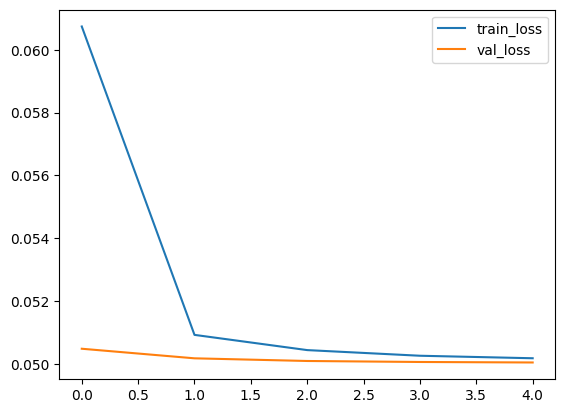

In [21]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [22]:
path = Path(os.getcwd()).parent.parent
fake_dataset_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_dataset_path = os.path.join(path, "artifact", "coco", "metadata.csv")

# creo il dataset di test
testList_df_path = os.path.join("..", "datasets", "testList.csv")
build.test(fake_dataset_path, real_dataset_path, testList_df_path, df)

building (fake column) test dataframe...: 100%|██████████| 1343/1343 [00:00<00:00, 1540.31it/s]


In [23]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr, desc="creating encodings..."):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if str(i).startswith("coco"):
          dir_folder = real_data_dir
          a = io.imread(os.path.join(dir_folder, i))
        else: 
          dir_folder = fake_data_dir
          a = io.imread(os.path.join(dir_folder, i))

        a = torch.from_numpy(a).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        a = io.imread(os.path.join(dir_folder,i))

        a = np.expand_dims(a, 0)
        a = torch.from_numpy(a.astype(np.int32)) / 255.0
        
      a = a.to(device)
      a_enc = model(a.unsqueeze(0))
      encodings.append(a_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [24]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)
df_enc.to_csv("database.csv", index=False)

creating encodings...: 100%|██████████| 6717/6717 [02:05<00:00, 53.68it/s]


In [25]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

C:\Users\raffa\AppData\Local\Temp\ipykernel_11216\2812054046.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_enc = pd.read_csv('database.csv')


,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,coco/coco2017/train2017/img146709.jpg,-1.958629,-3.012752,2.638521,1.657890,-0.793319,-0.298233,-0.370950,-3.418122,-1.262243,...,4.022376,-2.749610,2.650088,1.475575,0.789754,-1.300041,-0.169973,-1.391599,-3.241284,3.721904
1,coco/coco2017/train2017/img062390.jpg,-2.101176,-3.236660,2.840896,1.786158,-0.854868,-0.309407,-0.400750,-3.661631,-1.352207,...,4.333304,-2.949330,2.861481,1.585094,0.835117,-1.394371,-0.171422,-1.488314,-3.470512,3.996136
2,coco/coco2017/train2017/img146531.jpg,-1.943330,-2.996803,2.618183,1.646131,-0.789258,-0.289847,-0.358268,-3.387418,-1.240090,...,3.993658,-2.726206,2.635450,1.459487,0.767143,-1.283613,-0.173553,-1.381601,-3.215492,3.695538
3,coco/coco2017/test2017/img025113.jpg,-2.004005,-3.084019,2.697036,1.694059,-0.809194,-0.297183,-0.379929,-3.475178,-1.287291,...,4.118484,-2.812656,2.711848,1.503077,0.794462,-1.333042,-0.169467,-1.417631,-3.297977,3.797195
4,coco/coco2017/train2017/img108434.jpg,-1.932743,-2.983690,2.598162,1.638783,-0.779375,-0.285825,-0.366110,-3.367686,-1.254000,...,3.971148,-2.703293,2.611160,1.450665,0.771624,-1.274259,-0.168485,-1.378477,-3.185927,3.667141


In [26]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [27]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0        coco/coco2017/test2017/img006831.jpg
1       coco/coco2017/train2017/img047051.jpg
2        coco/coco2017/test2017/img012290.jpg
3        coco/coco2017/test2017/img016229.jpg
4       coco/coco2017/train2017/img114646.jpg
                        ...                  
1338     coco/coco2017/test2017/img006253.jpg
1339    coco/coco2017/train2017/img050619.jpg
1340     coco/coco2017/test2017/img036544.jpg
1341    coco/coco2017/train2017/img156070.jpg
1342     coco/coco2017/test2017/img000707.jpg
Name: real, Length: 1343, dtype: object
2686


,real,fake
0,coco/coco2017/test2017/img006831.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img011697.jpg
1,coco/coco2017/train2017/img047051.jpg,tt-coco/samples_nopix/img000843.jpg
2,coco/coco2017/test2017/img012290.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/403/img01698...
3,coco/coco2017/test2017/img016229.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img018125.jpg
4,coco/coco2017/train2017/img114646.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img032612.jpg


In [28]:
def get_image_embeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [29]:
def search_in_database(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [30]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_dataset_dir = os.path.join(path, "artifact", "coco")
fake_dataset_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

temp_df = df
temp_df.head()
temp_df.shape

(1343, 2)

In [31]:
# testo i fake
current_test = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(temp_df.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_dataset_dir, row[current_test])
    img_name = path

    img = io.imread(img_name)

    img_enc = get_image_embeddings(img, model)

    closest_label = search_in_database(img_enc, database)

    if mode == "rgb":
        if str(closest_label).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale": 
        if "real" in closest_label:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 1343it [05:00,  4.47it/s]


In [32]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
1343
['fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 

In [33]:
# testo i real
current_test = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(temp_df.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_dataset_dir, row[current_test])
    img_name = path

    img = io.imread(img_name)

    img_enc = get_image_embeddings(img, model)

    closest_label = search_in_database(img_enc, database)
    
    if mode == "rgb":
        if str(closest_label).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale":
        if "real" in closest_label:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 1343it [05:05,  4.39it/s]


In [34]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
2686
['fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 

In [36]:
# creo i vettori di ground truth
int(len(df) / 100 * 20)

y_true = np.array(["fake"] * (len(valid_df) - 1))
print(y_true.shape)

temp = np.array(["real"] * (len(valid_df) - 1))
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(1343,)
(1343,)
(2686,)
[[ 196 1147]
 [ 214 1129]]


In [37]:
tn, fp, fn, tp = cm.ravel()

# metriche
accuracy = round((tp + tn) / (tp + tn + fp + fn), 4) * 100
precision = round((tp) / (tp + fp), 4) * 100
recall = round((tp) / (tp + fn), 4) * 100
specificity = round((tn) / (tn + fp) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 49.33, 'Precision': 49.6, 'Recall': 84.07, 'Specificity': 14.5942, 'F1 Score': 62.3905}


In [38]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "rgb_mining", "siamese_" + mode + "_" + "pretrained_semi_hard_online_hard_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)